In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc
from sklearn.svm import SVR

In [2]:
def calculate_mean_of_range(range_value, delimiter='-'):
    nums = str(range_value).split(delimiter)
    sum=0
    for x in nums:
        sum = sum + float(x)
    return round(sum/len(nums),2)

In [3]:
def classification_pred(y):
    preds = []
    for i in range(1, len(y)):
        last_y = y[i - 1]
        curr_y = y[i]
        preds.append(curr_y - last_y > 0.0 )
    return np.array(preds)

# Metric functions
def get_metrics(y, pred_y):
    y_classification = classification_pred(y)
    y_pred_classification = classification_pred(pred_y)
    
    fpr, tpr, thresholds = roc_curve(y_classification, y_pred_classification)
    auc_value = auc(fpr, tpr)

    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(y_classification)):
        is_y_pred_up = y_pred_classification[i]
        is_y_up = y_classification[i][0]

        if is_y_pred_up and is_y_up:
            tp += 1
        elif is_y_pred_up and not is_y_up:
            fp += 1
        elif not is_y_pred_up and not is_y_up:
            tn += 1
        else:
            fn += 1

    return tp, tn, fp, fn, auc_value

In [4]:
gold_master_data = pd.read_csv('final_merged_gold_dataset_new.csv')
gold_master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Columns: 105 entries, Unnamed: 0 to date_10YrBondRate
dtypes: float64(26), int64(23), object(56)
memory usage: 642.4+ KB


In [5]:
columns_to_consider=['monday_date',
 ' Inflation Rate (%)_inflation',
 '1 to 3 yrs._interest',
 'Over 3 yrs. & upto 5 yrs._interest',
 'Above 5 yrs._interest',
 'Uncertainty Index_uncertainty',
 'Price_10YrBondRate',                     
 'Price_fxrate',
 'Price_nifty',
 'Price_snp',
 'Adj Close_wpm',
 'Adj Close_ego',
 'Spot Price(Rs.)_gold',
 'Spot Price(Rs.)_silver',
 'Spot Price(Rs.)_copper',
 'Spot Price(Rs.)_crudeoil', 'pd_price_inr', 'rh_price_inr', 'gdp_per_capita', 'gni_per_capita']

In [6]:
model_input_df = gold_master_data[columns_to_consider]
model_input_df.rename(columns={'monday_date':'date', ' Inflation Rate (%)_inflation': 'inflation_rate', '1 to 3 yrs._interest':'interest_rate_1_to_3', 
                               'Over 3 yrs. & upto 5 yrs._interest': 'interest_rate_1_to_5' ,'Above 5 yrs._interest':'interest_rate_above_5', 
                               'Uncertainty Index_uncertainty': 'uncertainty', 'Price_fxrate': 'fx_rate', 'Price_nifty': 'price_nifty',
                              'Price_snp': 'price_snp', 'Adj Close_wpm': 'wpm_price', 'Adj Close_ego': 'ego_price', 'Spot Price(Rs.)_gold': 'gold_price', 
                               'Spot Price(Rs.)_silver': 'silver_price',
                              'Spot Price(Rs.)_copper': 'copper_price', 'Spot Price(Rs.)_crudeoil': 'oil_price'}, inplace=True)
model_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   783 non-null    object 
 1   inflation_rate         783 non-null    float64
 2   interest_rate_1_to_3   783 non-null    object 
 3   interest_rate_1_to_5   783 non-null    object 
 4   interest_rate_above_5  783 non-null    object 
 5   uncertainty            783 non-null    float64
 6   Price_10YrBondRate     783 non-null    float64
 7   fx_rate                783 non-null    float64
 8   price_nifty            783 non-null    object 
 9   price_snp              783 non-null    object 
 10  wpm_price              783 non-null    float64
 11  ego_price              783 non-null    float64
 12  gold_price             783 non-null    int64  
 13  silver_price           783 non-null    int64  
 14  copper_price           783 non-null    float64
 15  oil_pr

C:\Users\Surya\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
model_input_df.head(5)

date  inflation_rate interest_rate_1_to_3 interest_rate_1_to_5  \
0  2006-01-02          5.7965            6.00-6.50            6.25-7.00   
1  2006-01-09          5.7965            6.00-6.50            6.25-7.00   
2  2006-01-16          5.7965            6.00-6.50            6.25-7.00   
3  2006-01-23          5.7965            6.00-6.50            6.25-7.00   
4  2006-01-30          5.7965            6.00-6.50            6.25-7.00   

  interest_rate_above_5  uncertainty  Price_10YrBondRate  fx_rate price_nifty  \
0             6.25-7.00     39.99015               7.180   45.075    2,835.95   
1             6.25-7.00     39.99015               7.187   44.250    2,910.10   
2             6.25-7.00     39.99015               7.202   44.170    2,833.10   
3             6.25-7.00     39.99015               7.205   44.095    2,884.05   
4             6.25-7.00     39.99015               7.425   44.045    2,974.50   

  price_snp  wpm_price  ego_price  gold_price  silver_price  copper_price  \
0  1,273.46   5.048476  23.455441        7640         13300        202.90   
1  1,290.15   5.161630  25.513779        7845         13500        205.40   
2  1,287.61   5.266082  24.843624        8010         13600        206.10   
3  1,263.82   5.031067  22.306606        8030         13275        204.40   
4  1,285.19   6.484680  23.790525        8080         14170        217.35   

   oil_price  pd_price_inr  rh_price_inr  gdp_per_capita  gni_per_capita  
0       2755     11809.650     135225.00    36364.404998        35609.25  
1       2816     12124.500     132750.00    35698.833525        34957.50  
2       2830     12588.450     136485.30    35634.293261        34894.30  
3       3032     12214.315     138458.30    35573.786764        34835.05  
4       2982     12200.465     147550.75    35533.449099        34795.55

In [8]:
model_input_df['interest_rate_1_to_3']=model_input_df['interest_rate_1_to_3'].apply(lambda x: calculate_mean_of_range(x))
model_input_df['interest_rate_1_to_5']=model_input_df['interest_rate_1_to_5'].apply(lambda x: calculate_mean_of_range(x))
model_input_df['interest_rate_above_5']=model_input_df['interest_rate_above_5'].apply(lambda x: calculate_mean_of_range(x))
model_input_df['price_nifty'] = model_input_df['price_nifty'].apply(lambda x: str(x).replace(',', ''))
model_input_df['price_snp'] = model_input_df['price_snp'].apply(lambda x: str(x).replace(',', ''))
model_input_df['price_nifty'] = pd.to_numeric(model_input_df['price_nifty'],errors = 'coerce')
model_input_df['price_snp'] = pd.to_numeric(model_input_df['price_snp'],errors = 'coerce')

<ipython-input-8-2d3330926d1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_input_df['interest_rate_1_to_3']=model_input_df['interest_rate_1_to_3'].apply(lambda x: calculate_mean_of_range(x))
<ipython-input-8-2d3330926d1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_input_df['interest_rate_1_to_5']=model_input_df['interest_rate_1_to_5'].apply(lambda x: calculate_mean_of_range(x))
<ipython-input-8-2d3330926d1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [9]:
model_input_df.describe()

inflation_rate  interest_rate_1_to_3  interest_rate_1_to_5  \
count      783.000000            783.000000            783.000000   
mean         7.114451              7.526003              7.552069   
std          2.722230              1.199070              1.101480   
min          3.328200              5.170000              5.300000   
25%          4.907000              6.580000              6.700000   
50%          6.623400              7.380000              7.250000   
75%          9.312400              8.620000              8.620000   
max         11.989400              9.120000              9.120000   

       interest_rate_above_5  uncertainty  Price_10YrBondRate     fx_rate  \
count             783.000000   783.000000          783.000000  783.000000   
mean                7.514049    98.966078            7.604040   56.854672   
std                 1.035466    50.631470            0.770052   10.983243   
min                 5.380000    27.739460            5.172000   39.190000   
25%                 6.620000    63.247227            7.176000   46.005000   
50%                 7.380000    87.388771            7.749000   58.715000   
75%                 8.380000   126.778580            8.126000   66.593500   
max                 8.880000   283.689087            9.383000   76.570000   

        price_nifty    price_snp   wpm_price   ego_price    gold_price  \
count    783.000000   783.000000  783.000000  783.000000    783.000000   
mean    6997.873946  1851.830741   19.833462   33.232717  24751.014049   
std     2715.865147   696.185484    9.606632   24.704446  10127.085156   
min     2524.200000   676.530000    2.254405    2.660000   7640.000000   
25%     4977.825000  1297.665000   12.657355   14.188278  15782.500000   
50%     6035.650000  1642.810000   18.953203   26.997696  27505.000000   
75%     8945.650000  2358.000000   25.031256   45.115828  30315.500000   
max    13873.200000  3735.360000   55.573048  100.720306  55331.000000   

       silver_price  copper_price    oil_price   pd_price_inr  rh_price_inr  \
count    783.000000    783.000000   783.000000     783.000000  7.830000e+02   
mean   37335.080460    373.362133  3899.372925   48631.705093  1.769603e+05   
std    13212.898244     75.948783  1106.180754   40117.503290  2.042104e+05   
min    13275.000000    137.600000  1295.000000    8398.720000  4.172750e+04   
25%    25557.500000    321.800000  3072.500000   18560.540000  6.556171e+04   
50%    38189.000000    388.300000  3673.000000   37939.575000  9.482550e+04   
75%    45037.500000    428.625000  4678.500000   52943.250000  2.164730e+05   
max    73288.000000    610.500000  7291.000000  196406.210000  1.232533e+06   

       gdp_per_capita  gni_per_capita  
count      783.000000      783.000000  
mean     89149.554824    87652.874815  
std      37275.203008    37560.843223  
min      35533.449099    34795.550000  
25%      53858.334100    54359.200000  
50%      86331.553328    90523.600000  
75%     127161.187484   117112.450000  
max     151296.123030   152682.400000

In [10]:
# No missing value
gold_master_data[gold_master_data.isnull().sum(axis=1)>0]

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0_x, monday_date, date_inflation,  Inflation Rate (%)_inflation,  Annual Change_inflation, year_inflation, date_gdp, gdp_per_capita, date_gni, gni_per_capita, Unnamed: 0_y, Year_interest, 1 to 3 yrs._interest, Over 3 yrs. & upto 5 yrs._interest, Above 5 yrs._interest, date_interest, Unnamed: 0_x.1, Year_uncertainty, Month_uncertainty, Uncertainty Index_uncertainty, date_uncertainty, Unnamed: 0_y.1, Price_fxrate, Open_fxrate, High_fxrate, Low_fxrate, Volume_fxrate, Chg%_fxrate, date_fxrate, Unnamed: 0_x.2, Price_nifty, Open_nifty, High_nifty, Low_nifty, Volume_nifty, Chg%_nifty, date_nifty, Unnamed: 0_y.2, Price_snp, Open_snp, High_snp, Low_snp, Volume_snp, Chg%_snp, date_snp, Unnamed: 0_x.3, Open_wpm, High_wpm, Low_wpm, Close_wpm, Adj Close_wpm, Volume_wpm, date_wpm, Unnamed: 0_y.3, Open_ego, High_ego, Low_ego, Close_ego, Adj Close_ego, Volume_ego, date_ego, Unnamed: 0_x.4, Commodity_gold, Unit_gold, Location_gold, Spot Price(Rs.)_gold, Up/Down_gold, Time_gold, date_gold, Unnamed: 0_y.4, Commodity_silver, Unit_silver, Location_silver, Spot Price(Rs.)_silver, Up/Down_silver, Time_silver, date_silver, Unnamed: 0_x.5, Commodity_copper, Unit_copper, Location_copper, Spot Price(Rs.)_copper, Up/Down_copper, Time_copper, date_copper, Unnamed: 0_y.5, Commodity_crudeoil, Unit_crudeoil, Location_crudeoil, Spot Price(Rs.)_crudeoil, Up/Down_crudeoil, Time_crudeoil, date_crudeoil, date_pd, pd_price_inr, date_rh, rh_price_inr, Unnamed: 0.1, Price_10YrBondRate, ...]
Index: []

[0 rows x 105 columns]

In [11]:
## Scatter Plot

In [12]:
def density_plot(df):
    df.plot(kind='kde', figsize=(12,6))
    plt.show()

Skewness: 0.1779347719106384
kurtosis: -0.06775521863439371


array([[<AxesSubplot:title={'center':'gold_price'}>]], dtype=object)

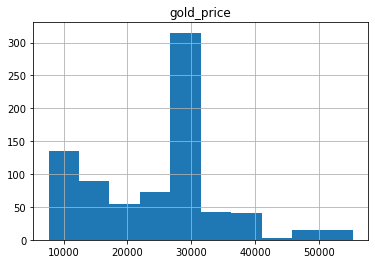

In [13]:
# Hist plot
print(f"Skewness: {skew(model_input_df['gold_price'])}")
print(f"kurtosis: {kurtosis(model_input_df['gold_price'])}")
model_input_df[['gold_price']].hist()

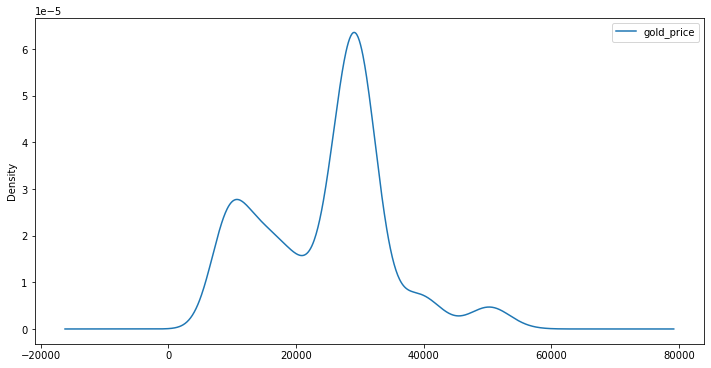

In [14]:
density_plot(model_input_df[['gold_price']])

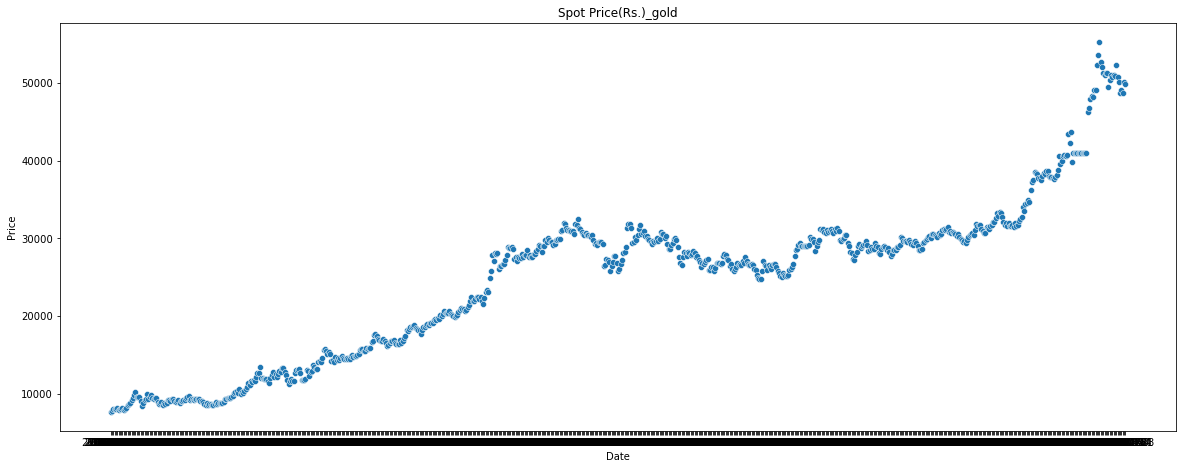

In [15]:
# Scatter Plot
plt.figure(figsize=[20, 7.5]); # Set dimensions for figure
sns.scatterplot(x=model_input_df['date'], y=model_input_df['gold_price']);
plt.title('Spot Price(Rs.)_gold');
plt.ylabel('Price');
plt.xlabel('Date');

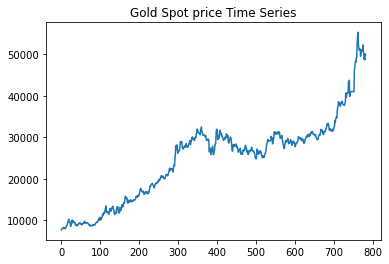

In [16]:
plt.plot(model_input_df['gold_price'])
plt.title('Gold Spot price Time Series')
plt.show()

So overall, what this means to us is, if a series is stationary according to the KPSS test by setting regression='ct' and is not stationary according to the ADF test, it means the series is stationary around a deterministic trend and so is fairly easy to model this series and produce fairly accurate forecasts.

In [17]:
model_input_df.columns

Index(['date', 'inflation_rate', 'interest_rate_1_to_3',
       'interest_rate_1_to_5', 'interest_rate_above_5', 'uncertainty',
       'Price_10YrBondRate', 'fx_rate', 'price_nifty', 'price_snp',
       'wpm_price', 'ego_price', 'gold_price', 'silver_price', 'copper_price',
       'oil_price', 'pd_price_inr', 'rh_price_inr', 'gdp_per_capita',
       'gni_per_capita'],
      dtype='object')

In [18]:
model_input_df.head(5)

date  inflation_rate  interest_rate_1_to_3  interest_rate_1_to_5  \
0  2006-01-02          5.7965                  6.25                  6.62   
1  2006-01-09          5.7965                  6.25                  6.62   
2  2006-01-16          5.7965                  6.25                  6.62   
3  2006-01-23          5.7965                  6.25                  6.62   
4  2006-01-30          5.7965                  6.25                  6.62   

   interest_rate_above_5  uncertainty  Price_10YrBondRate  fx_rate  \
0                   6.62     39.99015               7.180   45.075   
1                   6.62     39.99015               7.187   44.250   
2                   6.62     39.99015               7.202   44.170   
3                   6.62     39.99015               7.205   44.095   
4                   6.62     39.99015               7.425   44.045   

   price_nifty  price_snp  wpm_price  ego_price  gold_price  silver_price  \
0      2835.95    1273.46   5.048476  23.455441        7640         13300   
1      2910.10    1290.15   5.161630  25.513779        7845         13500   
2      2833.10    1287.61   5.266082  24.843624        8010         13600   
3      2884.05    1263.82   5.031067  22.306606        8030         13275   
4      2974.50    1285.19   6.484680  23.790525        8080         14170   

   copper_price  oil_price  pd_price_inr  rh_price_inr  gdp_per_capita  \
0        202.90       2755     11809.650     135225.00    36364.404998   
1        205.40       2816     12124.500     132750.00    35698.833525   
2        206.10       2830     12588.450     136485.30    35634.293261   
3        204.40       3032     12214.315     138458.30    35573.786764   
4        217.35       2982     12200.465     147550.75    35533.449099   

   gni_per_capita  
0        35609.25  
1        34957.50  
2        34894.30  
3        34835.05  
4        34795.55

In [19]:
model_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   783 non-null    object 
 1   inflation_rate         783 non-null    float64
 2   interest_rate_1_to_3   783 non-null    float64
 3   interest_rate_1_to_5   783 non-null    float64
 4   interest_rate_above_5  783 non-null    float64
 5   uncertainty            783 non-null    float64
 6   Price_10YrBondRate     783 non-null    float64
 7   fx_rate                783 non-null    float64
 8   price_nifty            783 non-null    float64
 9   price_snp              783 non-null    float64
 10  wpm_price              783 non-null    float64
 11  ego_price              783 non-null    float64
 12  gold_price             783 non-null    int64  
 13  silver_price           783 non-null    int64  
 14  copper_price           783 non-null    float64
 15  oil_pr

In [20]:
model_input_df.head(5)

date  inflation_rate  interest_rate_1_to_3  interest_rate_1_to_5  \
0  2006-01-02          5.7965                  6.25                  6.62   
1  2006-01-09          5.7965                  6.25                  6.62   
2  2006-01-16          5.7965                  6.25                  6.62   
3  2006-01-23          5.7965                  6.25                  6.62   
4  2006-01-30          5.7965                  6.25                  6.62   

   interest_rate_above_5  uncertainty  Price_10YrBondRate  fx_rate  \
0                   6.62     39.99015               7.180   45.075   
1                   6.62     39.99015               7.187   44.250   
2                   6.62     39.99015               7.202   44.170   
3                   6.62     39.99015               7.205   44.095   
4                   6.62     39.99015               7.425   44.045   

   price_nifty  price_snp  wpm_price  ego_price  gold_price  silver_price  \
0      2835.95    1273.46   5.048476  23.455441        7640         13300   
1      2910.10    1290.15   5.161630  25.513779        7845         13500   
2      2833.10    1287.61   5.266082  24.843624        8010         13600   
3      2884.05    1263.82   5.031067  22.306606        8030         13275   
4      2974.50    1285.19   6.484680  23.790525        8080         14170   

   copper_price  oil_price  pd_price_inr  rh_price_inr  gdp_per_capita  \
0        202.90       2755     11809.650     135225.00    36364.404998   
1        205.40       2816     12124.500     132750.00    35698.833525   
2        206.10       2830     12588.450     136485.30    35634.293261   
3        204.40       3032     12214.315     138458.30    35573.786764   
4        217.35       2982     12200.465     147550.75    35533.449099   

   gni_per_capita  
0        35609.25  
1        34957.50  
2        34894.30  
3        34835.05  
4        34795.55

<AxesSubplot:>

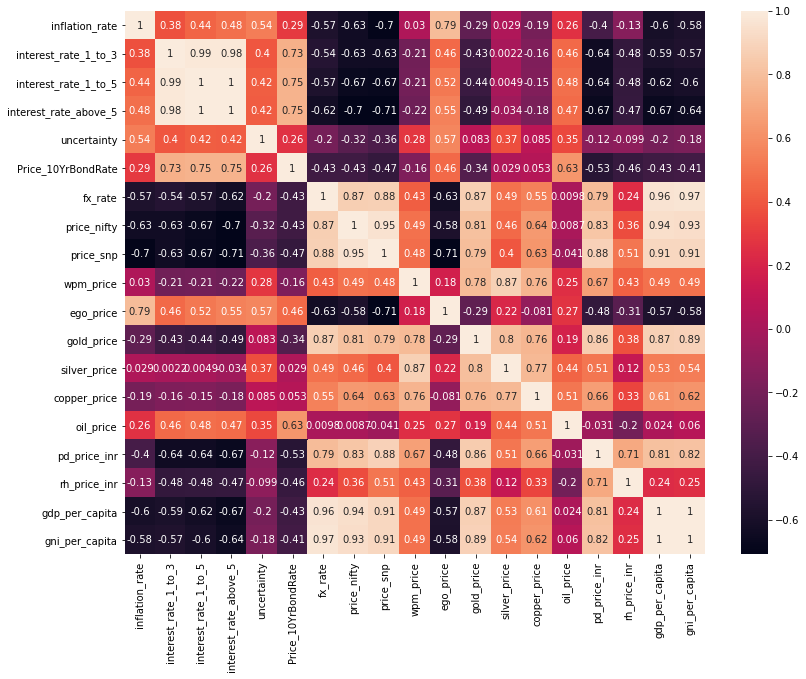

In [21]:
fig, ax = plt.subplots(figsize=(13,10))  
sns.heatmap(model_input_df.corr(), ax=ax, annot=True)

## Models

In [22]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Conv1D
import numpy as np
from matplotlib import pyplot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [23]:
model_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   783 non-null    object 
 1   inflation_rate         783 non-null    float64
 2   interest_rate_1_to_3   783 non-null    float64
 3   interest_rate_1_to_5   783 non-null    float64
 4   interest_rate_above_5  783 non-null    float64
 5   uncertainty            783 non-null    float64
 6   Price_10YrBondRate     783 non-null    float64
 7   fx_rate                783 non-null    float64
 8   price_nifty            783 non-null    float64
 9   price_snp              783 non-null    float64
 10  wpm_price              783 non-null    float64
 11  ego_price              783 non-null    float64
 12  gold_price             783 non-null    int64  
 13  silver_price           783 non-null    int64  
 14  copper_price           783 non-null    float64
 15  oil_pr

In [24]:
model_input_df.columns

Index(['date', 'inflation_rate', 'interest_rate_1_to_3',
       'interest_rate_1_to_5', 'interest_rate_above_5', 'uncertainty',
       'Price_10YrBondRate', 'fx_rate', 'price_nifty', 'price_snp',
       'wpm_price', 'ego_price', 'gold_price', 'silver_price', 'copper_price',
       'oil_price', 'pd_price_inr', 'rh_price_inr', 'gdp_per_capita',
       'gni_per_capita'],
      dtype='object')

In [25]:
# Transforming the dataset to ln scale
cols=['inflation_rate', 'interest_rate_1_to_3',
       'interest_rate_1_to_5', 'interest_rate_above_5', 'uncertainty',
       'Price_10YrBondRate', 'fx_rate', 'price_nifty', 'price_snp',
       'wpm_price', 'ego_price', 'gold_price', 'silver_price', 'copper_price',
       'oil_price', 'pd_price_inr', 'rh_price_inr', 'gdp_per_capita',
       'gni_per_capita']
model_input_df[cols] = np.log(model_input_df[cols])

C:\Users\Surya\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Skewness: -0.7001179876087381
kurtosis: -0.5568074112254298


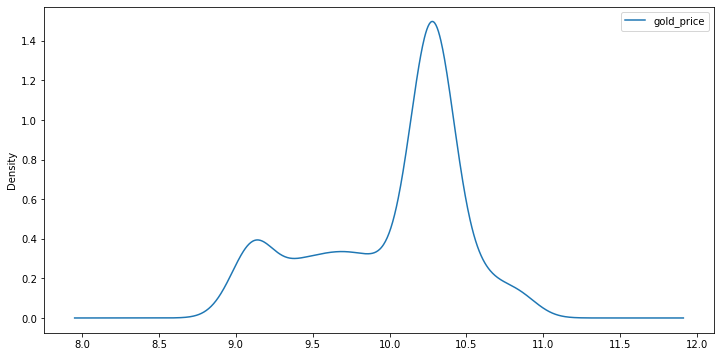

In [26]:
print(f"Skewness: {skew(model_input_df['gold_price'])}")
print(f"kurtosis: {kurtosis(model_input_df['gold_price'])}")
density_plot(model_input_df[['gold_price']])

In [27]:
model_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   783 non-null    object 
 1   inflation_rate         783 non-null    float64
 2   interest_rate_1_to_3   783 non-null    float64
 3   interest_rate_1_to_5   783 non-null    float64
 4   interest_rate_above_5  783 non-null    float64
 5   uncertainty            783 non-null    float64
 6   Price_10YrBondRate     783 non-null    float64
 7   fx_rate                783 non-null    float64
 8   price_nifty            783 non-null    float64
 9   price_snp              783 non-null    float64
 10  wpm_price              783 non-null    float64
 11  ego_price              783 non-null    float64
 12  gold_price             783 non-null    float64
 13  silver_price           783 non-null    float64
 14  copper_price           783 non-null    float64
 15  oil_pr

In [28]:
model_input_df.describe()

inflation_rate  interest_rate_1_to_3  interest_rate_1_to_5  \
count      783.000000            783.000000            783.000000   
mean         1.885303              2.004955              2.010765   
std          0.398762              0.166353              0.150453   
min          1.202432              1.642873              1.667707   
25%          1.590663              1.884035              1.902108   
50%          1.890609              1.998774              1.981001   
75%          2.231347              2.154085              2.154085   
max          2.484023              2.210470              2.210470   

       interest_rate_above_5  uncertainty  Price_10YrBondRate     fx_rate  \
count             783.000000   783.000000          783.000000  783.000000   
mean                2.006861     4.470951            2.023299    4.021311   
std                 0.142580     0.501663            0.105195    0.197507   
min                 1.682688     3.322856            1.643259    3.668422   
25%                 1.890095     4.147051            1.970742    3.828750   
50%                 1.998774     4.470367            2.047564    4.072695   
75%                 2.125848     4.842442            2.095069    4.198607   
max                 2.183802     5.647879            2.238900    4.338205   

       price_nifty   price_snp   wpm_price   ego_price  gold_price  \
count   783.000000  783.000000  783.000000  783.000000  783.000000   
mean      8.774886    7.454821    2.861266    3.177545   10.015348   
std       0.403361    0.372104    0.528906    0.877603    0.478857   
min       7.833679    6.516977    0.812886    0.978326    8.941153   
25%       8.512748    7.168322    2.538238    2.652385    9.666657   
50%       8.705439    7.404163    2.941973    3.295752   10.222123   
75%       9.098922    7.765569    3.220124    3.809230   10.319414   
max       9.537714    8.225599    4.017698    4.612347   10.921089   

       silver_price  copper_price   oil_price  pd_price_inr  rh_price_inr  \
count    783.000000    783.000000  783.000000    783.000000    783.000000   
mean      10.456501      5.898413    8.228683     10.509821     11.701760   
std        0.393117      0.230580    0.284266      0.746734      0.791058   
min        9.493638      4.924351    7.166266      9.035835     10.638916   
25%       10.148686      5.773929    8.030247      9.828787     11.090747   
50%       10.550303      5.961778    8.208764     10.543750     11.459794   
75%       10.715251      6.060582    8.450733     10.876976     12.285221   
max       11.202152      6.414278    8.894396     12.187940     14.024582   

       gdp_per_capita  gni_per_capita  
count      783.000000      783.000000  
mean        11.300131       11.277277  
std          0.457479        0.472448  
min         10.478230       10.457245  
25%         10.894112       10.903369  
50%         11.365950       11.413366  
75%         11.753211       11.670890  
max         11.926994       11.936115

In [29]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [30]:
def define_dataset(start_week=0, split_time=750, no_of_validation_steps=1):
    # Normalized train and validation data
    train_val_df = model_input_df[start_week:split_time]
    X_train_val = train_val_df.drop(columns=['gold_price', 'date'])
    X_train_val= X_scaler.fit_transform(X_train_val)

    y_train_val = train_val_df[['gold_price']]
    y_train_val = y_scaler.fit_transform(y_train_val)

    # Normalized test data
    test_df = model_input_df[split_time:]
    X_test = test_df.drop(columns=['gold_price', 'date'])
    X_test = X_scaler.transform(X_test)

    y_test = test_df[['gold_price']]
    y_test_Inverse = y_test
    y_test = y_scaler.transform(y_test)

    X_train = X_train_val[:-no_of_validation_steps]
    y_train = y_train_val[:-no_of_validation_steps]

    X_val = X_train_val[-no_of_validation_steps:]
    y_val = y_train_val[-no_of_validation_steps:]

    print('Train Input Shape', X_train.shape)
    print('Train output Shape',y_train.shape)
    print('Validation Input Shape', X_val.shape)
    print('validation output Shape',y_val.shape)
    print('Test Input Shape', X_test.shape)
    print('Test output Shape',y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = define_dataset()

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)


In [32]:
def plot_history(history):
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

### Split data into train and test dataset

In [33]:
n_features=18

In [34]:
print('X_train shape' , X_train.shape)
print('X_test shape' , X_test.shape)
print('y_train shape' , y_train.shape)
print('y_test shape' , y_test.shape)

X_train shape (749, 18)
X_test shape (33, 18)
y_train shape (749, 1)
y_test shape (33, 1)


In [35]:
#from keras.optimizers import rmsprop_v2
from keras.layers import Dropout
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator

In [36]:
n_hidden_nodes=[32, 64, 128,256]
activations=['relu', 'tanh']
lookbacks=[5,10,20]
measures=['mae']
optimizers=['adam', 'RMSprop']
epochs=[10,20]
batch_size=[5,10,50]
config_list = np.array(np.meshgrid(n_hidden_nodes, activations, lookbacks, measures, optimizers, epochs, batch_size)).T.reshape(-1,7)
config_list.shape

(288, 7)

In [37]:
n_hidden_nodes=[100]
activations=['relu', 'tanh']
lookbacks=[5,10,20]
measures=['mae']
optimizers=['adam', 'RMSprop']
epochs=[10,20]
batch_size=[5,10,50]
config_list_fixed_nodes = np.array(np.meshgrid(n_hidden_nodes, activations, lookbacks, measures, optimizers, epochs, batch_size)).T.reshape(-1,7)
config_list_fixed_nodes.shape

(72, 7)

### Predict gold price and compare it with actual

In [38]:
def plot_true_vs_pred(y_true, y_pred):
    
    print('y_true shape: ', y_true.shape)
    print('y_pred shape: ', y_pred.shape)
    fig, ax = plt.subplots() # Create the figure and axes object
    
    ax.plot(range(0,len(y_true)), y_true, label='Actual')
    ax.plot(range(0,len(y_pred)), y_pred, label='Predicted')
    plt.legend()
    plt.show()
    # Plot the first x and y axes:
    #df.plot(y = 'deaths', ax = ax) 
    # Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
    # (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
    #df.plot(x = 'year', y = 'cheese', ax = ax, secondary_y = True) 

In [39]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
     mse = metrics.mean_squared_error(y_true, y_pred)
     mae = metrics.mean_absolute_error(y_true, y_pred)
     rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
     mape = mean_absolute_percentage_error(y_true, y_pred)
     r2 = metrics.r2_score(y_true, y_pred)
    
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
     return mse, mae, rmse, mape, r2

## Univariate Models

In [40]:
result_df = pd.DataFrame(columns=['model_name','n_hidden_node', 'activation', 'lookback', 'measure', 'optimizer', 'epoch', 'batch_size', 'mse', 'mae', 'rmse', 
                                  'mape', 'r2', 'test_loss', 'time_taken', 'precision', 'recall', 'auc_value'])

In [41]:
# Evaluate and plot actual vs predicted gold price
def evaluate_model(model, test_gen_new, lookback):
    #print('Test Gen Length: ', len(test_gen_new))

    pred = model.predict_generator(test_gen_new)
    pred_Inverse = y_scaler.inverse_transform(pred.reshape(-1, 1))
    y_test_inverse = y_scaler.inverse_transform(y_test.reshape(-1, 1))[lookback:]

    print(pred_Inverse.shape)
    #print(f'y_test_inverse = {y_test_inverse}')
    #print(f'pred_Inverse = {pred_Inverse}')
    test_loss = model.evaluate(test_gen_new, verbose = 0, steps=1) 
    mse, mae, rmse, mape, r2 = timeseries_evaluation_metrics_func(y_test_inverse, pred_Inverse)
    tp, tn, fp, fn, auc_value = get_metrics(y_test_inverse, pred_Inverse)
    #precision = tp/(tp+fp)
    #recall = tp/(tp+fn)
    precision = -1
    recall = -1
    print(f'Precision is : {precision}')
    print(f'Recall is : {recall}')
    print(f'AUC is : {auc_value}')
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value
#plot_true_vs_pred(y_test_inverse, pred_Inverse)

## GRU-Univariate

In [42]:
## GRU-Univariate1

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

## GRU Model
# don't know appropriate batch size , activaation function, what dropout value to choose
def build_GRU_Univariate_1_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    #print(f'train_gen_new length: {len(train_gen_new)}')
    #print(f'test_gen_new length: {len(test_gen_new)}')
    
    model = Sequential()
    model.add(layers.GRU(100, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=False))
    
    model.add(layers.Dense(1))
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_GRU_Univariate_1_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'GRU-Univariate1', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               30900     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00315556184410697
MAE is : 0.044937139868963714
RMSE is : 0.0561743877946789
MAPE is : 0.4146680143111199
R2 is : -1.9071635459005654

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.00315556184410697, 0.044937139868963714, 0.0561743877946789, 0.4146680143111199, -1.9071635459005654)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.001278388616848233
MAE is : 0.026585757436002222
RMSE is : 0.03575456078388089
MAPE is : 0.24527874379774478
R2 is : -0.17775691556671136

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.001278388616848233, 0.026585757436002222, 0.03575456078388089, 0.24527874379774478, -0.17775691556671136)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017645015063847105
MAE is : 0.12874024509536328
RMSE is : 0.13283454017629265
MAPE is : 1.1869440722020346
R2 is : -19.71614327049021

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.017645015063847105, 0.12874024509536328, 0.13283454017629265, 1.1869440722020346, -19.71614327049021)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0006689240837471935
MAE is : 0.019843676150382742
RMSE is : 0.025863566725167538
MAPE is : 0.18284889199542742
R2 is : 0.21464917395389704

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0006689240837471935, 0.019843676150382742, 0.025863566725167538, 0.18284889199542742, 0.21464917395389704)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0005088717728744388
MAE is : 0.018381698867729668
RMSE is : 0.022558186382651394
MAPE is : 0.16968501612749018
R2 is : -0.33428580188076507

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0005088717728744388, 0.018381698867729668, 0.022558186382651394, 0.16968501612749018, -0.33428580188076507)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0004619904689996489
MAE is : 0.018306694933058792
RMSE is : 0.021493963547927798
MAPE is : 0.1690141947924659
R2 is : -0.2113608108158267

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0004619904689996489, 0.018306694933058792, 0.021493963547927798, 0.1690141947924659, -0.2113608108158267)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001062213520902838
MAE is : 0.026638316435650986
RMSE is : 0.032591617341010216
MAPE is : 0.24584668736883192
R2 is : 0.021401392687540044

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.001062213520902838, 0.026638316435650986, 0.032591617341010216, 0.24584668736883192, 0.021401392687540044)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.007618087612235072
MAE is : 0.08274980026843583
RMSE is : 0.08728165679130451
MAPE is : 0.7637648181422276
R2 is : -6.018409934549749

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.007618087612235072, 0.08274980026843583, 0.08728165679130451, 0.7637648181422276, -6.018409934549749)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0009968070702851745
MAE is : 0.021510269041357333
RMSE is : 0.03157225158719559
MAPE is : 0.19808381640952416
R2 is : -0.17030209418041786

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0009968070702851745, 0.021510269041357333, 0.03157225158719559, 0.19808381640952416, -0.17030209418041786)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0027545586283080673
MAE is : 0.04783396844647137
RMSE is : 0.052483889226200335
MAPE is : 0.44152933085318286
R2 is : -2.2339916392541417

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0027545586283080673, 0.04783396844647137, 0.052483889226200335, 0.44152933085318286, -2.2339916392541417)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0004923927877342421
MAE is : 0.018271828913427567
RMSE is : 0.022189925365675347
MAPE is : 0.16889550373127926
R2 is : -0.2910771252081179

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0004923927877342421, 0.018271828913427567, 0.022189925365675347, 0.16889550373127926, -0.2910771252081179)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.005660426989137894
MAE is : 0.07349926257308367
RMSE is : 0.07523580922099458
MAPE is : 0.6787969915965559
R2 is : -13.841906678232963

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.005660426989137894, 0.07349926257308367, 0.07523580922099458, 0.6787969915965559, -13.841906678232963)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0037295082880879245
MAE is : 0.05352663066917523
RMSE is : 0.06106970024560399
MAPE is : 0.49396532637808593
R2 is : -2.4359302954278266

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0037295082880879245, 0.05352663066917523, 0.06106970024560399, 0.49396532637808593, -2.4359302954278266)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0012729861542335648
MAE is : 0.028146231903067673
RMSE is : 0.03567893151754358
MAPE is : 0.25969355646083714
R2 is : -0.172779721917097

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0012729861542335648, 0.028146231903067673, 0.03567893151754358, 0.25969355646083714, -0.172779721917097)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0007402295960135781
MAE is : 0.022383574960480986
RMSE is : 0.027207160748846583
MAPE is : 0.20636276146647983
R2 is : 0.13093288339018372

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0007402295960135781, 0.022383574960480986, 0.027207160748846583, 0.20636276146647983, 0.13093288339018372)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0005700868206330563
MAE is : 0.018112147765220004
RMSE is : 0.023876490961467857
MAPE is : 0.16692164387727892
R2 is : 0.3306891374068489

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.0005700868206330563, 0.018112147765220004, 0.023876490961467857, 0.16692164387727892, 0.3306891374068489)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00027918235066819104
MAE is : 0.013470600181609308
RMSE is : 0.016708750721349308
MAPE is : 0.12441128965744398
R2 is : 0.2679707020727621

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.00027918235066819104, 0.013470600181609308, 0.016708750721349308, 0.12441128965744398, 0.2679707020727621)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003816469423491879
MAE is : 0.01588766334971294
RMSE is : 0.019535786197365797
MAPE is : 0.1466780445240801
R2 is : -0.0006962925675522147

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.0003816469423491879, 0.01588766334971294, 0.019535786197365797, 0.1466780445240801, -0.0006962925675522147)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013675590051388205
MAE is : 0.027273664096641465
RMSE is : 0.03698052196952905
MAPE is : 0.2516227520181847
R2 is : -0.25990802367961785

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0013675590051388205, 0.027273664096641465, 0.03698052196952905, 0.2516227520181847, -0.25990802367961785)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0008122601944751628
MAE is : 0.021932833614594176
RMSE is : 0.02850017884988027
MAPE is : 0.20232391373744318
R2 is : 0.2516789897259737

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0008122601944751628, 0.021932833614594176, 0.02850017884988027, 0.20232391373744318, 0.2516789897259737)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_20 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0031488717978576898
MAE is : 0.05089144830486981
RMSE is : 0.056114809077975926
MAPE is : 0.4698302288314543
R2 is : -2.6969353139562298

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0031488717978576898, 0.05089144830486981, 0.056114809077975926, 0.4698302288314543, -2.6969353139562298)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002141022784592878
MAE is : 0.04017047746085575
RMSE is : 0.04627118741282611
MAPE is : 0.37030404610021195
R2 is : -1.5136694182758954

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.002141022784592878, 0.04017047746085575, 0.04627118741282611, 0.37030404610021195, -1.5136694182758954)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0021464973661468193
MAE is : 0.043245265357225796
RMSE is : 0.046330307209717696
MAPE is : 0.3993281394770445
R2 is : -4.628217386172145

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0021464973661468193, 0.043245265357225796, 0.046330307209717696, 0.3993281394770445, -4.628217386172145)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_23 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.000304724690194282
MAE is : 0.01407190404875276
RMSE is : 0.017456365320257308
MAPE is : 0.12996253981524575
R2 is : 0.2009974825051476

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.000304724690194282, 0.01407190404875276, 0.017456365320257308, 0.12996253981524575, 0.2009974825051476)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_24 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001349345073757393
MAE is : 0.027250591471228564
RMSE is : 0.03673343264326645
MAPE is : 0.25145604370567426
R2 is : -0.24312784951237543

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.001349345073757393, 0.027250591471228564, 0.03673343264326645, 0.25145604370567426, -0.24312784951237543)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003485856922337984
MAE is : 0.04962332516079896
RMSE is : 0.05904114601138755
MAPE is : 0.45790121391174915
R2 is : -2.211458583761034

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.003485856922337984, 0.04962332516079896, 0.05904114601138755, 0.45790121391174915, -2.211458583761034)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0018187925111775754
MAE is : 0.029446719984242357
RMSE is : 0.04264730368004026
MAPE is : 0.2710587586296479
R2 is : -1.1353547222551588

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0018187925111775754, 0.029446719984242357, 0.04264730368004026, 0.2710587586296479, -1.1353547222551588)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_27 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0025189322074548343
MAE is : 0.04221125969868783
RMSE is : 0.050188964996848
MAPE is : 0.38898677775040597
R2 is : -1.9573542617826063

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0025189322074548343, 0.04221125969868783, 0.050188964996848, 0.38898677775040597, -1.9573542617826063)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020903423239478753
MAE is : 0.04242403208117565
RMSE is : 0.045720261634726846
MAPE is : 0.3921034104672363
R2 is : -4.48097621559821

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.0020903423239478753, 0.04242403208117565, 0.045720261634726846, 0.3921034104672363, -4.48097621559821)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_29 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0005872535381185076
MAE is : 0.020067933369990926
RMSE is : 0.024233314633341177
MAPE is : 0.18550229024309187
R2 is : -0.5398064891469414

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0005872535381185076, 0.020067933369990926, 0.024233314633341177, 0.18550229024309187, -0.5398064891469414)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.025714497108861534
MAE is : 0.15716187367629017
RMSE is : 0.16035740428449674
MAPE is : 1.4507331788381765
R2 is : -22.69031325931877

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.025714497108861534, 0.15716187367629017, 0.16035740428449674, 1.4507331788381765, -22.69031325931877)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0010915774572803911
MAE is : 0.024928427126306257
RMSE is : 0.03303902930293793
MAPE is : 0.23002163191655822
R2 is : -0.00565108468994735

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0010915774572803911, 0.024928427126306257, 0.03303902930293793, 0.23002163191655822, -0.00565108468994735)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02332364109882643
MAE is : 0.14905952032941983
RMSE is : 0.1527207945854998
MAPE is : 1.3743723738536722
R2 is : -26.383138458337836

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.02332364109882643, 0.14905952032941983, 0.1527207945854998, 1.3743723738536722, -26.383138458337836)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_33 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.000749032923708172
MAE is : 0.020437883004608862
RMSE is : 0.027368465863255323
MAPE is : 0.18830370348350275
R2 is : 0.12059732985745031

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.000749032923708172, 0.020437883004608862, 0.027368465863255323, 0.18830370348350275, 0.12059732985745031)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006612620743330238
MAE is : 0.07949662691071137
RMSE is : 0.08131802225417338
MAPE is : 0.7340973205485994
R2 is : -16.338603635271443

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.006612620743330238, 0.07949662691071137, 0.08131802225417338, 0.7340973205485994, -16.338603635271443)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_35 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002583571631969891
MAE is : 0.04792049732400167
RMSE is : 0.050828846455235346
MAPE is : 0.4428062405833192
R2 is : -5.774246736475844

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.002583571631969891, 0.04792049732400167, 0.050828846455235346, 0.4428062405833192, -5.774246736475844)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022152784005965566
MAE is : 0.03676108569707389
RMSE is : 0.04706674410447951
MAPE is : 0.33918666958433585
R2 is : -1.04089697125166

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0022152784005965566, 0.03676108569707389, 0.04706674410447951, 0.33918666958433585, -1.04089697125166)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_37 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0008886137233158005
MAE is : 0.023781003077741288
RMSE is : 0.029809624675862668
MAPE is : 0.2194152625697392
R2 is : 0.1813358284721691

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0008886137233158005, 0.023781003077741288, 0.029809624675862668, 0.2194152625697392, 0.1813358284721691)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_38 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0018764086961220203
MAE is : 0.033296088186254735
RMSE is : 0.0433175333568524
MAPE is : 0.3066753920053837
R2 is : -1.2029990477311805

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0018764086961220203, 0.033296088186254735, 0.0433175333568524, 0.3066753920053837, -1.2029990477311805)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_39 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0006745543096341833
MAE is : 0.019942258252539626
RMSE is : 0.025972183382114475
MAPE is : 0.18373351462193716
R2 is : 0.2080390029963738

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0006745543096341833, 0.019942258252539626, 0.025972183382114475, 0.18373351462193716, 0.2080390029963738)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0002894886632557069
MAE is : 0.01408902129601736
RMSE is : 0.017014366378320024
MAPE is : 0.13012197044433532
R2 is : 0.2409470641185686

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0002894886632557069, 0.01408902129601736, 0.017014366378320024, 0.13012197044433532, 0.2409470641185686)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_41 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0009152857756382147
MAE is : 0.02613278656187841
RMSE is : 0.03025369028132295
MAPE is : 0.24127278680319753
R2 is : -1.3999224956005385

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0009152857756382147, 0.02613278656187841, 0.03025369028132295, 0.24127278680319753, -1.3999224956005385)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_42 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006249528904919197
MAE is : 0.07186360794665848
RMSE is : 0.0790539619811632
MAPE is : 0.6632486536931114
R2 is : -4.75758090286285

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.006249528904919197, 0.07186360794665848, 0.0790539619811632, 0.6632486536931114, -4.75758090286285)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_43 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001877964802632774
MAE is : 0.03897541077879087
RMSE is : 0.04333549125869896
MAPE is : 0.3598798506329453
R2 is : -0.7301358947833945

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.001877964802632774, 0.03897541077879087, 0.04333549125869896, 0.3598798506329453, -0.7301358947833945)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_44 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0012887328958874104
MAE is : 0.03219746402921439
RMSE is : 0.035898926110503784
MAPE is : 0.29701120138118453
R2 is : -0.5130378303443923

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0012887328958874104, 0.03219746402921439, 0.035898926110503784, 0.29701120138118453, -0.5130378303443923)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_45 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006592552196766284
MAE is : 0.07765042601271673
RMSE is : 0.0811945330472827
MAPE is : 0.716596166745734
R2 is : -6.739990888770528

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.006592552196766284, 0.07765042601271673, 0.0811945330472827, 0.716596166745734, -6.739990888770528)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003868660897816332
MAE is : 0.060007118501944845
RMSE is : 0.062198560255172564
MAPE is : 0.5541212683522039
R2 is : -9.14381143424376

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.003868660897816332, 0.060007118501944845, 0.062198560255172564, 0.5541212683522039, -9.14381143424376)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_47 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.003872002423588352
MAE is : 0.06022140178488505
RMSE is : 0.06222541621868312
MAPE is : 0.5561552204254593
R2 is : -9.152573072502925

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.003872002423588352, 0.06022140178488505, 0.06222541621868312, 0.5561552204254593, -9.152573072502925)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_48 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002582199783585557
MAE is : 0.0460764841862038
RMSE is : 0.05081534988156194
MAPE is : 0.42544727202023885
R2 is : -1.3789351785614334

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.002582199783585557, 0.0460764841862038, 0.05081534988156194, 0.42544727202023885, -1.3789351785614334)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_49 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0012938360139905685
MAE is : 0.028387999341517794
RMSE is : 0.035969932082095576
MAPE is : 0.2620302857046919
R2 is : -0.19198833046834363

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.0012938360139905685, 0.028387999341517794, 0.035969932082095576, 0.2620302857046919, -0.19198833046834363)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_50 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0014106068761920222
MAE is : 0.032301497457904095
RMSE is : 0.03755804675688051
MAPE is : 0.29791326802544266
R2 is : -0.656124069024246

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0014106068761920222, 0.032301497457904095, 0.03755804675688051, 0.29791326802544266, -0.656124069024246)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_51 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.013888944998342178
MAE is : 0.1133501392259042
RMSE is : 0.11785136824976696
MAPE is : 1.0450290727717968
R2 is : -15.306326371527781

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.013888944998342178, 0.1133501392259042, 0.11785136824976696, 1.0450290727717968, -15.306326371527781)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_52 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0009636653975298432
MAE is : 0.026293623490448982
RMSE is : 0.031042960514903264
MAPE is : 0.24307291895056185
R2 is : -1.5267761472105041

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0009636653975298432, 0.026293623490448982, 0.031042960514903264, 0.24307291895056185, -1.5267761472105041)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_53 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0010468776680803847
MAE is : 0.02732931379806617
RMSE is : 0.03235548899461086
MAPE is : 0.2526623357079548
R2 is : -1.7449626473393773

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0010468776680803847, 0.02732931379806617, 0.03235548899461086, 0.2526623357079548, -1.7449626473393773)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_54 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0037693183925894707
MAE is : 0.055761217168294346
RMSE is : 0.06139477496163229
MAPE is : 0.5149282451791164
R2 is : -2.472606643502424

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0037693183925894707, 0.055761217168294346, 0.06139477496163229, 0.5149282451791164, -2.472606643502424)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_55 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.024219705364535653
MAE is : 0.15132174246160338
RMSE is : 0.1556268144136339
MAPE is : 1.3968249544632756
R2 is : -21.313187954063615

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.024219705364535653, 0.15132174246160338, 0.1556268144136339, 1.3968249544632756, -21.313187954063615)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_56 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013262411693741488
MAE is : 0.10843104563778005
RMSE is : 0.11516254466510145
MAPE is : 0.9994455884447276
R2 is : -14.570744471774406

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.013262411693741488, 0.10843104563778005, 0.11516254466510145, 0.9994455884447276, -14.570744471774406)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_57 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.008892129163796444
MAE is : 0.0876047126709623
RMSE is : 0.09429808674515323
MAPE is : 0.8088377725668472
R2 is : -9.439810964760287

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.008892129163796444, 0.0876047126709623, 0.09429808674515323, 0.8088377725668472, -9.439810964760287)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_58 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0002995542557217848
MAE is : 0.01412342834198732
RMSE is : 0.01730763576349424
MAPE is : 0.13048443411569072
R2 is : 0.21455460568224738

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0002995542557217848, 0.01412342834198732, 0.01730763576349424, 0.13048443411569072, 0.21455460568224738)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_59 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.023556279594887937
MAE is : 0.1524104570076164
RMSE is : 0.1534805511942407
MAPE is : 1.407638814726776
R2 is : -60.76567670682715

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.023556279594887937, 0.1524104570076164, 0.1534805511942407, 1.407638814726776, -60.76567670682715)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_60 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004932053433524881
MAE is : 0.06211651147623438
RMSE is : 0.07022857989113038
MAPE is : 0.5732479177520817
R2 is : -3.543813956666413

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.004932053433524881, 0.06211651147623438, 0.07022857989113038, 0.5732479177520817, -3.543813956666413)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_61 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0014047838191364101
MAE is : 0.029568035068882472
RMSE is : 0.03748044582360794
MAPE is : 0.2729315270409075
R2 is : -0.29420258914941555

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.0014047838191364101, 0.029568035068882472, 0.03748044582360794, 0.2729315270409075, -0.29420258914941555)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_62 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0014096795935551157
MAE is : 0.02803204810676124
RMSE is : 0.03754570006745268
MAPE is : 0.258350506141353
R2 is : -0.6550353921436152

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0014096795935551157, 0.02803204810676124, 0.03754570006745268, 0.258350506141353, -0.6550353921436152)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_63 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0018716789426099377
MAE is : 0.03078767531730697
RMSE is : 0.04326290492569746
MAPE is : 0.2834713418460628
R2 is : -1.1974460770459263

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.0018716789426099377, 0.03078767531730697, 0.04326290492569746, 0.2834713418460628, -1.1974460770459263)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_64 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0005306261250942821
MAE is : 0.018433849108610217
RMSE is : 0.023035323420657287
MAPE is : 0.17042880710230354
R2 is : -0.39132673997817546

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0005306261250942821, 0.018433849108610217, 0.023035323420657287, 0.17042880710230354, -0.39132673997817546)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_65 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0005560749079970039
MAE is : 0.019486273804816507
RMSE is : 0.023581240594951824
MAPE is : 0.17988728651471067
R2 is : -0.4580546496644258

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0005560749079970039, 0.019486273804816507, 0.023581240594951824, 0.17988728651471067, -0.4580546496644258)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_66 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002067588113471164
MAE is : 0.03386369526917304
RMSE is : 0.045470739090883096
MAPE is : 0.31247319971675097
R2 is : -0.9048325110933653

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.002067588113471164, 0.03386369526917304, 0.045470739090883096, 0.31247319971675097, -0.9048325110933653)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_67 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.018738386771808873
MAE is : 0.13154180636216198
RMSE is : 0.1368882272944203
MAPE is : 1.214657937220154
R2 is : -16.26334568080849

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.018738386771808873, 0.13154180636216198, 0.1368882272944203, 1.214657937220154, -16.26334568080849)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_68 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006947466922256187
MAE is : 0.07594238855717118
RMSE is : 0.0833514662273927
MAPE is : 0.6998513329514726
R2 is : -7.156678790449911

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.006947466922256187, 0.07594238855717118, 0.0833514662273927, 0.6998513329514726, -7.156678790449911)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_69 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004328312478049155
MAE is : 0.057574662687287524
RMSE is : 0.0657899116738209
MAPE is : 0.530548364422043
R2 is : -4.081658535867928

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.004328312478049155, 0.057574662687287524, 0.0657899116738209, 0.530548364422043, -4.081658535867928)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_70 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007853958734568314
MAE is : 0.08688462215028622
RMSE is : 0.08862256334911732
MAPE is : 0.8028276198564619
R2 is : -19.5934504264155

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.007853958734568314, 0.08688462215028622, 0.08862256334911732, 0.8028276198564619, -19.5934504264155)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_71 (GRU)                 (None, 100)               30900     
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.003682747552572575
MAE is : 0.0579857691085404
RMSE is : 0.06068564535845833
MAPE is : 0.5354399053561943
R2 is : -8.65633786985702

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.003682747552572575, 0.0579857691085404, 0.06068564535845833, 0.5354399053561943, -8.65633786985702)


In [43]:
## GRU-Univariate2

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

## GRU Model
# don't know appropriate batch size , activaation function, what dropout value to choose
def build_GRU_Univariate_2_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    #print(f'train_gen_new length: {len(train_gen_new)}')
    #print(f'test_gen_new length: {len(test_gen_new)}')
    
    model = Sequential()
    model.add(layers.GRU(200, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=False))
    
    model.add(layers.Dense(1))
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_GRU_Univariate_2_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'GRU-Univariate2', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_72 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0016305854610055679
MAE is : 0.03616910231102942
RMSE is : 0.04038050842926037
MAPE is : 0.33391892470124634
R2 is : -0.5022296646042732

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0016305854610055679, 0.03616910231102942, 0.04038050842926037, 0.33391892470124634, -0.5022296646042732)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_73 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0015752330228560108
MAE is : 0.02996456406721539
RMSE is : 0.039689205369420166
MAPE is : 0.27645901650175747
R2 is : -0.45123443829754595

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0015752330228560108, 0.02996456406721539, 0.039689205369420166, 0.27645901650175747, -0.45123443829754595)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_74 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0012448197634706136
MAE is : 0.02993841689415155
RMSE is : 0.03528200339366536
MAPE is : 0.2760889888670139
R2 is : -0.46148158404419637

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0012448197634706136, 0.02993841689415155, 0.03528200339366536, 0.2760889888670139, -0.46148158404419637)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_75 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.001223891401562729
MAE is : 0.027898538211075512
RMSE is : 0.03498415929478267
MAPE is : 0.2570849661826245
R2 is : -0.4369106249301562

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.001223891401562729, 0.027898538211075512, 0.03498415929478267, 0.2570849661826245, -0.4369106249301562)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_76 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0010514731836549131
MAE is : 0.028680490818376307
RMSE is : 0.03242642724160207
MAPE is : 0.2647845453223341
R2 is : -1.7570123060358678

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0010514731836549131, 0.028680490818376307, 0.03242642724160207, 0.2647845453223341, -1.7570123060358678)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_77 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002325792987077241
MAE is : 0.04520113169055065
RMSE is : 0.04822647599687583
MAPE is : 0.4176690544308189
R2 is : -5.098338965122224

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.002325792987077241, 0.04520113169055065, 0.04822647599687583, 0.4176690544308189, -5.098338965122224)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_78 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004607318421276799
MAE is : 0.06072843850870508
RMSE is : 0.06787723050682606
MAPE is : 0.5604164053810552
R2 is : -3.2446413096627635

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.004607318421276799, 0.06072843850870508, 0.06787723050682606, 0.5604164053810552, -3.2446413096627635)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_79 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00687410861342168
MAE is : 0.07800601985984905
RMSE is : 0.08291024432132425
MAPE is : 0.7199353361919338
R2 is : -5.332995187155379

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.00687410861342168, 0.07800601985984905, 0.08291024432132425, 0.7199353361919338, -5.332995187155379)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_80 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001361028449887791
MAE is : 0.025406624842727
RMSE is : 0.03689211907559379
MAPE is : 0.23392229176423368
R2 is : -0.597916480154103

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.001361028449887791, 0.025406624842727, 0.03689211907559379, 0.23392229176423368, -0.597916480154103)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_81 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0006095312218311278
MAE is : 0.020760171691822184
RMSE is : 0.024688686109858655
MAPE is : 0.19144418868880672
R2 is : 0.28437940837112974

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0006095312218311278, 0.020760171691822184, 0.024688686109858655, 0.19144418868880672, 0.28437940837112974)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_82 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00043391714943632456
MAE is : 0.017111427349049562
RMSE is : 0.02083067808393007
MAPE is : 0.15816872389753245
R2 is : -0.13775124215490653

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.00043391714943632456, 0.017111427349049562, 0.02083067808393007, 0.15816872389753245, -0.13775124215490653)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_83 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.005829045273106192
MAE is : 0.07457992229269755
RMSE is : 0.07634818447812752
MAPE is : 0.6887837102111541
R2 is : -14.284031775810174

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.005829045273106192, 0.07457992229269755, 0.07634818447812752, 0.6887837102111541, -14.284031775810174)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_84 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013259243258589297
MAE is : 0.027076035011529203
RMSE is : 0.0364132438250004
MAPE is : 0.24984083231791684
R2 is : -0.2215507269992183

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0013259243258589297, 0.027076035011529203, 0.0364132438250004, 0.24984083231791684, -0.2215507269992183)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_85 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0009914876081519996
MAE is : 0.027129392016357112
RMSE is : 0.03148789621667347
MAPE is : 0.25039746753281805
R2 is : 0.08655993036087462

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0009914876081519996, 0.027129392016357112, 0.03148789621667347, 0.25039746753281805, 0.08655993036087462)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_86 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004575732281921627
MAE is : 0.06288244075549829
RMSE is : 0.06764415925947803
MAPE is : 0.579744422998953
R2 is : -4.372141943585757

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.004575732281921627, 0.06288244075549829, 0.06764415925947803, 0.579744422998953, -4.372141943585757)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_87 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.000751794275623336
MAE is : 0.022499199973423385
RMSE is : 0.02741886714697265
MAPE is : 0.20757131345863078
R2 is : 0.11735536255462908

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.000751794275623336, 0.022499199973423385, 0.02741886714697265, 0.20757131345863078, 0.11735536255462908)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_88 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0015718313936561126
MAE is : 0.03590273374602691
RMSE is : 0.039646328879936826
MAPE is : 0.33178709774662624
R2 is : -3.1214160881022126

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0015718313936561126, 0.03590273374602691, 0.039646328879936826, 0.33178709774662624, -3.1214160881022126)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_89 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0015487075784922425
MAE is : 0.03537131707310023
RMSE is : 0.039353622177535866
MAPE is : 0.3268528509930727
R2 is : -3.060784353541294

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.0015487075784922425, 0.03537131707310023, 0.039353622177535866, 0.3268528509930727, -3.060784353541294)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_90 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001006936211319
MAE is : 0.024108709687069067
RMSE is : 0.03173225821335444
MAPE is : 0.22244925221154088
R2 is : 0.07232740436996099

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.001006936211319, 0.024108709687069067, 0.03173225821335444, 0.22244925221154088, 0.07232740436996099)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_91 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0008181635357942406
MAE is : 0.02436520107005061
RMSE is : 0.02860355809675154
MAPE is : 0.22484499888103532
R2 is : 0.2462403453483072

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0008181635357942406, 0.02436520107005061, 0.02860355809675154, 0.22484499888103532, 0.2462403453483072)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_92 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0015602081104533953
MAE is : 0.03252929044283927
RMSE is : 0.03949946974901556
MAPE is : 0.2997789615686191
R2 is : -0.8317635111662165

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0015602081104533953, 0.03252929044283927, 0.03949946974901556, 0.2997789615686191, -0.8317635111662165)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_93 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.001730986687008069
MAE is : 0.03640434762074531
RMSE is : 0.04160512813353744
MAPE is : 0.33603605984866275
R2 is : -1.0322662280318857

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.001730986687008069, 0.03640434762074531, 0.04160512813353744, 0.33603605984866275, -1.0322662280318857)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_94 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0006872490204753403
MAE is : 0.022588315464121596
RMSE is : 0.026215434775630563
MAPE is : 0.20854582801058152
R2 is : -0.8019993626232655

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0006872490204753403, 0.022588315464121596, 0.026215434775630563, 0.20854582801058152, -0.8019993626232655)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_95 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0013607426156418403
MAE is : 0.03280641964940578
RMSE is : 0.03688824495204184
MAPE is : 0.3029200597632944
R2 is : -2.5679313509751243

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0013607426156418403, 0.03280641964940578, 0.03688824495204184, 0.3029200597632944, -2.5679313509751243)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_96 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003627531004892315
MAE is : 0.04957625452132491
RMSE is : 0.060228988077937314
MAPE is : 0.4575160082688483
R2 is : -2.3419804206155477

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.003627531004892315, 0.04957625452132491, 0.060228988077937314, 0.4575160082688483, -2.3419804206155477)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_97 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0029489399173883166
MAE is : 0.04904096635130063
RMSE is : 0.0543041427276807
MAPE is : 0.45285436179996347
R2 is : -1.716806404188389

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0029489399173883166, 0.04904096635130063, 0.0543041427276807, 0.45285436179996347, -1.716806404188389)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_98 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0012971185171320252
MAE is : 0.031159161483252262
RMSE is : 0.03601553160973783
MAPE is : 0.2873731924246693
R2 is : -0.5228829753038566

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0012971185171320252, 0.031159161483252262, 0.03601553160973783, 0.2873731924246693, -0.5228829753038566)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_99 (GRU)                 (None, 200)               121800    
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.001315146944185046
MAE is : 0.028398547097577782
RMSE is : 0.03626495476606921
MAPE is : 0.26164664992445075
R2 is : -0.5440492637099903

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.001315146944185046, 0.028398547097577782, 0.03626495476606921, 0.26164664992445075, -0.5440492637099903)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_100 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00238321388415402
MAE is : 0.04570877986512997
RMSE is : 0.04881817165927069
MAPE is : 0.42243778000729476
R2 is : -5.248899266920901

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.00238321388415402, 0.04570877986512997, 0.04881817165927069, 0.42243778000729476, -5.248899266920901)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_101 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0010855626160763661
MAE is : 0.02903811868702865
RMSE is : 0.03294787726206904
MAPE is : 0.26809196189600554
R2 is : -1.8463964065081528

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0010855626160763661, 0.02903811868702865, 0.03294787726206904, 0.26809196189600554, -1.8463964065081528)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_102 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0012539360628107316
MAE is : 0.030109432779855703
RMSE is : 0.035410959642612504
MAPE is : 0.27792172475662186
R2 is : -0.15522920823156783

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0012539360628107316, 0.030109432779855703, 0.035410959642612504, 0.27792172475662186, -0.15522920823156783)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_103 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00548904140719985
MAE is : 0.06774601690618345
RMSE is : 0.07408806521431
MAPE is : 0.625207618474897
R2 is : -4.056957166201939

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.00548904140719985, 0.06774601690618345, 0.07408806521431, 0.625207618474897, -4.056957166201939)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_104 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00758505202593337
MAE is : 0.0798916782937116
RMSE is : 0.08709220416279158
MAPE is : 0.7362687507056589
R2 is : -7.905236063261166

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.00758505202593337, 0.0798916782937116, 0.08709220416279158, 0.7362687507056589, -7.905236063261166)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_105 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.01278269463448696
MAE is : 0.10946300417633303
RMSE is : 0.11306057948943549
MAPE is : 1.009409418341843
R2 is : -14.007532295822413

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.01278269463448696, 0.10946300417633303, 0.11306057948943549, 1.009409418341843, -14.007532295822413)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_106 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014260881749740103
MAE is : 0.11821463040380031
RMSE is : 0.11941893379921001
MAPE is : 1.0917651888578785
R2 is : -36.39270491168276

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.014260881749740103, 0.11821463040380031, 0.11941893379921001, 1.0917651888578785, -36.39270491168276)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_107 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0025030324728753735
MAE is : 0.04730992568281327
RMSE is : 0.05003031553843503
MAPE is : 0.4371878049875524
R2 is : -5.563069260727455

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0025030324728753735, 0.04730992568281327, 0.05003031553843503, 0.4371878049875524, -5.563069260727455)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_108 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0011152207039297757
MAE is : 0.0251285284337665
RMSE is : 0.033394920331238635
MAPE is : 0.2318856015758802
R2 is : -0.027433191383305022

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0011152207039297757, 0.0251285284337665, 0.033394920331238635, 0.2318856015758802, -0.027433191383305022)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_109 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.000910634978399966
MAE is : 0.02514837204260223
RMSE is : 0.030176729087161947
MAPE is : 0.2320632822781815
R2 is : 0.1610480340385978

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.000910634978399966, 0.02514837204260223, 0.030176729087161947, 0.2320632822781815, 0.1610480340385978)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_110 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013957204470121834
MAE is : 0.026682931326783555
RMSE is : 0.037359342165142355
MAPE is : 0.24573423830788663
R2 is : -0.6386466455956081

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0013957204470121834, 0.026682931326783555, 0.037359342165142355, 0.24573423830788663, -0.6386466455956081)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_111 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0010810032885127296
MAE is : 0.025880539557790697
RMSE is : 0.0328786144554896
MAPE is : 0.23846679711902108
R2 is : -0.26915272781967303

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0010810032885127296, 0.025880539557790697, 0.0328786144554896, 0.23846679711902108, -0.26915272781967303)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_112 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0015471715946782998
MAE is : 0.0355193566708316
RMSE is : 0.03933410218472388
MAPE is : 0.3282800642213264
R2 is : -3.05675693149883

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0015471715946782998, 0.0355193566708316, 0.03933410218472388, 0.3282800642213264, -3.05675693149883)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_113 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0004452415352240368
MAE is : 0.01777725896832772
RMSE is : 0.02110074726695803
MAPE is : 0.16412340841690337
R2 is : -0.16744431608237909

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0004452415352240368, 0.01777725896832772, 0.02110074726695803, 0.16412340841690337, -0.16744431608237909)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_114 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0050262597465647735
MAE is : 0.06363162748662779
RMSE is : 0.0708961194041308
MAPE is : 0.5872184443320217
R2 is : -3.6306045735496566

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0050262597465647735, 0.06363162748662779, 0.0708961194041308, 0.5872184443320217, -3.6306045735496566)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_115 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0017175969160530826
MAE is : 0.032246323363612675
RMSE is : 0.041443900830557476
MAPE is : 0.29751894445953625
R2 is : -0.5823917855471088

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0017175969160530826, 0.032246323363612675, 0.041443900830557476, 0.29751894445953625, -0.5823917855471088)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_116 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0012394140629941946
MAE is : 0.023687118793398985
RMSE is : 0.03520531299383936
MAPE is : 0.21808114145015328
R2 is : -0.4551350173146329

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0012394140629941946, 0.023687118793398985, 0.03520531299383936, 0.21808114145015328, -0.4551350173146329)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_117 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0025234092162907174
MAE is : 0.045467819539266034
RMSE is : 0.050233546722192705
MAPE is : 0.41968517127927857
R2 is : -1.9626104973897625

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0025234092162907174, 0.045467819539266034, 0.050233546722192705, 0.41968517127927857, -1.9626104973897625)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_118 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_118 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00032798877750664655
MAE is : 0.014353254506877086
RMSE is : 0.018110460444357747
MAPE is : 0.13265716584978599
R2 is : 0.1399979477515042

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.00032798877750664655, 0.014353254506877086, 0.018110460444357747, 0.13265716584978599, 0.1399979477515042)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_119 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0002930146595412165
MAE is : 0.013754110422701079
RMSE is : 0.017117670973038842
MAPE is : 0.12703866650474152
R2 is : 0.23170173546796458

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0002930146595412165, 0.013754110422701079, 0.017117670973038842, 0.12703866650474152, 0.23170173546796458)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_120 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020739530855744368
MAE is : 0.04063205826588063
RMSE is : 0.04554067506717963
MAPE is : 0.37514743058509553
R2 is : -0.9106964477814907

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0020739530855744368, 0.04063205826588063, 0.04554067506717963, 0.37514743058509553, -0.9106964477814907)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_121 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.012915400200330274
MAE is : 0.10690732437732255
RMSE is : 0.11364594229593186
MAPE is : 0.986790041000884
R2 is : -10.898730716761774

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.012915400200330274, 0.10690732437732255, 0.11364594229593186, 0.986790041000884, -10.898730716761774)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_122 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001682340759753897
MAE is : 0.026142748027474738
RMSE is : 0.041016347469684536
MAPE is : 0.2406453729417632
R2 is : -0.9751534403761775

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.001682340759753897, 0.026142748027474738, 0.041016347469684536, 0.2406453729417632, -0.9751534403761775)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_123 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0011606786958636098
MAE is : 0.02547468961564439
RMSE is : 0.0340687348732472
MAPE is : 0.2347373881724083
R2 is : -0.3626957000326778

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.0011606786958636098, 0.02547468961564439, 0.0340687348732472, 0.2347373881724083, -0.3626957000326778)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_124 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00036307209282526504
MAE is : 0.016202614121350798
RMSE is : 0.01905445073533386
MAPE is : 0.14962219913343097
R2 is : 0.048007839422015475

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.00036307209282526504, 0.016202614121350798, 0.01905445073533386, 0.14962219913343097, 0.048007839422015475)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_125 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0011400664618376165
MAE is : 0.02979805039807883
RMSE is : 0.03376487023279694
MAPE is : 0.27507125394842213
R2 is : -1.9893080621033228

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0011400664618376165, 0.02979805039807883, 0.03376487023279694, 0.27507125394842213, -1.9893080621033228)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_126 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.019283420919458564
MAE is : 0.13228022276143653
RMSE is : 0.13886475765815662
MAPE is : 1.2214451398221446
R2 is : -16.765476040977866

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.019283420919458564, 0.13228022276143653, 0.13886475765815662, 1.2214451398221446, -16.765476040977866)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_127 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0021703623318046305
MAE is : 0.04224053360724175
RMSE is : 0.04658714771055028
MAPE is : 0.3900019999617431
R2 is : -0.9995165882111867

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0021703623318046305, 0.04224053360724175, 0.04658714771055028, 0.3900019999617431, -0.9995165882111867)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_128 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004860770819377001
MAE is : 0.06005504519195804
RMSE is : 0.06971922847663334
MAPE is : 0.5532638430356268
R2 is : -4.706791653896011

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.004860770819377001, 0.06005504519195804, 0.06971922847663334, 0.5532638430356268, -4.706791653896011)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_129 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.003953508215905204
MAE is : 0.05231307562727139
RMSE is : 0.06287692912273311
MAPE is : 0.4819001659019208
R2 is : -3.6416193086488393

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.003953508215905204, 0.05231307562727139, 0.06287692912273311, 0.4819001659019208, -3.6416193086488393)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_130 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0005482841016287405
MAE is : 0.02006483803188325
RMSE is : 0.02341546714521708
MAPE is : 0.18521087276623902
R2 is : -0.43762678772259034

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0005482841016287405, 0.02006483803188325, 0.02341546714521708, 0.18521087276623902, -0.43762678772259034)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_131 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002612860114521639
MAE is : 0.04661132256626429
RMSE is : 0.05111614338466507
MAPE is : 0.43084903814152403
R2 is : -5.851042519835342

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.002612860114521639, 0.04661132256626429, 0.05111614338466507, 0.43084903814152403, -5.851042519835342)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_132 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0019166545251093766
MAE is : 0.03233443903604227
RMSE is : 0.0437796131219701
MAPE is : 0.2984064296290817
R2 is : -0.7657800546324689

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0019166545251093766, 0.03233443903604227, 0.0437796131219701, 0.2984064296290817, -0.7657800546324689)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_133 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.006391216702052583
MAE is : 0.07175012774702447
RMSE is : 0.0799450855403419
MAPE is : 0.6626738754805948
R2 is : -4.888115374717484

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.006391216702052583, 0.07175012774702447, 0.0799450855403419, 0.6626738754805948, -4.888115374717484)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_134 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_134 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0014990498587243715
MAE is : 0.02572972332273832
RMSE is : 0.0387175652478868
MAPE is : 0.2368691421365129
R2 is : -0.7599606195049311

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0014990498587243715, 0.02572972332273832, 0.0387175652478868, 0.2368691421365129, -0.7599606195049311)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_135 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0013439577223690346
MAE is : 0.026435229398135206
RMSE is : 0.03666002894664753
MAPE is : 0.2434421822758353
R2 is : -0.5778745796099298

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.0013439577223690346, 0.026435229398135206, 0.03666002894664753, 0.2434421822758353, -0.5778745796099298)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_136 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0003852930453729468
MAE is : 0.015088666266203532
RMSE is : 0.01962888293747117
MAPE is : 0.1394887064075462
R2 is : -0.010256546753622864

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0003852930453729468, 0.015088666266203532, 0.01962888293747117, 0.1394887064075462, -0.010256546753622864)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_137 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0004176461367169474
MAE is : 0.016854395668297675
RMSE is : 0.020436392458478267
MAPE is : 0.15560667797680505
R2 is : -0.09508787898376214

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0004176461367169474, 0.016854395668297675, 0.020436392458478267, 0.15560667797680505, -0.09508787898376214)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_138 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02339248555058761
MAE is : 0.14922788238033943
RMSE is : 0.15294602168931237
MAPE is : 1.3774660110470183
R2 is : -20.551084909863267

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.02339248555058761, 0.14922788238033943, 0.15294602168931237, 1.3774660110470183, -20.551084909863267)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_139 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0010579402676005284
MAE is : 0.025827829505893733
RMSE is : 0.032525993721953035
MAPE is : 0.2383443991106324
R2 is : 0.02533826568721631

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0010579402676005284, 0.025827829505893733, 0.032525993721953035, 0.2383443991106324, 0.02533826568721631)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_140 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014024985334727272
MAE is : 0.11312660625895872
RMSE is : 0.11842713090642394
MAPE is : 1.0428380488931674
R2 is : -15.466044631269796

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.014024985334727272, 0.11312660625895872, 0.11842713090642394, 1.0428380488931674, -15.466044631269796)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_141 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0037646959029635275
MAE is : 0.053197795144191394
RMSE is : 0.06135711778566141
MAPE is : 0.49023169291341595
R2 is : -3.4199440699494623

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0037646959029635275, 0.053197795144191394, 0.06135711778566141, 0.49023169291341595, -3.4199440699494623)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_142 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008626837625290656
MAE is : 0.09123469750522914
RMSE is : 0.09288077102011297
MAPE is : 0.8430095863857219
R2 is : -21.619975349657075

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.008626837625290656, 0.09123469750522914, 0.09288077102011297, 0.8430095863857219, -21.619975349657075)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_143 (GRU)                (None, 200)               121800    
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001688529051014469
MAE is : 0.037140388960090545
RMSE is : 0.04109171511405272
MAPE is : 0.34289116989360985
R2 is : -3.4274028525998004

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.001688529051014469, 0.037140388960090545, 0.04109171511405272, 0.34289116989360985, -3.4274028525998004)


In [44]:
## GRU-Univariate3

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

## GRU Model
# don't know appropriate batch size , activaation function, what dropout value to choose
def build_GRU_Univariate_3_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    #print(f'train_gen_new length: {len(train_gen_new)}')
    #print(f'test_gen_new length: {len(test_gen_new)}')
    
    model = Sequential()
    model.add(layers.GRU(100, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=True))
    model.add(layers.GRU(50, activation=str(activation), input_shape=(int(lookback), 1), return_sequences=False))
    #model.add(layers.Dense(32))
    model.add(layers.Dense(1))
    #opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_GRU_Univariate_3_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'GRU-Univariate3', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_144 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_145 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0034001881823058602
MAE is : 0.04538965342603106
RMSE is : 0.05831113257608585
MAPE is : 0.4188582639425638
R2 is : -2.1325334825117173

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0034001881823058602, 0.04538965342603106, 0.05831113257608585, 0.4188582639425638, -2.1325334825117173)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_146 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_147 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0010433255105033745
MAE is : 0.026135292658075633
RMSE is : 0.03230054969351721
MAPE is : 0.24120009447577165
R2 is : 0.03880258398108305

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0010433255105033745, 0.026135292658075633, 0.03230054969351721, 0.24120009447577165, 0.03880258398108305)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_148 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_149 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0026764081965660693
MAE is : 0.03987154820557369
RMSE is : 0.051734013922815514
MAPE is : 0.36718790167466836
R2 is : -2.142239065807207

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0026764081965660693, 0.03987154820557369, 0.051734013922815514, 0.36718790167466836, -2.142239065807207)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_150 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_151 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0011178855219970585
MAE is : 0.03005632337466116
RMSE is : 0.03343479507933402
MAPE is : 0.2773083407625847
R2 is : -0.3124543419147785

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0011178855219970585, 0.03005632337466116, 0.03343479507933402, 0.2773083407625847, -0.3124543419147785)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_152 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_153 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00041725654069137754
MAE is : 0.016543642819058436
RMSE is : 0.0204268583167206
MAPE is : 0.15271829543766505
R2 is : -0.09406633981987667

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.00041725654069137754, 0.016543642819058436, 0.0204268583167206, 0.15271829543766505, -0.09406633981987667)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_154 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_155 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001640549686497638
MAE is : 0.03643045541131233
RMSE is : 0.0405036996643225
MAPE is : 0.33639480303248553
R2 is : -3.3015986947144995

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.001640549686497638, 0.03643045541131233, 0.0405036996643225, 0.33639480303248553, -3.3015986947144995)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_156 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_157 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0068192929094135464
MAE is : 0.07440252739551102
RMSE is : 0.08257901010192327
MAPE is : 0.6866797175234337
R2 is : -5.282494444559278

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0068192929094135464, 0.07440252739551102, 0.08257901010192327, 0.6866797175234337, -5.282494444559278)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_158 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_159 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0025351744891138027
MAE is : 0.03956338955623963
RMSE is : 0.050350516274550776
MAPE is : 0.3650373978361327
R2 is : -1.3356116030533727

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0025351744891138027, 0.03956338955623963, 0.050350516274550776, 0.3650373978361327, -1.3356116030533727)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_160 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_161 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.015759794960251056
MAE is : 0.12054328995354942
RMSE is : 0.1255380219704415
MAPE is : 1.111273629720075
R2 is : -17.502799183155147

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.015759794960251056, 0.12054328995354942, 0.1255380219704415, 1.111273629720075, -17.502799183155147)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_162 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_163 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.007134257750205421
MAE is : 0.08064752738561463
RMSE is : 0.0844645354584125
MAPE is : 0.7435339639958727
R2 is : -7.375980703166222

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.007134257750205421, 0.08064752738561463, 0.0844645354584125, 0.7435339639958727, -7.375980703166222)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_164 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_165 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0026542479682504882
MAE is : 0.04870981919023361
RMSE is : 0.051519394098247004
MAPE is : 0.449757834191676
R2 is : -5.959563425384466

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0026542479682504882, 0.04870981919023361, 0.051519394098247004, 0.449757834191676, -5.959563425384466)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_166 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_167 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0037492469171900807
MAE is : 0.05879763939005332
RMSE is : 0.06123109436544541
MAPE is : 0.5429828786598802
R2 is : -8.830702341955817

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0037492469171900807, 0.05879763939005332, 0.06123109436544541, 0.5429828786598802, -8.830702341955817)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_168 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_169 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003544897104901735
MAE is : 0.048521797265552724
RMSE is : 0.05953903849493822
MAPE is : 0.44777127279421874
R2 is : -2.265851264041786

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.003544897104901735, 0.048521797265552724, 0.05953903849493822, 0.44777127279421874, -2.265851264041786)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_170 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_171 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0008589193674893215
MAE is : 0.022026838654354224
RMSE is : 0.02930732617434285
MAPE is : 0.2032354577674781
R2 is : 0.20869271546804746

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0008589193674893215, 0.022026838654354224, 0.02930732617434285, 0.2032354577674781, 0.20869271546804746)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_172 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_173 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0021523037954931878
MAE is : 0.03790417623709221
RMSE is : 0.04639292829185487
MAPE is : 0.34929049599041834
R2 is : -1.5269138976487469

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0021523037954931878, 0.03790417623709221, 0.04639292829185487, 0.34929049599041834, -1.5269138976487469)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_174 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_175 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0019500804268340881
MAE is : 0.03920856475198682
RMSE is : 0.04415971497682122
MAPE is : 0.36189041390255794
R2 is : -1.2894933988492587

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.0019500804268340881, 0.03920856475198682, 0.04415971497682122, 0.36189041390255794, -1.2894933988492587)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_176 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_177 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013741917020877652
MAE is : 0.033214738975953256
RMSE is : 0.037070091746416886
MAPE is : 0.3066541965582482
R2 is : -2.603195490291989

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0013741917020877652, 0.033214738975953256, 0.037070091746416886, 0.3066541965582482, -2.603195490291989)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_178 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_179 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002578261607914603
MAE is : 0.047359709796453556
RMSE is : 0.050776585232906346
MAPE is : 0.43735373102090974
R2 is : -5.760323602825502

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.002578261607914603, 0.047359709796453556, 0.050776585232906346, 0.43735373102090974, -5.760323602825502)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_180 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_181 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004286242360979259
MAE is : 0.05633922058703934
RMSE is : 0.06546940018802111
MAPE is : 0.5199029206667263
R2 is : -2.9488395906435185

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.004286242360979259, 0.05633922058703934, 0.06546940018802111, 0.5199029206667263, -2.9488395906435185)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_182 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_183 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004030259543798555
MAE is : 0.055169028141011864
RMSE is : 0.06348432518187899
MAPE is : 0.50910860097155
R2 is : -2.713007129975876

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.004030259543798555, 0.055169028141011864, 0.06348432518187899, 0.50910860097155, -2.713007129975876)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_184 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_185 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002170196072170658
MAE is : 0.039603789725331004
RMSE is : 0.04658536328258757
MAPE is : 0.36501393684999667
R2 is : -1.5479203386035731

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.002170196072170658, 0.039603789725331004, 0.04658536328258757, 0.36501393684999667, -1.5479203386035731)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_186 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_187 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0007498200080148662
MAE is : 0.02308392751921364
RMSE is : 0.02738284148905782
MAPE is : 0.2129571259368886
R2 is : 0.11967325293235664

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0007498200080148662, 0.02308392751921364, 0.02738284148905782, 0.2129571259368886, 0.11967325293235664)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_188 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_189 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_166 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012257607242964515
MAE is : 0.10950824413107646
RMSE is : 0.11071407879291827
MAPE is : 1.0114133113320694
R2 is : -31.14002462139696

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.012257607242964515, 0.10950824413107646, 0.11071407879291827, 1.0114133113320694, -31.14002462139696)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_190 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_191 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.000311969624267542
MAE is : 0.014580139099834492
RMSE is : 0.017662661868120048
MAPE is : 0.1346694281947101
R2 is : 0.1820009234802512

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.000311969624267542, 0.014580139099834492, 0.017662661868120048, 0.1346694281947101, 0.1820009234802512)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_192 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_193 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002269959218433778
MAE is : 0.043134875757248725
RMSE is : 0.047644089018825594
MAPE is : 0.3982740400984116
R2 is : -1.0912734455943416

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.002269959218433778, 0.043134875757248725, 0.047644089018825594, 0.3982740400984116, -1.0912734455943416)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_194 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_195 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0025213185323521214
MAE is : 0.03863403393490174
RMSE is : 0.05021273277120178
MAPE is : 0.35647662127648433
R2 is : -1.322846354143306

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0025213185323521214, 0.03863403393490174, 0.05021273277120178, 0.35647662127648433, -1.322846354143306)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_196 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_197 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0012767464060176729
MAE is : 0.024838464454299283
RMSE is : 0.03573158835005341
MAPE is : 0.2287924786953231
R2 is : -0.49896508285433594

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0012767464060176729, 0.024838464454299283, 0.03573158835005341, 0.2287924786953231, -0.49896508285433594)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_198 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_199 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0007452271451546513
MAE is : 0.02156602728671655
RMSE is : 0.02729884878808356
MAPE is : 0.19877566455886536
R2 is : 0.1250655070443336

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0007452271451546513, 0.02156602728671655, 0.02729884878808356, 0.19877566455886536, 0.1250655070443336)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_200 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_201 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00043330537343665127
MAE is : 0.01674360250116795
RMSE is : 0.020815988408832555
MAPE is : 0.15477275446555047
R2 is : -0.1361471366143603

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.00043330537343665127, 0.01674360250116795, 0.020815988408832555, 0.15477275446555047, -0.1361471366143603)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_202 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_203 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_173 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001140160460951852
MAE is : 0.029326929255717414
RMSE is : 0.03376626217027659
MAPE is : 0.2710506832745649
R2 is : -1.9895545322166202

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.001140160460951852, 0.029326929255717414, 0.03376626217027659, 0.2710506832745649, -1.9895545322166202)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_204 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_205 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017787866180211026
MAE is : 0.12825202014976606
RMSE is : 0.13337115947689376
MAPE is : 1.1838361164752955
R2 is : -15.387647801940542

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.017787866180211026, 0.12825202014976606, 0.13337115947689376, 1.1838361164752955, -15.387647801940542)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_206 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_207 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_175 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03384414898012466
MAE is : 0.18111786596624205
RMSE is : 0.1839677933229745
MAPE is : 1.6719063219967936
R2 is : -30.180018335178882

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.03384414898012466, 0.18111786596624205, 0.1839677933229745, 1.6719063219967936, -30.180018335178882)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_208 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_209 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003026669875761835
MAE is : 0.04097283472051934
RMSE is : 0.05501517859429191
MAPE is : 0.3771946757546655
R2 is : -2.5534640549685332

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.003026669875761835, 0.04097283472051934, 0.05501517859429191, 0.3771946757546655, -2.5534640549685332)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_210 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_211 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.007136675555335772
MAE is : 0.07967826256734017
RMSE is : 0.08447884679217497
MAPE is : 0.7344940348466897
R2 is : -7.378819329106708

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.007136675555335772, 0.07967826256734017, 0.08447884679217497, 0.7344940348466897, -7.378819329106708)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_178"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_212 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_213 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003036966251031956
MAE is : 0.052279128718291
RMSE is : 0.05510867673091013
MAPE is : 0.4826976233514085
R2 is : -6.963068823121473

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.003036966251031956, 0.052279128718291, 0.05510867673091013, 0.4826976233514085, -6.963068823121473)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_214 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_215 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_179 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0005098647682010172
MAE is : 0.01901735107112524
RMSE is : 0.022580185300413662
MAPE is : 0.17577900062935362
R2 is : -0.3368894824860058

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0005098647682010172, 0.01901735107112524, 0.022580185300413662, 0.17577900062935362, -0.3368894824860058)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_216 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_217 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013132029776948874
MAE is : 0.02796152470232898
RMSE is : 0.03623814258064129
MAPE is : 0.2580968417608897
R2 is : -0.2098307730055169

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0013132029776948874, 0.02796152470232898, 0.03623814258064129, 0.2580968417608897, -0.2098307730055169)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_218 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_219 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0012396449251891488
MAE is : 0.026293679725346828
RMSE is : 0.03520859163881948
MAPE is : 0.24262463070649368
R2 is : -0.14206303486041283

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0012396449251891488, 0.026293679725346828, 0.03520859163881948, 0.24262463070649368, -0.14206303486041283)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_220 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_221 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004804374073771191
MAE is : 0.06215860194934595
RMSE is : 0.06931359227288102
MAPE is : 0.5728157913899292
R2 is : -4.640579012097075

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.004804374073771191, 0.06215860194934595, 0.06931359227288102, 0.5728157913899292, -4.640579012097075)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_222 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_223 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0012384394143150244
MAE is : 0.03117027386224343
RMSE is : 0.03519146791929863
MAPE is : 0.2876705657818571
R2 is : -0.45399073029628667

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0012384394143150244, 0.03117027386224343, 0.03519146791929863, 0.2876705657818571, -0.45399073029628667)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_224 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_225 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_184 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0003396153546447322
MAE is : 0.014688947866252086
RMSE is : 0.018428655801352743
MAPE is : 0.13575272762402366
R2 is : 0.10951251384309424

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0003396153546447322, 0.014688947866252086, 0.018428655801352743, 0.13575272762402366, 0.10951251384309424)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_226 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_227 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00034322230483092934
MAE is : 0.014653911975302756
RMSE is : 0.018526259871623558
MAPE is : 0.1353256297441572
R2 is : 0.10005492024471319

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.00034322230483092934, 0.014653911975302756, 0.018526259871623558, 0.1353256297441572, 0.10005492024471319)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_228 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_229 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017827954454787912
MAE is : 0.12925865745052986
RMSE is : 0.13352136328987924
MAPE is : 1.1931107279460218
R2 is : -15.424580423205953

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.017827954454787912, 0.12925865745052986, 0.13352136328987924, 1.1931107279460218, -15.424580423205953)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_230 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_231 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0035082199076145078
MAE is : 0.05337000061164173
RMSE is : 0.059230227988878344
MAPE is : 0.49286829624072315
R2 is : -2.2320612082016966

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0035082199076145078, 0.05337000061164173, 0.059230227988878344, 0.49286829624072315, -2.2320612082016966)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_232 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_233 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001394334472753319
MAE is : 0.025351156083225752
RMSE is : 0.03734078832527936
MAPE is : 0.23339951317609048
R2 is : -0.6370194414695729

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.001394334472753319, 0.025351156083225752, 0.03734078832527936, 0.23339951317609048, -0.6370194414695729)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_234 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_235 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_189 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0010422521540374146
MAE is : 0.028876770059487827
RMSE is : 0.03228393027556302
MAPE is : 0.26647338659703734
R2 is : -0.22365692910372492

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0010422521540374146, 0.028876770059487827, 0.03228393027556302, 0.26647338659703734, -0.22365692910372492)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_236 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_237 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_190 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0008015619442564666
MAE is : 0.02458438626984866
RMSE is : 0.02831186931759305
MAPE is : 0.22696140718998672
R2 is : -1.1017332431469744

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0008015619442564666, 0.02458438626984866, 0.02831186931759305, 0.22696140718998672, -1.1017332431469744)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_238 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_239 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.012814096212413497
MAE is : 0.11178400448827297
RMSE is : 0.11319936489403772
MAPE is : 1.032437123668032
R2 is : -32.59916495972782

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.012814096212413497, 0.11178400448827297, 0.11319936489403772, 1.032437123668032, -32.59916495972782)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_240 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_241 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004706274424360589
MAE is : 0.06140369938090595
RMSE is : 0.06860229168446626
MAPE is : 0.567083777367194
R2 is : -3.335807732323902

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.004706274424360589, 0.06140369938090595, 0.06860229168446626, 0.567083777367194, -3.335807732323902)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_242 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_243 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.006418949312819277
MAE is : 0.07032969092831307
RMSE is : 0.08011834566951115
MAPE is : 0.6490791665557473
R2 is : -4.9136649405433435

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.006418949312819277, 0.07032969092831307, 0.08011834566951115, 0.6490791665557473, -4.9136649405433435)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_244 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_245 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_194 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0014683205161363936
MAE is : 0.029571130018957132
RMSE is : 0.038318670594586046
MAPE is : 0.2725775087298881
R2 is : -0.7238828116165805

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0014683205161363936, 0.029571130018957132, 0.038318670594586046, 0.2725775087298881, -0.7238828116165805)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_246 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_247 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0037626029369897396
MAE is : 0.058155130141848276
RMSE is : 0.061340059805886554
MAPE is : 0.5368162218701822
R2 is : -3.4174868216662304

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.0037626029369897396, 0.058155130141848276, 0.061340059805886554, 0.5368162218701822, -3.4174868216662304)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_248 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_249 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_196 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0023681407730866406
MAE is : 0.04514435138894308
RMSE is : 0.04866354665544467
MAPE is : 0.41724671123554774
R2 is : -5.209376858409673

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0023681407730866406, 0.04514435138894308, 0.04866354665544467, 0.41724671123554774, -5.209376858409673)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_250 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_251 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.004765800851053088
MAE is : 0.06660074936601486
RMSE is : 0.06903478001017377
MAPE is : 0.6149776113265979
R2 is : -11.496154727215407

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.004765800851053088, 0.06660074936601486, 0.06903478001017377, 0.6149776113265979, -11.496154727215407)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_252 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_253 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.022608760393580948
MAE is : 0.1452663873895819
RMSE is : 0.15036209759637217
MAPE is : 1.3409148221527412
R2 is : -19.82905272700178

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.022608760393580948, 0.1452663873895819, 0.15036209759637217, 1.3409148221527412, -19.82905272700178)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_254 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_255 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07851193869553587
MAE is : 0.27806519535118207
RMSE is : 0.2801998192282355
MAPE is : 2.56696843366973
R2 is : -71.33166623556897

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.07851193869553587, 0.27806519535118207, 0.2801998192282355, 2.56696843366973, -71.33166623556897)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_256 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_257 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0018709729650128197
MAE is : 0.027666920420126556
RMSE is : 0.04325474499997451
MAPE is : 0.2547117010481804
R2 is : -1.196617223514505

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0018709729650128197, 0.027666920420126556, 0.04325474499997451, 0.2547117010481804, -1.196617223514505)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_258 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_259 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.014430545378007453
MAE is : 0.11392757504729978
RMSE is : 0.12012720498707798
MAPE is : 1.0517768050490328
R2 is : -15.94219270657479

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.014430545378007453, 0.11392757504729978, 0.12012720498707798, 1.0517768050490328, -15.94219270657479)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_260 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_261 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013742438061134803
MAE is : 0.11577486509368316
RMSE is : 0.11722814534545363
MAPE is : 1.0697318889731708
R2 is : -35.03332109506177

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.013742438061134803, 0.11577486509368316, 0.11722814534545363, 1.0697318889731708, -35.03332109506177)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_262 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_263 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.019192641136354084
MAE is : 0.13730523653955906
RMSE is : 0.13853750804873777
MAPE is : 1.2685898376200666
R2 is : -49.32401075063897

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.019192641136354084, 0.13730523653955906, 0.13853750804873777, 1.2685898376200666, -49.32401075063897)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_264 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_265 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_204 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020046737736256212
MAE is : 0.03316560056707634
RMSE is : 0.04477358343516433
MAPE is : 0.30608235539568696
R2 is : -0.8468706379470878

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0020046737736256212, 0.03316560056707634, 0.04477358343516433, 0.30608235539568696, -0.8468706379470878)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_266 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_267 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004055637524442287
MAE is : 0.05212018076033858
RMSE is : 0.06368388747903418
MAPE is : 0.4809644006851679
R2 is : -2.7363874165431668

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.004055637524442287, 0.05212018076033858, 0.06368388747903418, 0.4809644006851679, -2.7363874165431668)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_268 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_269 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005191811758916535
MAE is : 0.06139566249622095
RMSE is : 0.07205422790452018
MAPE is : 0.5655883337047791
R2 is : -5.0954505191383435

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.005191811758916535, 0.06139566249622095, 0.07205422790452018, 0.5655883337047791, -5.0954505191383435)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_270 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_271 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.014696187089943491
MAE is : 0.11657107056931452
RMSE is : 0.1212278313339948
MAPE is : 1.0747002623501125
R2 is : -16.2540695592254

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.014696187089943491, 0.11657107056931452, 0.1212278313339948, 1.0747002623501125, -16.2540695592254)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_272 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_273 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_208 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0008359020062100102
MAE is : 0.025108100188681294
RMSE is : 0.028911969946892414
MAPE is : 0.2317581698309626
R2 is : -1.1917745060794829

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0008359020062100102, 0.025108100188681294, 0.028911969946892414, 0.2317581698309626, -1.1917745060794829)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_274 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_275 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_209 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003218766907377712
MAE is : 0.015176283376283286
RMSE is : 0.017940922237660226
MAPE is : 0.1401486083159273
R2 is : 0.15602412768580753

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0003218766907377712, 0.015176283376283286, 0.017940922237660226, 0.1401486083159273, 0.15602412768580753)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_276 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_277 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_210 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0021022526925341158
MAE is : 0.040669694341581665
RMSE is : 0.04585032925218875
MAPE is : 0.3754945053908402
R2 is : -0.9367683772130548

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0021022526925341158, 0.040669694341581665, 0.04585032925218875, 0.3754945053908402, -0.9367683772130548)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_278 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_279 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0013674047280048233
MAE is : 0.028050957969037844
RMSE is : 0.036978435986461396
MAPE is : 0.2588928489641461
R2 is : -0.25976589087345525

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0013674047280048233, 0.028050957969037844, 0.036978435986461396, 0.2588928489641461, -0.25976589087345525)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_280 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_281 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_212 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003558740576231114
MAE is : 0.056548023062300896
RMSE is : 0.059655180631954456
MAPE is : 0.5218969029265935
R2 is : -3.1781420629536656

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.003558740576231114, 0.056548023062300896, 0.059655180631954456, 0.5218969029265935, -3.1781420629536656)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_282 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_283 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0022609959015877997
MAE is : 0.03438410618897213
RMSE is : 0.04754993061601457
MAPE is : 0.3165448536165091
R2 is : -1.6545239469504773

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0022609959015877997, 0.03438410618897213, 0.04754993061601457, 0.3165448536165091, -1.6545239469504773)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_284 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_285 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010495599331930798
MAE is : 0.10085144892280572
RMSE is : 0.10244803234777522
MAPE is : 0.9313573548504509
R2 is : -26.519956730396103

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.010495599331930798, 0.10085144892280572, 0.10244803234777522, 0.9313573548504509, -26.519956730396103)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_286 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_287 (GRU)                (None, 50)                22800     
_________________________________________________________________
dense_215 (Dense)            (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0002967567508841356
MAE is : 0.014542310034561532
RMSE is : 0.017226629121338148
MAPE is : 0.1343255288142736
R2 is : 0.22188979537941522

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0002967567508841356, 0.014542310034561532, 0.017226629121338148, 0.1343255288142736, 0.22188979537941522)


In [45]:
## GRU-Univariate4

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

## GRU Model
# don't know appropriate batch size , activaation function, what dropout value to choose
def build_GRU_Univariate_4_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    #print(f'train_gen_new length: {len(train_gen_new)}')
    #print(f'test_gen_new length: {len(test_gen_new)}')
    
    model = Sequential()
    model.add(layers.GRU(100, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=True))
    model.add(layers.GRU(100, activation=str(activation), input_shape=(int(lookback), 1), return_sequences=False))
    model.add(layers.Dense(32))
    model.add(layers.Dense(1))
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_GRU_Univariate_4_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'GRU-Univariate4', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_288 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_289 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_216 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_217 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0013371465503662617
MAE is : 0.029956821513344587
RMSE is : 0.036567014512621364
MAPE is : 0.27652333770635706
R2 is : -0.23188956477308542

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0013371465503662617, 0.029956821513344587, 0.036567014512621364, 0.27652333770635706, -0.23188956477308542)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_290 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_291 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_218 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_219 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.010441029503980497
MAE is : 0.09651304218238728
RMSE is : 0.10218135595097814
MAPE is : 0.891253441630286
R2 is : -8.61913657700299

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.010441029503980497, 0.09651304218238728, 0.10218135595097814, 0.891253441630286, -8.61913657700299)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_292 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_293 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_220 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004265703103241999
MAE is : 0.059382550451163835
RMSE is : 0.06531235031172894
MAPE is : 0.5482620926134474
R2 is : -4.008151952060112

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.004265703103241999, 0.059382550451163835, 0.06531235031172894, 0.5482620926134474, -4.008151952060112)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_294 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_295 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_222 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_223 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0006472695341930854
MAE is : 0.018243451752002617
RMSE is : 0.02544149237354376
MAPE is : 0.1680945711614079
R2 is : 0.24007271422278398

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0006472695341930854, 0.018243451752002617, 0.02544149237354376, 0.1680945711614079, 0.24007271422278398)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_220"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_296 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_297 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_224 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_225 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0006113648698690002
MAE is : 0.020935597873789565
RMSE is : 0.024725793614543502
MAPE is : 0.1932829630328121
R2 is : -0.6030275387983972

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0006113648698690002, 0.020935597873789565, 0.024725793614543502, 0.1932829630328121, -0.6030275387983972)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_298 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_299 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_226 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_227 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0012959981775201809
MAE is : 0.030937905254815972
RMSE is : 0.03599997468777139
MAPE is : 0.28591336753635616
R2 is : -2.3981683789625388

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0012959981775201809, 0.030937905254815972, 0.03599997468777139, 0.28591336753635616, -2.3981683789625388)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_300 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_301 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_228 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001322706611974777
MAE is : 0.030471965259278137
RMSE is : 0.03636903369591742
MAPE is : 0.28126622783769284
R2 is : -0.21858630387355005

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.001322706611974777, 0.030471965259278137, 0.03636903369591742, 0.28126622783769284, -0.21858630387355005)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_302 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_303 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_230 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_231 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0012229353159585038
MAE is : 0.02677314727930031
RMSE is : 0.0349704920748694
MAPE is : 0.24710605492793042
R2 is : -0.12666876619402823

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0012229353159585038, 0.02677314727930031, 0.0349704920748694, 0.24710605492793042, -0.12666876619402823)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_304 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_305 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_232 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_233 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004479206827953922
MAE is : 0.05908213153282081
RMSE is : 0.06692687672343542
MAPE is : 0.5444214978415497
R2 is : -4.258816161408265

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.004479206827953922, 0.05908213153282081, 0.06692687672343542, 0.5444214978415497, -4.258816161408265)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_306 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_307 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_234 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_235 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03527383527948171
MAE is : 0.18607643038482913
RMSE is : 0.18781329899525676
MAPE is : 1.7160944392387265
R2 is : -40.413272967197685

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.03527383527948171, 0.18607643038482913, 0.18781329899525676, 1.7160944392387265, -40.413272967197685)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_308 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_309 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_236 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010196573137951524
MAE is : 0.09952557521425107
RMSE is : 0.1009780824632332
MAPE is : 0.9195367140432998
R2 is : -25.73589593888618

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.010196573137951524, 0.09952557521425107, 0.1009780824632332, 0.9195367140432998, -25.73589593888618)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_310 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_311 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_238 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_239 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.011963666054977905
MAE is : 0.10811991440507736
RMSE is : 0.10937854476531449
MAPE is : 0.9985775151773975
R2 is : -30.369296955558692

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.011963666054977905, 0.10811991440507736, 0.10937854476531449, 0.9985775151773975, -30.369296955558692)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_312 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_313 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_240 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0019994652364765013
MAE is : 0.03332973523282216
RMSE is : 0.044715380312332145
MAPE is : 0.3075549356772285
R2 is : -0.842072104413141

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0019994652364765013, 0.03332973523282216, 0.044715380312332145, 0.3075549356772285, -0.842072104413141)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_314 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_315 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_242 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_243 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0012327758770983987
MAE is : 0.025766848284936535
RMSE is : 0.03511090823516815
MAPE is : 0.23774828885010058
R2 is : -0.13573470184366032

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0012327758770983987, 0.025766848284936535, 0.03511090823516815, 0.23774828885010058, -0.13573470184366032)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_316 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_317 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_244 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_245 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002718326695377368
MAE is : 0.04723560000907752
RMSE is : 0.05213757469788337
MAPE is : 0.43600807124674534
R2 is : -2.191453511015474

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.002718326695377368, 0.04723560000907752, 0.05213757469788337, 0.43600807124674534, -2.191453511015474)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_318 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_319 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_246 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_247 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.000997955187852248
MAE is : 0.025072410817294145
RMSE is : 0.03159042873802519
MAPE is : 0.2310059659105138
R2 is : -0.17165004247770166

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.000997955187852248, 0.025072410817294145, 0.03159042873802519, 0.2310059659105138, -0.17165004247770166)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_320 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_321 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_248 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_249 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00041901106384231875
MAE is : 0.01663387682251943
RMSE is : 0.020469759740708214
MAPE is : 0.1535753383993359
R2 is : -0.09866678231671289

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.00041901106384231875, 0.01663387682251943, 0.020469759740708214, 0.1535753383993359, -0.09866678231671289)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_322 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_323 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_250 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_251 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.004003305072497131
MAE is : 0.06058739264369665
RMSE is : 0.06327167670053585
MAPE is : 0.5595344292309482
R2 is : -9.496854814047953

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.004003305072497131, 0.06058739264369665, 0.06327167670053585, 0.5595344292309482, -9.496854814047953)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_324 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_325 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_252 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0012107291299580877
MAE is : 0.028477307055855366
RMSE is : 0.03479553318973698
MAPE is : 0.26283340070050837
R2 is : -0.11542342202777123

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0012107291299580877, 0.028477307055855366, 0.03479553318973698, 0.26283340070050837, -0.11542342202777123)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_326 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_327 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_254 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_255 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.007936929455784236
MAE is : 0.08319567707115276
RMSE is : 0.08908944637713401
MAPE is : 0.7678588305907917
R2 is : -6.3121533090315065

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.007936929455784236, 0.08319567707115276, 0.08908944637713401, 0.7678588305907917, -6.3121533090315065)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_328 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_329 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_256 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_257 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010471509889802083
MAE is : 0.09926524031869886
RMSE is : 0.10233039572777036
MAPE is : 0.9153331710180058
R2 is : -11.294084099704843

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.010471509889802083, 0.09926524031869886, 0.10233039572777036, 0.9153331710180058, -11.294084099704843)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_330 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_331 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_258 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_259 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.010807575550552772
MAE is : 0.10113871278122859
RMSE is : 0.10395948994946431
MAPE is : 0.9325781224671462
R2 is : -11.68864224268244

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.010807575550552772, 0.10113871278122859, 0.10395948994946431, 0.9325781224671462, -11.68864224268244)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_238"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_332 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_333 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_260 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_261 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0033423664239251322
MAE is : 0.05534001014607949
RMSE is : 0.05781320285129628
MAPE is : 0.5113423072158124
R2 is : -7.763842488128516

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0033423664239251322, 0.05534001014607949, 0.05781320285129628, 0.5113423072158124, -7.763842488128516)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_334 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_335 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_262 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_263 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.007225978593851684
MAE is : 0.08335724726264947
RMSE is : 0.08500575623951406
MAPE is : 0.76984262076278
R2 is : -17.946856863388312

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.007225978593851684, 0.08335724726264947, 0.08500575623951406, 0.76984262076278, -17.946856863388312)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_336 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_337 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_264 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_265 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0029722423090879366
MAE is : 0.04198837898407864
RMSE is : 0.054518275001030035
MAPE is : 0.3874378273065926
R2 is : -1.7382744872202407

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0029722423090879366, 0.04198837898407864, 0.054518275001030035, 0.3874378273065926, -1.7382744872202407)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_338 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_339 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_266 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_267 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0037210346574384607
MAE is : 0.051378377092079104
RMSE is : 0.06100028407670296
MAPE is : 0.47411480886780843
R2 is : -2.4281236887623443

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0037210346574384607, 0.051378377092079104, 0.06100028407670296, 0.47411480886780843, -2.4281236887623443)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_340 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_341 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_268 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_269 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0077870847428076154
MAE is : 0.08164988055625831
RMSE is : 0.08824446012531106
MAPE is : 0.7525497200663013
R2 is : -8.142432727188565

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0077870847428076154, 0.08164988055625831, 0.08824446012531106, 0.7525497200663013, -8.142432727188565)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_342 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_343 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_270 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_271 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0008103825447244364
MAE is : 0.02046263707273471
RMSE is : 0.02846721877395887
MAPE is : 0.18848771041148782
R2 is : 0.04856976093985754

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0008103825447244364, 0.02046263707273471, 0.02846721877395887, 0.18848771041148782, 0.04856976093985754)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_344 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_345 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_272 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_273 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00031609816139718556
MAE is : 0.014533810877013664
RMSE is : 0.017779149625254453
MAPE is : 0.13419457144011737
R2 is : 0.17117570430272722

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.00031609816139718556, 0.014533810877013664, 0.017779149625254453, 0.13419457144011737, 0.17117570430272722)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_346 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_347 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_274 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_275 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.015059116713703451
MAE is : 0.12163964167182915
RMSE is : 0.12271559278960213
MAPE is : 1.1234659095290347
R2 is : -38.485714655502655

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.015059116713703451, 0.12163964167182915, 0.12271559278960213, 1.1234659095290347, -38.485714655502655)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_348 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_349 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_276 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_277 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04380756688001148
MAE is : 0.20683457946285896
RMSE is : 0.20930257255946827
MAPE is : 1.9092837309883708
R2 is : -39.35913975383115

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.04380756688001148, 0.20683457946285896, 0.20930257255946827, 1.9092837309883708, -39.35913975383115)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_350 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_351 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_278 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_279 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.017211581338335762
MAE is : 0.12613484764590568
RMSE is : 0.1311929164945111
MAPE is : 1.1647829675491952
R2 is : -14.856726727621062

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.017211581338335762, 0.12613484764590568, 0.1311929164945111, 1.1647829675491952, -14.856726727621062)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_248"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_352 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_353 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_280 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_281 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.001424019845551385
MAE is : 0.031725644027197575
RMSE is : 0.03773618748034021
MAPE is : 0.2925825623419683
R2 is : -0.6718715758371232

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.001424019845551385, 0.031725644027197575, 0.03773618748034021, 0.2925825623419683, -0.6718715758371232)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_354 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_355 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_282 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_283 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.01763689205264669
MAE is : 0.12947287429086685
RMSE is : 0.13280396098251998
MAPE is : 1.1938071667471069
R2 is : -19.7066064430516

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.01763689205264669, 0.12947287429086685, 0.13280396098251998, 1.1938071667471069, -19.7066064430516)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_356 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_357 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_284 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_285 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.028515483660887433
MAE is : 0.1679413366885434
RMSE is : 0.16886528258019004
MAPE is : 1.551102715132064
R2 is : -73.76894379023284

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.028515483660887433, 0.1679413366885434, 0.16886528258019004, 1.551102715132064, -73.76894379023284)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_358 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_359 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_286 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_287 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.013170277075917074
MAE is : 0.11353703163045449
RMSE is : 0.11476182760795105
MAPE is : 1.0489738625667737
R2 is : -33.53308799183068

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.013170277075917074, 0.11353703163045449, 0.11476182760795105, 1.0489738625667737, -33.53308799183068)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_360 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_361 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_288 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_289 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0027999127908176955
MAE is : 0.048009786384341356
RMSE is : 0.05291420216555944
MAPE is : 0.4433159969856224
R2 is : -1.5795103373958752

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0027999127908176955, 0.048009786384341356, 0.05291420216555944, 0.4433159969856224, -1.5795103373958752)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_362 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_363 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_290 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_291 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0010156545325956108
MAE is : 0.02654816015295358
RMSE is : 0.03186933530206758
MAPE is : 0.2450070391064196
R2 is : 0.06429536853959217

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0010156545325956108, 0.02654816015295358, 0.03186933530206758, 0.2450070391064196, 0.06429536853959217)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_364 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_365 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_292 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_293 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002091172114306843
MAE is : 0.04186948262518303
RMSE is : 0.045729335380112875
MAPE is : 0.386456277794093
R2 is : -1.455142201153174

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.002091172114306843, 0.04186948262518303, 0.045729335380112875, 0.386456277794093, -1.455142201153174)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_366 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_367 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_294 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_295 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.005421716171363686
MAE is : 0.06956856845962109
RMSE is : 0.07363230385750325
MAPE is : 0.6414602164373023
R2 is : -5.365369968316453

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.005421716171363686, 0.06956856845962109, 0.07363230385750325, 0.6414602164373023, -5.365369968316453)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_368 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_369 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_296 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_297 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0008366311665544987
MAE is : 0.024927531843140525
RMSE is : 0.028924577206149424
MAPE is : 0.23015011486248158
R2 is : -1.193686398911443

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0008366311665544987, 0.024927531843140525, 0.028924577206149424, 0.23015011486248158, -1.193686398911443)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_370 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_371 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_298 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_299 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0005032393100481878
MAE is : 0.018803579894108104
RMSE is : 0.02243299601141559
MAPE is : 0.17375263367895866
R2 is : -0.3195172185572366

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0005032393100481878, 0.018803579894108104, 0.02243299601141559, 0.17375263367895866, -0.3195172185572366)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_372 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_373 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_300 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_301 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0017454178835693216
MAE is : 0.03741180806490079
RMSE is : 0.0417781986635293
MAPE is : 0.34539548187574526
R2 is : -0.6080227528900364

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0017454178835693216, 0.03741180806490079, 0.0417781986635293, 0.34539548187574526, -0.6080227528900364)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_374 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_375 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_302 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_303 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.009367657089691072
MAE is : 0.09084734670965025
RMSE is : 0.09678665760160887
MAPE is : 0.8384720611080347
R2 is : -7.6302574777627115

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.009367657089691072, 0.09084734670965025, 0.09678665760160887, 0.8384720611080347, -7.6302574777627115)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_376 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_377 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_304 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_305 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01519999444336567
MAE is : 0.11932449417718223
RMSE is : 0.12328825752424953
MAPE is : 1.100139876609835
R2 is : -16.845564963250567

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.01519999444336567, 0.11932449417718223, 0.12328825752424953, 1.100139876609835, -16.845564963250567)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_378 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_379 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_306 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_307 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0015789108993358532
MAE is : 0.036444609936557855
RMSE is : 0.03973551181670941
MAPE is : 0.3363570778008663
R2 is : -0.8537215345878328

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0015789108993358532, 0.036444609936557855, 0.03973551181670941, 0.3363570778008663, -0.8537215345878328)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_380 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_381 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_308 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_309 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02484877206803423
MAE is : 0.15678261359096227
RMSE is : 0.1576349328925357
MAPE is : 1.4480669794852825
R2 is : -64.15465296348891

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.02484877206803423, 0.15678261359096227, 0.1576349328925357, 1.4480669794852825, -64.15465296348891)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_382 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_383 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_310 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003352195080705256
MAE is : 0.015061319596010793
RMSE is : 0.018309000739268257
MAPE is : 0.13917669102568334
R2 is : 0.12103863099846102

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0003352195080705256, 0.015061319596010793, 0.018309000739268257, 0.13917669102568334, 0.12103863099846102)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_384 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_385 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_312 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_313 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001485273042701617
MAE is : 0.029913897878008848
RMSE is : 0.038539240297411376
MAPE is : 0.2761497812949138
R2 is : -0.36835589310813766

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.001485273042701617, 0.029913897878008848, 0.038539240297411376, 0.2761497812949138, -0.36835589310813766)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_386 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_387 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_314 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_315 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003780212413551361
MAE is : 0.05564159916117939
RMSE is : 0.06148343202482569
MAPE is : 0.5138358115702387
R2 is : -2.4826431131307505

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.003780212413551361, 0.05564159916117939, 0.06148343202482569, 0.5138358115702387, -2.4826431131307505)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_388 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_389 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_316 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_317 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00219480915208387
MAE is : 0.030987406906277215
RMSE is : 0.046848790294775705
MAPE is : 0.28521089222057017
R2 is : -1.5768173436764021

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.00219480915208387, 0.030987406906277215, 0.046848790294775705, 0.28521089222057017, -1.5768173436764021)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_390 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_391 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_318 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_319 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0021963215054179594
MAE is : 0.04350889023918608
RMSE is : 0.046864928309109356
MAPE is : 0.40148445448169634
R2 is : -1.5785929232512128

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.0021963215054179594, 0.04350889023918608, 0.046864928309109356, 0.40148445448169634, -1.5785929232512128)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_392 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_393 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_320 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0003850694800107988
MAE is : 0.016570952486172012
RMSE is : 0.01962318730509391
MAPE is : 0.15302716361633956
R2 is : -0.00967034782413334

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0003850694800107988, 0.016570952486172012, 0.01962318730509391, 0.15302716361633956, -0.00967034782413334)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_394 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_395 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_322 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_323 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0020713942377002612
MAE is : 0.04190439926835861
RMSE is : 0.045512572303708136
MAPE is : 0.3868644886560385
R2 is : -4.43129343930627

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0020713942377002612, 0.04190439926835861, 0.045512572303708136, 0.3868644886560385, -4.43129343930627)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_396 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_397 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_324 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_325 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.07278315296091789
MAE is : 0.26700180844389676
RMSE is : 0.2697835298177372
MAPE is : 2.4653684268482348
R2 is : -66.053836843298

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.07278315296091789, 0.26700180844389676, 0.2697835298177372, 2.4653684268482348, -66.053836843298)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_398 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_399 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_326 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_327 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0016243522708753388
MAE is : 0.029913809262221123
RMSE is : 0.04030325384972457
MAPE is : 0.27601147265423
R2 is : -0.49648713632674624

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0016243522708753388, 0.029913809262221123, 0.04030325384972457, 0.27601147265423, -0.49648713632674624)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_400 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_401 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_328 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_329 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02591120028823791
MAE is : 0.15681973409842034
RMSE is : 0.16096956323553194
MAPE is : 1.4459011860995628
R2 is : -29.421064280149775

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.02591120028823791, 0.15681973409842034, 0.16096956323553194, 1.4459011860995628, -29.421064280149775)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_402 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_403 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_330 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0025441750757789964
MAE is : 0.047423640379832314
RMSE is : 0.05043981637336715
MAPE is : 0.4376495607996464
R2 is : -1.986990670415258

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0025441750757789964, 0.047423640379832314, 0.05043981637336715, 0.4376495607996464, -1.986990670415258)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_404 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_405 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_332 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_333 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.009007261666262433
MAE is : 0.0931268336790407
RMSE is : 0.09490659442979942
MAPE is : 0.8599731669979188
R2 is : -22.617465137104954

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.009007261666262433, 0.0931268336790407, 0.09490659442979942, 0.8599731669979188, -22.617465137104954)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_406 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_407 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_334 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_335 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0027811841092574927
MAE is : 0.04952971269359301
RMSE is : 0.05273693306647148
MAPE is : 0.4577762685321474
R2 is : -6.292395977157722

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0027811841092574927, 0.04952971269359301, 0.05273693306647148, 0.4577762685321474, -6.292395977157722)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_408 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_409 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_336 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_337 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022956856510397555
MAE is : 0.035631462047633136
RMSE is : 0.04791331392253886
MAPE is : 0.32880345155524404
R2 is : -1.1149747548169255

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0022956856510397555, 0.035631462047633136, 0.04791331392253886, 0.32880345155524404, -1.1149747548169255)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_410 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_411 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_338 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_339 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.001379356511507897
MAE is : 0.028087299772452327
RMSE is : 0.03713968916816479
MAPE is : 0.2592325498884113
R2 is : -0.2707768584998764

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.001379356511507897, 0.028087299772452327, 0.03713968916816479, 0.2592325498884113, -0.2707768584998764)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_412 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_413 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_340 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_341 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007090803373019874
MAE is : 0.07764105987976863
RMSE is : 0.08420690810746986
MAPE is : 0.7168776938582416
R2 is : -7.324963058791969

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.007090803373019874, 0.07764105987976863, 0.08420690810746986, 0.7168776938582416, -7.324963058791969)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_414 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_415 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_342 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_343 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0011683110667378156
MAE is : 0.023325611334293384
RMSE is : 0.034180565629284364
MAPE is : 0.21481620799873516
R2 is : -0.37165649082551333

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.0011683110667378156, 0.023325611334293384, 0.034180565629284364, 0.21481620799873516, -0.37165649082551333)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_416 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_417 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_344 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_345 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0023213111467892144
MAE is : 0.044875635310404914
RMSE is : 0.04817998699448989
MAPE is : 0.4147626387572099
R2 is : -5.086587368391221

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0023213111467892144, 0.044875635310404914, 0.04817998699448989, 0.4147626387572099, -5.086587368391221)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_418 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_419 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_346 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_347 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00031443632242895135
MAE is : 0.013691623198963016
RMSE is : 0.017732352422308535
MAPE is : 0.12652656496429243
R2 is : 0.17553312449878555

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.00031443632242895135, 0.013691623198963016, 0.017732352422308535, 0.12652656496429243, 0.17553312449878555)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_420 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_421 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_348 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_349 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.021848190879036455
MAE is : 0.14366901696939843
RMSE is : 0.1478113354213284
MAPE is : 1.3261499475156977
R2 is : -19.12835342968448

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.021848190879036455, 0.14366901696939843, 0.1478113354213284, 1.3261499475156977, -19.12835342968448)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_422 (GRU)                (None, 5, 100)            30900     
_________________________________________________________________
gru_423 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_350 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.028328863575367572
MAE is : 0.16422112574387585
RMSE is : 0.1683118046227524
MAPE is : 1.5164005788409696
R2 is : -25.09888303628099

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.028328863575367572, 0.16422112574387585, 0.1683118046227524, 1.5164005788409696, -25.09888303628099)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_424 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_425 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_352 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_353 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0394856313659422
MAE is : 0.19529095602224847
RMSE is : 0.1987099176335751
MAPE is : 1.8007765962322948
R2 is : -45.358135345466586

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0394856313659422, 0.19529095602224847, 0.1987099176335751, 1.8007765962322948, -45.358135345466586)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_426 (GRU)                (None, 10, 100)           30900     
_________________________________________________________________
gru_427 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_354 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_355 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08456793270490234
MAE is : 0.2886196045856617
RMSE is : 0.29080566140448905
MAPE is : 2.663187256803878
R2 is : -98.28704530229876

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.08456793270490234, 0.2886196045856617, 0.29080566140448905, 2.663187256803878, -98.28704530229876)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_428 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_429 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_356 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_357 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013325249782113549
MAE is : 0.03190196206654573
RMSE is : 0.036503766630463695
MAPE is : 0.2949407133768574
R2 is : -2.4939433740562196

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0013325249782113549, 0.03190196206654573, 0.036503766630463695, 0.2949407133768574, -2.4939433740562196)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_430 (GRU)                (None, 20, 100)           30900     
_________________________________________________________________
gru_431 (GRU)                (None, 100)               60600     
_________________________________________________________________
dense_358 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_359 (Dense)            (None, 1)                 33        
Total params: 94,765
Trainable params: 94,765
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010113520985439812
MAE is : 0.09902186142656173
RMSE is : 0.10056600312948612
MAPE is : 0.9144580788842211
R2 is : -25.518129275811013

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.010113520985439812, 0.09902186142656173, 0.10056600312948612, 0.9144580788842211, -25.518129275811013)


### LSTM Univariate

In [46]:
## LSTM-Univariate1

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

# don't know appropriate batch size , activaation function, what dropout value to choose
def build_LSTM_Univariate_1_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    #print(f'train_gen_new length: {len(train_gen_new)}')
    #print(f'test_gen_new length: {len(test_gen_new)}')
    
    model = Sequential()
    model.add(layers.LSTM(100, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=False))
    model.add(layers.Dense(1))
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_LSTM_Univariate_1_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'LSTM-Univariate1', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense_360 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0036397258861265483
MAE is : 0.05451534242594969
RMSE is : 0.06033014077661802
MAPE is : 0.5034367109594236
R2 is : -2.353215349899839

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0036397258861265483, 0.05451534242594969, 0.06033014077661802, 0.5034367109594236, -2.353215349899839)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_361 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00289149556253127
MAE is : 0.0399613478028996
RMSE is : 0.053772628376631076
MAPE is : 0.3688024582010174
R2 is : -1.6638839318654157

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.00289149556253127, 0.0399613478028996, 0.053772628376631076, 0.3688024582010174, -1.6638839318654157)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_362 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0033444023187280776
MAE is : 0.03927964121970007
RMSE is : 0.05783080769562256
MAPE is : 0.36147984522859444
R2 is : -2.9264980697514282

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0033444023187280776, 0.03927964121970007, 0.05783080769562256, 0.36147984522859444, -2.9264980697514282)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_363 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.020848593635336365
MAE is : 0.13991017625832183
RMSE is : 0.14439042085725898
MAPE is : 1.289900649946376
R2 is : -23.477307113371868

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.020848593635336365, 0.13991017625832183, 0.14439042085725898, 1.289900649946376, -23.477307113371868)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_364 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013290979672664236
MAE is : 0.0322805380032471
RMSE is : 0.03645679589961827
MAPE is : 0.297923295370791
R2 is : -2.4849575896396807

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0013290979672664236, 0.0322805380032471, 0.03645679589961827, 0.297923295370791, -2.4849575896396807)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_365 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001443927485140934
MAE is : 0.03419984424479608
RMSE is : 0.037999045845138454
MAPE is : 0.31570258923962485
R2 is : -2.7860460042540582

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.001443927485140934, 0.03419984424479608, 0.037999045845138454, 0.31570258923962485, -2.7860460042540582)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_366 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020432813456514607
MAE is : 0.03426074016072311
RMSE is : 0.04520266967394139
MAPE is : 0.31631039764612706
R2 is : -0.8824391140328463

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0020432813456514607, 0.03426074016072311, 0.04520266967394139, 0.31631039764612706, -0.8824391140328463)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_367 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.027925549793056743
MAE is : 0.16360963166971582
RMSE is : 0.1671093946882004
MAPE is : 1.5102334328539317
R2 is : -24.727317152480307

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.027925549793056743, 0.16360963166971582, 0.1671093946882004, 1.5102334328539317, -24.727317152480307)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_368 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0019777363551109436
MAE is : 0.033566658810198866
RMSE is : 0.044471747830627746
MAPE is : 0.3093330097096321
R2 is : -1.3219628623429793

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0019777363551109436, 0.033566658810198866, 0.044471747830627746, 0.3093330097096321, -1.3219628623429793)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_369 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.00178954065931804
MAE is : 0.02865015314543886
RMSE is : 0.04230296277234066
MAPE is : 0.26370896074740374
R2 is : -1.1010115634731128

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.00178954065931804, 0.02865015314543886, 0.04230296277234066, 0.26370896074740374, -1.1010115634731128)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_370 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0010844382965641602
MAE is : 0.028549503406126567
RMSE is : 0.032930810748661506
MAPE is : 0.2639626081187101
R2 is : -1.8434483876910743

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0010844382965641602, 0.028549503406126567, 0.032930810748661506, 0.2639626081187101, -1.8434483876910743)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_371 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002958353698141919
MAE is : 0.051865087345845086
RMSE is : 0.054390750115639326
MAPE is : 0.4788940815690991
R2 is : -6.756942999756816

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.002958353698141919, 0.051865087345845086, 0.054390750115639326, 0.4788940815690991, -6.756942999756816)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_372 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004839591712136022
MAE is : 0.05486781864529603
RMSE is : 0.069567174099111
MAPE is : 0.5063999944266312
R2 is : -3.458630601342576

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.004839591712136022, 0.05486781864529603, 0.069567174099111, 0.5063999944266312, -3.458630601342576)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_373 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003160994998270159
MAE is : 0.04325083942021842
RMSE is : 0.056222726706111996
MAPE is : 0.39907164957761215
R2 is : -1.912169015133241

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.003160994998270159, 0.04325083942021842, 0.056222726706111996, 0.39907164957761215, -1.912169015133241)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_374 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0019197270390900443
MAE is : 0.027006658538440483
RMSE is : 0.04381468976370875
MAPE is : 0.24856085057745747
R2 is : -1.2538569810295472

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0019197270390900443, 0.027006658538440483, 0.04381468976370875, 0.24856085057745747, -1.2538569810295472)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_375 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0017714404215544534
MAE is : 0.028317196416710936
RMSE is : 0.042088483241315
MAPE is : 0.26064796682529134
R2 is : -1.0797609656479703

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.0017714404215544534, 0.028317196416710936, 0.042088483241315, 0.26064796682529134, -1.0797609656479703)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_376 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0004354211628653772
MAE is : 0.01792215192160681
RMSE is : 0.020866747778831688
MAPE is : 0.16546426603384717
R2 is : -0.1416948363395225

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0004354211628653772, 0.01792215192160681, 0.020866747778831688, 0.16546426603384717, -0.1416948363395225)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_377 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00028779435255676055
MAE is : 0.013132865047429285
RMSE is : 0.016964502720585726
MAPE is : 0.12125072569256953
R2 is : 0.24538962672487896

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.00028779435255676055, 0.013132865047429285, 0.016964502720585726, 0.12125072569256953, 0.24538962672487896)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_306"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_378 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022024314248675616
MAE is : 0.04163477323952902
RMSE is : 0.0469300695169692
MAPE is : 0.3844498046352261
R2 is : -1.0290612787951323

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0022024314248675616, 0.04163477323952902, 0.0469300695169692, 0.3844498046352261, -1.0290612787951323)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_379 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.01998913953178908
MAE is : 0.13742275673511065
RMSE is : 0.14138295346960708
MAPE is : 1.2684703402624518
R2 is : -17.415642168211992

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.01998913953178908, 0.13742275673511065, 0.14138295346960708, 1.2684703402624518, -17.415642168211992)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_308"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_380 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006143128981162543
MAE is : 0.06714329174479856
RMSE is : 0.07837811544788853
MAPE is : 0.6185328931346606
R2 is : -6.2123452228505585

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.006143128981162543, 0.06714329174479856, 0.07837811544788853, 0.6185328931346606, -6.2123452228505585)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_309"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_381 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.003243553434017668
MAE is : 0.04852126654524014
RMSE is : 0.05695220306553266
MAPE is : 0.44701448692735085
R2 is : -2.8080963604431393

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.003243553434017668, 0.04852126654524014, 0.05695220306553266, 0.44701448692735085, -2.8080963604431393)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_310"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_382 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002169819150518743
MAE is : 0.043281431621686434
RMSE is : 0.046581317612522974
MAPE is : 0.3995745526462005
R2 is : -4.689368205338647

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.002169819150518743, 0.043281431621686434, 0.046581317612522974, 0.3995745526462005, -4.689368205338647)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_383 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0013145205378603333
MAE is : 0.032553695955558126
RMSE is : 0.03625631721314691
MAPE is : 0.3005640190370008
R2 is : -2.4467348818353223

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0013145205378603333, 0.032553695955558126, 0.03625631721314691, 0.3005640190370008, -2.4467348818353223)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_384 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006573663300933677
MAE is : 0.06726914568818332
RMSE is : 0.08107813084262412
MAPE is : 0.6208950976343697
R2 is : -5.056200212709548

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.006573663300933677, 0.06726914568818332, 0.08107813084262412, 0.6208950976343697, -5.056200212709548)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_385 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005096034069178956
MAE is : 0.058861689153933874
RMSE is : 0.07138651181546102
MAPE is : 0.5431809666533607
R2 is : -3.6948864279911007

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.005096034069178956, 0.058861689153933874, 0.07138651181546102, 0.5431809666533607, -3.6948864279911007)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_314"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_386 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0027890931355137373
MAE is : 0.04544932935329194
RMSE is : 0.05281186548034198
MAPE is : 0.4191612134283272
R2 is : -2.2745369035375513

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0027890931355137373, 0.04544932935329194, 0.05281186548034198, 0.4191612134283272, -2.2745369035375513)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_387 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0021377360719984366
MAE is : 0.03972821759379154
RMSE is : 0.046235658014117595
MAPE is : 0.3663943913021432
R2 is : -1.5098106508705404

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0021377360719984366, 0.03972821759379154, 0.046235658014117595, 0.3663943913021432, -1.5098106508705404)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_388 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.009292488916168412
MAE is : 0.09441439439525318
RMSE is : 0.09639755658816468
MAPE is : 0.8724485177248198
R2 is : -23.365344446089438

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.009292488916168412, 0.09441439439525318, 0.09639755658816468, 0.8724485177248198, -23.365344446089438)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_317"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_389 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003654930500147079
MAE is : 0.014404468827075963
RMSE is : 0.01911787252846686
MAPE is : 0.13315925106691764
R2 is : 0.04165997542753952

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0003654930500147079, 0.014404468827075963, 0.01911787252846686, 0.13315925106691764, 0.04165997542753952)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_390 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002650996326181064
MAE is : 0.04361512096519788
RMSE is : 0.0514878269708585
MAPE is : 0.40280333399459145
R2 is : -1.4423162214939813

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.002650996326181064, 0.04361512096519788, 0.0514878269708585, 0.40280333399459145, -1.4423162214939813)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_319"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_391 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005276546077776465
MAE is : 0.06002646609223605
RMSE is : 0.07263983809024126
MAPE is : 0.5539463889486814
R2 is : -3.8611889620301634

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.005276546077776465, 0.06002646609223605, 0.07263983809024126, 0.5539463889486814, -3.8611889620301634)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_320"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_392 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017489880048132334
MAE is : 0.1224015518459793
RMSE is : 0.13224931019907943
MAPE is : 1.1302263669564279
R2 is : -19.534006888050865

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.017489880048132334, 0.1224015518459793, 0.13224931019907943, 1.1302263669564279, -19.534006888050865)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_393 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.011267335425632397
MAE is : 0.09818398020453145
RMSE is : 0.10614770570121804
MAPE is : 0.9066289152360516
R2 is : -12.228423671471745

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.011267335425632397, 0.09818398020453145, 0.10614770570121804, 0.9066289152360516, -12.228423671471745)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_394 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00601444764768612
MAE is : 0.0754224105413995
RMSE is : 0.07755287001579064
MAPE is : 0.6969874653066667
R2 is : -14.770165551003904

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.00601444764768612, 0.0754224105413995, 0.07755287001579064, 0.6969874653066667, -14.770165551003904)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_323"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_395 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00042930566678749034
MAE is : 0.016425084624852405
RMSE is : 0.020719692729079992
MAPE is : 0.15183388138254897
R2 is : -0.12565971703610757

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.00042930566678749034, 0.016425084624852405, 0.020719692729079992, 0.15183388138254897, -0.12565971703610757)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_324"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_396 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014913670689230555
MAE is : 0.11182900614973443
RMSE is : 0.12212154064386248
MAPE is : 1.0325991405485022
R2 is : -12.739702121276853

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.014913670689230555, 0.11182900614973443, 0.12212154064386248, 1.0325991405485022, -12.739702121276853)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_397 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0017292150783630351
MAE is : 0.03445505416134287
RMSE is : 0.04158383193457567
MAPE is : 0.31811318512053344
R2 is : -0.5930953938446062

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0017292150783630351, 0.03445505416134287, 0.04158383193457567, 0.31811318512053344, -0.5930953938446062)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_326"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_398 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002629818013346017
MAE is : 0.031326335782218925
RMSE is : 0.051281751270271736
MAPE is : 0.2882766856774854
R2 is : -2.087539825988334

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.002629818013346017, 0.031326335782218925, 0.051281751270271736, 0.2882766856774854, -2.087539825988334)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_327"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_399 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.00634453914661133
MAE is : 0.0697753913939791
RMSE is : 0.0796526154411224
MAPE is : 0.6428404279862732
R2 is : -6.448810979806422

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.00634453914661133, 0.0697753913939791, 0.0796526154411224, 0.6428404279862732, -6.448810979806422)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_328"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_400 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0018366816168234451
MAE is : 0.03877167952802811
RMSE is : 0.042856523620371324
MAPE is : 0.35842048971073975
R2 is : -3.8158658713962836

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0018366816168234451, 0.03877167952802811, 0.042856523620371324, 0.35842048971073975, -3.8158658713962836)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_401 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0006733303057632334
MAE is : 0.02171426673484265
RMSE is : 0.025948608936959095
MAPE is : 0.20041217067704054
R2 is : -0.7655038358309483

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0006733303057632334, 0.02171426673484265, 0.025948608936959095, 0.20041217067704054, -0.7655038358309483)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_330"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_402 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005115315651763859
MAE is : 0.06449002788737568
RMSE is : 0.07152143491124782
MAPE is : 0.5955782913384515
R2 is : -3.7126502104068315

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.005115315651763859, 0.06449002788737568, 0.07152143491124782, 0.5955782913384515, -3.7126502104068315)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_403 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.012396703263279034
MAE is : 0.10587984248078586
RMSE is : 0.11134048348771904
MAPE is : 0.977237582787603
R2 is : -10.420864364821398

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.012396703263279034, 0.10587984248078586, 0.11134048348771904, 0.977237582787603, -10.420864364821398)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_332"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_404 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0025198717437751685
MAE is : 0.03176215909380639
RMSE is : 0.05019832411321287
MAPE is : 0.2922936433015576
R2 is : -1.9584573251095256

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0025198717437751685, 0.03176215909380639, 0.05019832411321287, 0.2922936433015576, -1.9584573251095256)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_333"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_405 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.010418468291001442
MAE is : 0.09572163534353752
RMSE is : 0.10207089835502302
MAPE is : 0.882270682539464
R2 is : -11.231810570548083

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.010418468291001442, 0.09572163534353752, 0.10207089835502302, 0.882270682539464, -11.231810570548083)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_334"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_406 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0025828451067245743
MAE is : 0.04739971778768105
RMSE is : 0.050821699171953845
MAPE is : 0.4381179671481778
R2 is : -5.772341752998261

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0025828451067245743, 0.04739971778768105, 0.050821699171953845, 0.4381179671481778, -5.772341752998261)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_335"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_407 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.003699918578498863
MAE is : 0.058473197073288026
RMSE is : 0.06082695601868355
MAPE is : 0.5403244079118686
R2 is : -8.701361110127857

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.003699918578498863, 0.058473197073288026, 0.06082695601868355, 0.5403244079118686, -8.701361110127857)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_336"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_408 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002794377466936303
MAE is : 0.04348565967674573
RMSE is : 0.05286187157996113
MAPE is : 0.40163337540108957
R2 is : -1.574410741001404

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.002794377466936303, 0.04348565967674573, 0.05286187157996113, 0.40163337540108957, -1.574410741001404)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_337"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_409 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003412219635803974
MAE is : 0.052712897967941874
RMSE is : 0.058414207482460755
MAPE is : 0.48678633993827225
R2 is : -2.1436178487012865

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.003412219635803974, 0.052712897967941874, 0.058414207482460755, 0.48678633993827225, -2.1436178487012865)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_338"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_410 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0036198287210600613
MAE is : 0.05518551484178549
RMSE is : 0.06016501243297521
MAPE is : 0.509122453471512
R2 is : -3.249862645555935

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0036198287210600613, 0.05518551484178549, 0.06016501243297521, 0.509122453471512, -3.249862645555935)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002772500441045466
MAE is : 0.03219086710105663
RMSE is : 0.05265453865570817
MAPE is : 0.2962510907818121
R2 is : -2.2550562380575623

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.002772500441045466, 0.03219086710105663, 0.05265453865570817, 0.2962510907818121, -2.2550562380575623)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_412 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006180307019661201
MAE is : 0.07567745471175555
RMSE is : 0.07861492873278714
MAPE is : 0.6987270673076708
R2 is : -15.205056651143224

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.006180307019661201, 0.07567745471175555, 0.07861492873278714, 0.6987270673076708, -15.205056651143224)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_341"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_413 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001434564185955689
MAE is : 0.03347509206433216
RMSE is : 0.037875641063296724
MAPE is : 0.30894639285302816
R2 is : -2.7614949919409493

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.001434564185955689, 0.03347509206433216, 0.037875641063296724, 0.30894639285302816, -2.7614949919409493)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_342"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_414 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002882384645578026
MAE is : 0.04057426553951001
RMSE is : 0.05368784448623381
MAPE is : 0.37471450640235276
R2 is : -1.6554902045532214

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.002882384645578026, 0.04057426553951001, 0.05368784448623381, 0.37471450640235276, -1.6554902045532214)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_415 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.016632969568559662
MAE is : 0.11913426508713755
RMSE is : 0.12896887054076137
MAPE is : 1.1000725917835785
R2 is : -14.323661895612315

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.016632969568559662, 0.11913426508713755, 0.12896887054076137, 1.1000725917835785, -14.323661895612315)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_344"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_416 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.009101882817770017
MAE is : 0.09136600892868167
RMSE is : 0.09540378827787718
MAPE is : 0.8433725897358428
R2 is : -9.68607240072406

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.009101882817770017, 0.09136600892868167, 0.09540378827787718, 0.8433725897358428, -9.68607240072406)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_345"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_417 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002641710324472895
MAE is : 0.043431465939105116
RMSE is : 0.051397571192352026
MAPE is : 0.4004749148606621
R2 is : -2.1015020028541636

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.002641710324472895, 0.043431465939105116, 0.051397571192352026, 0.4004749148606621, -2.1015020028541636)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_418 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0005927279344963628
MAE is : 0.021843000474604104
RMSE is : 0.024346004487315016
MAPE is : 0.20167316526233936
R2 is : -0.5541606147836999

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0005927279344963628, 0.021843000474604104, 0.024346004487315016, 0.20167316526233936, -0.5541606147836999)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_347"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_419 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002953719645781395
MAE is : 0.05120986676041243
RMSE is : 0.05434813378379606
MAPE is : 0.4733362594650346
R2 is : -6.744792295788912

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.002953719645781395, 0.05120986676041243, 0.05434813378379606, 0.4733362594650346, -6.744792295788912)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_348"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_420 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002906224930833467
MAE is : 0.04705498121682394
RMSE is : 0.05390941412066604
MAPE is : 0.43456953350439936
R2 is : -1.6774538394437628

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.002906224930833467, 0.04705498121682394, 0.05390941412066604, 0.43456953350439936, -1.6774538394437628)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_349"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_421 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003375432765871885
MAE is : 0.043443110552707775
RMSE is : 0.05809847472930666
MAPE is : 0.400932591503892
R2 is : -2.1097267533852255

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.003375432765871885, 0.043443110552707775, 0.05809847472930666, 0.400932591503892, -2.1097267533852255)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_350"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_422 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0050599863284950045
MAE is : 0.06765285558713954
RMSE is : 0.07113358087777533
MAPE is : 0.6243724976763877
R2 is : -4.940680772928161

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0050599863284950045, 0.06765285558713954, 0.07113358087777533, 0.6243724976763877, -4.940680772928161)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_423 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0026697282325929684
MAE is : 0.04441835300018273
RMSE is : 0.0516694129306011
MAPE is : 0.40964225859207726
R2 is : -2.1343964490563714

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.0026697282325929684, 0.04441835300018273, 0.0516694129306011, 0.40964225859207726, -2.1343964490563714)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_424 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0009997648570717306
MAE is : 0.027778596060353804
RMSE is : 0.03161905844695143
MAPE is : 0.25637328469554743
R2 is : -1.6214306336447408

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0009997648570717306, 0.027778596060353804, 0.03161905844695143, 0.25637328469554743, -1.6214306336447408)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_353"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_425 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.018300616683506257
MAE is : 0.13404085568456203
RMSE is : 0.135279771893311
MAPE is : 1.2378976680549068
R2 is : -46.985080541085

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.018300616683506257, 0.13404085568456203, 0.135279771893311, 1.2378976680549068, -46.985080541085)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_354"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_426 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.050299161347903194
MAE is : 0.21647597286170855
RMSE is : 0.22427474522982563
MAPE is : 1.9986576436576742
R2 is : -45.339731396193784

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.050299161347903194, 0.21647597286170855, 0.22427474522982563, 1.9986576436576742, -45.339731396193784)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_355"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_427 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002232473219934801
MAE is : 0.03574179637410202
RMSE is : 0.04724905522795986
MAPE is : 0.32998877562608914
R2 is : -1.0567382554438374

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.002232473219934801, 0.03574179637410202, 0.04724905522795986, 0.32998877562608914, -1.0567382554438374)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_356"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_428 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.020541202714122485
MAE is : 0.13327824213383135
RMSE is : 0.14332202452562023
MAPE is : 1.2283544715971422
R2 is : -23.11641457001768

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.020541202714122485, 0.13327824213383135, 0.14332202452562023, 1.2283544715971422, -23.11641457001768)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_357"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_429 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0024064863904542065
MAE is : 0.041866196137177465
RMSE is : 0.04905595163131795
MAPE is : 0.38608772888490456
R2 is : -1.8253371653548949

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0024064863904542065, 0.041866196137177465, 0.04905595163131795, 0.38608772888490456, -1.8253371653548949)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_358"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_430 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.015427760004326664
MAE is : 0.12251587531941933
RMSE is : 0.12420853434577941
MAPE is : 1.1320408730918083
R2 is : -39.45231475960889

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.015427760004326664, 0.12251587531941933, 0.12420853434577941, 1.1320408730918083, -39.45231475960889)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_431 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.017734538849570505
MAE is : 0.13195707730321438
RMSE is : 0.13317108864002916
MAPE is : 1.2186587265861526
R2 is : -45.50079774757611

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.017734538849570505, 0.13195707730321438, 0.13317108864002916, 1.2186587265861526, -45.50079774757611)


In [47]:
## LSTM-Univariate2

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

# don't know appropriate batch size , activaation function, what dropout value to choose
def build_LSTM_Univariate_2_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    
    model = Sequential()
    model.add(layers.LSTM(200, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=False))
    
    model.add(layers.Dense(1))
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_LSTM_Univariate_2_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'LSTM-Univariate2', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_360"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_432 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.009610419240750808
MAE is : 0.08851987048066379
RMSE is : 0.09803274575748049
MAPE is : 0.81707411778033
R2 is : -7.853909971597767

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.009610419240750808, 0.08851987048066379, 0.09803274575748049, 0.81707411778033, -7.853909971597767)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_433 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0024425118824000303
MAE is : 0.0368356461710811
RMSE is : 0.04942177538696916
MAPE is : 0.33992110625865646
R2 is : -1.2502431756180243

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0024425118824000303, 0.0368356461710811, 0.04942177538696916, 0.33992110625865646, -1.2502431756180243)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_434 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020467896608501856
MAE is : 0.033723932144204466
RMSE is : 0.04524145953492422
MAPE is : 0.3107671713884347
R2 is : -1.403034948131452

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0020467896608501856, 0.033723932144204466, 0.04524145953492422, 0.3107671713884347, -1.403034948131452)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_435 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006237012737232718
MAE is : 0.06971576601715335
RMSE is : 0.07897476012773143
MAPE is : 0.6423269706002395
R2 is : -6.322569517615057

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.006237012737232718, 0.06971576601715335, 0.07897476012773143, 0.6423269706002395, -6.322569517615057)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_364"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_436 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013093911689592426
MAE is : 0.11306053424056414
RMSE is : 0.11442863142409956
MAPE is : 1.044110441486549
R2 is : -33.33285434524314

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.013093911689592426, 0.11306053424056414, 0.11442863142409956, 1.044110441486549, -33.33285434524314)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_437 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.007877145022292692
MAE is : 0.08695942187484149
RMSE is : 0.0887532817550579
MAPE is : 0.8030583433380322
R2 is : -19.65424596697812

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.007877145022292692, 0.08695942187484149, 0.0887532817550579, 0.8030583433380322, -19.65424596697812)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_366"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_438 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005685126835750782
MAE is : 0.06453969573483162
RMSE is : 0.07539978007760223
MAPE is : 0.5956093585128572
R2 is : -4.237607217738763

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.005685126835750782, 0.06453969573483162, 0.07539978007760223, 0.5956093585128572, -4.237607217738763)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_367"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_439 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0015405707001832861
MAE is : 0.03274518423162049
RMSE is : 0.03925010446079458
MAPE is : 0.3023077997763431
R2 is : -0.4193006509504291

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0015405707001832861, 0.03274518423162049, 0.03925010446079458, 0.3023077997763431, -0.4193006509504291)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_368"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_440 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0028946282239765355
MAE is : 0.03713370815138315
RMSE is : 0.053801749265024235
MAPE is : 0.3417488897037191
R2 is : -2.3984404539028135

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0028946282239765355, 0.03713370815138315, 0.053801749265024235, 0.3417488897037191, -2.3984404539028135)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_369"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_441 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.007846532730980115
MAE is : 0.08238500910647974
RMSE is : 0.08858065664116582
MAPE is : 0.7607078087193134
R2 is : -8.212227682628823

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.007846532730980115, 0.08238500910647974, 0.08858065664116582, 0.7607078087193134, -8.212227682628823)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_370"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_442 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010893791135434594
MAE is : 0.10290576378940883
RMSE is : 0.10437332578506155
MAPE is : 0.9508431486592026
R2 is : -27.564034429654747

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.010893791135434594, 0.10290576378940883, 0.10437332578506155, 0.9508431486592026, -27.564034429654747)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_443 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.004443225027310939
MAE is : 0.06397396350081805
RMSE is : 0.0666575204107604
MAPE is : 0.5907076116391418
R2 is : -10.650345695172

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.004443225027310939, 0.06397396350081805, 0.0666575204107604, 0.5907076116391418, -10.650345695172)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_444 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0075164897135888515
MAE is : 0.07804426901189634
RMSE is : 0.08669769151245522
MAPE is : 0.7203229896446571
R2 is : -5.9248095800404625

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0075164897135888515, 0.07804426901189634, 0.08669769151245522, 0.7203229896446571, -5.9248095800404625)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_373"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_445 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.011808711208342117
MAE is : 0.10296306364385435
RMSE is : 0.10866789410098145
MAPE is : 0.950351955783261
R2 is : -9.879157641315388

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.011808711208342117, 0.10296306364385435, 0.10866789410098145, 0.950351955783261, -9.879157641315388)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_446 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022191871084942436
MAE is : 0.032608399127733355
RMSE is : 0.04710824883705871
MAPE is : 0.30012842308104287
R2 is : -1.605438301823034

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0022191871084942436, 0.032608399127733355, 0.04710824883705871, 0.30012842308104287, -1.605438301823034)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_375"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_447 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002826681525150691
MAE is : 0.04465121470516286
RMSE is : 0.053166545168467465
MAPE is : 0.4113655046542043
R2 is : -2.3186675807973063

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.002826681525150691, 0.04465121470516286, 0.053166545168467465, 0.4113655046542043, -2.3186675807973063)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_376"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_448 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001463386071370152
MAE is : 0.0344329075758132
RMSE is : 0.03825422945727899
MAPE is : 0.31783794276735694
R2 is : -2.8370673355880025

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.001463386071370152, 0.0344329075758132, 0.03825422945727899, 0.31783794276735694, -2.8370673355880025)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_377"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_449 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.008789916431824484
MAE is : 0.09243079814718974
RMSE is : 0.09375455419244702
MAPE is : 0.853670749371567
R2 is : -22.04757567599594

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.008789916431824484, 0.09243079814718974, 0.09375455419244702, 0.853670749371567, -22.04757567599594)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_378"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_450 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004888815170827468
MAE is : 0.06275124118998798
RMSE is : 0.06992006272042
MAPE is : 0.5795331747390853
R2 is : -3.503979306828464

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.004888815170827468, 0.06275124118998798, 0.06992006272042, 0.5795331747390853, -3.503979306828464)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_379"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_451 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003364961144657876
MAE is : 0.04661659439995214
RMSE is : 0.05800828513805486
MAPE is : 0.4301332371175006
R2 is : -2.100079433204606

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.003364961144657876, 0.04661659439995214, 0.05800828513805486, 0.4301332371175006, -2.100079433204606)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_452 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0015724200967159843
MAE is : 0.025370228333949255
RMSE is : 0.03965375261833342
MAPE is : 0.23362619235776588
R2 is : -0.8461010028667135

Precision is : -1
Recall is : -1
AUC is : 0.26495726495726496
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0015724200967159843, 0.025370228333949255, 0.03965375261833342, 0.23362619235776588, -0.8461010028667135)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_453 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0011207563052591278
MAE is : 0.028553930571333954
RMSE is : 0.03347769862548989
MAPE is : 0.26334146630119454
R2 is : -0.31582478717313367

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0011207563052591278, 0.028553930571333954, 0.03347769862548989, 0.26334146630119454, -0.31582478717313367)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_382"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_454 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0007905984656408937
MAE is : 0.023251402421113045
RMSE is : 0.028117582855588664
MAPE is : 0.214961699168797
R2 is : -1.0729864848558797

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0007905984656408937, 0.023251402421113045, 0.028117582855588664, 0.214961699168797, -1.0729864848558797)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_455 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.008906332002470669
MAE is : 0.09288254633491509
RMSE is : 0.09437336489958736
MAPE is : 0.8578421601684088
R2 is : -22.352822795822686

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.008906332002470669, 0.09288254633491509, 0.09437336489958736, 0.8578421601684088, -22.352822795822686)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_456 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0032439703382760375
MAE is : 0.042134363156914274
RMSE is : 0.0569558630719967
MAPE is : 0.3889361570590854
R2 is : -1.9886127343790796

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0032439703382760375, 0.042134363156914274, 0.0569558630719967, 0.3889361570590854, -1.9886127343790796)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_385"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_457 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.01846592148613895
MAE is : 0.13089015578732185
RMSE is : 0.13588937223395708
MAPE is : 1.2081459027143369
R2 is : -16.01232821223875

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.01846592148613895, 0.13089015578732185, 0.13588937223395708, 1.2081459027143369, -16.01232821223875)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_386"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_458 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004232296974695443
MAE is : 0.04533834110002002
RMSE is : 0.06505610635978334
MAPE is : 0.4172515453478519
R2 is : -3.9689314615941784

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.004232296974695443, 0.04533834110002002, 0.06505610635978334, 0.4172515453478519, -3.9689314615941784)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_387"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_459 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004531190446499998
MAE is : 0.053592243134277164
RMSE is : 0.06731411773543494
MAPE is : 0.4935009542415064
R2 is : -4.31984756804761

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.004531190446499998, 0.053592243134277164, 0.06731411773543494, 0.4935009542415064, -4.31984756804761)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_388"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_460 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00197262178819686
MAE is : 0.040407057232037996
RMSE is : 0.04441420705356407
MAPE is : 0.3729610167794992
R2 is : -4.1723074156859505

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.00197262178819686, 0.040407057232037996, 0.04441420705356407, 0.3729610167794992, -4.1723074156859505)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_389"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_461 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003694413669720836
MAE is : 0.01620701710613536
RMSE is : 0.019220857602408995
MAPE is : 0.14974124086898222
R2 is : 0.03130730204620158

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0003694413669720836, 0.01620701710613536, 0.019220857602408995, 0.14974124086898222, 0.03130730204620158)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_390"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_102 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_462 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03419492355137814
MAE is : 0.1777541730112447
RMSE is : 0.18491869443454909
MAPE is : 1.641245169407388
R2 is : -30.50318076924159

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.03419492355137814, 0.1777541730112447, 0.18491869443454909, 1.641245169407388, -30.50318076924159)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_391"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_103 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_463 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.017729076415172063
MAE is : 0.12751350157110045
RMSE is : 0.13315057797535865
MAPE is : 1.1770134151322327
R2 is : -15.333485826914604

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.017729076415172063, 0.12751350157110045, 0.13315057797535865, 1.1770134151322327, -15.333485826914604)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_392"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_464 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006477601397828763
MAE is : 0.06607700093085495
RMSE is : 0.08048354737353941
MAPE is : 0.6085576808344765
R2 is : -6.60503281640673

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.006477601397828763, 0.06607700093085495, 0.08048354737353941, 0.6085576808344765, -6.60503281640673)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_393"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_465 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0020246749755594025
MAE is : 0.040312176059516466
RMSE is : 0.04499638847240301
MAPE is : 0.37193861311240567
R2 is : -1.377071185153186

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0020246749755594025, 0.040312176059516466, 0.04499638847240301, 0.37193861311240567, -1.377071185153186)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_394"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_106 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_466 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.06314227398655198
MAE is : 0.25065607773515547
RMSE is : 0.2512812646946683
MAPE is : 2.3151242460993773
R2 is : -164.56202204501065

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.06314227398655198, 0.25065607773515547, 0.2512812646946683, 2.3151242460993773, -164.56202204501065)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_107 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_467 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0004248296268108175
MAE is : 0.01771855902513395
RMSE is : 0.020611395557089712
MAPE is : 0.1636517490310628
R2 is : -0.11392332899518753

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0004248296268108175, 0.01771855902513395, 0.020611395557089712, 0.1636517490310628, -0.11392332899518753)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_396"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_468 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005459283351470824
MAE is : 0.06645320052749495
RMSE is : 0.07388696333908185
MAPE is : 0.6137251646073355
R2 is : -4.029541593607834

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.005459283351470824, 0.06645320052749495, 0.07388696333908185, 0.6137251646073355, -4.029541593607834)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_397"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_109 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_469 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004330499639087357
MAE is : 0.05381162433987611
RMSE is : 0.06580653188770365
MAPE is : 0.49655682512640625
R2 is : -2.989613041430714

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.004330499639087357, 0.05381162433987611, 0.06580653188770365, 0.49655682512640625, -2.989613041430714)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_398"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_110 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_470 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00235646390002366
MAE is : 0.043369448597411334
RMSE is : 0.04854342282970639
MAPE is : 0.4000941805898964
R2 is : -1.7666082226616604

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.00235646390002366, 0.043369448597411334, 0.04854342282970639, 0.4000941805898964, -1.7666082226616604)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_399"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_111 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_471 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004933830996745943
MAE is : 0.05885055453033695
RMSE is : 0.07024123430539887
MAPE is : 0.5420717710650806
R2 is : -4.792568010349427

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.004933830996745943, 0.05885055453033695, 0.07024123430539887, 0.5420717710650806, -4.792568010349427)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_400"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_472 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0007876806012342295
MAE is : 0.023645563352040027
RMSE is : 0.028065648063677943
MAPE is : 0.21863082721970722
R2 is : -1.065335706689047

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0007876806012342295, 0.023645563352040027, 0.028065648063677943, 0.21863082721970722, -1.065335706689047)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_401"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_473 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003135846253354745
MAE is : 0.014148690876299707
RMSE is : 0.017708320793781505
MAPE is : 0.1307438128697907
R2 is : 0.177766314469041

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0003135846253354745, 0.014148690876299707, 0.017708320793781505, 0.1307438128697907, 0.177766314469041)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_114 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_474 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006370944639740991
MAE is : 0.0712424507650961
RMSE is : 0.07981819742227327
MAPE is : 0.6579774448711901
R2 is : -4.869439080775552

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.006370944639740991, 0.0712424507650961, 0.07981819742227327, 0.6579774448711901, -4.869439080775552)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_403"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_115 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_475 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.026100992980600212
MAE is : 0.1576607815829587
RMSE is : 0.16155801738261155
MAPE is : 1.4553060097267856
R2 is : -23.046385098334724

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.026100992980600212, 0.1576607815829587, 0.16155801738261155, 1.4553060097267856, -23.046385098334724)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_404"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_116 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_476 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.024132995903702013
MAE is : 0.15032168755513314
RMSE is : 0.15534798326242286
MAPE is : 1.3858598858040245
R2 is : -27.333362078651742

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.024132995903702013, 0.15032168755513314, 0.15534798326242286, 1.3858598858040245, -27.333362078651742)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_405"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_117 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_477 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002236955136892252
MAE is : 0.032982115067462466
RMSE is : 0.0472964600883856
MAPE is : 0.303571402151345
R2 is : -1.6262988689914604

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.002236955136892252, 0.032982115067462466, 0.0472964600883856, 0.303571402151345, -1.6262988689914604)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_406"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_118 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_478 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0015976431605575026
MAE is : 0.035675979337410624
RMSE is : 0.039970528649962866
MAPE is : 0.32981388468296935
R2 is : -3.1890957589620035

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0015976431605575026, 0.035675979337410624, 0.039970528649962866, 0.32981388468296935, -3.1890957589620035)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_407"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_479 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.005512821723481435
MAE is : 0.07220706090385444
RMSE is : 0.07424837859159912
MAPE is : 0.6671571267356556
R2 is : -13.4548787062632

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.005512821723481435, 0.07220706090385444, 0.07424837859159912, 0.6671571267356556, -13.4548787062632)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_408"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_120 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_480 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0030723904353437558
MAE is : 0.048253852011937645
RMSE is : 0.05542914788578078
MAPE is : 0.44565459346982983
R2 is : -1.830539191962087

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0030723904353437558, 0.048253852011937645, 0.05542914788578078, 0.44565459346982983, -1.830539191962087)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_409"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_121 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_481 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002993867916881559
MAE is : 0.048884031826758836
RMSE is : 0.05471624911195539
MAPE is : 0.4514173976717456
R2 is : -1.7581977787738419

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.002993867916881559, 0.048884031826758836, 0.05471624911195539, 0.4514173976717456, -1.7581977787738419)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_410"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_122 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_482 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005515454686165889
MAE is : 0.0701940659275565
RMSE is : 0.07426610725065566
MAPE is : 0.6478296106657369
R2 is : -5.475423742460527

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.005515454686165889, 0.0701940659275565, 0.07426610725065566, 0.6478296106657369, -5.475423742460527)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_483 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006758442981709684
MAE is : 0.07824361619133452
RMSE is : 0.08220974991878813
MAPE is : 0.722309411419431
R2 is : -6.934755090201156

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.006758442981709684, 0.07824361619133452, 0.08220974991878813, 0.722309411419431, -6.934755090201156)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_124 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_484 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0021520868087136595
MAE is : 0.04132845334081203
RMSE is : 0.046390589656886874
MAPE is : 0.3814313581748541
R2 is : -4.642873168345394

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0021520868087136595, 0.04132845334081203, 0.046390589656886874, 0.3814313581748541, -4.642873168345394)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_413"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_485 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05775875839813961
MAE is : 0.23962309292821438
RMSE is : 0.24033051907350347
MAPE is : 2.2132009506894827
R2 is : -150.4461901267903

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.05775875839813961, 0.23962309292821438, 0.24033051907350347, 2.2132009506894827, -150.4461901267903)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_414"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_126 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_486 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014797519969572981
MAE is : 0.11041604991803952
RMSE is : 0.12164505731665788
MAPE is : 1.019605967571177
R2 is : -12.632694509098624

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.014797519969572981, 0.11041604991803952, 0.12164505731665788, 1.019605967571177, -12.632694509098624)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_415"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_487 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.018074852580970097
MAE is : 0.12552299745233705
RMSE is : 0.13444274833909822
MAPE is : 1.1590830110141404
R2 is : -15.652043318071552

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.018074852580970097, 0.12552299745233705, 0.13444274833909822, 1.1590830110141404, -15.652043318071552)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_416"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_128 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_488 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03871627392255316
MAE is : 0.1911942614076722
RMSE is : 0.19676451388030608
MAPE is : 1.7627622741075857
R2 is : -44.454870657632966

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.03871627392255316, 0.1911942614076722, 0.19676451388030608, 1.7627622741075857, -44.454870657632966)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_417"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_129 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_489 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03687935079938094
MAE is : 0.1858014886878611
RMSE is : 0.1920399718792443
MAPE is : 1.7150751382020686
R2 is : -42.29822967666373

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.03687935079938094, 0.1858014886878611, 0.1920399718792443, 1.7150751382020686, -42.29822967666373)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_418"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_130 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_490 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007901704950128704
MAE is : 0.08646131044342621
RMSE is : 0.08889153474954015
MAPE is : 0.7983449897045971
R2 is : -19.718643256734833

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.007901704950128704, 0.08646131044342621, 0.08889153474954015, 0.7983449897045971, -19.718643256734833)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_419"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_491 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.014665634854092105
MAE is : 0.11969534684886646
RMSE is : 0.12110175413301041
MAPE is : 1.1059505868066375
R2 is : -37.453986651389904

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.014665634854092105, 0.11969534684886646, 0.12110175413301041, 1.1059505868066375, -37.453986651389904)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_420"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_492 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0029108908342217027
MAE is : 0.04818505122196833
RMSE is : 0.05395267216942737
MAPE is : 0.4449818451796477
R2 is : -1.6817524540515878

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0029108908342217027, 0.04818505122196833, 0.05395267216942737, 0.4449818451796477, -1.6817524540515878)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_421"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_493 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.007356883805810735
MAE is : 0.07408740615353279
RMSE is : 0.08577227877240254
MAPE is : 0.6837545752919836
R2 is : -5.7777674684528115

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.007356883805810735, 0.07408740615353279, 0.08577227877240254, 0.6837545752919836, -5.7777674684528115)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_422"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_134 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_494 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0026313358412800793
MAE is : 0.03593085890467067
RMSE is : 0.05129654804448423
MAPE is : 0.33098091624654224
R2 is : -2.0893218330213807

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0026313358412800793, 0.03593085890467067, 0.05129654804448423, 0.33098091624654224, -2.0893218330213807)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_423"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_135 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_495 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004082376122120292
MAE is : 0.04679937015275439
RMSE is : 0.06389347480079864
MAPE is : 0.43076753544688945
R2 is : -3.7929167713293728

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.004082376122120292, 0.04679937015275439, 0.06389347480079864, 0.43076753544688945, -3.7929167713293728)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_424"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_136 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_496 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0010161078381618052
MAE is : 0.02631482440409832
RMSE is : 0.03187644644815048
MAPE is : 0.2433481541877861
R2 is : -1.6642827012800052

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0010161078381618052, 0.02631482440409832, 0.03187644644815048, 0.2433481541877861, -1.6642827012800052)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_425"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_137 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_497 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0009808570582285387
MAE is : 0.026724358076301486
RMSE is : 0.031318637553835876
MAPE is : 0.24661761893472636
R2 is : -1.5718534928283385

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0009808570582285387, 0.026724358076301486, 0.031318637553835876, 0.24661761893472636, -1.5718534928283385)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_426"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_138 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_498 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004727941246781706
MAE is : 0.05121882627642111
RMSE is : 0.06876002651818647
MAPE is : 0.47276828313793173
R2 is : -3.355768994187872

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.004727941246781706, 0.05121882627642111, 0.06876002651818647, 0.47276828313793173, -3.355768994187872)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_427"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_139 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_499 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05343808628295172
MAE is : 0.22818704086902178
RMSE is : 0.2311667932099066
MAPE is : 2.1064334429657485
R2 is : -48.231567650816096

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.05343808628295172, 0.22818704086902178, 0.2311667932099066, 2.1064334429657485, -48.231567650816096)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_428"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_140 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_500 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0132850314622227
MAE is : 0.1046180484002843
RMSE is : 0.11526071083514408
MAPE is : 0.9640494759746954
R2 is : -14.5973012280541

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0132850314622227, 0.1046180484002843, 0.11526071083514408, 0.9640494759746954, -14.5973012280541)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_429"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_141 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_501 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.06000407337938276
MAE is : 0.2415342089837804
RMSE is : 0.24495728888804832
MAPE is : 2.2272369488082098
R2 is : -69.44782769764781

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.06000407337938276, 0.2415342089837804, 0.24495728888804832, 2.2272369488082098, -69.44782769764781)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_430"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_142 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_502 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04575387671374051
MAE is : 0.21303702752231898
RMSE is : 0.21390155846496423
MAPE is : 1.9682053908821255
R2 is : -118.96882384594431

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.04575387671374051, 0.21303702752231898, 0.21390155846496423, 1.9682053908821255, -118.96882384594431)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_143 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_503 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05560227557320307
MAE is : 0.2347290564151059
RMSE is : 0.23580134769165986
MAPE is : 2.167931184437816
R2 is : -144.7917903964627

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.05560227557320307, 0.2347290564151059, 0.23580134769165986, 2.167931184437816, -144.7917903964627)


In [48]:
## LSTM-Univariate3

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

# don't know appropriate batch size , activaation function, what dropout value to choose
def build_LSTM_Univariate_3_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    
    model = Sequential()
    model.add(layers.LSTM(100, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=True))
    model.add(layers.LSTM(50, activation=str(activation), input_shape=(int(lookback), 1), return_sequences=False))
    model.add(layers.Dense(1))
    #opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_LSTM_Univariate_3_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'LSTM-Univariate3', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_144 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_145 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_504 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01144972540795519
MAE is : 0.09541113640967318
RMSE is : 0.10700338970310795
MAPE is : 0.8811978657092783
R2 is : -9.548430346482045

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.01144972540795519, 0.09541113640967318, 0.10700338970310795, 0.8811978657092783, -9.548430346482045)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_433"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_146 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_147 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_505 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003559331669152072
MAE is : 0.045612690468802404
RMSE is : 0.059660134672594164
MAPE is : 0.42083828563732656
R2 is : -2.2791495738397405

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.003559331669152072, 0.045612690468802404, 0.059660134672594164, 0.42083828563732656, -2.2791495738397405)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_434"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_148 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_149 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_506 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.06497207281770769
MAE is : 0.24987624701399014
RMSE is : 0.2548962000848731
MAPE is : 2.3039962526306863
R2 is : -75.280511192655

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.06497207281770769, 0.24987624701399014, 0.2548962000848731, 2.3039962526306863, -75.280511192655)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_435"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_150 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_151 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_507 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0060147771250157024
MAE is : 0.06541701683980111
RMSE is : 0.0775549941977672
MAPE is : 0.6025473352770294
R2 is : -6.061653629142643

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0060147771250157024, 0.06541701683980111, 0.0775549941977672, 0.6025473352770294, -6.061653629142643)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_436"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_152 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_153 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_508 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0011384435336432995
MAE is : 0.028963324699884076
RMSE is : 0.03374082888198361
MAPE is : 0.2678170468099996
R2 is : -1.9850526677926559

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0011384435336432995, 0.028963324699884076, 0.03374082888198361, 0.2678170468099996, -1.9850526677926559)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_437"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_154 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_155 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_509 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003884759967681739
MAE is : 0.017187759690198454
RMSE is : 0.019709794437491577
MAPE is : 0.15873128377772638
R2 is : -0.018602395513789727

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0003884759967681739, 0.017187759690198454, 0.019709794437491577, 0.15873128377772638, -0.018602395513789727)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_438"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_156 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_157 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_510 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.029697250598810798
MAE is : 0.16316551045500516
RMSE is : 0.1723289023896189
MAPE is : 1.5065497956293268
R2 is : -26.359553898640005

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.029697250598810798, 0.16316551045500516, 0.1723289023896189, 1.5065497956293268, -26.359553898640005)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_439"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_158 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_159 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_511 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0036118963557178964
MAE is : 0.04628753699355232
RMSE is : 0.06009905453264549
MAPE is : 0.4270483849472928
R2 is : -2.3275764937149557

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0036118963557178964, 0.04628753699355232, 0.06009905453264549, 0.4270483849472928, -2.3275764937149557)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_440"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_160 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_161 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_512 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.08629304534567363
MAE is : 0.2903504752509764
RMSE is : 0.29375677923355853
MAPE is : 2.677481327595072
R2 is : -100.31241510190719

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.08629304534567363, 0.2903504752509764, 0.29375677923355853, 2.677481327595072, -100.31241510190719)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_441"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_162 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_163 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_513 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002043010145859351
MAE is : 0.035203246865353414
RMSE is : 0.04519966975387488
MAPE is : 0.3244573088685137
R2 is : -1.3985976057001888

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.002043010145859351, 0.035203246865353414, 0.04519966975387488, 0.3244573088685137, -1.3985976057001888)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_442"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_164 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_165 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_514 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0004544118552976927
MAE is : 0.01878302639107045
RMSE is : 0.021316938225216412
MAPE is : 0.17344738422156952
R2 is : -0.1914893280583143

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0004544118552976927, 0.01878302639107045, 0.021316938225216412, 0.17344738422156952, -0.1914893280583143)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_443"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_166 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_167 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_515 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02968158411717079
MAE is : 0.1714987619674271
RMSE is : 0.17228344121583708
MAPE is : 1.5839726613659812
R2 is : -76.82651421430405

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.02968158411717079, 0.1714987619674271, 0.17228344121583708, 1.5839726613659812, -76.82651421430405)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_444"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_168 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_169 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_516 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0024402532057048623
MAE is : 0.03733105760799146
RMSE is : 0.049398919074255684
MAPE is : 0.3446898572450973
R2 is : -1.2481622965623878

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0024402532057048623, 0.03733105760799146, 0.049398919074255684, 0.3446898572450973, -1.2481622965623878)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_445"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_170 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_171 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_517 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0017084051016406589
MAE is : 0.03513090271350177
RMSE is : 0.041332857409579836
MAPE is : 0.3243536463467881
R2 is : -0.5739235288306748

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0017084051016406589, 0.03513090271350177, 0.041332857409579836, 0.3243536463467881, -0.5739235288306748)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_446"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_172 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_173 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_518 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002637844635611574
MAE is : 0.036927821742221624
RMSE is : 0.05135995167065068
MAPE is : 0.34019352073620196
R2 is : -2.0969634879251315

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.002637844635611574, 0.036927821742221624, 0.05135995167065068, 0.34019352073620196, -2.0969634879251315)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_447"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_174 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_175 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_519 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.009290902311642823
MAE is : 0.08923864702367121
RMSE is : 0.09638932675168357
MAPE is : 0.8239887624665505
R2 is : -9.9079908803522

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.009290902311642823, 0.08923864702367121, 0.09638932675168357, 0.8239887624665505, -9.9079908803522)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_448"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_176 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_177 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_520 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0010987484152140707
MAE is : 0.028569129260828774
RMSE is : 0.03314737418279268
MAPE is : 0.263633172346994
R2 is : -1.8809701940784689

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0010987484152140707, 0.028569129260828774, 0.03314737418279268, 0.263633172346994, -1.8809701940784689)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_449"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_178 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_179 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_521 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0028433957215067067
MAE is : 0.050910165916871225
RMSE is : 0.053323500649401355
MAPE is : 0.4701382135942963
R2 is : -6.455517760209971

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.0028433957215067067, 0.050910165916871225, 0.053323500649401355, 0.4701382135942963, -6.455517760209971)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_450"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_180 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_181 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_522 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.014011184670000084
MAE is : 0.10797285811114277
RMSE is : 0.11836885008311977
MAPE is : 0.9970603210223514
R2 is : -11.9082576478651

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.014011184670000084, 0.10797285811114277, 0.11836885008311977, 0.9970603210223514, -11.9082576478651)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_451"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_182 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_183 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_523 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0022565215776695785
MAE is : 0.042434366484700385
RMSE is : 0.04750285862629299
MAPE is : 0.39181848734293295
R2 is : -1.0788935838446685

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0022565215776695785, 0.042434366484700385, 0.04750285862629299, 0.39181848734293295, -1.0788935838446685)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_452"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_184 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_185 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_524 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.011262824273111727
MAE is : 0.09574696990907336
RMSE is : 0.10612645416253069
MAPE is : 0.8822459683582293
R2 is : -12.22312734944566

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.011262824273111727, 0.09574696990907336, 0.10612645416253069, 0.8822459683582293, -12.22312734944566)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_453"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_186 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_187 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_525 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.017154124594030377
MAE is : 0.12537833580952767
RMSE is : 0.13097375536354747
MAPE is : 1.1557711764344414
R2 is : -19.139812943423642

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.017154124594030377, 0.12537833580952767, 0.13097375536354747, 1.1557711764344414, -19.139812943423642)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_454"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_188 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_189 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_526 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020240890982310793
MAE is : 0.041060690936590274
RMSE is : 0.04498987773078606
MAPE is : 0.3789960414254355
R2 is : -4.307257131312245

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0020240890982310793, 0.041060690936590274, 0.04498987773078606, 0.3789960414254355, -4.307257131312245)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_455"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_190 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_191 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_527 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.021125383066976644
MAE is : 0.14451014561094425
RMSE is : 0.14534573632197348
MAPE is : 1.3347163191134086
R2 is : -54.39175129785461

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.021125383066976644, 0.14451014561094425, 0.14534573632197348, 1.3347163191134086, -54.39175129785461)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_456"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_192 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_193 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_528 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.015133590308870085
MAE is : 0.11105691905866452
RMSE is : 0.12301865837697176
MAPE is : 1.025602092847811
R2 is : -12.942310193255645

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.015133590308870085, 0.11105691905866452, 0.12301865837697176, 1.025602092847811, -12.942310193255645)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_457"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_194 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_195 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_529 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.023828267584215187
MAE is : 0.1495365322608849
RMSE is : 0.15436407478495504
MAPE is : 1.3802432524639474
R2 is : -20.95256322171649

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.023828267584215187, 0.1495365322608849, 0.15436407478495504, 1.3802432524639474, -20.95256322171649)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_458"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_196 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_197 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_530 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0037348228303952665
MAE is : 0.038044816655966346
RMSE is : 0.061113196859559446
MAPE is : 0.35019555496260235
R2 is : -3.3848715665248656

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0037348228303952665, 0.038044816655966346, 0.061113196859559446, 0.35019555496260235, -3.3848715665248656)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_459"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_198 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_199 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_531 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.02319960632977747
MAE is : 0.1454421507190895
RMSE is : 0.15231416982597998
MAPE is : 1.3406867722244415
R2 is : -26.237515343999718

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.02319960632977747, 0.1454421507190895, 0.15231416982597998, 1.3406867722244415, -26.237515343999718)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_460"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_200 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_201 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_532 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0032679044867652833
MAE is : 0.05365596802243166
RMSE is : 0.05716558830944787
MAPE is : 0.49596121634070783
R2 is : -7.5685997750738885

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.0032679044867652833, 0.05365596802243166, 0.05716558830944787, 0.49596121634070783, -7.5685997750738885)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_461"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_202 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_203 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_533 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0004440883201969394
MAE is : 0.01857813313216871
RMSE is : 0.021073403147022537
MAPE is : 0.1715357910150156
R2 is : -0.16442053186169048

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0004440883201969394, 0.01857813313216871, 0.021073403147022537, 0.1715357910150156, -0.16442053186169048)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_462"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_204 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_205 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_534 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01638581392437754
MAE is : 0.11620781622096572
RMSE is : 0.12800708544599215
MAPE is : 1.0730918083175385
R2 is : -14.095961753949211

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.01638581392437754, 0.11620781622096572, 0.12800708544599215, 1.0730918083175385, -14.095961753949211)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_463"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_206 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_207 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_535 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0014936862791554088
MAE is : 0.028578773637905983
RMSE is : 0.03864823772380067
MAPE is : 0.26373799703696493
R2 is : -0.37610685966491175

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0014936862791554088, 0.028578773637905983, 0.03864823772380067, 0.26373799703696493, -0.37610685966491175)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_464"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_208 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_209 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_536 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03342749404862303
MAE is : 0.17551577271775204
RMSE is : 0.18283187372179674
MAPE is : 1.6180047199362935
R2 is : -38.245574649781666

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.03342749404862303, 0.17551577271775204, 0.18283187372179674, 1.6180047199362935, -38.245574649781666)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_465"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_210 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_211 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_537 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0075222364406972875
MAE is : 0.07326028320253039
RMSE is : 0.08673082751073742
MAPE is : 0.6747795930205217
R2 is : -7.831487377943429

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0075222364406972875, 0.07326028320253039, 0.08673082751073742, 0.6747795930205217, -7.831487377943429)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_466"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_212 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_213 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_538 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01140691518625814
MAE is : 0.10510153519365158
RMSE is : 0.10680316093757777
MAPE is : 0.9705518224769891
R2 is : -28.909469904980934

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.01140691518625814, 0.10510153519365158, 0.10680316093757777, 0.9705518224769891, -28.909469904980934)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_467"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_214 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_215 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_539 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.006395301212820513
MAE is : 0.07786467007665188
RMSE is : 0.07997062718786513
MAPE is : 0.7189724838653584
R2 is : -15.768781571075188

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.006395301212820513, 0.07786467007665188, 0.07997062718786513, 0.7189724838653584, -15.768781571075188)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_468"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_216 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_217 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_540 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00525170163460646
MAE is : 0.06563378850356896
RMSE is : 0.0724686251739776
MAPE is : 0.6061677937861569
R2 is : -3.8383002141398563

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.00525170163460646, 0.06563378850356896, 0.0724686251739776, 0.6061677937861569, -3.8383002141398563)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_469"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_218 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_219 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_541 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004200960222687376
MAE is : 0.05029157837822362
RMSE is : 0.06481481483956716
MAPE is : 0.4640574221677555
R2 is : -2.870270658768004

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.004200960222687376, 0.05029157837822362, 0.06481481483956716, 0.4640574221677555, -2.870270658768004)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_470"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_220 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_221 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_542 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0028658149184666716
MAE is : 0.040925085443287344
RMSE is : 0.05353330662743216
MAPE is : 0.37713980557362026
R2 is : -2.36461217079402

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0028658149184666716, 0.040925085443287344, 0.05353330662743216, 0.37713980557362026, -2.36461217079402)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_471"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_222 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_223 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_543 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.003187701310618036
MAE is : 0.05268982995502763
RMSE is : 0.05645973176183213
MAPE is : 0.4862682316375862
R2 is : -2.742523132756951

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.003187701310618036, 0.05268982995502763, 0.05645973176183213, 0.4862682316375862, -2.742523132756951)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_472"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_224 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_225 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_544 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0044569780081749125
MAE is : 0.06399834590516904
RMSE is : 0.06676060221549018
MAPE is : 0.5914843128428358
R2 is : -10.686406659993613

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0044569780081749125, 0.06399834590516904, 0.06676060221549018, 0.5914843128428358, -10.686406659993613)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_473"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_226 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_227 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_545 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001750015704011013
MAE is : 0.0376829562865629
RMSE is : 0.04183318902511513
MAPE is : 0.3478317751174412
R2 is : -3.588623758281086

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.001750015704011013, 0.0376829562865629, 0.04183318902511513, 0.3478317751174412, -3.588623758281086)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_474"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_228 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_229 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_546 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.027451039055848524
MAE is : 0.15974602453557799
RMSE is : 0.1656835509513498
MAPE is : 1.4746155541985158
R2 is : -24.290158768173463

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.027451039055848524, 0.15974602453557799, 0.1656835509513498, 1.4746155541985158, -24.290158768173463)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_475"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_230 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_231 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_547 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.008399862003897371
MAE is : 0.08302912466375181
RMSE is : 0.09165076106556547
MAPE is : 0.766222852115618
R2 is : -6.738644911659639

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.008399862003897371, 0.08302912466375181, 0.09165076106556547, 0.766222852115618, -6.738644911659639)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_476"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_232 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_233 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_548 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0025506056476830505
MAE is : 0.041638226511455656
RMSE is : 0.05050352114143182
MAPE is : 0.3838740233334074
R2 is : -1.9945404882189566

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0025506056476830505, 0.041638226511455656, 0.05050352114143182, 0.3838740233334074, -1.9945404882189566)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_477"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_234 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_235 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_549 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002139605282457073
MAE is : 0.039156641547864454
RMSE is : 0.046255867546259176
MAPE is : 0.3610925854413262
R2 is : -1.512005198822112

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.002139605282457073, 0.039156641547864454, 0.046255867546259176, 0.3610925854413262, -1.512005198822112)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_478"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_236 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_237 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_550 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005247869607545354
MAE is : 0.0699327407084127
RMSE is : 0.0724421811346494
MAPE is : 0.6456897552723838
R2 is : -12.760161755321201

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.005247869607545354, 0.0699327407084127, 0.0724421811346494, 0.6456897552723838, -12.760161755321201)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_479"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_238 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_239 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_551 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01901493350305373
MAE is : 0.13699167073864857
RMSE is : 0.13789464639011093
MAPE is : 1.265233515256063
R2 is : -48.85805295019127

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.01901493350305373, 0.13699167073864857, 0.13789464639011093, 1.265233515256063, -48.85805295019127)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_480"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_240 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_241 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_552 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014958001013193594
MAE is : 0.11003318373979942
RMSE is : 0.12230290680598559
MAPE is : 1.0161710069672358
R2 is : -12.780542867923597

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.014958001013193594, 0.11003318373979942, 0.12230290680598559, 1.0161710069672358, -12.780542867923597)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_481"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_242 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_243 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_553 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00246806548309384
MAE is : 0.03726920501661311
RMSE is : 0.049679628451648465
MAPE is : 0.344110986748421
R2 is : -1.2737852578441347

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.00246806548309384, 0.03726920501661311, 0.049679628451648465, 0.344110986748421, -1.2737852578441347)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_244 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_245 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_554 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0235373840839471
MAE is : 0.14373703401413088
RMSE is : 0.15341898215001656
MAPE is : 1.3271338960678525
R2 is : -26.634083571549695

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0235373840839471, 0.14373703401413088, 0.15341898215001656, 1.3271338960678525, -26.634083571549695)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_483"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_246 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_247 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_555 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.005594239078900365
MAE is : 0.055140891927918476
RMSE is : 0.07479464605772505
MAPE is : 0.5075547243693114
R2 is : -5.56792061828978

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.005594239078900365, 0.055140891927918476, 0.07479464605772505, 0.5075547243693114, -5.56792061828978)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_484"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_248 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_249 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_556 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.023714591000284477
MAE is : 0.1520202111630191
RMSE is : 0.15399542525765003
MAPE is : 1.4046439911064859
R2 is : -61.18077668241277

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.023714591000284477, 0.1520202111630191, 0.15399542525765003, 1.4046439911064859, -61.18077668241277)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_485"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_250 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_251 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_557 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002280241094510646
MAE is : 0.04384497978311973
RMSE is : 0.047751870062968695
MAPE is : 0.40470184498377315
R2 is : -4.978899753241627

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.002280241094510646, 0.04384497978311973, 0.047751870062968695, 0.40470184498377315, -4.978899753241627)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_486"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_252 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_253 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_558 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012417942502941991
MAE is : 0.09249437631388087
RMSE is : 0.11143582235054396
MAPE is : 0.8539448582472495
R2 is : -10.440431702221584

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.012417942502941991, 0.09249437631388087, 0.11143582235054396, 0.8539448582472495, -10.440431702221584)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_487"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_254 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_255 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_559 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0070359149182065
MAE is : 0.06857326125607185
RMSE is : 0.08388036074199073
MAPE is : 0.6328818352993362
R2 is : -5.482064485748203

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0070359149182065, 0.06857326125607185, 0.08388036074199073, 0.6328818352993362, -5.482064485748203)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_488"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_256 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_257 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_560 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04175956029658551
MAE is : 0.19489824952439266
RMSE is : 0.20435156054355325
MAPE is : 1.796617823192476
R2 is : -48.027843324953494

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.04175956029658551, 0.19489824952439266, 0.20435156054355325, 1.796617823192476, -48.027843324953494)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_489"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_258 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_259 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_561 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.019893545831019512
MAE is : 0.1320399582301289
RMSE is : 0.14104448174607723
MAPE is : 1.2169639359588802
R2 is : -22.356032516960084

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.019893545831019512, 0.1320399582301289, 0.14104448174607723, 1.2169639359588802, -22.356032516960084)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_490"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_260 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_261 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_562 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010922185327357429
MAE is : 0.10174477534852841
RMSE is : 0.10450925952927534
MAPE is : 0.9402289968064643
R2 is : -27.638485340784108

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.010922185327357429, 0.10174477534852841, 0.10450925952927534, 0.9402289968064643, -27.638485340784108)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_491"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_262 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_263 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_563 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0008289267762910438
MAE is : 0.024388549004083295
RMSE is : 0.02879108848743034
MAPE is : 0.22551218702765696
R2 is : -1.1734851240743485

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0008289267762910438, 0.024388549004083295, 0.02879108848743034, 0.22551218702765696, -1.1734851240743485)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_264 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_265 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_564 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003462985884874702
MAE is : 0.043553036161612484
RMSE is : 0.05884713998891282
MAPE is : 0.40218239722731974
R2 is : -2.1903878997893824

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.003462985884874702, 0.043553036161612484, 0.05884713998891282, 0.40218239722731974, -2.1903878997893824)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_493"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_266 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_267 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_565 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002275487662331594
MAE is : 0.03641341843813268
RMSE is : 0.04770207188719997
MAPE is : 0.33620927669431977
R2 is : -1.096366703581125

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.002275487662331594, 0.03641341843813268, 0.04770207188719997, 0.33620927669431977, -1.096366703581125)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_494"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_268 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_269 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_566 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013495144636505491
MAE is : 0.10983677308883792
RMSE is : 0.1161686043494777
MAPE is : 1.014066374872578
R2 is : -14.843984759108606

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.013495144636505491, 0.10983677308883792, 0.1161686043494777, 1.014066374872578, -14.843984759108606)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_495"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_270 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_271 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_567 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004813270416869507
MAE is : 0.04939033642986153
RMSE is : 0.06937773718470146
MAPE is : 0.45455241273565994
R2 is : -4.6510237704348425

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.004813270416869507, 0.04939033642986153, 0.06937773718470146, 0.45455241273565994, -4.6510237704348425)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_496"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_272 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_273 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_568 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.044921044974875764
MAE is : 0.21064770656190732
RMSE is : 0.211945853875172
MAPE is : 1.946196821241001
R2 is : -116.78509972572849

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.044921044974875764, 0.21064770656190732, 0.211945853875172, 1.946196821241001, -116.78509972572849)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_497"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_274 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_275 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_569 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0384448875426452
MAE is : 0.19524444549075193
RMSE is : 0.19607367886242455
MAPE is : 1.8032583799935473
R2 is : -99.80430933179565

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0384448875426452, 0.19524444549075193, 0.19607367886242455, 1.8032583799935473, -99.80430933179565)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_498"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_276 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_277 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_570 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01085100574317285
MAE is : 0.0846969988637553
RMSE is : 0.10416816088984604
MAPE is : 0.7819230869314251
R2 is : -8.996840464978199

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.01085100574317285, 0.0846969988637553, 0.10416816088984604, 0.7819230869314251, -8.996840464978199)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_499"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_278 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_279 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_571 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0022314742999138535
MAE is : 0.039341708102140584
RMSE is : 0.04723848325162286
MAPE is : 0.36327699927901613
R2 is : -1.0558179680232023

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0022314742999138535, 0.039341708102140584, 0.04723848325162286, 0.36327699927901613, -1.0558179680232023)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_500"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_280 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_281 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_572 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.025857321981055326
MAE is : 0.14789015651596485
RMSE is : 0.1608021205738759
MAPE is : 1.3656377989442807
R2 is : -29.35780841288487

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.025857321981055326, 0.14789015651596485, 0.1608021205738759, 1.3656377989442807, -29.35780841288487)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_501"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_282 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_283 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_573 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0026838816892836574
MAE is : 0.032676406901444466
RMSE is : 0.05180619354173454
MAPE is : 0.30071435134546504
R2 is : -2.1510133255801973

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0026838816892836574, 0.032676406901444466, 0.05180619354173454, 0.30071435134546504, -2.1510133255801973)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_502"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_284 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_285 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_574 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0630147374867973
MAE is : 0.2501656960873355
RMSE is : 0.2510273640199357
MAPE is : 2.3112082766830673
R2 is : -164.22761532427035

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0630147374867973, 0.2501656960873355, 0.2510273640199357, 2.3112082766830673, -164.22761532427035)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_503"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_286 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_287 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dense_575 (Dense)            (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07280149177697567
MAE is : 0.26912515462536735
RMSE is : 0.2698175156971387
MAPE is : 2.4856922580167877
R2 is : -189.88894690514925

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.07280149177697567, 0.26912515462536735, 0.2698175156971387, 2.4856922580167877, -189.88894690514925)


In [49]:
## LSTM-Univariate4

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)

# don't know appropriate batch size , activaation function, what dropout value to choose
def build_LSTM_Univariate_4_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    #print(f'train_gen_new length: {len(train_gen_new)}')
    #print(f'test_gen_new length: {len(test_gen_new)}')
    
    model = Sequential()
    model.add(layers.LSTM(100, activation=str(activation),input_shape=(int(lookback), 1), return_sequences=True))
    model.add(layers.LSTM(100, activation=str(activation), input_shape=(int(lookback), 1), return_sequences=False))
    model.add(layers.Dense(32))
    model.add(layers.Dense(1))
    model.compile( optimizer=str(optimizer),  loss=str(measure))
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    #history = model.fit(train_gen_new, epochs=int(epoch), validation_data=val_gen_new)
    print(model.summary())
    #plot_history(history)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(f"n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: {'100/100', activation, lookback, measure, optimizer, epoch, batch_size}")
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_LSTM_Univariate_4_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    
    row={'model_name':'LSTM-Univariate4', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_504"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_288 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_289 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_576 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_577 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.015340855228304305
MAE is : 0.11345195547747577
RMSE is : 0.12385820614034544
MAPE is : 1.0476255821288596
R2 is : -13.133259712831201

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.015340855228304305, 0.11345195547747577, 0.12385820614034544, 1.0476255821288596, -13.133259712831201)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_505"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_290 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_291 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_578 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_579 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005045254445874947
MAE is : 0.06402051358553067
RMSE is : 0.07102995456759738
MAPE is : 0.591260134583676
R2 is : -3.648104055457452

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.005045254445874947, 0.06402051358553067, 0.07102995456759738, 0.591260134583676, -3.648104055457452)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_506"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_292 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_293 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_580 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_581 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003204742691835234
MAE is : 0.05086192866810597
RMSE is : 0.05661044684362802
MAPE is : 0.4691778914435819
R2 is : -2.762530579253602

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.003204742691835234, 0.05086192866810597, 0.05661044684362802, 0.4691778914435819, -2.762530579253602)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_507"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_294 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_295 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_582 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_583 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.012923397317118947
MAE is : 0.10673101750853413
RMSE is : 0.11368112119925167
MAPE is : 0.9837313366431417
R2 is : -14.172724386699045

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.012923397317118947, 0.10673101750853413, 0.11368112119925167, 0.9837313366431417, -14.172724386699045)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_508"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_296 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_297 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_584 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_585 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01843136084663647
MAE is : 0.13450580859359149
RMSE is : 0.13576214806283993
MAPE is : 1.2421835510890136
R2 is : -47.32789790656396

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.01843136084663647, 0.13450580859359149, 0.13576214806283993, 1.2421835510890136, -47.32789790656396)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_509"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_298 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_299 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_586 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_587 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.005577075242937459
MAE is : 0.07244046400318432
RMSE is : 0.07467981817691752
MAPE is : 0.6688916126074181
R2 is : -13.623354466368285

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.005577075242937459, 0.07244046400318432, 0.07467981817691752, 0.6688916126074181, -13.623354466368285)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_510"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_300 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_301 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_588 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_589 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002136661954198514
MAE is : 0.03916324383080859
RMSE is : 0.04622404086834592
MAPE is : 0.36163414443968933
R2 is : -0.9684690239105376

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.002136661954198514, 0.03916324383080859, 0.04622404086834592, 0.36163414443968933, -0.9684690239105376)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_511"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_302 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_303 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_590 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_591 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.012460664995278386
MAE is : 0.10427664783531292
RMSE is : 0.11162734877832756
MAPE is : 0.9624428462838985
R2 is : -10.479791181910542

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.012460664995278386, 0.10427664783531292, 0.11162734877832756, 0.9624428462838985, -10.479791181910542)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_304 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_305 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_592 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_593 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.009748234279724086
MAE is : 0.093042402520521
RMSE is : 0.0987331468136415
MAPE is : 0.8590461170378683
R2 is : -10.444921823095248

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.009748234279724086, 0.093042402520521, 0.0987331468136415, 0.8590461170378683, -10.444921823095248)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_513"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_306 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_307 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_594 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_595 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.005304545837390334
MAE is : 0.05852506133973742
RMSE is : 0.07283231314046214
MAPE is : 0.53893521933544
R2 is : -5.227806049166478

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.005304545837390334, 0.05852506133973742, 0.07283231314046214, 0.53893521933544, -5.227806049166478)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_514"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_308 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_309 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_596 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_597 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00484866976673067
MAE is : 0.06715823571323695
RMSE is : 0.06963239021267811
MAPE is : 0.6206583156269495
R2 is : -11.713440934664636

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.00484866976673067, 0.06715823571323695, 0.06963239021267811, 0.6206583156269495, -11.713440934664636)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_515"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_310 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_311 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_598 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_599 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0013635883815095234
MAE is : 0.03282618040130035
RMSE is : 0.03692679760701601
MAPE is : 0.30347287092871095
R2 is : -2.5753930833704546

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0013635883815095234, 0.03282618040130035, 0.03692679760701601, 0.30347287092871095, -2.5753930833704546)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_516"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_312 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_313 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_600 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_601 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002220844445398716
MAE is : 0.03507115897088634
RMSE is : 0.047125836283282194
MAPE is : 0.3237727011520938
R2 is : -1.0460248702893251

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.002220844445398716, 0.03507115897088634, 0.047125836283282194, 0.3237727011520938, -1.0460248702893251)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_517"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_314 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_315 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_602 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_603 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0038658094345780285
MAE is : 0.05626305421750612
RMSE is : 0.062175633769009774
MAPE is : 0.519587786790925
R2 is : -2.5615021409235763

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0038658094345780285, 0.05626305421750612, 0.062175633769009774, 0.519587786790925, -2.5615021409235763)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_518"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_316 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_317 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_604 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_605 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0069524685025667545
MAE is : 0.07953974251553204
RMSE is : 0.08338146378282618
MAPE is : 0.7342750867525841
R2 is : -7.162550899593352

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0069524685025667545, 0.07953974251553204, 0.08338146378282618, 0.7342750867525841, -7.162550899593352)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_519"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_318 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_319 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_606 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_607 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0037696443516786592
MAE is : 0.052628575969599
RMSE is : 0.06139742952012453
MAPE is : 0.48485396118359003
R2 is : -3.42575379990313

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.0037696443516786592, 0.052628575969599, 0.06139742952012453, 0.48485396118359003, -3.42575379990313)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_520"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_320 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_321 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_608 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_609 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017219508361933852
MAE is : 0.12993543447155873
RMSE is : 0.1312231243414584
MAPE is : 1.1999777000996918
R2 is : -44.15036350496216

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.017219508361933852, 0.12993543447155873, 0.1312231243414584, 1.1999777000996918, -44.15036350496216)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_521"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_322 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_323 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_610 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_611 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003133283621742849
MAE is : 0.015288440802441081
RMSE is : 0.01770108364406781
MAPE is : 0.14126215122493338
R2 is : 0.1784382485706103

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.0003133283621742849, 0.015288440802441081, 0.01770108364406781, 0.14126215122493338, 0.1784382485706103)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_522"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_324 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_325 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_612 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_613 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0057281559529952075
MAE is : 0.06532824815531153
RMSE is : 0.07568458200317425
MAPE is : 0.6028455195037876
R2 is : -4.2772491855546955

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0057281559529952075, 0.06532824815531153, 0.07568458200317425, 0.6028455195037876, -4.2772491855546955)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_523"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_326 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_327 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_614 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_615 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002768349397573813
MAE is : 0.04008832272616969
RMSE is : 0.05261510617278856
MAPE is : 0.36984843789442473
R2 is : -1.550431539147981

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.002768349397573813, 0.04008832272616969, 0.05261510617278856, 0.36984843789442473, -1.550431539147981)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_524"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_328 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_329 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_616 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_617 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04576337824431631
MAE is : 0.2097125019631452
RMSE is : 0.21392376736659327
MAPE is : 1.9336487851698885
R2 is : -52.72852881227251

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.04576337824431631, 0.2097125019631452, 0.21392376736659327, 1.9336487851698885, -52.72852881227251)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_525"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_330 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_331 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_618 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_619 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.016072551534443386
MAE is : 0.12247062428290573
RMSE is : 0.126777567157772
MAPE is : 1.1290949730335054
R2 is : -17.869991275443642

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.016072551534443386, 0.12247062428290573, 0.126777567157772, 1.1290949730335054, -17.869991275443642)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_526"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_332 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_333 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_620 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_621 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.031081264471698032
MAE is : 0.17536451748876125
RMSE is : 0.1762987931657447
MAPE is : 1.6196205031957935
R2 is : -80.49654215408908

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.031081264471698032, 0.17536451748876125, 0.1762987931657447, 1.6196205031957935, -80.49654215408908)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '5')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_527"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_334 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_335 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_622 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_623 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0032411103496248
MAE is : 0.054363007488702694
RMSE is : 0.05693075047480755
MAPE is : 0.5023556081997675
R2 is : -7.498344283089635

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0032411103496248, 0.054363007488702694, 0.05693075047480755, 0.5023556081997675, -7.498344283089635)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_528"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_336 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_337 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_624 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_625 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0031505581982939376
MAE is : 0.041202901289463245
RMSE is : 0.056129833406967616
MAPE is : 0.3803857728033593
R2 is : -1.9025537751456647

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0031505581982939376, 0.041202901289463245, 0.056129833406967616, 0.3803857728033593, -1.9025537751456647)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_529"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_338 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_339 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_626 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_627 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0019654493766999986
MAE is : 0.0341260771136442
RMSE is : 0.04433338896024078
MAPE is : 0.315070593090509
R2 is : -0.8107338919457192

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0019654493766999986, 0.0341260771136442, 0.04433338896024078, 0.315070593090509, -0.8107338919457192)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_530"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_340 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_341 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_628 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_629 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0065890993148581415
MAE is : 0.06138052809946059
RMSE is : 0.08117326724272063
MAPE is : 0.5650739668075949
R2 is : -6.735937030156844

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0065890993148581415, 0.06138052809946059, 0.08117326724272063, 0.5650739668075949, -6.735937030156844)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_531"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_342 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_343 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_630 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_631 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.015321582326707014
MAE is : 0.11560831561485206
RMSE is : 0.12378037940928689
MAPE is : 1.0655043113118208
R2 is : -16.988315309574485

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.015321582326707014, 0.11560831561485206, 0.12378037940928689, 1.0655043113118208, -16.988315309574485)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_532"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_344 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_345 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_632 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_633 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008437226147365423
MAE is : 0.08989182367866509
RMSE is : 0.09185437467734144
MAPE is : 0.8300599719762174
R2 is : -21.122805106866476

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.008437226147365423, 0.08989182367866509, 0.09185437467734144, 0.8300599719762174, -21.122805106866476)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_533"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_346 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_347 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_634 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_635 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.009527985542593077
MAE is : 0.09586395232668944
RMSE is : 0.09761140067939338
MAPE is : 0.8852434529141205
R2 is : -23.982827713542715

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.009527985542593077, 0.09586395232668944, 0.09761140067939338, 0.8852434529141205, -23.982827713542715)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_534"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_348 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_349 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_636 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_637 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022856121503242043
MAE is : 0.036002966897609276
RMSE is : 0.047808076203965835
MAPE is : 0.3323894320817267
R2 is : -1.1056942160391658

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0022856121503242043, 0.036002966897609276, 0.047808076203965835, 0.3323894320817267, -1.1056942160391658)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_535"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_350 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_351 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_638 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_639 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0029100771627773095
MAE is : 0.04886475540899956
RMSE is : 0.05394513103865176
MAPE is : 0.451233039465989
R2 is : -1.6810028328816213

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0029100771627773095, 0.04886475540899956, 0.05394513103865176, 0.451233039465989, -1.6810028328816213)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_536"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_352 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_353 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_640 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_641 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.05656272164391484
MAE is : 0.23312798452566644
RMSE is : 0.23782918585387042
MAPE is : 2.1495512485341775
R2 is : -65.40750609190587

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.05656272164391484, 0.23312798452566644, 0.23782918585387042, 2.1495512485341775, -65.40750609190587)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_537"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_354 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_355 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_642 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_643 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04041343522345745
MAE is : 0.19662891962406573
RMSE is : 0.20103093101176608
MAPE is : 1.8129566513159299
R2 is : -46.44742416554701

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.04041343522345745, 0.19662891962406573, 0.20103093101176608, 1.8129566513159299, -46.44742416554701)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_538"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_356 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_357 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_644 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_645 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013227888685034578
MAE is : 0.11349526300971978
RMSE is : 0.11501255881439461
MAPE is : 1.0480957209214892
R2 is : -33.684148349599745

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.013227888685034578, 0.11349526300971978, 0.11501255881439461, 1.0480957209214892, -33.684148349599745)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_539"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_358 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_359 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_646 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_647 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.041741054410636795
MAE is : 0.2034978364631828
RMSE is : 0.20430627599424545
MAPE is : 1.8795054258214692
R2 is : -108.44701440413255

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.041741054410636795, 0.2034978364631828, 0.20430627599424545, 1.8795054258214692, -108.44701440413255)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_540"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_360 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_361 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_648 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_649 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022545022413624433
MAE is : 0.03971830727773001
RMSE is : 0.04748159897647133
MAPE is : 0.3667784632816297
R2 is : -1.0770332048728606

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0022545022413624433, 0.03971830727773001, 0.04748159897647133, 0.3667784632816297, -1.0770332048728606)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_541"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_362 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_363 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_650 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_651 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003938025370502046
MAE is : 0.04894001751309388
RMSE is : 0.06275368810278839
MAPE is : 0.4515814435222354
R2 is : -2.6280334107015606

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.003938025370502046, 0.04894001751309388, 0.06275368810278839, 0.4515814435222354, -2.6280334107015606)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_542"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_364 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_365 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_652 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_653 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002317569299417136
MAE is : 0.0306622821630002
RMSE is : 0.04814113936558976
MAPE is : 0.2823094226624467
R2 is : -1.7209439874259456

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.002317569299417136, 0.0306622821630002, 0.04814113936558976, 0.2823094226624467, -1.7209439874259456)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_543"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_366 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_367 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_654 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_655 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0027062304495912215
MAE is : 0.035757970753816065
RMSE is : 0.05202144220983518
MAPE is : 0.32910230956417025
R2 is : -2.1772519045088115

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0027062304495912215, 0.035757970753816065, 0.05202144220983518, 0.32910230956417025, -2.1772519045088115)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_544"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_368 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_369 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_656 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_657 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0003707029830362641
MAE is : 0.01631793535407315
RMSE is : 0.01925364856426605
MAPE is : 0.1506991966285926
R2 is : 0.027999285190890455

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0003707029830362641, 0.01631793535407315, 0.01925364856426605, 0.1506991966285926, 0.027999285190890455)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_545"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_370 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_371 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_658 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_659 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003656607888845029
MAE is : 0.014827093268369533
RMSE is : 0.019122258990101115
MAPE is : 0.13706121433075416
R2 is : 0.04122015619542385

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0003656607888845029, 0.014827093268369533, 0.019122258990101115, 0.13706121433075416, 0.04122015619542385)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_546"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_372 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_373 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_660 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_661 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0720552693986409
MAE is : 0.26597689655357465
RMSE is : 0.26843112598698554
MAPE is : 2.4552926798527697
R2 is : -65.38325053808464

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0720552693986409, 0.26597689655357465, 0.26843112598698554, 2.4552926798527697, -65.38325053808464)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_374 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_375 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_662 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_663 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.030451791320780918
MAE is : 0.17044253784778154
RMSE is : 0.17450441633603694
MAPE is : 1.5732902644071862
R2 is : -27.054698975547797

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.030451791320780918, 0.17044253784778154, 0.17450441633603694, 1.5732902644071862, -27.054698975547797)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_548"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_376 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_377 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_664 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_665 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002260854027155914
MAE is : 0.036550456961629736
RMSE is : 0.04754843874572449
MAPE is : 0.3368379204443432
R2 is : -1.654357379166504

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.002260854027155914, 0.036550456961629736, 0.04754843874572449, 0.3368379204443432, -1.654357379166504)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_549"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_378 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_379 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_666 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_667 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04246301268306979
MAE is : 0.20229843050689944
RMSE is : 0.206065554334221
MAPE is : 1.8653203010826145
R2 is : -48.853732130921976

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.04246301268306979, 0.20229843050689944, 0.206065554334221, 1.8653203010826145, -48.853732130921976)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_550"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_380 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_381 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_668 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_669 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0007904760856634161
MAE is : 0.023580933577212804
RMSE is : 0.028115406553407975
MAPE is : 0.218042074383883
R2 is : -1.0726655987798837

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0007904760856634161, 0.023580933577212804, 0.028115406553407975, 0.218042074383883, -1.0726655987798837)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '10')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_551"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_382 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_383 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_670 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_671 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02062754079980979
MAE is : 0.14280842383266149
RMSE is : 0.14362291182053716
MAPE is : 1.3189644723698462
R2 is : -53.08638538041598

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.02062754079980979, 0.14280842383266149, 0.14362291182053716, 1.3189644723698462, -53.08638538041598)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_552"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_384 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_385 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_672 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_673 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013772305473060884
MAE is : 0.10681945010102512
RMSE is : 0.11735546631095155
MAPE is : 0.9860162907971206
R2 is : -11.68818245126816

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.013772305473060884, 0.10681945010102512, 0.11735546631095155, 0.9860162907971206, -11.68818245126816)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_553"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_386 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_387 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_674 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_675 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0024806983315550303
MAE is : 0.037226258567182376
RMSE is : 0.04980660931598366
MAPE is : 0.3436955986586642
R2 is : -1.2854236786204045

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.0024806983315550303, 0.037226258567182376, 0.04980660931598366, 0.3436955986586642, -1.2854236786204045)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_554"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_388 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_389 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_676 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_677 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0398302088361713
MAE is : 0.19209146161890692
RMSE is : 0.19957507067810673
MAPE is : 1.7708618785920793
R2 is : -45.762686784794894

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0398302088361713, 0.19209146161890692, 0.19957507067810673, 1.7708618785920793, -45.762686784794894)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_555"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_390 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_391 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_678 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_679 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0025776508485645354
MAE is : 0.03192761787773095
RMSE is : 0.05077057069370538
MAPE is : 0.29391706589358213
R2 is : -2.026292926752601

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.0025776508485645354, 0.03192761787773095, 0.05077057069370538, 0.29391706589358213, -2.026292926752601)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_556"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_392 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_393 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_680 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_681 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006156797396365428
MAE is : 0.07570271743086014
RMSE is : 0.0784652623545313
MAPE is : 0.6996280751251522
R2 is : -15.143413309454363

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.006156797396365428, 0.07570271743086014, 0.0784652623545313, 0.6996280751251522, -15.143413309454363)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_557"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_394 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_395 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_682 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_683 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0034645743212223636
MAE is : 0.05582601724963268
RMSE is : 0.058860634733430825
MAPE is : 0.5159897837065022
R2 is : -8.084277361771298

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0034645743212223636, 0.05582601724963268, 0.058860634733430825, 0.5159897837065022, -8.084277361771298)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_558"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_396 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_397 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_684 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_685 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.030864547198166472
MAE is : 0.16691954722214733
RMSE is : 0.17568308739934665
MAPE is : 1.541210132147402
R2 is : -27.434963695230724

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.030864547198166472, 0.16691954722214733, 0.17568308739934665, 1.541210132147402, -27.434963695230724)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_559"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_398 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_399 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_686 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_687 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.013382617441561313
MAE is : 0.10571489792786291
RMSE is : 0.11568326344619309
MAPE is : 0.9762464804048796
R2 is : -11.329169731690193

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.013382617441561313, 0.10571489792786291, 0.11568326344619309, 0.9762464804048796, -11.329169731690193)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_560"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_400 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_401 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_688 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_689 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01140557718845048
MAE is : 0.10122990384737222
RMSE is : 0.106796896904594
MAPE is : 0.9345785716412125
R2 is : -12.390726517581083

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.01140557718845048, 0.10122990384737222, 0.106796896904594, 0.9345785716412125, -12.390726517581083)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_561"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_402 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_403 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_690 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_691 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.013291465886855546
MAE is : 0.105045335958135
RMSE is : 0.11528861993646877
MAPE is : 0.9679877322602873
R2 is : -14.604855569156948

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.013291465886855546, 0.105045335958135, 0.11528861993646877, 0.9679877322602873, -14.604855569156948)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_562"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_404 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_405 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_692 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_693 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0008096025289327178
MAE is : 0.025702447073537398
RMSE is : 0.02845351522980452
MAPE is : 0.23724395664063347
R2 is : -1.1228160355992673

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0008096025289327178, 0.025702447073537398, 0.02845351522980452, 0.23724395664063347, -1.1228160355992673)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '10', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_563"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_406 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_407 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_694 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_695 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08336008654667142
MAE is : 0.2881299030431483
RMSE is : 0.2887214688011119
MAPE is : 2.661263935092539
R2 is : -217.5740806460882

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.08336008654667142, 0.2881299030431483, 0.2887214688011119, 2.661263935092539, -217.5740806460882)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_564"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_408 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_409 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_696 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_697 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0024938170593502137
MAE is : 0.041284070206283996
RMSE is : 0.04993813231740064
MAPE is : 0.38124884556929833
R2 is : -1.2975097314689559

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0024938170593502137, 0.041284070206283996, 0.04993813231740064, 0.38124884556929833, -1.2975097314689559)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_565"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_410 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_411 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_698 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_699 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004729409333948379
MAE is : 0.05399224344344405
RMSE is : 0.06877070113026607
MAPE is : 0.49824243814085134
R2 is : -3.357121517036102

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.004729409333948379, 0.05399224344344405, 0.06877070113026607, 0.49824243814085134, -3.357121517036102)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_566"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_412 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_413 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_700 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_701 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0060878941111064955
MAE is : 0.05586667954680435
RMSE is : 0.07802495825764019
MAPE is : 0.5141851121776319
R2 is : -6.147496681918879

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0060878941111064955, 0.05586667954680435, 0.07802495825764019, 0.5141851121776319, -6.147496681918879)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_567"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_414 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_415 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_702 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_703 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002457572826116131
MAE is : 0.03435609382367967
RMSE is : 0.049573912757781495
MAPE is : 0.31644973182621344
R2 is : -1.885315233751078

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.002457572826116131, 0.03435609382367967, 0.049573912757781495, 0.31644973182621344, -1.885315233751078)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_568"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_416 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_417 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_704 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_705 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0015735799161110402
MAE is : 0.03462697638633239
RMSE is : 0.03966837425596164
MAPE is : 0.32017585573543494
R2 is : -3.1260007964909313

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0015735799161110402, 0.03462697638633239, 0.03966837425596164, 0.32017585573543494, -3.1260007964909313)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'adam', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_569"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_418 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_419 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_706 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_707 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0005681320327579407
MAE is : 0.021201104300099898
RMSE is : 0.023835520400401176
MAPE is : 0.19570086587672428
R2 is : -0.4896689997572783

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0005681320327579407, 0.021201104300099898, 0.023835520400401176, 0.19570086587672428, -0.4896689997572783)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_570"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_420 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_421 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_708 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_709 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0025122110196413388
MAE is : 0.04246144926948154
RMSE is : 0.050121961450459405
MAPE is : 0.392120945733502
R2 is : -1.3144557630997307

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0025122110196413388, 0.04246144926948154, 0.050121961450459405, 0.392120945733502, -1.3144557630997307)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '5', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_422 (LSTM)              (None, 5, 100)            40800     
_________________________________________________________________
lstm_423 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_710 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_711 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.018632797233547556
MAE is : 0.12977565110941308
RMSE is : 0.13650200450377115
MAPE is : 1.1978834059677235
R2 is : -16.1660678990293

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.018632797233547556, 0.12977565110941308, 0.13650200450377115, 1.1978834059677235, -16.1660678990293)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_572"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_424 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_425 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_712 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_713 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.06993133747851575
MAE is : 0.2602214157496601
RMSE is : 0.2644453393019354
MAPE is : 2.3994893440969713
R2 is : -81.10293961551743

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.06993133747851575, 0.2602214157496601, 0.2644453393019354, 2.3994893440969713, -81.10293961551743)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '10', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_573"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_426 (LSTM)              (None, 10, 100)           40800     
_________________________________________________________________
lstm_427 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_714 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_715 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.06906455145361866
MAE is : 0.25892193083330484
RMSE is : 0.26280135359928924
MAPE is : 2.3875398408952164
R2 is : -80.08528882793505

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.06906455145361866, 0.25892193083330484, 0.26280135359928924, 2.3875398408952164, -80.08528882793505)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'relu', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_574"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_428 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_429 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_716 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_717 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0734790932110762
MAE is : 0.27039251443230844
RMSE is : 0.2710702735658711
MAPE is : 2.4974044189809055
R2 is : -191.665649841033

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0734790932110762, 0.27039251443230844, 0.2710702735658711, 2.4974044189809055, -191.665649841033)
n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size: ('100/100', 'tanh', '20', 'mae', 'RMSprop', '20', '50')


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_575"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_430 (LSTM)              (None, 20, 100)           40800     
_________________________________________________________________
lstm_431 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dense_718 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_719 (Dense)            (None, 1)                 33        
Total params: 124,465
Trainable params: 124,465
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0625565879158003
MAE is : 0.24942635138393102
RMSE is : 0.25011315022565345
MAPE is : 2.3037445101119274
R2 is : -163.0263255292675

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0625565879158003, 0.24942635138393102, 0.25011315022565345, 2.3037445101119274, -163.0263255292675)


In [50]:
result_df

model_name n_hidden_node activation lookback measure optimizer  \
0     GRU-Univariate1           100       relu        5     mae      adam   
1     GRU-Univariate1           100       tanh        5     mae      adam   
2     GRU-Univariate1           100       relu       10     mae      adam   
3     GRU-Univariate1           100       tanh       10     mae      adam   
4     GRU-Univariate1           100       relu       20     mae      adam   
..                ...           ...        ...      ...     ...       ...   
571  LSTM-Univariate4           100       tanh        5     mae   RMSprop   
572  LSTM-Univariate4           100       relu       10     mae   RMSprop   
573  LSTM-Univariate4           100       tanh       10     mae   RMSprop   
574  LSTM-Univariate4           100       relu       20     mae   RMSprop   
575  LSTM-Univariate4           100       tanh       20     mae   RMSprop   

    epoch batch_size       mse       mae      rmse      mape          r2  \
0      10          5  0.003156  0.044937  0.056174  0.414668   -1.907164   
1      10          5  0.001278  0.026586  0.035755  0.245279   -0.177757   
2      10          5  0.017645  0.128740  0.132835  1.186944  -19.716143   
3      10          5  0.000669  0.019844  0.025864  0.182849    0.214649   
4      10          5  0.000509  0.018382  0.022558  0.169685   -0.334286   
..    ...        ...       ...       ...       ...       ...         ...   
571    20         50  0.018633  0.129776  0.136502  1.197883  -16.166068   
572    20         50  0.069931  0.260221  0.264445  2.399489  -81.102940   
573    20         50  0.069065  0.258922  0.262801  2.387540  -80.085289   
574    20         50  0.073479  0.270393  0.271070  2.497404 -191.665650   
575    20         50  0.062557  0.249426  0.250113  2.303745 -163.026326   

     test_loss       time_taken precision recall  auc_value  
0     0.043421  (0.0, 3.398609)        -1     -1   0.491667  
1     0.023744  (0.0, 3.979928)        -1     -1   0.558333  
2     0.099524  (0.0, 4.251194)        -1     -1   0.435897  
3     0.024883  (0.0, 5.037622)        -1     -1   0.452991  
4     0.012076  (0.0, 6.074324)        -1     -1   0.414286  
..         ...              ...       ...    ...        ...  
571   0.074366  (0.0, 6.108072)        -1     -1   0.516667  
572   0.149116   (0.0, 5.17139)        -1     -1   0.358974  
573   0.148371  (0.0, 6.503014)        -1     -1   0.358974  
574   0.154944  (0.0, 7.168661)        -1     -1   0.514286  
575   0.142930  (0.0, 8.486589)        -1     -1   0.285714  

[576 rows x 18 columns]

### Conv1D + LSTM (Univariate)

In [51]:
# CONV-LSTM-Univariate1
def build_Conv_LSTM_1_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    model = Sequential()
    model.add(layers.Conv1D(32, 2, activation=activation,input_shape=(int(lookback), 1)))
    model.add(layers.Conv1D(64, 2, activation=activation))
    model.add(MaxPooling1D(pool_size=2))
    
    print(model.summary())
    model.add(layers.LSTM(100, dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=False))
    
    model.add(layers.Dense(1))

    model.compile( optimizer=optimizer,  loss=measure)
    #history = model.fit(train_gen, steps_per_epoch=3, epochs=40, validation_data=val_gen, validation_steps=val_steps)
    #history = model.fit_generator(train_gen, steps_per_epoch=6, epochs=20, validation_data=val_gen, validation_steps=val_steps)
    history = model.fit_generator(train_gen_new, epochs=int(epoch), verbose=0)
    #history = model.fit(train_gen, epochs=5, validation_daevaluate_modelta=val_gen)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value             

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)
for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_Conv_LSTM_1_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'CONV-LSTM-Univariate1', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['100' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_576"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 32)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_576"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 32)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
lstm_432 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_720 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012292654002706504
MAE is : 0.09908239255141225
RMSE is : 0.11087224180427896
MAPE is : 0.9145198110977967
R2 is : -10.32500561374692

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.012292654002706504, 0.09908239255141225, 0.11087224180427896, 0.9145198110977967, -10.32500561374692)
['100' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_577"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4, 32)             96        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_577"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4, 32)             96        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
lstm_433 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_721 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.011953943169331087
MAE is : 0.10226657485470467
RMSE is : 0.10933408969452797
MAPE is : 0.9437750865912743
R2 is : -10.012957288904381

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.011953943169331087, 0.10226657485470467, 0.10933408969452797, 0.9437750865912743, -10.012957288904381)
['100' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_578"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 9, 32)             96        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_578"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 9, 32)             96        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
lstm_434 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_722 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012799450367808296
MAE is : 0.10495038316750152
RMSE is : 0.11313465590970918
MAPE is : 0.967253539395877
R2 is : -14.027204377191055

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.012799450367808296, 0.10495038316750152, 0.11313465590970918, 0.967253539395877, -14.027204377191055)
['100' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_579"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 9, 32)             96        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_579"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 9, 32)             96        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
lstm_435 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_723 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010764414201961073
MAE is : 0.09681736566898759
RMSE is : 0.10375169493536514
MAPE is : 0.8923144254354148
R2 is : -11.63796862875024

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.010764414201961073, 0.09681736566898759, 0.10375169493536514, 0.8923144254354148, -11.63796862875024)
['100' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_580"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 19, 32)            96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_580"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 19, 32)            96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
lstm_436 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_724 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0065005107800816826
MAE is : 0.0781575214513514
RMSE is : 0.08062574514435003
MAPE is : 0.7216530022791745
R2 is : -16.04464602122074

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0065005107800816826, 0.0781575214513514, 0.08062574514435003, 0.7216530022791745, -16.04464602122074)
['100' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_581"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_581"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
lstm_437 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_725 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.023678789308494815
MAE is : 0.15279566807188175
RMSE is : 0.1538791386396961
MAPE is : 1.4111410961550135
R2 is : -61.08690295707638

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.023678789308494815, 0.15279566807188175, 0.1538791386396961, 1.4111410961550135, -61.08690295707638)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_582"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_582"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
lstm_438 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_726 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.018261911028987197
MAE is : 0.12739361108560937
RMSE is : 0.13513663836645928
MAPE is : 1.1758528750515858
R2 is : -15.824376971440959

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.018261911028987197, 0.12739361108560937, 0.13513663836645928, 1.1758528750515858, -15.824376971440959)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_583"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_583"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
lstm_439 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_727 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.052354403718030254
MAE is : 0.22613343946782896
RMSE is : 0.22881084702878546
MAPE is : 2.0873166024301533
R2 is : -47.23318999139828

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.052354403718030254, 0.22613343946782896, 0.22881084702878546, 2.0873166024301533, -47.23318999139828)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_584"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_584"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
lstm_440 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_728 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002120806184626762
MAE is : 0.04092814720433417
RMSE is : 0.04605221150636267
MAPE is : 0.37757198927260105
R2 is : -1.4899341038074856

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.002120806184626762, 0.04092814720433417, 0.04605221150636267, 0.37757198927260105, -1.4899341038074856)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_585"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_585"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
lstm_441 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_729 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.05680242489124117
MAE is : 0.2359629265555365
RMSE is : 0.23833259301077805
MAPE is : 2.175985680580546
R2 is : -65.6889298705791

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.05680242489124117, 0.2359629265555365, 0.23833259301077805, 2.175985680580546, -65.6889298705791)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_586"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_586"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_442 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_730 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03249004673289209
MAE is : 0.1792007091062868
RMSE is : 0.18024995626321824
MAPE is : 1.6550352955087038
R2 is : -84.19043572266892

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.03249004673289209, 0.1792007091062868, 0.18024995626321824, 1.6550352955087038, -84.19043572266892)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_587"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_587"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_443 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_731 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017656115985032115
MAE is : 0.13169635741702146
RMSE is : 0.13287631837551836
MAPE is : 1.2162468977012177
R2 is : -45.295169296020774

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.017656115985032115, 0.13169635741702146, 0.13287631837551836, 1.2162468977012177, -45.295169296020774)
['100' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_588"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_588"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_444 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_732 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0028126885677346274
MAE is : 0.040459165499763285
RMSE is : 0.05303478639284434
MAPE is : 0.3733673029203892
R2 is : -1.5912804356409227

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0028126885677346274, 0.040459165499763285, 0.05303478639284434, 0.3733673029203892, -1.5912804356409227)
['100' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_589"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_589"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_445 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_733 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03332219674899158
MAE is : 0.17958493668201006
RMSE is : 0.18254368449494926
MAPE is : 1.657565045448016
R2 is : -29.699152938138642

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.03332219674899158, 0.17958493668201006, 0.18254368449494926, 1.657565045448016, -29.699152938138642)
['100' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_590"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_590"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_446 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_734 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004685669798835639
MAE is : 0.05715384352914809
RMSE is : 0.06845195248373591
MAPE is : 0.5264417071646037
R2 is : -4.501214168401192

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.004685669798835639, 0.05715384352914809, 0.06845195248373591, 0.5264417071646037, -4.501214168401192)
['100' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_447 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_735 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02026131616767921
MAE is : 0.13803657940348996
RMSE is : 0.1423422501145714
MAPE is : 1.2726351266522595
R2 is : -22.78781355864867

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.02026131616767921, 0.13803657940348996, 0.1423422501145714, 1.2726351266522595, -22.78781355864867)
['100' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_448 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_736 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00039293392661898124
MAE is : 0.016819129298142572
RMSE is : 0.019822561050958608
MAPE is : 0.15538196478481456
R2 is : -0.030291297950082452

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.00039293392661898124, 0.016819129298142572, 0.019822561050958608, 0.15538196478481456, -0.030291297950082452)
['100' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_593"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_593"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_449 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_737 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02628539958373006
MAE is : 0.16127529993598932
RMSE is : 0.16212772614124352
MAPE is : 1.4895207145924803
R2 is : -67.92155810337601

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.02628539958373006, 0.16127529993598932, 0.16212772614124352, 1.4895207145924803, -67.92155810337601)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_594"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_594"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_450 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_738 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005395428371205541
MAE is : 0.060527962543477684
RMSE is : 0.07345357970314001
MAPE is : 0.5584657535025283
R2 is : -3.9707131250109944

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.005395428371205541, 0.060527962543477684, 0.07345357970314001, 0.5584657535025283, -3.9707131250109944)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_595"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_595"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_451 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_739 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.030907664969367844
MAE is : 0.17289569472775154
RMSE is : 0.17580575920420766
MAPE is : 1.595773278415679
R2 is : -27.47468733837567

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.030907664969367844, 0.17289569472775154, 0.17580575920420766, 1.595773278415679, -27.47468733837567)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_596"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_596"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_452 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_740 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02179609295675901
MAE is : 0.14273408883740216
RMSE is : 0.14763499909153996
MAPE is : 1.315904772052771
R2 is : -24.589719407737128

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.02179609295675901, 0.14273408883740216, 0.14763499909153996, 1.315904772052771, -24.589719407737128)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_597"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_597"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_453 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_741 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.040751020988137654
MAE is : 0.1989093207709959
RMSE is : 0.2018688212382924
MAPE is : 1.8341635941418701
R2 is : -46.843766987691836

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.040751020988137654, 0.1989093207709959, 0.2018688212382924, 1.8341635941418701, -46.843766987691836)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_598"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_598"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_454 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_742 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014812006450500185
MAE is : 0.12014413362457856
RMSE is : 0.1217045868096194
MAPE is : 1.1095117675089305
R2 is : -37.837779884374186

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.014812006450500185, 0.12014413362457856, 0.1217045868096194, 1.1095117675089305, -37.837779884374186)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_599"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_599"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_455 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_743 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.019860983182184995
MAE is : 0.13988123055779672
RMSE is : 0.14092900050090823
MAPE is : 1.2919039088423152
R2 is : -51.076435133533884

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.019860983182184995, 0.13988123055779672, 0.14092900050090823, 1.2919039088423152, -51.076435133533884)
['100' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_600"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_600"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_456 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_744 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0028673733080835442
MAE is : 0.04035926313839606
RMSE is : 0.05354785997669322
MAPE is : 0.3725546268912966
R2 is : -1.6416605237245392

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0028673733080835442, 0.04035926313839606, 0.05354785997669322, 0.3725546268912966, -1.6416605237245392)
['100' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_601"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_601"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_457 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_745 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.014418835407091794
MAE is : 0.11345988436616183
RMSE is : 0.12007845521612857
MAPE is : 1.0471544555098986
R2 is : -12.283819091715648

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.014418835407091794, 0.11345988436616183, 0.12007845521612857, 1.0471544555098986, -12.283819091715648)
['100' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_458 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_746 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003899737954383392
MAE is : 0.04417817457789567
RMSE is : 0.06244788190470028
MAPE is : 0.40660872119423713
R2 is : -3.578490292473621

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.003899737954383392, 0.04417817457789567, 0.06244788190470028, 0.40660872119423713, -3.578490292473621)
['100' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_603"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_603"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_459 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_747 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007710395571644774
MAE is : 0.07866189453065539
RMSE is : 0.08780885816160448
MAPE is : 0.7247827556269537
R2 is : -8.0523957478289

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.007710395571644774, 0.07866189453065539, 0.08780885816160448, 0.7247827556269537, -8.0523957478289)
['100' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_604"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_604"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_460 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_748 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005239333496955489
MAE is : 0.06969938393914436
RMSE is : 0.07238324044249117
MAPE is : 0.6435255832904914
R2 is : -12.737779670539792

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.005239333496955489, 0.06969938393914436, 0.07238324044249117, 0.6435255832904914, -12.737779670539792)
['100' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_605"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_605"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_461 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_749 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.015335970520370707
MAE is : 0.12239216406703649
RMSE is : 0.12383848561885238
MAPE is : 1.1302834677757323
R2 is : -39.211638401176614

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.015335970520370707, 0.12239216406703649, 0.12383848561885238, 1.1302834677757323, -39.211638401176614)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_606"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_606"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_462 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_750 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002572999899717749
MAE is : 0.04130106429623513
RMSE is : 0.05072474642339525
MAPE is : 0.38126632911744524
R2 is : -1.3704594875978868

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.002572999899717749, 0.04130106429623513, 0.05072474642339525, 0.38126632911744524, -1.3704594875978868)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_607"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_607"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_463 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_751 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.038945853647806616
MAE is : 0.1935182206240964
RMSE is : 0.19734703860916336
MAPE is : 1.7862596020648362
R2 is : -34.88012898569066

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.038945853647806616, 0.1935182206240964, 0.19734703860916336, 1.7862596020648362, -34.88012898569066)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_608"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_608"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_464 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_752 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02904662100291397
MAE is : 0.16459520665648333
RMSE is : 0.1704306926668843
MAPE is : 1.517426503439041
R2 is : -33.10220733973129

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.02904662100291397, 0.16459520665648333, 0.1704306926668843, 1.517426503439041, -33.10220733973129)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_609"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_609"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_465 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_753 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.061311556749941605
MAE is : 0.24476310143452767
RMSE is : 0.24761170559959722
MAPE is : 2.257088455162149
R2 is : -70.98287953695042

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.061311556749941605, 0.24476310143452767, 0.24761170559959722, 2.257088455162149, -70.98287953695042)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_610"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_610"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_466 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_754 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02180220509334648
MAE is : 0.14641881471588716
RMSE is : 0.14765569780183385
MAPE is : 1.352219679321588
R2 is : -56.16641058988862

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.02180220509334648, 0.14641881471588716, 0.14765569780183385, 1.352219679321588, -56.16641058988862)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_611"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_611"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_467 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_755 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.007966769818611752
MAE is : 0.08740860247786883
RMSE is : 0.0892567634334326
MAPE is : 0.807134151580778
R2 is : -19.889246412275924

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.007966769818611752, 0.08740860247786883, 0.0892567634334326, 0.807134151580778, -19.889246412275924)
['100' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_468 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_756 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004944332812217603
MAE is : 0.05488825400420166
RMSE is : 0.0703159499133561
MAPE is : 0.5064948456546765
R2 is : -3.5551267319708986

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.004944332812217603, 0.05488825400420166, 0.0703159499133561, 0.5064948456546765, -3.5551267319708986)
['100' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_613"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_613"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_469 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_757 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010606191112603174
MAE is : 0.09523261369486231
RMSE is : 0.10298636372162663
MAPE is : 0.8788874597489578
R2 is : -8.771297057922364

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.010606191112603174, 0.09523261369486231, 0.10298636372162663, 0.8788874597489578, -8.771297057922364)
['100' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_614"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_614"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_470 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_758 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013485605445364184
MAE is : 0.10814050668408184
RMSE is : 0.11612753956475692
MAPE is : 0.9966796607960894
R2 is : -14.832785264540151

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.013485605445364184, 0.10814050668408184, 0.11612753956475692, 0.9966796607960894, -14.832785264540151)
['100' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_615"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_78 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_615"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_78 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_471 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_759 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007650800054175569
MAE is : 0.0794821373709662
RMSE is : 0.0874688519084112
MAPE is : 0.7324170013407528
R2 is : -7.982427585506352

Precision is : -1
Recall is : -1
AUC is : 0.3205128205128205
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.007650800054175569, 0.0794821373709662, 0.0874688519084112, 0.7324170013407528, -7.982427585506352)
['100' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_616"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_616"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_472 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_760 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008047841822275414
MAE is : 0.08761723707447339
RMSE is : 0.08970976436417284
MAPE is : 0.8090467949186337
R2 is : -20.101821031629278

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.008047841822275414, 0.08761723707447339, 0.08970976436417284, 0.8090467949186337, -20.101821031629278)
['100' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_617"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_617"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_473 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_761 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004423829685847743
MAE is : 0.0641053504777937
RMSE is : 0.06651187627670523
MAPE is : 0.5918952519856746
R2 is : -10.599490194599053

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.004423829685847743, 0.0641053504777937, 0.06651187627670523, 0.5918952519856746, -10.599490194599053)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_618"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_618"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_474 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_762 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.021376702778930546
MAE is : 0.13986378832734347
RMSE is : 0.1462077384372337
MAPE is : 1.2909628674223674
R2 is : -18.69397974770021

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.021376702778930546, 0.13986378832734347, 0.1462077384372337, 1.2909628674223674, -18.69397974770021)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_619"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_86 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_619"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_86 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_475 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_763 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.043679783324233425
MAE is : 0.20613979366356
RMSE is : 0.2089970892721557
MAPE is : 1.9027209679432517
R2 is : -39.24141501463224

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.043679783324233425, 0.20613979366356, 0.2089970892721557, 1.9027209679432517, -39.24141501463224)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_620"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_620"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_476 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_764 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.020814127966488603
MAE is : 0.1387053124197943
RMSE is : 0.14427102261538385
MAPE is : 1.2786847006750977
R2 is : -23.436842668814585

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.020814127966488603, 0.1387053124197943, 0.14427102261538385, 1.2786847006750977, -23.436842668814585)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_621"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_621"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_477 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_765 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.023489655003920407
MAE is : 0.14897103593849761
RMSE is : 0.15326335179657402
MAPE is : 1.3734384455813355
R2 is : -26.578047209074292

Precision is : -1
Recall is : -1
AUC is : 0.43162393162393164
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.023489655003920407, 0.14897103593849761, 0.15326335179657402, 1.3734384455813355, -26.578047209074292)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_622"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_92 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_622"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_92 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_478 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_766 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.011174374564309421
MAE is : 0.10393130344785831
RMSE is : 0.10570891430863066
MAPE is : 0.9597480543761854
R2 is : -28.299737420755964

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.011174374564309421, 0.10393130344785831, 0.10570891430863066, 0.9597480543761854, -28.299737420755964)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_623"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_623"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 19, 32)            96        
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_479 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_767 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.039409592954776244
MAE is : 0.19780528110899112
RMSE is : 0.19851849524610105
MAPE is : 1.8269440971288384
R2 is : -102.3338124463683

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.039409592954776244, 0.19780528110899112, 0.19851849524610105, 1.8269440971288384, -102.3338124463683)
['100' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_624"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_624"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_480 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_768 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007626905764921188
MAE is : 0.07793765318383215
RMSE is : 0.08733215767929467
MAPE is : 0.7197497238136427
R2 is : -6.026533943299296

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.007626905764921188, 0.07793765318383215, 0.08733215767929467, 0.7197497238136427, -6.026533943299296)
['100' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_625"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_625"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_481 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_769 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.026173102960258467
MAE is : 0.15665942355073215
RMSE is : 0.16178103399428026
MAPE is : 1.445991864023587
R2 is : -23.11281875247134

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.026173102960258467, 0.15665942355073215, 0.16178103399428026, 1.445991864023587, -23.11281875247134)
['100' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_626"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_626"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_482 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_770 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003408922718738027
MAE is : 0.03667095683750277
RMSE is : 0.05838598049821572
MAPE is : 0.3374900083264123
R2 is : -3.0022482941427944

Precision is : -1
Recall is : -1
AUC is : 0.3205128205128205
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.003408922718738027, 0.03667095683750277, 0.05838598049821572, 0.3374900083264123, -3.0022482941427944)
['100' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_627"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_627"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_483 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_771 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02239266513036136
MAE is : 0.14345208120535394
RMSE is : 0.14964178938505568
MAPE is : 1.322383762162945
R2 is : -25.290125418999526

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.02239266513036136, 0.14345208120535394, 0.14964178938505568, 1.322383762162945, -25.290125418999526)
['100' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_628"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_104 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_628"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_104 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_484 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_772 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0005789833778111267
MAE is : 0.021559759202631448
RMSE is : 0.024062073431255392
MAPE is : 0.1990928415802336
R2 is : -0.5181217385562678

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0005789833778111267, 0.021559759202631448, 0.024062073431255392, 0.1990928415802336, -0.5181217385562678)
['100' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_629"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_106 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_629"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_106 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_485 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_773 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020498611908385837
MAE is : 0.04088355462192835
RMSE is : 0.04527539277398467
MAPE is : 0.3779728839195353
R2 is : -4.374832774301258

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0020498611908385837, 0.04088355462192835, 0.04527539277398467, 0.3779728839195353, -4.374832774301258)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_630"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_630"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_486 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_774 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003449067023577171
MAE is : 0.048101920205310185
RMSE is : 0.058728758062615044
MAPE is : 0.4441350647820598
R2 is : -2.177564698038418

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.003449067023577171, 0.048101920205310185, 0.058728758062615044, 0.4441350647820598, -2.177564698038418)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_631"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_631"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_487 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_775 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0018538354743915316
MAE is : 0.03217376954877255
RMSE is : 0.043056189733783126
MAPE is : 0.2969498708305473
R2 is : -0.7079059696811467

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0018538354743915316, 0.03217376954877255, 0.043056189733783126, 0.2969498708305473, -0.7079059696811467)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_632"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_112 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_632"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_112 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_488 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_776 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.045628625546659064
MAE is : 0.2072393342119988
RMSE is : 0.21360858022715068
MAPE is : 1.9106723384468578
R2 is : -52.57032230575202

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.045628625546659064, 0.2072393342119988, 0.21360858022715068, 1.9106723384468578, -52.57032230575202)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_633"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_633"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_489 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_777 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.09603367232643374
MAE is : 0.3073101217247366
RMSE is : 0.30989300141570436
MAPE is : 2.834020209326691
R2 is : -111.74840556990478

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.09603367232643374, 0.3073101217247366, 0.30989300141570436, 2.834020209326691, -111.74840556990478)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_634"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_116 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_634"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_116 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_490 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_778 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04726607789754885
MAE is : 0.21640794576306263
RMSE is : 0.21740763072520902
MAPE is : 1.998704954855087
R2 is : -122.93388670990595

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.04726607789754885, 0.21640794576306263, 0.21740763072520902, 1.998704954855087, -122.93388670990595)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_635"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_118 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_635"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_118 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_491 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_779 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0073961700444015056
MAE is : 0.08376813417389496
RMSE is : 0.08600098862455888
MAPE is : 0.7734798317319126
R2 is : -18.39310687797922

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0073961700444015056, 0.08376813417389496, 0.08600098862455888, 0.7734798317319126, -18.39310687797922)
['100' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_636"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_636"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_492 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_780 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005440387217135612
MAE is : 0.06586297830503053
RMSE is : 0.07375898058633683
MAPE is : 0.6081889982218125
R2 is : -4.012132917875378

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.005440387217135612, 0.06586297830503053, 0.07375898058633683, 0.6081889982218125, -4.012132917875378)
['100' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_637"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_122 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_637"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_122 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_493 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_781 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005156634861554085
MAE is : 0.05814794739677831
RMSE is : 0.07180971286360979
MAPE is : 0.5365244226729508
R2 is : -3.750716870602984

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.005156634861554085, 0.05814794739677831, 0.07180971286360979, 0.5365244226729508, -3.750716870602984)
['100' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_638"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_124 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_638"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_124 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_494 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_782 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0038745560528349056
MAE is : 0.04238584219396774
RMSE is : 0.06224593201836491
MAPE is : 0.39007638486411667
R2 is : -3.5489254619300254

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0038745560528349056, 0.04238584219396774, 0.06224593201836491, 0.39007638486411667, -3.5489254619300254)
['100' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_639"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_639"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_495 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_783 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03797193284735532
MAE is : 0.1903804869670727
RMSE is : 0.1948638828704676
MAPE is : 1.7553236655335622
R2 is : -43.58097645577971

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.03797193284735532, 0.1903804869670727, 0.1948638828704676, 1.7553236655335622, -43.58097645577971)
['100' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_640"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_128 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_640"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_128 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_496 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_784 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0016866039077948864
MAE is : 0.035580577343175844
RMSE is : 0.041068283477580195
MAPE is : 0.3289980377340567
R2 is : -3.4223550362315116

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0016866039077948864, 0.035580577343175844, 0.041068283477580195, 0.3289980377340567, -3.4223550362315116)
['100' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_641"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_641"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_497 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_785 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010424827932627535
MAE is : 0.1002991247744809
RMSE is : 0.10210204666228555
MAPE is : 0.9261912193394892
R2 is : -26.334390781756074

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.010424827932627535, 0.1002991247744809, 0.10210204666228555, 0.9261912193394892, -26.334390781756074)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_498 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_786 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012830864681986626
MAE is : 0.09911744008254018
RMSE is : 0.1132734067731108
MAPE is : 0.9148946748700355
R2 is : -10.82084963269384

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.012830864681986626, 0.09911744008254018, 0.1132734067731108, 0.9148946748700355, -10.82084963269384)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_643"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_643"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_499 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_787 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.029605856864016452
MAE is : 0.167729879374358
RMSE is : 0.1720635256642629
MAPE is : 1.5481564198521958
R2 is : -26.27535446055451

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.029605856864016452, 0.167729879374358, 0.1720635256642629, 1.5481564198521958, -26.27535446055451)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_644"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_644"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_500 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_788 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0718945681797983
MAE is : 0.26235412852471146
RMSE is : 0.26813162472897206
MAPE is : 2.421376996269446
R2 is : -83.40787210402087

Precision is : -1
Recall is : -1
AUC is : 0.3205128205128205
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0718945681797983, 0.26235412852471146, 0.26813162472897206, 2.421376996269446, -83.40787210402087)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_645"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_138 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_645"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_138 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
lstm_501 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_789 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.11136873937301699
MAE is : 0.33150910993433663
RMSE is : 0.33371955197892883
MAPE is : 3.057294827033361
R2 is : -129.7525526250407

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.11136873937301699, 0.33150910993433663, 0.33371955197892883, 3.057294827033361, -129.7525526250407)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_646"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_646"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_502 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_790 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04020124806674457
MAE is : 0.19934717942943286
RMSE is : 0.20050248892905187
MAPE is : 1.8417907545719128
R2 is : -104.40956950775731

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.04020124806674457, 0.19934717942943286, 0.20050248892905187, 1.8417907545719128, -104.40956950775731)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_647"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_647"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_503 (LSTM)              (None, 100)               66000     
_________________________________________________________________
dense_791 (Dense)            (None, 1)                 101       
Total params: 70,357
Trainable params: 70,357
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.11784937157037002
MAE is : 0.3427862252289581
RMSE is : 0.343291962577585
MAPE is : 3.166142765196393
R2 is : -308.006613510305

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.11784937157037002, 0.3427862252289581, 0.343291962577585, 3.166142765196393, -308.006613510305)


In [52]:
# CONV-LSTM-Univariate2
def build_Conv_LSTM_2_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    model = Sequential()
    model.add(layers.Conv1D(64, 2, activation=activation,input_shape=(int(lookback), 1)))
    model.add(layers.Conv1D(128, 2, activation=activation))
    model.add(MaxPooling1D(pool_size=2))
    
    print(model.summary())
    model.add(layers.LSTM(200, dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=False))
         
    model.add(layers.Dense(32))
    model.add(layers.Dense(1))

    model.compile( optimizer=optimizer,  loss=measure)
    #history = model.fit(train_gen, steps_per_epoch=3, epochs=40, validation_data=val_gen, validation_steps=val_steps)
    #history = model.fit_generator(train_gen, steps_per_epoch=6, epochs=20, validation_data=val_gen, validation_steps=val_steps)
    history = model.fit_generator(train_gen_new, epochs=int(epoch), verbose=0)
    #history = model.fit(train_gen, epochs=5, validation_daevaluate_modelta=val_gen)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)
for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_Conv_LSTM_2_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'CONV-LSTM-Univariate2', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['100' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_648"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_144 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_648"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_144 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_504 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_792 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_793 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0024498718399845955
MAE is : 0.039843545151352355
RMSE is : 0.049496180054470824
MAPE is : 0.3678243004803752
R2 is : -1.2570237749047033

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0024498718399845955, 0.039843545151352355, 0.049496180054470824, 0.3678243004803752, -1.2570237749047033)
['100' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_649"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_146 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_649"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_146 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_505 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_794 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_795 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.028276874080857172
MAE is : 0.1642562909758333
RMSE is : 0.16815728970477958
MAPE is : 1.5160564289617773
R2 is : -25.05098603071519

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.028276874080857172, 0.1642562909758333, 0.16815728970477958, 1.5160564289617773, -25.05098603071519)
['100' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_650"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_148 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_650"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_148 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_506 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_796 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_797 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006905750249872556
MAE is : 0.0734524278452359
RMSE is : 0.0831008438577645
MAPE is : 0.6767469034793318
R2 is : -7.107701299711573

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.006905750249872556, 0.0734524278452359, 0.0831008438577645, 0.6767469034793318, -7.107701299711573)
['100' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_651"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_75 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_651"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_75 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_507 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_798 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_799 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.011263493040942109
MAE is : 0.10018167987266456
RMSE is : 0.10612960492219929
MAPE is : 0.9234064669455135
R2 is : -12.223912516822324

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.011263493040942109, 0.10018167987266456, 0.10612960492219929, 0.9234064669455135, -12.223912516822324)
['100' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_652"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_152 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_652"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_152 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_508 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_800 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_801 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008055061317810199
MAE is : 0.08762912132364707
RMSE is : 0.08974999341398415
MAPE is : 0.809156246153625
R2 is : -20.120750889605862

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.008055061317810199, 0.08762912132364707, 0.08974999341398415, 0.809156246153625, -20.120750889605862)
['100' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_653"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_653"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_509 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_802 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_803 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0003151730783312013
MAE is : 0.01486167467292081
RMSE is : 0.017753114609307327
MAPE is : 0.13727633872923165
R2 is : 0.17360131575594429

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0003151730783312013, 0.01486167467292081, 0.017753114609307327, 0.13727633872923165, 0.17360131575594429)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_654"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_654"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_510 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_804 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_805 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008609025952871944
MAE is : 0.083756036449313
RMSE is : 0.09278483686935028
MAPE is : 0.7736056304504108
R2 is : -6.931343973701813

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.008609025952871944, 0.083756036449313, 0.09278483686935028, 0.7736056304504108, -6.931343973701813)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_655"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_158 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_655"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_158 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_511 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_806 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_807 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.021159270154751463
MAE is : 0.1404976752095805
RMSE is : 0.14546226367945558
MAPE is : 1.2967377295916516
R2 is : -18.493662900833968

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.021159270154751463, 0.1404976752095805, 0.14546226367945558, 1.2967377295916516, -18.493662900833968)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_656"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_160 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_656"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_160 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_512 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_808 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_809 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002318867614900647
MAE is : 0.04359613283601103
RMSE is : 0.048154621947437685
MAPE is : 0.4022931646813478
R2 is : -1.722468275700531

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.002318867614900647, 0.04359613283601103, 0.048154621947437685, 0.4022931646813478, -1.722468275700531)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_657"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_657"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_513 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_810 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_811 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03771735019925592
MAE is : 0.19077406421104345
RMSE is : 0.19420955228632789
MAPE is : 1.7590596665170508
R2 is : -43.28208350538412

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.03771735019925592, 0.19077406421104345, 0.19420955228632789, 1.7590596665170508, -43.28208350538412)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_658"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_164 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_658"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_164 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_514 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_812 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_813 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.07315390362314872
MAE is : 0.26979030578127927
RMSE is : 0.2704697831979549
MAPE is : 2.491846968977518
R2 is : -190.81298739595343

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.07315390362314872, 0.26979030578127927, 0.2704697831979549, 2.491846968977518, -190.81298739595343)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_659"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_166 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_659"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_166 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_515 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_814 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_815 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08823157196810306
MAE is : 0.29648320974011344
RMSE is : 0.29703799751564286
MAPE is : 2.738430958094283
R2 is : -230.34734530403813

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.08823157196810306, 0.29648320974011344, 0.29703799751564286, 2.738430958094283, -230.34734530403813)
['100' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_660"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_168 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_660"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_168 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_516 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_816 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_817 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0022823113247637736
MAE is : 0.03623884513476883
RMSE is : 0.04777354209982523
MAPE is : 0.33442861184983974
R2 is : -1.1026532235900457

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0022823113247637736, 0.03623884513476883, 0.04777354209982523, 0.33442861184983974, -1.1026532235900457)
['100' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_661"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_170 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_85 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_661"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_170 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_85 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_517 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_818 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_819 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.02655889940420441
MAE is : 0.1593521229831052
RMSE is : 0.1629690136320534
MAPE is : 1.4708150766471408
R2 is : -23.46824622098135

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.02655889940420441, 0.1593521229831052, 0.1629690136320534, 1.4708150766471408, -23.46824622098135)
['100' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_662"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_172 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_662"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_172 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_518 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_820 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_821 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.016984924792071258
MAE is : 0.12470711494718052
RMSE is : 0.13032622449864517
MAPE is : 1.1495982448155715
R2 is : -18.941163788065005

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.016984924792071258, 0.12470711494718052, 0.13032622449864517, 1.1495982448155715, -18.941163788065005)
['100' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_663"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_174 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable para

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_663"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_174 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_519 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_822 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_823 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03251148230218882
MAE is : 0.1770605177898266
RMSE is : 0.1803094071372562
MAPE is : 1.6326169551151108
R2 is : -37.17013036662753

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.03251148230218882, 0.1770605177898266, 0.1803094071372562, 1.6326169551151108, -37.17013036662753)
['100' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_664"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_176 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_88 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_664"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_176 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_88 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_520 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_824 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_825 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00041576810286147786
MAE is : 0.014570628236819051
RMSE is : 0.02039039241558332
MAPE is : 0.13470829730386516
R2 is : -0.09016358559124438

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.00041576810286147786, 0.014570628236819051, 0.02039039241558332, 0.13470829730386516, -0.09016358559124438)
['100' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_665"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_178 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_89 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-tra

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_665"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_178 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_89 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_521 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_826 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_827 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03347829735333632
MAE is : 0.18224403056906474
RMSE is : 0.18297075545927094
MAPE is : 1.683206818285904
R2 is : -86.78167548452532

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.03347829735333632, 0.18224403056906474, 0.18297075545927094, 1.683206818285904, -86.78167548452532)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_666"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_180 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_666"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_180 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_522 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_828 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_829 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0043056873780651
MAE is : 0.054452205653044504
RMSE is : 0.06561773676427053
MAPE is : 0.5022482128878275
R2 is : -2.9667539423862808

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0043056873780651, 0.054452205653044504, 0.06561773676427053, 0.5022482128878275, -2.9667539423862808)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_667"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_91 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_667"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_91 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_523 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_830 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_831 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.010608611279796775
MAE is : 0.09799779237528224
RMSE is : 0.10299811299143677
MAPE is : 0.9042958736047092
R2 is : -8.773526715329764

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.010608611279796775, 0.09799779237528224, 0.10299811299143677, 0.9042958736047092, -8.773526715329764)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_668"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_184 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_668"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_184 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_524 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_832 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_833 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.017498883514366292
MAE is : 0.12675378295838977
RMSE is : 0.13228334556687887
MAPE is : 1.168465526939415
R2 is : -19.544577414386985

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.017498883514366292, 0.12675378295838977, 0.13228334556687887, 1.168465526939415, -19.544577414386985)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_669"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_186 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_669"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_186 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_525 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_834 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_835 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0768586049093984
MAE is : 0.2752971822716116
RMSE is : 0.2772338451729846
MAPE is : 2.5388628872451102
R2 is : -89.23590317785495

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0768586049093984, 0.2752971822716116, 0.2772338451729846, 2.5388628872451102, -89.23590317785495)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_670"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_188 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_670"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_188 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_526 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_836 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_837 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.018868571842178255
MAE is : 0.13601048658619214
RMSE is : 0.13736292018655638
MAPE is : 1.2560742500525517
R2 is : -48.47428576864233

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.018868571842178255, 0.13601048658619214, 0.13736292018655638, 1.2560742500525517, -48.47428576864233)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_671"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_190 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_95 (MaxPooling (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_671"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_190 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_95 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
lstm_527 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_838 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_839 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03989368597702746
MAE is : 0.19898475615969724
RMSE is : 0.19973403810324233
MAPE is : 1.8378214830714608
R2 is : -103.60312719481811

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.03989368597702746, 0.19898475615969724, 0.19973403810324233, 1.8378214830714608, -103.60312719481811)
['100' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_192 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_96 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_192 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_96 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_528 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_840 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_841 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012673685864537614
MAE is : 0.10425175012369532
RMSE is : 0.11257746606020946
MAPE is : 0.9621591691979539
R2 is : -10.676043556676387

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.012673685864537614, 0.10425175012369532, 0.11257746606020946, 0.9621591691979539, -10.676043556676387)
['100' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_673"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_194 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_97 (MaxPooling (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_673"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_194 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_97 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
lstm_529 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_842 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_843 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02441489412231602
MAE is : 0.15151901680591143
RMSE is : 0.15625266116874945
MAPE is : 1.3985307875891053
R2 is : -21.4930119186132

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.02441489412231602, 0.15151901680591143, 0.15625266116874945, 1.3985307875891053, -21.4930119186132)
['100' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_674"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_196 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
____________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_674"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_196 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_530 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_844 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_845 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002962679921134217
MAE is : 0.03729492057495652
RMSE is : 0.05443050542787763
MAPE is : 0.3432586355903469
R2 is : -2.478336600379164

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.002962679921134217, 0.03729492057495652, 0.05443050542787763, 0.3432586355903469, -2.478336600379164)
['100' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_675"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_198 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_675"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_198 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
lstm_531 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_846 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_847 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0019229837822528591
MAE is : 0.038545702905548505
RMSE is : 0.043851838983705795
MAPE is : 0.3555606448267916
R2 is : -1.2576805628010526

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0019229837822528591, 0.038545702905548505, 0.043851838983705795, 0.3555606448267916, -1.2576805628010526)
['100' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_676"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_200 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-train

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_676"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_200 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_532 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_848 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_849 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0011532964879946413
MAE is : 0.029118435115341786
RMSE is : 0.0339602191982714
MAPE is : 0.26870125616635443
R2 is : -2.0239978150053473

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.0011532964879946413, 0.029118435115341786, 0.0339602191982714, 0.26870125616635443, -2.0239978150053473)
['100' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_677"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_202 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_101 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_677"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_202 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_101 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_533 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_850 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_851 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001837918679134857
MAE is : 0.03891096230828499
RMSE is : 0.0428709537931553
MAPE is : 0.3591490041799539
R2 is : -3.819109507153157

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.001837918679134857, 0.03891096230828499, 0.0428709537931553, 0.3591490041799539, -3.819109507153157)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_678"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_204 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_102 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_678"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_204 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_102 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_534 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_852 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_853 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008182950056208982
MAE is : 0.08016363988112417
RMSE is : 0.09045965982806359
MAPE is : 0.7397450530125883
R2 is : -6.538807754873243

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.008182950056208982, 0.08016363988112417, 0.09045965982806359, 0.7397450530125883, -6.538807754873243)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_679"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_679"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_535 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_854 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_855 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003939222305287301
MAE is : 0.056817737624232416
RMSE is : 0.06276322414668721
MAPE is : 0.5247401306494431
R2 is : -2.6291361256367827

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.003939222305287301, 0.056817737624232416, 0.06276322414668721, 0.5247401306494431, -2.6291361256367827)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_680"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_208 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-train

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_680"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_208 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_536 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_856 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_857 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.036923399333798
MAE is : 0.18768797412315283
RMSE is : 0.19215462350356807
MAPE is : 1.7305114035493836
R2 is : -42.349944891784666

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.036923399333798, 0.18768797412315283, 0.19215462350356807, 1.7305114035493836, -42.349944891784666)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_681"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_210 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_681"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_210 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_537 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_858 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_859 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0014139460694932574
MAE is : 0.027433993922397402
RMSE is : 0.03760247424695957
MAPE is : 0.25281426902959164
R2 is : -0.6600444514430732

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0014139460694932574, 0.027433993922397402, 0.03760247424695957, 0.25281426902959164, -0.6600444514430732)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_682"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_212 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_106 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_682"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_212 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_106 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_538 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_860 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_861 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0021356438511194744
MAE is : 0.0418826385077081
RMSE is : 0.04621302685520041
MAPE is : 0.3871977825572383
R2 is : -4.599758957598511

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0021356438511194744, 0.0418826385077081, 0.04621302685520041, 0.3871977825572383, -4.599758957598511)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_683"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_214 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_215 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_107 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_683"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_214 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_215 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_107 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_539 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_862 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_863 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0007014490588548265
MAE is : 0.021691778115974822
RMSE is : 0.02648488359149095
MAPE is : 0.2005872098264808
R2 is : -0.8392325333469746

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0007014490588548265, 0.021691778115974822, 0.02648488359149095, 0.2005872098264808, -0.8392325333469746)
['100' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_684"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_216 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-train

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_684"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_216 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_540 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_864 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_865 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002584418505116766
MAE is : 0.04242252766510982
RMSE is : 0.050837176407790056
MAPE is : 0.3916388551046561
R2 is : -1.380979247628272

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.002584418505116766, 0.04242252766510982, 0.050837176407790056, 0.3916388551046561, -1.380979247628272)
['100' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_685"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_218 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_685"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_218 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_541 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_866 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_867 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0146702195950882
MAE is : 0.11470858464430776
RMSE is : 0.12112068194609953
MAPE is : 1.0586904256742626
R2 is : -12.515414916314606

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0146702195950882, 0.11470858464430776, 0.12112068194609953, 1.0586904256742626, -12.515414916314606)
['100' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_686"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
__________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_686"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_542 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_868 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_869 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0018927437848382416
MAE is : 0.028902225764728846
RMSE is : 0.04350567531757485
MAPE is : 0.26606386453944525
R2 is : -1.2221772709832965

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0018927437848382416, 0.028902225764728846, 0.04350567531757485, 0.26606386453944525, -1.2221772709832965)
['100' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_687"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_222 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_111 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_687"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_222 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_111 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_543 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_870 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_871 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0023222186084668954
MAE is : 0.034631722850241
RMSE is : 0.04818940348735285
MAPE is : 0.3187647593547844
R2 is : -1.726402512229415

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0023222186084668954, 0.034631722850241, 0.04818940348735285, 0.3187647593547844, -1.726402512229415)
['100' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_688"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_224 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_112 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_688"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_224 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_112 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_544 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_872 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_873 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001986807156007534
MAE is : 0.04014208249120266
RMSE is : 0.044573615020632264
MAPE is : 0.37050523011047387
R2 is : -4.209502119485937

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.001986807156007534, 0.04014208249120266, 0.044573615020632264, 0.37050523011047387, -4.209502119485937)
['100' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_689"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_226 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_689"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_226 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_545 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_874 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_875 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00476289017439638
MAE is : 0.06701405714283276
RMSE is : 0.0690136955567254
MAPE is : 0.6187801264431059
R2 is : -11.488522795668146

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.00476289017439638, 0.06701405714283276, 0.0690136955567254, 0.6187801264431059, -11.488522795668146)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_690"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_228 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_229 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_690"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_228 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_229 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_546 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_876 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_877 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.021708523022168583
MAE is : 0.14042569133705035
RMSE is : 0.14733812480878322
MAPE is : 1.29682982631594
R2 is : -18.999679893217873

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.021708523022168583, 0.14042569133705035, 0.14733812480878322, 1.29682982631594, -18.999679893217873)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_230 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_230 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_547 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_878 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_879 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.022482508389986586
MAE is : 0.14537803540419544
RMSE is : 0.1499416832971625
MAPE is : 1.341804781238414
R2 is : -19.712738979853434

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.022482508389986586, 0.14537803540419544, 0.1499416832971625, 1.341804781238414, -19.712738979853434)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_692"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_116 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_692"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_116 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_548 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_880 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_881 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0023873226072699486
MAE is : 0.04419972575009476
RMSE is : 0.048860235440181296
MAPE is : 0.40786321780134294
R2 is : -1.8028379112248651

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0023873226072699486, 0.04419972575009476, 0.048860235440181296, 0.40786321780134294, -1.8028379112248651)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_693"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_234 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_235 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_117 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_693"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_234 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_235 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_117 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_549 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_882 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_883 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03372249747218315
MAE is : 0.18008855813671856
RMSE is : 0.18363686305364496
MAPE is : 1.6604900794410526
R2 is : -38.59192364215392

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.03372249747218315, 0.18008855813671856, 0.18363686305364496, 1.6604900794410526, -38.59192364215392)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_694"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_236 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_237 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_694"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_236 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_237 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_550 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_884 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_885 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0015956226213617772
MAE is : 0.0349761020787928
RMSE is : 0.0399452452910453
MAPE is : 0.3227775168950439
R2 is : -3.18379780984258

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0015956226213617772, 0.0349761020787928, 0.0399452452910453, 0.3227775168950439, -3.18379780984258)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_695"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_238 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_119 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_695"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_238 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_119 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_551 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_886 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_887 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02363367093842419
MAE is : 0.1526683158708601
RMSE is : 0.15373246546655067
MAPE is : 1.4099591138178518
R2 is : -60.968600461637934

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.02363367093842419, 0.1526683158708601, 0.15373246546655067, 1.4099591138178518, -60.968600461637934)
['100' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_696"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_696"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_552 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_888 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_889 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.011012199772652682
MAE is : 0.0938670542531596
RMSE is : 0.10493902883414102
MAPE is : 0.8663632703091718
R2 is : -9.145345685116963

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.011012199772652682, 0.0938670542531596, 0.10493902883414102, 0.8663632703091718, -9.145345685116963)
['100' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_697"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_242 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_243 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_697"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_242 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_243 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_553 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_890 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_891 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01790260482655367
MAE is : 0.12712457274899178
RMSE is : 0.13380061594235532
MAPE is : 1.1733299110523012
R2 is : -15.49335449584554

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.01790260482655367, 0.12712457274899178, 0.13380061594235532, 1.1733299110523012, -15.49335449584554)
['100' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_698"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_244 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_698"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_244 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_554 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_892 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_893 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0077942300850715055
MAE is : 0.07560321221333627
RMSE is : 0.0882849369092571
MAPE is : 0.6964486209109284
R2 is : -8.150821721673399

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0077942300850715055, 0.07560321221333627, 0.0882849369092571, 0.6964486209109284, -8.150821721673399)
['100' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_699"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_246 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_247 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_123 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_699"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_246 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_247 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_123 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_555 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_894 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_895 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005614946781501906
MAE is : 0.06149314459699795
RMSE is : 0.07493294857071825
MAPE is : 0.5663212392232337
R2 is : -5.592232512178449

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.005614946781501906, 0.06149314459699795, 0.07493294857071825, 0.5663212392232337, -5.592232512178449)
['100' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_700"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_124 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_700"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_124 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_556 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_896 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_897 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.026704924820347437
MAE is : 0.1622508354021101
RMSE is : 0.16341641539437657
MAPE is : 1.4984570303888776
R2 is : -69.0215730709725

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.026704924820347437, 0.1622508354021101, 0.16341641539437657, 1.4984570303888776, -69.0215730709725)
['100' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_701"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_250 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_251 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_125 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_701"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_250 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_251 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_125 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_557 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_898 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_899 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004342119047755884
MAE is : 0.06317705857011642
RMSE is : 0.06589475736168914
MAPE is : 0.5832899221328093
R2 is : -10.385241045638129

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.004342119047755884, 0.06317705857011642, 0.06589475736168914, 0.5832899221328093, -10.385241045638129)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_702"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_252 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_126 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_702"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_252 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_126 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_558 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_900 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_901 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.05842223348871383
MAE is : 0.23703294917023898
RMSE is : 0.24170691650987944
MAPE is : 2.1881282578383754
R2 is : -52.823374682281326

Precision is : -1
Recall is : -1
AUC is : 0.5333333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.05842223348871383, 0.23703294917023898, 0.24170691650987944, 2.1881282578383754, -52.823374682281326)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_703"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_254 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_127 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_703"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_254 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_127 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_559 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_902 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_903 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.07908267812457939
MAE is : 0.27676607105201617
RMSE is : 0.2812164257730679
MAPE is : 2.5555311829370373
R2 is : -71.85747841872174

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.07908267812457939, 0.27676607105201617, 0.2812164257730679, 2.5555311829370373, -71.85747841872174)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_704"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_256 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_257 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_128 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_704"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_256 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_257 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_128 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_560 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_904 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_905 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.026152738141168214
MAE is : 0.155411779094599
RMSE is : 0.16171808229498708
MAPE is : 1.4326956249008715
R2 is : -29.70464197891881

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.026152738141168214, 0.155411779094599, 0.16171808229498708, 1.4326956249008715, -29.70464197891881)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_705"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_258 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_129 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_705"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_258 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_129 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_561 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_906 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_907 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.009817167063178932
MAE is : 0.091519961054837
RMSE is : 0.09908161819015136
MAPE is : 0.845121448793423
R2 is : -10.525852409604644

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.009817167063178932, 0.091519961054837, 0.09908161819015136, 0.845121448793423, -10.525852409604644)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_706"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_260 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_706"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_260 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_562 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_908 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_909 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.1083991582202352
MAE is : 0.32867059823357797
RMSE is : 0.32924027429862707
MAPE is : 3.0357406806233227
R2 is : -283.22770815541867

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.1083991582202352, 0.32867059823357797, 0.32924027429862707, 3.0357406806233227, -283.22770815541867)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_707"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_262 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_131 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_707"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_262 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_131 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_563 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_910 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_911 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004951843064791838
MAE is : 0.06771488807576699
RMSE is : 0.07036933326948493
MAPE is : 0.6258211649084383
R2 is : -11.983966190877258

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.004951843064791838, 0.06771488807576699, 0.07036933326948493, 0.6258211649084383, -11.983966190877258)
['100' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_708"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_708"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_564 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_912 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_913 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0070135239310815676
MAE is : 0.07539117246004239
RMSE is : 0.08374678460144944
MAPE is : 0.6962764639611401
R2 is : -5.461436063697817

Precision is : -1
Recall is : -1
AUC is : 0.45833333333333337
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0070135239310815676, 0.07539117246004239, 0.08374678460144944, 0.6962764639611401, -5.461436063697817)
['100' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_709"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_133 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_709"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_133 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_565 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_914 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_915 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.045267653804544734
MAE is : 0.2089411438484093
RMSE is : 0.21276196512662862
MAPE is : 1.9287003077358886
R2 is : -40.70429211989115

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.045267653804544734, 0.2089411438484093, 0.21276196512662862, 1.9287003077358886, -40.70429211989115)
['100' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_710"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_268 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_710"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_268 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_566 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_916 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_917 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002586935361307542
MAE is : 0.03296930827683823
RMSE is : 0.0508619244750682
MAPE is : 0.30345751167954466
R2 is : -2.037193415955067

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.002586935361307542, 0.03296930827683823, 0.0508619244750682, 0.30345751167954466, -2.037193415955067)
['100' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_711"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_270 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_135 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_711"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_270 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_135 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_567 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_918 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_919 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0019252022156179616
MAE is : 0.027923790524045543
RMSE is : 0.04387712633728378
MAPE is : 0.25705991325512667
R2 is : -1.260285116169877

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.0019252022156179616, 0.027923790524045543, 0.04387712633728378, 0.25705991325512667, -1.260285116169877)
['100' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_712"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_272 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_712"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_272 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_568 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_920 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_921 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.030624593059158652
MAE is : 0.1739019749147093
RMSE is : 0.17499883730801943
MAPE is : 1.6067107679188706
R2 is : -79.29912816031569

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.030624593059158652, 0.1739019749147093, 0.17499883730801943, 1.6067107679188706, -79.29912816031569)
['100' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_713"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_274 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_137 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_713"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_274 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_137 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_569 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_922 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_923 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0006514321579051603
MAE is : 0.022715759193241425
RMSE is : 0.02552316904119001
MAPE is : 0.20967596146310455
R2 is : -0.7080858587844552

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0006514321579051603, 0.022715759193241425, 0.02552316904119001, 0.20967596146310455, -0.7080858587844552)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_714"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_276 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_138 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_714"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_276 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_138 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_570 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_924 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_925 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03670479723325278
MAE is : 0.1863006090387518
RMSE is : 0.1915849608744193
MAPE is : 1.7197126766008743
R2 is : -32.815483184226004

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.03670479723325278, 0.1863006090387518, 0.1915849608744193, 1.7197126766008743, -32.815483184226004)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_715"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_278 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_139 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_715"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_278 (Conv1D)          (None, 4, 64)             192       
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_139 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
lstm_571 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_926 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_927 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02901588328703471
MAE is : 0.16642804581286944
RMSE is : 0.1703404922120243
MAPE is : 1.5360998301429434
R2 is : -25.731822195690512

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.02901588328703471, 0.16642804581286944, 0.1703404922120243, 1.5360998301429434, -25.731822195690512)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_716"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_280 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_140 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_716"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_280 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_140 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_572 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_928 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_929 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04357902991615159
MAE is : 0.20446215167442236
RMSE is : 0.20875590989514906
MAPE is : 1.8852316062498313
R2 is : -50.16399300682389

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.04357902991615159, 0.20446215167442236, 0.20875590989514906, 1.8852316062498313, -50.16399300682389)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_717"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_282 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_283 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_141 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_717"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_282 (Conv1D)          (None, 9, 64)             192       
_________________________________________________________________
conv1d_283 (Conv1D)          (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_141 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
lstm_573 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_930 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_931 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008533268088607503
MAE is : 0.08347023750577427
RMSE is : 0.09237568992222739
MAPE is : 0.7691111576999112
R2 is : -9.018489848234397

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.008533268088607503, 0.08347023750577427, 0.09237568992222739, 0.7691111576999112, -9.018489848234397)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_718"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_284 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_285 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_142 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_718"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_284 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_285 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_142 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_574 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_932 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_933 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005189124189320585
MAE is : 0.06934413060600288
RMSE is : 0.0720355758588809
MAPE is : 0.6408703977364576
R2 is : -12.606128496569006

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.005189124189320585, 0.06934413060600288, 0.0720355758588809, 0.6408703977364576, -12.606128496569006)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_719"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_143 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_719"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 19, 64)            192       
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_143 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
lstm_575 (LSTM)              (None, 200)               263200    
_________________________________________________________________
dense_934 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_935 (Dense)            (None, 1)                 33        
Total params: 286,369
Trainable params: 286,369
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.08865375495587227
MAE is : 0.2971522489528538
RMSE is : 0.2977478042838809
MAPE is : 2.7446007152985965
R2 is : -231.45432902057263

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.08865375495587227, 0.2971522489528538, 0.2977478042838809, 2.7446007152985965, -231.45432902057263)


In [53]:
X_train, y_train, X_val, y_val, X_test, y_test = define_dataset()
def build_Conv_LSTM_3_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    model = Sequential()
    model.add(layers.Conv1D(int(n_hidden_node), 3, activation=activation,input_shape=(int(lookback), 1)))
    model.add(layers.Conv1D(int(n_hidden_node), 3, activation=activation))
    
    print(model.summary())
    
    model.add(layers.LSTM(int(int(n_hidden_node)/2), dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=True))
    model.add(layers.LSTM(int(n_hidden_node), dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=True))
    model.add(layers.LSTM(int(n_hidden_node), return_sequences=False))

    model.add(layers.Dense(1))

    model.compile( optimizer=optimizer,  loss=measure)
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_Conv_LSTM_3_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'CONV-LSTM-Univariate3', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['32' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_720"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_288 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_720"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_288 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_576 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_577 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_578 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_936 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.16989873371397218
MAE is : 0.41117435618317844
RMSE is : 0.4121877408584251
MAPE is : 3.7954650855723813
R2 is : -155.52471082775074

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.16989873371397218, 0.41117435618317844, 0.4121877408584251, 3.7954650855723813, -155.52471082775074)
['32' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_721"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_290 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_291 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_721"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_290 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_291 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_579 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_580 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_581 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_937 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.10825745911844933
MAE is : 0.32779880005481277
RMSE is : 0.3290250129069967
MAPE is : 3.025726797974717
R2 is : -98.73569027294525

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.10825745911844933, 0.32779880005481277, 0.3290250129069967, 3.025726797974717, -98.73569027294525)
['64' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_722"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_292 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_722"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_292 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_582 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_583 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_584 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_938 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.12283423656754801
MAE is : 0.34935548400387456
RMSE is : 0.35047715555731734
MAPE is : 3.2247731755817286
R2 is : -112.16501858602031

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.12283423656754801, 0.34935548400387456, 0.35047715555731734, 3.2247731755817286, -112.16501858602031)
['64' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_723"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_294 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_723"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_294 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_585 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_586 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_587 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_939 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.039518419766501243
MAE is : 0.1968916050998044
RMSE is : 0.1987924036941584
MAPE is : 1.817151278763805
R2 is : -35.407624065844246

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.039518419766501243, 0.1968916050998044, 0.1987924036941584, 1.817151278763805, -35.407624065844246)
['128' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_724"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_296 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_724"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_296 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_588 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_589 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_590 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_940 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.10428517780890749
MAE is : 0.3212579225763495
RMSE is : 0.32293215666592806
MAPE is : 2.9651456832616216
R2 is : -95.07609746897967

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.10428517780890749, 0.3212579225763495, 0.32293215666592806, 2.9651456832616216, -95.07609746897967)
['128' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_725"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_298 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_299 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_725"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_298 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_299 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_591 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_592 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_593 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_941 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03445335279724139
MAE is : 0.1836126779779608
RMSE is : 0.18561614368702253
MAPE is : 1.6945393531664596
R2 is : -30.74126708156384

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.03445335279724139, 0.1836126779779608, 0.18561614368702253, 1.6945393531664596, -30.74126708156384)
['256' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_726"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_726"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_594 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_595 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_596 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_942 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004429533811717627
MAE is : 0.059105489180963734
RMSE is : 0.0665547429693604
MAPE is : 0.5448528268785913
R2 is : -3.080851480318171

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.004429533811717627, 0.059105489180963734, 0.0665547429693604, 0.5448528268785913, -3.080851480318171)
['256' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_727"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_302 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_303 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_727"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_302 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_303 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_597 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_598 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_599 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_943 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07112458903033447
MAE is : 0.26515595326613395
RMSE is : 0.26669193656789564
MAPE is : 2.447313397787463
R2 is : -64.52583110747563

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.07112458903033447, 0.26515595326613395, 0.26669193656789564, 2.447313397787463, -64.52583110747563)
['32' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_728"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_304 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_305 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_728"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_304 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_305 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_600 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_601 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_602 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_944 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1648825725469289
MAE is : 0.4043268708994351
RMSE is : 0.40605735130265636
MAPE is : 3.7290257323802605
R2 is : -192.5805089046181

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.1648825725469289, 0.4043268708994351, 0.40605735130265636, 3.7290257323802605, -192.5805089046181)
['32' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_729"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_306 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_307 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_729"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_306 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_307 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_603 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_604 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_605 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_945 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09720661306242107
MAE is : 0.3092874202954524
RMSE is : 0.31177975088581533
MAPE is : 2.8522471190531777
R2 is : -113.12549752741143

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.09720661306242107, 0.3092874202954524, 0.31177975088581533, 2.8522471190531777, -113.12549752741143)
['64' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_730"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_730"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_606 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_607 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_608 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_946 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.034612102891347765
MAE is : 0.18082110440402072
RMSE is : 0.18604328230642397
MAPE is : 1.6670602564610775
R2 is : -39.63636555682126

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.034612102891347765, 0.18082110440402072, 0.18604328230642397, 1.6670602564610775, -39.63636555682126)
['64' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_731"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_310 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_311 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_731"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_310 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_311 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_609 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_610 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_611 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_947 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1479786121976189
MAE is : 0.38294810496395193
RMSE is : 0.3846798827565836
MAPE is : 3.5318304695612155
R2 is : -172.73440148176385

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.1479786121976189, 0.38294810496395193, 0.3846798827565836, 3.5318304695612155, -172.73440148176385)
['128' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_732"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_312 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_313 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_732"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_312 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_313 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_612 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_613 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_614 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_948 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08929338407936412
MAE is : 0.29647198629568594
RMSE is : 0.2988199860775114
MAPE is : 2.734064243181285
R2 is : -103.83496505962776

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.08929338407936412, 0.29647198629568594, 0.2988199860775114, 2.734064243181285, -103.83496505962776)
['128' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_733"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_314 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_733"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_314 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_615 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_616 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_617 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_949 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.2387428158190202
MAE is : 0.4874381777948155
RMSE is : 0.48861315559348195
MAPE is : 4.495803766452677
R2 is : -279.2961833362556

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.2387428158190202, 0.4874381777948155, 0.48861315559348195, 4.495803766452677, -279.2961833362556)
['256' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_734"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_316 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_317 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_734"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_316 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_317 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_618 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_619 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_620 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_950 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07400000118152987
MAE is : 0.2695473139615954
RMSE is : 0.27202941234640393
MAPE is : 2.485698778158813
R2 is : -85.87975731083237

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.07400000118152987, 0.2695473139615954, 0.27202941234640393, 2.485698778158813, -85.87975731083237)
['256' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_735"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_318 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_319 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_735"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_318 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_319 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_621 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_622 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_623 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_951 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.22506076878374384
MAE is : 0.47329199494675595
RMSE is : 0.4744057006231521
MAPE is : 4.365334388166307
R2 is : -263.2327656746232

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.22506076878374384, 0.47329199494675595, 0.4744057006231521, 4.365334388166307, -263.2327656746232)
['32' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_736"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_320 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_321 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_736"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_320 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_321 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_624 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_625 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_626 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_952 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0771085845294049
MAE is : 0.27698856616195083
RMSE is : 0.27768432532176696
MAPE is : 2.5583253534038883
R2 is : -201.18234735156759

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0771085845294049, 0.27698856616195083, 0.27768432532176696, 2.5583253534038883, -201.18234735156759)
['32' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_737"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_322 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_323 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_737"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_322 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_323 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_627 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_628 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_629 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_953 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.057920700277229724
MAE is : 0.2398523415619659
RMSE is : 0.24066719817463642
MAPE is : 2.2152784468730196
R2 is : -150.87080937572068

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.057920700277229724, 0.2398523415619659, 0.24066719817463642, 2.2152784468730196, -150.87080937572068)
['64' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_738"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_324 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_738"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_324 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_630 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_631 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_632 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_954 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002242795576654373
MAE is : 0.04319875539441029
RMSE is : 0.04735816272464941
MAPE is : 0.3987212858283366
R2 is : -4.880715838387253

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.002242795576654373, 0.04319875539441029, 0.04735816272464941, 0.3987212858283366, -4.880715838387253)
['64' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_739"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_326 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_327 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_739"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_326 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_327 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_633 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_634 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_635 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_955 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09787083858291525
MAE is : 0.31224744619030875
RMSE is : 0.3128431533259362
MAPE is : 2.8840273719982603
R2 is : -255.62195724023735

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.09787083858291525, 0.31224744619030875, 0.3128431533259362, 2.8840273719982603, -255.62195724023735)
['128' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_740"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_328 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_329 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_740"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_328 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_329 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_636 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_637 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_638 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_956 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09377254394529157
MAE is : 0.3056175023426525
RMSE is : 0.306223029743505
MAPE is : 2.8227848017636115
R2 is : -244.8760353039176

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.09377254394529157, 0.3056175023426525, 0.306223029743505, 2.8227848017636115, -244.8760353039176)
['128' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_741"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_330 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_331 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_741"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_330 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_331 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_639 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_640 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_641 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_957 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.10607372995954176
MAE is : 0.32511273279731745
RMSE is : 0.3256896221244112
MAPE is : 3.0028674608070833
R2 is : -277.130325520086

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.10607372995954176, 0.32511273279731745, 0.3256896221244112, 3.0028674608070833, -277.130325520086)
['256' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_742"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_742"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_642 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_643 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_644 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_958 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.013998653672800945
MAE is : 0.11671501422103289
RMSE is : 0.11831590625440412
MAPE is : 1.0778178498142605
R2 is : -35.70513051953674

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.013998653672800945, 0.11671501422103289, 0.11831590625440412, 1.0778178498142605, -35.70513051953674)
['256' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_743"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_334 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_335 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_743"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_334 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_335 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_645 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_646 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_647 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_959 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.17748819919390676
MAE is : 0.4208452749820004
RMSE is : 0.42129348344581213
MAPE is : 3.88718452780893
R2 is : -464.38243386561135

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.17748819919390676, 0.4208452749820004, 0.42129348344581213, 3.88718452780893, -464.38243386561135)
['32' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_744"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_336 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_337 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_744"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_336 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_337 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_648 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_649 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_650 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_960 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.17551917680834667
MAE is : 0.41790184728948426
RMSE is : 0.4189500886840181
MAPE is : 3.857535057874532
R2 is : -160.70272605387862

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.17551917680834667, 0.41790184728948426, 0.4189500886840181, 3.857535057874532, -160.70272605387862)
['32' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_745"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_338 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_745"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_338 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_651 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_652 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_653 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_961 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06658122658648048
MAE is : 0.2565119173818217
RMSE is : 0.25803338269782167
MAPE is : 2.367590878094242
R2 is : -60.340111313311986

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.06658122658648048, 0.2565119173818217, 0.25803338269782167, 2.367590878094242, -60.340111313311986)
['64' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_746"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_340 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_341 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_746"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_340 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_341 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_654 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_655 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_656 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_962 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.17785508688678045
MAE is : 0.4205778914811172
RMSE is : 0.4217286887167868
MAPE is : 3.8821829408312705
R2 is : -162.85475886515323

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.17785508688678045, 0.4205778914811172, 0.4217286887167868, 3.8821829408312705, -162.85475886515323)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_747"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_342 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_747"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_342 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_657 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_658 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_659 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_963 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.16129744198091406
MAE is : 0.4006438503216236
RMSE is : 0.4016185279352959
MAPE is : 3.69828929077591
R2 is : -147.60049225453528

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.16129744198091406, 0.4006438503216236, 0.4016185279352959, 3.69828929077591, -147.60049225453528)
['128' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_748"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_344 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_345 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_748"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_344 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_345 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_660 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_661 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_662 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_964 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.13940067613877663
MAE is : 0.3714787526762727
RMSE is : 0.37336399952161514
MAPE is : 3.428703518058858
R2 is : -127.42738756693001

Precision is : -1
Recall is : -1
AUC is : 0.5083333333333333
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.13940067613877663, 0.3714787526762727, 0.37336399952161514, 3.428703518058858, -127.42738756693001)
['128' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_749"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_346 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_347 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_749"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_346 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_347 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_663 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_664 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_665 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_965 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.10368320676499314
MAE is : 0.3206946075935265
RMSE is : 0.32199876826626705
MAPE is : 2.9600768713401293
R2 is : -94.52151214915027

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.10368320676499314, 0.3206946075935265, 0.32199876826626705, 2.9600768713401293, -94.52151214915027)
['256' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_750"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_348 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_349 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_750"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_348 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_349 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_666 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_667 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_668 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_966 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.20551358704025854
MAE is : 0.4523852119396656
RMSE is : 0.45333606412931515
MAPE is : 4.175922838071078
R2 is : -188.33604788841822

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.20551358704025854, 0.4523852119396656, 0.45333606412931515, 4.175922838071078, -188.33604788841822)
['256' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_751"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_350 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_351 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_751"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_350 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_351 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_669 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_670 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_671 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_967 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09982975908759585
MAE is : 0.3146046477677383
RMSE is : 0.31595847684085937
MAPE is : 2.903835478036804
R2 is : -90.9713986773812

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.09982975908759585, 0.3146046477677383, 0.31595847684085937, 2.903835478036804, -90.9713986773812)
['32' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_752"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_352 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_353 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_752"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_352 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_353 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_672 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_673 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_674 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_968 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09714474139699092
MAE is : 0.3088890332157989
RMSE is : 0.31168051173756584
MAPE is : 2.848530618757296
R2 is : -113.05285705185518

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.09714474139699092, 0.3088890332157989, 0.31168051173756584, 2.848530618757296, -113.05285705185518)
['32' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_753"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_354 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_753"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_354 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_675 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_676 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_677 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_969 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.12511813748430534
MAE is : 0.351891617921981
RMSE is : 0.3537204227696011
MAPE is : 3.2453389680843268
R2 is : -145.89504386836384

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.12511813748430534, 0.351891617921981, 0.3537204227696011, 3.2453389680843268, -145.89504386836384)
['64' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_754"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_356 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_357 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_754"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_356 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_357 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_678 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_679 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_680 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_970 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.13146311809051706
MAE is : 0.36084288798397146
RMSE is : 0.36257843026098097
MAPE is : 3.327924806191173
R2 is : -153.3443731441477

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.13146311809051706, 0.36084288798397146, 0.36257843026098097, 3.327924806191173, -153.3443731441477)
['64' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_755"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_358 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_359 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_755"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_358 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_359 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_681 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_682 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_683 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_971 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.10470323768334146
MAE is : 0.3217468435264944
RMSE is : 0.32357879671471285
MAPE is : 2.967284666563721
R2 is : -121.92691532899029

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.10470323768334146, 0.3217468435264944, 0.32357879671471285, 2.967284666563721, -121.92691532899029)
['128' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_756"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_360 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_361 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_756"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_360 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_361 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_684 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_685 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_686 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_972 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07230597218816515
MAE is : 0.26682515428566556
RMSE is : 0.26889769836903615
MAPE is : 2.4606519210507307
R2 is : -83.89088129095231

Precision is : -1
Recall is : -1
AUC is : 0.43162393162393164
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.07230597218816515, 0.26682515428566556, 0.26889769836903615, 2.4606519210507307, -83.89088129095231)
['128' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_757"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_362 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_363 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_757"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_362 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_363 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_687 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_688 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_689 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_973 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.12947052549727117
MAE is : 0.3583297073756367
RMSE is : 0.3598201293664255
MAPE is : 3.3047983760944764
R2 is : -151.0049683041952

Precision is : -1
Recall is : -1
AUC is : 0.3376068376068376
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.12947052549727117, 0.3583297073756367, 0.3598201293664255, 3.3047983760944764, -151.0049683041952)
['256' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_758"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_364 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_758"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_364 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_690 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_691 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_692 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_974 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.2317700705503319
MAE is : 0.48053162693130075
RMSE is : 0.4814250414657841
MAPE is : 4.432193405169135
R2 is : -271.10982648407355

Precision is : -1
Recall is : -1
AUC is : 0.6581196581196581
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.2317700705503319, 0.48053162693130075, 0.4814250414657841, 4.432193405169135, -271.10982648407355)
['256' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_759"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_366 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_367 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_759"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_366 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_367 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_693 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_694 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_695 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_975 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.267803514926071
MAE is : 0.5165658792639052
RMSE is : 0.5174973574097466
MAPE is : 4.764569269495089
R2 is : -313.41491908478787

Precision is : -1
Recall is : -1
AUC is : 0.3376068376068376
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.267803514926071, 0.5165658792639052, 0.5174973574097466, 4.764569269495089, -313.41491908478787)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_760"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_368 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_369 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_760"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_368 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_369 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_696 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_697 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_698 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_976 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.19863276665697235
MAE is : 0.44525141464921797
RMSE is : 0.4456823607200226
MAPE is : 4.112631337873367
R2 is : -519.8244875553131

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.19863276665697235, 0.44525141464921797, 0.4456823607200226, 4.112631337873367, -519.8244875553131)
['32' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_761"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_370 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_371 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_761"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_370 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_371 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_699 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_700 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_701 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_977 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11014916953696816
MAE is : 0.331304279897678
RMSE is : 0.3318872843857808
MAPE is : 3.060056668582406
R2 is : -287.8163204100496

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.11014916953696816, 0.331304279897678, 0.3318872843857808, 3.060056668582406, -287.8163204100496)
['64' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_762"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_372 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_762"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_372 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_702 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_703 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_704 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_978 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09676996377385311
MAE is : 0.31046238794868464
RMSE is : 0.31107870993343967
MAPE is : 2.8675342954491105
R2 is : -252.7354115411458

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.09676996377385311, 0.31046238794868464, 0.31107870993343967, 2.8675342954491105, -252.7354115411458)
['64' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_763"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_374 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_375 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_763"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_374 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_375 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_705 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_706 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_707 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_979 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.12342026178172372
MAE is : 0.3507573286037327
RMSE is : 0.35131219987601303
MAPE is : 3.239750486589952
R2 is : -322.61375053199214

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.12342026178172372, 0.3507573286037327, 0.35131219987601303, 3.239750486589952, -322.61375053199214)
['128' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_764"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_376 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_377 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_764"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_376 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_377 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_708 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_709 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_710 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_980 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03665914934478057
MAE is : 0.19051003938629732
RMSE is : 0.1914657915784973
MAPE is : 1.759495683565868
R2 is : -95.1220195089038

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.03665914934478057, 0.19051003938629732, 0.1914657915784973, 1.759495683565868, -95.1220195089038)
['128' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_765"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_378 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_379 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_765"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_378 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_379 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_711 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_712 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_713 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_981 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14915884451015346
MAE is : 0.385716388098925
RMSE is : 0.386210880880062
MAPE is : 3.5626837614177114
R2 is : -390.1015290367573

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.14915884451015346, 0.385716388098925, 0.386210880880062, 3.5626837614177114, -390.1015290367573)
['256' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_766"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_380 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_381 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_766"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_380 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_381 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_714 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_715 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_716 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_982 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.23190914994008088
MAE is : 0.481172804889227
RMSE is : 0.48156946533192996
MAPE is : 4.444451212503894
R2 is : -607.0767348194775

Precision is : -1
Recall is : -1
AUC is : 0.6857142857142857
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.23190914994008088, 0.481172804889227, 0.48156946533192996, 4.444451212503894, -607.0767348194775)
['256' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_767"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_382 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_383 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_767"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_382 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_383 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_717 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_718 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_719 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_983 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14004346731469175
MAE is : 0.37371256283788234
RMSE is : 0.37422381981201003
MAPE is : 3.451799523762531
R2 is : -366.2005798801742

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.14004346731469175, 0.37371256283788234, 0.37422381981201003, 3.451799523762531, -366.2005798801742)
['32' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_768"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_384 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_385 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_768"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_384 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_385 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_720 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_721 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_722 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_984 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14536296997719836
MAE is : 0.38024012456129996
RMSE is : 0.38126496033231055
MAPE is : 3.509912155320041
R2 is : -132.920343862297

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.14536296997719836, 0.38024012456129996, 0.38126496033231055, 3.509912155320041, -132.920343862297)
['32' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_769"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_386 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_387 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_769"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_386 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_387 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_723 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_724 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_725 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_985 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07137560288353385
MAE is : 0.26578187015586957
RMSE is : 0.2671621284604797
MAPE is : 2.453186338347003
R2 is : -64.75708574914904

Precision is : -1
Recall is : -1
AUC is : 0.5666666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.07137560288353385, 0.26578187015586957, 0.2671621284604797, 2.453186338347003, -64.75708574914904)
['64' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_770"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_388 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_389 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_770"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_388 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_389 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_726 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_727 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_728 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_986 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.13181959005599447
MAE is : 0.36193615122712375
RMSE is : 0.3630696765856307
MAPE is : 3.340887813452979
R2 is : -120.4430664897319

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.13181959005599447, 0.36193615122712375, 0.3630696765856307, 3.340887813452979, -120.4430664897319)
['64' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_771"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_390 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_391 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_771"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_390 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_391 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_729 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_730 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_731 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_987 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.15322394422114521
MAE is : 0.3906026475039792
RMSE is : 0.3914383019342195
MAPE is : 3.6056319035157776
R2 is : -140.16252097251396

Precision is : -1
Recall is : -1
AUC is : 0.475
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.15322394422114521, 0.3906026475039792, 0.3914383019342195, 3.6056319035157776, -140.16252097251396)
['128' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_772"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_392 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_393 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_772"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_392 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_393 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_732 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_733 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_734 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_988 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.051800787388341374
MAE is : 0.22588718713541406
RMSE is : 0.22759786332112472
MAPE is : 2.084838985522772
R2 is : -46.723153018080055

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.051800787388341374, 0.22588718713541406, 0.22759786332112472, 2.084838985522772, -46.723153018080055)
['128' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_773"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_394 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_395 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_773"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_394 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_395 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_735 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_736 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_737 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_989 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09837435771109401
MAE is : 0.312653225757589
RMSE is : 0.3136468678483718
MAPE is : 2.8859891795820767
R2 is : -89.63056302419277

Precision is : -1
Recall is : -1
AUC is : 0.4416666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.09837435771109401, 0.312653225757589, 0.3136468678483718, 2.8859891795820767, -89.63056302419277)
['256' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_774"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_396 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_774"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_396 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_738 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_739 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_740 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_990 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0129678873650243
MAE is : 0.1102899390580215
RMSE is : 0.11387663221672961
MAPE is : 1.017745945689999
R2 is : -10.947086217101948

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0129678873650243, 0.1102899390580215, 0.11387663221672961, 1.017745945689999, -10.947086217101948)
['256' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_775"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_398 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_399 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_775"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_398 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_399 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_741 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_742 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_743 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_991 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.04521367717591778
MAE is : 0.2111928029692415
RMSE is : 0.2126350798337795
MAPE is : 1.9492521061441868
R2 is : -40.65456440266452

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.04521367717591778, 0.2111928029692415, 0.2126350798337795, 1.9492521061441868, -40.65456440266452)
['32' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_776"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_400 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_776"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_400 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_744 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_745 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_746 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_992 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11394868069082638
MAE is : 0.3348819242786598
RMSE is : 0.33756285442984746
MAPE is : 3.088300876262408
R2 is : -132.78153467894117

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.11394868069082638, 0.3348819242786598, 0.33756285442984746, 3.088300876262408, -132.78153467894117)
['32' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_777"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_402 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_403 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_777"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_402 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_403 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_747 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_748 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_749 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_993 (Dense)            (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08869779925990953
MAE is : 0.29563656759451407
RMSE is : 0.2978217575327725
MAPE is : 2.72638649699031
R2 is : -103.13571825224874

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.08869779925990953, 0.29563656759451407, 0.2978217575327725, 2.72638649699031, -103.13571825224874)
['64' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_778"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_404 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_405 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_778"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_404 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_405 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_750 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_751 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_752 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_994 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.028947134522421526
MAE is : 0.16523769289703616
RMSE is : 0.17013857446922942
MAPE is : 1.5233702457987077
R2 is : -32.98540516212471

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.028947134522421526, 0.16523769289703616, 0.17013857446922942, 1.5233702457987077, -32.98540516212471)
['64' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_779"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_406 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_407 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_779"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_406 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_407 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_753 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_754 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_755 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_995 (Dense)            (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08333116367050462
MAE is : 0.28652097530139675
RMSE is : 0.28867137660409736
MAPE is : 2.6423141482182557
R2 is : -96.83501568280676

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.08333116367050462, 0.28652097530139675, 0.28867137660409736, 2.6423141482182557, -96.83501568280676)
['128' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_780"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_408 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_409 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_780"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_408 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_409 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_756 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_757 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_758 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_996 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.053270511329180065
MAE is : 0.22771020219826324
RMSE is : 0.23080405397041895
MAPE is : 2.0997329695199385
R2 is : -61.54228408388559

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.053270511329180065, 0.22771020219826324, 0.23080405397041895, 2.0997329695199385, -61.54228408388559)
['128' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_781"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_410 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_411 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_781"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_410 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_411 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_759 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_760 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_761 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_997 (Dense)            (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1395372076662665
MAE is : 0.3720702054623172
RMSE is : 0.37354679447997746
MAPE is : 3.4315498869488716
R2 is : -162.8237641123484

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.1395372076662665, 0.3720702054623172, 0.37354679447997746, 3.4315498869488716, -162.8237641123484)
['256' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_782"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_412 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_413 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_782"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_412 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_413 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_762 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_763 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_764 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_998 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05325211292924756
MAE is : 0.22733868385587194
RMSE is : 0.2307641933430045
MAPE is : 2.096275233717289
R2 is : -61.52068342854069

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.05325211292924756, 0.22733868385587194, 0.2307641933430045, 2.096275233717289, -61.52068342854069)
['256' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_783"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_414 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_415 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_783"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_414 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_415 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_765 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_766 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_767 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_999 (Dense)            (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.10673489872313882
MAE is : 0.3251969884186479
RMSE is : 0.32670307424806827
MAPE is : 2.9991817557399045
R2 is : -124.31218850814162

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.10673489872313882, 0.3251969884186479, 0.32670307424806827, 2.9991817557399045, -124.31218850814162)
['32' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_784"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_416 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_417 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_784"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_416 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_417 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_768 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_769 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_770 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1000 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08197589477389616
MAE is : 0.28566810283468974
RMSE is : 0.2863143286213531
MAPE is : 2.638506815907261
R2 is : -213.9446644985553

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.08197589477389616, 0.28566810283468974, 0.2863143286213531, 2.638506815907261, -213.9446644985553)
['32' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_785"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_418 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_419 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_785"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_418 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_419 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_771 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_772 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_773 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1001 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.033106066892365164
MAE is : 0.18091702943756685
RMSE is : 0.18195072655080322
MAPE is : 1.6708777109853086
R2 is : -85.80566965048999

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.033106066892365164, 0.18091702943756685, 0.18195072655080322, 1.6708777109853086, -85.80566965048999)
['64' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_786"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_420 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_786"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_420 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_774 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_775 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_776 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1002 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.015001536526003131
MAE is : 0.12095204248970025
RMSE is : 0.12248075981966772
MAPE is : 1.116959806028635
R2 is : -38.33473668617221

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.015001536526003131, 0.12095204248970025, 0.12248075981966772, 1.116959806028635, -38.33473668617221)
['64' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_787"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_422 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_423 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_787"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_422 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_423 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_777 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_778 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_779 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1003 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0434184991007103
MAE is : 0.2074883032412778
RMSE is : 0.2083710610922503
MAPE is : 1.9163300438433513
R2 is : -112.8453535392797

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.0434184991007103, 0.2074883032412778, 0.2083710610922503, 1.9163300438433513, -112.8453535392797)
['128' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_788"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_424 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_425 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_788"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_424 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_425 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_780 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_781 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_782 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1004 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0766044119606504
MAE is : 0.2760975409121762
RMSE is : 0.2767750204780959
MAPE is : 2.55009603823966
R2 is : -199.8603830846424

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0766044119606504, 0.2760975409121762, 0.2767750204780959, 2.55009603823966, -199.8603830846424)
['128' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_789"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_426 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_427 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_789"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_426 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_427 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_783 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_784 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_785 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1005 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.13664850657381095
MAE is : 0.36916507689944333
RMSE is : 0.36965998779122816
MAPE is : 3.409800373093895
R2 is : -357.2988326110884

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.13664850657381095, 0.36916507689944333, 0.36965998779122816, 3.409800373093895, -357.2988326110884)
['256' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_790"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_428 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_790"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_428 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_786 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_787 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_788 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1006 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.12985506713691589
MAE is : 0.35985479470574594
RMSE is : 0.3603540857780246
MAPE is : 3.3238032437062905
R2 is : -339.4861138285465

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.12985506713691589, 0.35985479470574594, 0.3603540857780246, 3.3238032437062905, -339.4861138285465)
['256' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_791"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_430 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_431 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_791"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_430 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_431 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_789 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_790 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_791 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1007 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14923943129160927
MAE is : 0.3858322962081498
RMSE is : 0.3863151968168082
MAPE is : 3.563758339212656
R2 is : -390.3128313805843

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.14923943129160927, 0.3858322962081498, 0.3863151968168082, 3.563758339212656, -390.3128313805843)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_792"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_432 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_433 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_792"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_432 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_433 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_792 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_793 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_794 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1008 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.17858793421544686
MAE is : 0.421659562514704
RMSE is : 0.4225966566543645
MAPE is : 3.8923810115763056
R2 is : -163.52991820091094

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.17858793421544686, 0.421659562514704, 0.4225966566543645, 3.8923810115763056, -163.52991820091094)
['32' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_793"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_434 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_435 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_793"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_434 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_435 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_795 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_796 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_797 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1009 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05119561699084857
MAE is : 0.22448845345141924
RMSE is : 0.2262644845989944
MAPE is : 2.0718758960259014
R2 is : -46.16562019015124

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.05119561699084857, 0.22448845345141924, 0.2262644845989944, 2.0718758960259014, -46.16562019015124)
['64' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_794"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_436 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_437 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_794"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_436 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_437 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_798 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_799 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_800 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1010 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1383466194754934
MAE is : 0.37079796545354676
RMSE is : 0.37194975396616864
MAPE is : 3.4226613902034706
R2 is : -126.45630372887017

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.1383466194754934, 0.37079796545354676, 0.37194975396616864, 3.4226613902034706, -126.45630372887017)
['64' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_795"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_438 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_439 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_795"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_438 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_439 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_801 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_802 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_803 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1011 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.029734306487505476
MAE is : 0.1701955021400353
RMSE is : 0.17243638388549407
MAPE is : 1.570623956629041
R2 is : -26.393692836203627

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.029734306487505476, 0.1701955021400353, 0.17243638388549407, 1.570623956629041, -26.393692836203627)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_796"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_440 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_796"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_440 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_804 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_805 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_806 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1012 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002381549310775613
MAE is : 0.039170640227979635
RMSE is : 0.04880111997460317
MAPE is : 0.3611962235104457
R2 is : -1.194079432156037

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.002381549310775613, 0.039170640227979635, 0.04880111997460317, 0.3611962235104457, -1.194079432156037)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_797"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_442 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_443 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_797"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_442 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_443 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_807 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_808 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_809 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1013 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0793019096486648
MAE is : 0.2803481894852676
RMSE is : 0.28160594746678347
MAPE is : 2.587664822054023
R2 is : -72.05945256038642

Precision is : -1
Recall is : -1
AUC is : 0.4416666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0793019096486648, 0.2803481894852676, 0.28160594746678347, 2.587664822054023, -72.05945256038642)
['256' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_798"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_444 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_445 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_798"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_444 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_445 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_810 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_811 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_812 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1014 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.055695226787151435
MAE is : 0.23372145134570635
RMSE is : 0.23599836183149966
MAPE is : 2.1574372117131806
R2 is : -50.3110314407714

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.055695226787151435, 0.23372145134570635, 0.23599836183149966, 2.1574372117131806, -50.3110314407714)
['256' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_799"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_446 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_447 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_799"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_446 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_447 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_813 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_814 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_815 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1015 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09154900964311666
MAE is : 0.30133345221981694
RMSE is : 0.3025706688413744
MAPE is : 2.7813766335880414
R2 is : -83.34249006870232

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.09154900964311666, 0.30133345221981694, 0.3025706688413744, 2.7813766335880414, -83.34249006870232)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_800"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_448 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_449 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_800"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_448 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_449 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_816 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_817 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_818 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1016 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.177300659218621
MAE is : 0.41943319646361227
RMSE is : 0.4210708482175191
MAPE is : 3.8683910329383444
R2 is : -207.15997294617785

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.177300659218621, 0.41943319646361227, 0.4210708482175191, 3.8683910329383444, -207.15997294617785)
['32' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_801"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_450 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_451 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_801"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_450 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_451 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_819 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_820 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_821 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1017 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09366136971956383
MAE is : 0.30403682122212533
RMSE is : 0.30604145098264685
MAPE is : 2.8038983679157643
R2 is : -108.96320190150055

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.09366136971956383, 0.30403682122212533, 0.30604145098264685, 2.8038983679157643, -108.96320190150055)
['64' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_802"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_452 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_453 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_802"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_452 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_453 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_822 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_823 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_824 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1018 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07711320616206145
MAE is : 0.27556234519567324
RMSE is : 0.277692646935531
MAPE is : 2.5412329487493395
R2 is : -89.53481797095257

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.07711320616206145, 0.27556234519567324, 0.277692646935531, 2.5412329487493395, -89.53481797095257)
['64' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_803"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_454 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_455 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_803"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_454 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_455 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_825 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_826 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_827 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1019 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.085461691748275
MAE is : 0.29038244407262637
RMSE is : 0.2923383172768753
MAPE is : 2.6779618791547466
R2 is : -99.33636378260658

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.085461691748275, 0.29038244407262637, 0.2923383172768753, 2.6779618791547466, -99.33636378260658)
['128' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_804"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_456 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_457 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_804"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_456 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_457 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_828 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_829 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_830 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1020 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.022065198317576185
MAE is : 0.1436964291508575
RMSE is : 0.14854359063108777
MAPE is : 1.3246998551218723
R2 is : -24.905662759974206

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.022065198317576185, 0.1436964291508575, 0.14854359063108777, 1.3246998551218723, -24.905662759974206)
['128' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_805"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_458 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_459 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_805"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_458 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_459 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_831 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_832 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_833 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1021 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.13325709925376264
MAE is : 0.36370088405383816
RMSE is : 0.3650439689321858
MAPE is : 3.354379670224697
R2 is : -155.45059808461275

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.13325709925376264, 0.36370088405383816, 0.3650439689321858, 3.354379670224697, -155.45059808461275)
['256' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_806"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_460 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_461 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_806"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_460 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_461 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_834 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_835 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_836 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1022 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.02129956905707558
MAE is : 0.141221685763884
RMSE is : 0.1459437187996646
MAPE is : 1.3018913437608064
R2 is : -24.006775148078233

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.02129956905707558, 0.141221685763884, 0.1459437187996646, 1.3018913437608064, -24.006775148078233)
['256' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_807"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_462 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_463 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_807"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_462 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_463 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_837 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_838 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_839 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1023 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.32236918240043344
MAE is : 0.5669026755683592
RMSE is : 0.5677756444234231
MAPE is : 5.228918555982433
R2 is : -377.47778221970685

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.32236918240043344, 0.5669026755683592, 0.5677756444234231, 5.228918555982433, -377.47778221970685)
['32' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_808"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_464 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_465 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_808"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_464 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_465 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_840 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_841 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_842 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1024 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.12705278521967125
MAE is : 0.3559197143975653
RMSE is : 0.3564446453794351
MAPE is : 3.2874439126661055
R2 is : -332.1383984032515

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.12705278521967125, 0.3559197143975653, 0.3564446453794351, 3.2874439126661055, -332.1383984032515)
['32' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_809"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_466 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_467 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_809"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_466 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_467 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_843 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_844 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_845 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1025 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11199878910936543
MAE is : 0.33408739499120266
RMSE is : 0.33466220149482884
MAPE is : 3.0857663348146662
R2 is : -292.6661102114961

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.11199878910936543, 0.33408739499120266, 0.33466220149482884, 3.0857663348146662, -292.6661102114961)
['64' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_810"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_468 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_469 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_810"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_468 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_469 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_846 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_847 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_848 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1026 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0832064613301628
MAE is : 0.2877650125777787
RMSE is : 0.288455302135639
MAPE is : 2.657863802796053
R2 is : -217.17126807890563

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0832064613301628, 0.2877650125777787, 0.288455302135639, 2.657863802796053, -217.17126807890563)
['64' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_811"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_470 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_471 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_811"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_470 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_471 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_849 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_850 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_851 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1027 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14026782817864086
MAE is : 0.3740148775961831
RMSE is : 0.3745234681280211
MAPE is : 3.4545929118631094
R2 is : -366.7888646529255

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.14026782817864086, 0.3740148775961831, 0.3745234681280211, 3.4545929118631094, -366.7888646529255)
['128' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_812"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_472 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_473 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_812"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_472 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_473 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_852 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_853 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_854 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1028 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08246689581183077
MAE is : 0.2865140853129049
RMSE is : 0.2871704995500596
MAPE is : 2.646317156077033
R2 is : -215.23209239011277

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.08246689581183077, 0.2865140853129049, 0.2871704995500596, 2.646317156077033, -215.23209239011277)
['128' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_813"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_474 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_475 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_813"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_474 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_475 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_855 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_856 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_857 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1029 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.16809763657898402
MAE is : 0.4095376319719343
RMSE is : 0.409997117769118
MAPE is : 3.7827318952959343
R2 is : -439.75993555333935

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.16809763657898402, 0.4095376319719343, 0.409997117769118, 3.7827318952959343, -439.75993555333935)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_814"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_476 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_477 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_814"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_476 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_477 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_858 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_859 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_860 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1030 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08519429267575346
MAE is : 0.29021414861137396
RMSE is : 0.2918806137374551
MAPE is : 2.6812424140081745
R2 is : -222.3834556718095

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.08519429267575346, 0.29021414861137396, 0.2918806137374551, 2.6812424140081745, -222.3834556718095)
['256' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_815"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_478 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_479 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_815"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_478 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_479 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_861 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_862 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_863 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1031 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.23750472749513796
MAE is : 0.4869565461799797
RMSE is : 0.4873445675239829
MAPE is : 4.497879241728803
R2 is : -621.7486032213382

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.23750472749513796, 0.4869565461799797, 0.4873445675239829, 4.497879241728803, -621.7486032213382)
['32' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_816"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_480 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_481 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_816"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_480 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_481 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_864 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_865 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_866 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1032 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.20025491487643485
MAE is : 0.4465992358022319
RMSE is : 0.44749850823934023
MAPE is : 4.122558933487495
R2 is : -183.49132584848724

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.20025491487643485, 0.4465992358022319, 0.44749850823934023, 4.122558933487495, -183.49132584848724)
['32' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_817"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_482 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_483 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_817"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_482 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_483 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_867 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_868 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_869 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1033 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06117574559824661
MAE is : 0.24573383085576841
RMSE is : 0.2473373113750665
MAPE is : 2.268077273511745
R2 is : -55.360136889296435

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.06117574559824661, 0.24573383085576841, 0.2473373113750665, 2.268077273511745, -55.360136889296435)
['64' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_818"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_484 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_485 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_818"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_484 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_485 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_870 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_871 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_872 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1034 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07893070144341287
MAE is : 0.27950674220002414
RMSE is : 0.28094608280489136
MAPE is : 2.5798863546245463
R2 is : -71.71746497923255

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.07893070144341287, 0.27950674220002414, 0.28094608280489136, 2.5798863546245463, -71.71746497923255)
['64' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_819"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_486 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_487 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_819"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_486 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_487 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_873 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_874 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_875 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1035 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14088004449242306
MAE is : 0.3743172280398679
RMSE is : 0.37533990527576877
MAPE is : 3.4552708553019014
R2 is : -128.79030357401493

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.14088004449242306, 0.3743172280398679, 0.37533990527576877, 3.4552708553019014, -128.79030357401493)
['128' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_820"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_488 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_489 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_820"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_488 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_489 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_876 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_877 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_878 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1036 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05345386622110133
MAE is : 0.22945348630141224
RMSE is : 0.23120092175659968
MAPE is : 2.117789508801624
R2 is : -48.246105429890456

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.05345386622110133, 0.22945348630141224, 0.23120092175659968, 2.117789508801624, -48.246105429890456)
['128' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_490 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_491 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_490 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_491 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_879 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_880 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_881 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1037 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08728518459242873
MAE is : 0.29419935525675195
RMSE is : 0.2954406617113303
MAPE is : 2.715578777428777
R2 is : -79.41430315117874

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.08728518459242873, 0.29419935525675195, 0.2954406617113303, 2.715578777428777, -79.41430315117874)
['256' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_822"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_492 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_493 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_822"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_492 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_493 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_882 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_883 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_884 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1038 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09918646482398434
MAE is : 0.3136881326898749
RMSE is : 0.31493882711406723
MAPE is : 2.895515258901973
R2 is : -90.37874300309903

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.09918646482398434, 0.3136881326898749, 0.31493882711406723, 2.895515258901973, -90.37874300309903)
['256' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_823"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_494 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_495 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_823"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_494 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_495 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_885 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_886 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_887 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1039 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.01733114277505116
MAE is : 0.1287622699688404
RMSE is : 0.13164779821573605
MAPE is : 1.1882049033230258
R2 is : -14.966876573349364

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.01733114277505116, 0.1287622699688404, 0.13164779821573605, 1.1882049033230258, -14.966876573349364)
['32' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_824"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_496 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_497 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_824"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_496 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_497 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_888 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_889 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_890 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1040 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.12639409411606314
MAE is : 0.35230978337767477
RMSE is : 0.3555194707973997
MAPE is : 3.248977669390414
R2 is : -147.39308171615153

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.12639409411606314, 0.35230978337767477, 0.3555194707973997, 3.248977669390414, -147.39308171615153)
['32' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_825"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_498 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_499 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_825"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_498 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_499 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_891 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_892 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_893 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1041 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.02406418087242622
MAE is : 0.14963578840113348
RMSE is : 0.15512633842267476
MAPE is : 1.3794280940312627
R2 is : -27.25256973917715

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.02406418087242622, 0.14963578840113348, 0.15512633842267476, 1.3794280940312627, -27.25256973917715)
['64' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_826"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_500 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_501 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_826"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_500 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_501 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_894 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_895 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_896 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1042 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.052537200774505674
MAE is : 0.22500976971110714
RMSE is : 0.22920994911762813
MAPE is : 2.0747028816869397
R2 is : -60.68134027298894

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.052537200774505674, 0.22500976971110714, 0.22920994911762813, 2.0747028816869397, -60.68134027298894)
['64' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_827"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_502 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_503 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_827"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_502 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_503 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_897 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_898 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_899 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1043 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.049525519192628
MAE is : 0.21859382208723233
RMSE is : 0.22254329734374836
MAPE is : 2.0155523872112826
R2 is : -57.14547323578214

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.049525519192628, 0.21859382208723233, 0.22254329734374836, 2.0155523872112826, -57.14547323578214)
['128' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_828"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_504 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_505 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_828"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_504 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_505 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_900 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_901 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_902 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1044 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03924050116624322
MAE is : 0.19284614971598996
RMSE is : 0.19809215321724183
MAPE is : 1.7779650888152496
R2 is : -45.070340049258945

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.03924050116624322, 0.19284614971598996, 0.19809215321724183, 1.7779650888152496, -45.070340049258945)
['128' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_829"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_506 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_507 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_829"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_506 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_507 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_903 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_904 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_905 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1045 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.045594262934038746
MAE is : 0.21002970233360205
RMSE is : 0.2135281314816358
MAPE is : 1.9366097272610017
R2 is : -52.52997885443644

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.045594262934038746, 0.21002970233360205, 0.2135281314816358, 1.9366097272610017, -52.52997885443644)
['256' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_830"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_508 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_509 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_830"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_508 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_509 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_906 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_907 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_908 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1046 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1670538558687906
MAE is : 0.4070630869055068
RMSE is : 0.4087222233605491
MAPE is : 3.7542817688398697
R2 is : -195.1297057295431

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.1670538558687906, 0.4070630869055068, 0.4087222233605491, 3.7542817688398697, -195.1297057295431)
['256' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_510 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_511 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_510 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_511 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_909 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_910 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_911 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1047 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.14485402102265174
MAE is : 0.37891816755152413
RMSE is : 0.3805969272375327
MAPE is : 3.4946658301297195
R2 is : -169.06597285146174

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.14485402102265174, 0.37891816755152413, 0.3805969272375327, 3.4946658301297195, -169.06597285146174)
['32' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_832"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_512 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_513 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_832"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_512 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_513 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_912 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_913 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_914 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1048 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03479882158044147
MAE is : 0.1853837464973625
RMSE is : 0.18654442253908712
MAPE is : 1.7121260947237058
R2 is : -90.24415232287163

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.03479882158044147, 0.1853837464973625, 0.18654442253908712, 1.7121260947237058, -90.24415232287163)
['32' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_833"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_514 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_515 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_833"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_514 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_515 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_915 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_916 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_917 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1049 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0943834779452064
MAE is : 0.3065871690437492
RMSE is : 0.307218941384164
MAPE is : 2.831736511477403
R2 is : -246.47793308136366

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0943834779452064, 0.3065871690437492, 0.307218941384164, 2.831736511477403, -246.47793308136366)
['64' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_834"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_516 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_517 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_834"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_516 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_517 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_918 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_919 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_920 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1050 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0010281603392986675
MAE is : 0.028080470661277782
RMSE is : 0.032064939408934914
MAPE is : 0.25915700407126024
R2 is : -1.6958849280123478

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.0010281603392986675, 0.028080470661277782, 0.032064939408934914, 0.25915700407126024, -1.6958849280123478)
['64' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_835"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_518 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_519 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_835"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_518 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_519 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_921 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_922 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_923 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1051 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07579056377220253
MAE is : 0.27461699821573693
RMSE is : 0.27530086046397045
MAPE is : 2.536420332303898
R2 is : -197.72643472944387

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.07579056377220253, 0.27461699821573693, 0.27530086046397045, 2.536420332303898, -197.72643472944387)
['128' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_836"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_520 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_521 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_836"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_520 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_521 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_924 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_925 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_926 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1052 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07422122542985177
MAE is : 0.271759716604221
RMSE is : 0.2724357271538587
MAPE is : 2.510029392339511
R2 is : -193.6115555395101

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.07422122542985177, 0.271759716604221, 0.2724357271538587, 2.510029392339511, -193.6115555395101)
['128' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_837"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_522 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_523 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_837"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_522 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_523 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_927 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_928 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_929 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1053 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05896625107521254
MAE is : 0.24204205115199742
RMSE is : 0.24282967503007646
MAPE is : 2.2355095032637866
R2 is : -153.6122929070499

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.05896625107521254, 0.24204205115199742, 0.24282967503007646, 2.2355095032637866, -153.6122929070499)
['256' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_838"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_524 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_525 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_838"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_524 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_525 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_930 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_931 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_932 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1054 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11340753794974738
MAE is : 0.33622362545995266
RMSE is : 0.3367603568559509
MAPE is : 3.105509553018645
R2 is : -296.3599161491295

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.11340753794974738, 0.33622362545995266, 0.3367603568559509, 3.105509553018645, -296.3599161491295)
['256' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_839"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_526 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_527 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_839"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_526 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_527 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_933 (LSTM)              (None, 16, 128)           197120    
_________________________________________________________________
lstm_934 (LSTM)              (None, 16, 256)           394240    
_________________________________________________________________
lstm_935 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1055 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.35511347383154324
MAE is : 0.595596043203342
RMSE is : 0.5959139819064017
MAPE is : 5.501423411661052
R2 is : -930.1242860132035

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.35511347383154324, 0.595596043203342, 0.5959139819064017, 5.501423411661052, -930.1242860132035)
['32' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_840"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_528 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_529 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_840"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_528 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_529 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_936 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_937 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_938 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1056 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14033209881479974
MAE is : 0.3734555492351978
RMSE is : 0.3746092615176509
MAPE is : 3.447369025047083
R2 is : -128.28549087256366

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.14033209881479974, 0.3734555492351978, 0.3746092615176509, 3.447369025047083, -128.28549087256366)
['32' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_841"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_530 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_531 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_841"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_530 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_531 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_939 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
lstm_940 (LSTM)              (None, 1, 32)             6272      
_________________________________________________________________
lstm_941 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1057 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14085663537622067
MAE is : 0.37425663566097905
RMSE is : 0.37530872009083494
MAPE is : 3.454673397152762
R2 is : -128.7687371675785

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.14085663537622067, 0.37425663566097905, 0.37530872009083494, 3.454673397152762, -128.7687371675785)
['64' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_842"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_532 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_533 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_842"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_532 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_533 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_942 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_943 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_944 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1058 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.11015367700296885
MAE is : 0.330567044116964
RMSE is : 0.3318940749741834
MAPE is : 3.0512025525056945
R2 is : -100.48264241056684

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.11015367700296885, 0.330567044116964, 0.3318940749741834, 3.0512025525056945, -100.48264241056684)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_843"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_534 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_535 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_843"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_534 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_535 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_945 (LSTM)              (None, 1, 32)             12416     
_________________________________________________________________
lstm_946 (LSTM)              (None, 1, 64)             24832     
_________________________________________________________________
lstm_947 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1059 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.15882519788771723
MAE is : 0.39751995385904687
RMSE is : 0.3985287917926599
MAPE is : 3.6694844505051725
R2 is : -145.32285731680398

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.15882519788771723, 0.39751995385904687, 0.3985287917926599, 3.6694844505051725, -145.32285731680398)
['128' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_844"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_536 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_537 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_844"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_536 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_537 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_948 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_949 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_950 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1060 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.11054637161948087
MAE is : 0.33018663024410894
RMSE is : 0.33248514496061454
MAPE is : 3.047434430633191
R2 is : -100.84442504395973

Precision is : -1
Recall is : -1
AUC is : 0.5083333333333333
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.11054637161948087, 0.33018663024410894, 0.33248514496061454, 3.047434430633191, -100.84442504395973)
['128' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_845"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_538 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_539 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_845"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_538 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_539 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_951 (LSTM)              (None, 1, 64)             49408     
_________________________________________________________________
lstm_952 (LSTM)              (None, 1, 128)            98816     
_________________________________________________________________
lstm_953 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1061 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1684520867926502
MAE is : 0.4094073339140657
RMSE is : 0.41042914954063653
MAPE is : 3.7791352922492027
R2 is : -154.1919404999213

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.1684520867926502, 0.4094073339140657, 0.41042914954063653, 3.7791352922492027, -154.1919404999213)
['256' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_846"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_540 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_541 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_846"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_540 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_541 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_954 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_955 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_956 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1062 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.23122586661140568
MAE is : 0.4798031441775632
RMSE is : 0.4808595081844651
MAPE is : 4.42896583425055
R2 is : -212.0243181692997

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.23122586661140568, 0.4798031441775632, 0.4808595081844651, 4.42896583425055, -212.0243181692997)
['256' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_847"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_542 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_543 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_847"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_542 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_543 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_957 (LSTM)              (None, 1, 128)            197120    
_________________________________________________________________
lstm_958 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
lstm_959 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1063 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09081990837987544
MAE is : 0.2998175528340922
RMSE is : 0.30136341579540715
MAPE is : 2.7672652407120637
R2 is : -82.67078191703884

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.09081990837987544, 0.2998175528340922, 0.30136341579540715, 2.7672652407120637, -82.67078191703884)
['32' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_848"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_544 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_545 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_848"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_544 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_545 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_960 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_961 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_962 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1064 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.06743864856859624
MAE is : 0.2566370515634976
RMSE is : 0.2596895234093902
MAPE is : 2.366539095140958
R2 is : -78.17639631703888

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.06743864856859624, 0.2566370515634976, 0.2596895234093902, 2.366539095140958, -78.17639631703888)
['32' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_849"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_546 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_547 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_849"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_546 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_547 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_963 (LSTM)              (None, 6, 16)             3136      
_________________________________________________________________
lstm_964 (LSTM)              (None, 6, 32)             6272      
_________________________________________________________________
lstm_965 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1065 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.15974988955260064
MAE is : 0.3980106859018765
RMSE is : 0.3996872396669684
MAPE is : 3.6707781773599226
R2 is : -186.55447855622972

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.15974988955260064, 0.3980106859018765, 0.3996872396669684, 3.6707781773599226, -186.55447855622972)
['64' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_850"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_548 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_549 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_850"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_548 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_549 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_966 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_967 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_968 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1066 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08368751586605351
MAE is : 0.2867086832853259
RMSE is : 0.2892879462854502
MAPE is : 2.6439734337689873
R2 is : -97.25339124729523

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.08368751586605351, 0.2867086832853259, 0.2892879462854502, 2.6439734337689873, -97.25339124729523)
['64' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_851"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_550 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_551 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_851"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_550 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_551 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_969 (LSTM)              (None, 6, 32)             12416     
_________________________________________________________________
lstm_970 (LSTM)              (None, 6, 64)             24832     
_________________________________________________________________
lstm_971 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1067 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.15470360337561392
MAE is : 0.39149937084636105
RMSE is : 0.39332378948598307
MAPE is : 3.6106843484446713
R2 is : -180.6298824565334

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.15470360337561392, 0.39149937084636105, 0.39332378948598307, 3.6106843484446713, -180.6298824565334)
['128' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_852"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_552 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_553 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_852"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_552 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_553 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_972 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_973 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_974 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1068 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08367146613006794
MAE is : 0.287706060763884
RMSE is : 0.28926020488492354
MAPE is : 2.653356389217776
R2 is : -97.23454804263217

Precision is : -1
Recall is : -1
AUC is : 0.6965811965811967
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.08367146613006794, 0.287706060763884, 0.28926020488492354, 2.653356389217776, -97.23454804263217)
['128' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_853"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_554 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_555 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_853"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_554 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_555 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_975 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_976 (LSTM)              (None, 6, 128)            98816     
_________________________________________________________________
lstm_977 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1069 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.10946168022275662
MAE is : 0.3293186029577529
RMSE is : 0.3308499361081344
MAPE is : 3.0371899748760267
R2 is : -127.51356838846507

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.10946168022275662, 0.3293186029577529, 0.3308499361081344, 3.0371899748760267, -127.51356838846507)
['256' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_854"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_556 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_557 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_854"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_556 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_557 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_978 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_979 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_980 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1070 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.13000072184132982
MAE is : 0.35919643147284713
RMSE is : 0.3605561285588276
MAPE is : 3.312825050840128
R2 is : -151.62744572261994

Precision is : -1
Recall is : -1
AUC is : 0.5256410256410255
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.13000072184132982, 0.35919643147284713, 0.3605561285588276, 3.312825050840128, -151.62744572261994)
['256' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_855"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_558 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_559 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_855"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_558 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_559 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_981 (LSTM)              (None, 6, 128)            197120    
_________________________________________________________________
lstm_982 (LSTM)              (None, 6, 256)            394240    
_________________________________________________________________
lstm_983 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_1071 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.3141319043927846
MAE is : 0.5595891130922425
RMSE is : 0.5604747134285226
MAPE is : 5.161449483810287
R2 is : -367.8067997497091

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.3141319043927846, 0.5595891130922425, 0.5604747134285226, 5.161449483810287, -367.8067997497091)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_856"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_560 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_561 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_856"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_560 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_561 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_984 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_985 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_986 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1072 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08287655852021071
MAE is : 0.28716251048849833
RMSE is : 0.2878828902873714
MAPE is : 2.6522940540239937
R2 is : -216.30624734326295

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.08287655852021071, 0.28716251048849833, 0.2878828902873714, 2.6522940540239937, -216.30624734326295)
['32' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_857"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_562 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_563 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_857"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_562 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_563 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_987 (LSTM)              (None, 16, 16)            3136      
_________________________________________________________________
lstm_988 (LSTM)              (None, 16, 32)            6272      
_________________________________________________________________
lstm_989 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_1073 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.2123838217473812
MAE is : 0.46039972421014047
RMSE is : 0.46085119262879337
MAPE is : 4.25254971662931
R2 is : -555.8804029077647

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.2123838217473812, 0.46039972421014047, 0.46085119262879337, 4.25254971662931, -555.8804029077647)
['64' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_858"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_564 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_565 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_858"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_564 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_565 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_990 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_991 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_992 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1074 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.13083734511143089
MAE is : 0.3611632358678553
RMSE is : 0.3617144524503146
MAPE is : 3.3358732121838424
R2 is : -342.06169303093026

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.13083734511143089, 0.3611632358678553, 0.3617144524503146, 3.3358732121838424, -342.06169303093026)
['64' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_859"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_566 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_567 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_859"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_566 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_567 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_993 (LSTM)              (None, 16, 32)            12416     
_________________________________________________________________
lstm_994 (LSTM)              (None, 16, 64)            24832     
_________________________________________________________________
lstm_995 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_1075 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.2229505902178176
MAE is : 0.4717593791502321
RMSE is : 0.47217643971064205
MAPE is : 4.357490885894121
R2 is : -583.5869684777585

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.2229505902178176, 0.4717593791502321, 0.47217643971064205, 4.357490885894121, -583.5869684777585)
['128' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_860"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_568 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_569 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_860"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_568 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_569 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_996 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_997 (LSTM)              (None, 16, 128)           98816     
_________________________________________________________________
lstm_998 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1076 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.19181284570878282
MAE is : 0.4375305407431558
RMSE is : 0.4379644342966479
MAPE is : 4.041312048974411
R2 is : -501.94233300050786

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.19181284570878282, 0.4375305407431558, 0.4379644342966479, 4.041312048974411, -501.94233300050786)
['128' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_861"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_570 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_571 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_861"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_570 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_571 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_999 (LSTM)              (None, 16, 64)            49408     
_________________________________________________________________
lstm_1000 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1001 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1077 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11662654301365362
MAE is : 0.3409383712015768
RMSE is : 0.34150628546727163
MAPE is : 3.149049679033823
R2 is : -304.8002993299277

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.11662654301365362, 0.3409383712015768, 0.34150628546727163, 3.149049679033823, -304.8002993299277)
['256' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_862"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_572 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_573 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_862"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_572 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_573 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1002 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1003 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1004 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1078 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.2589312547616539
MAE is : 0.5084825894116504
RMSE is : 0.5088528812551364
MAPE is : 4.696724134537888
R2 is : -677.9299688212286

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.2589312547616539, 0.5084825894116504, 0.5088528812551364, 4.696724134537888, -677.9299688212286)
['256' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_863"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_574 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_575 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_863"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_574 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_575 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1005 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1006 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1007 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1079 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.3027673867252003
MAE is : 0.5498938425338333
RMSE is : 0.5502430251490702
MAPE is : 5.079252490371866
R2 is : -792.8703754347503

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.3027673867252003, 0.5498938425338333, 0.5502430251490702, 5.079252490371866, -792.8703754347503)
['32' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_864"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_576 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_577 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_864"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_576 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_577 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1008 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1009 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1010 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1080 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.11411002129316725
MAE is : 0.3366649398754566
RMSE is : 0.33780174850519534
MAPE is : 3.1076436555695217
R2 is : -104.12755271932095

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.11411002129316725, 0.3366649398754566, 0.33780174850519534, 3.1076436555695217, -104.12755271932095)
['32' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_865"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_578 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_579 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_865"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_578 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_579 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1011 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1012 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1013 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1081 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.042534184692996684
MAE is : 0.2044005641888111
RMSE is : 0.2062381746743233
MAPE is : 1.8864721407982712
R2 is : -38.1859951738883

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.042534184692996684, 0.2044005641888111, 0.2062381746743233, 1.8864721407982712, -38.1859951738883)
['64' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_866"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_580 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_581 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_866"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_580 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_581 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1014 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1015 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1016 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1082 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.10449972614213968
MAE is : 0.32202723121151616
RMSE is : 0.3232641739230311
MAPE is : 2.972552189849858
R2 is : -95.27375706939954

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.10449972614213968, 0.32202723121151616, 0.3232641739230311, 2.972552189849858, -95.27375706939954)
['64' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_867"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_582 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_583 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_867"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_582 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_583 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1017 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1018 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1019 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1083 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07153868811362415
MAE is : 0.26617863273129155
RMSE is : 0.26746717202981035
MAPE is : 2.456908273852832
R2 is : -64.90733329909921

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.07153868811362415, 0.26617863273129155, 0.26746717202981035, 2.456908273852832, -64.90733329909921)
['128' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_868"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_584 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_585 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_868"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_584 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_585 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1020 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1021 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1022 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1084 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08730755621288935
MAE is : 0.2939840973396203
RMSE is : 0.2954785207301697
MAPE is : 2.7134438099616083
R2 is : -79.43491373106242

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.08730755621288935, 0.2939840973396203, 0.2954785207301697, 2.7134438099616083, -79.43491373106242)
['128' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_869"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_586 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_587 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_869"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_586 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_587 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1023 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1024 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1025 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1085 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0874870744173442
MAE is : 0.29464530017906293
RMSE is : 0.2957821401257084
MAPE is : 2.7197811851119646
R2 is : -79.60030069084941

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0874870744173442, 0.29464530017906293, 0.2957821401257084, 2.7197811851119646, -79.60030069084941)
['256' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_870"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_588 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_589 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_870"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_588 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_589 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1026 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1027 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1028 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1086 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00584143370734709
MAE is : 0.0708534965465992
RMSE is : 0.07642927258156451
MAPE is : 0.6536264745787506
R2 is : -4.381609985400299

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.00584143370734709, 0.0708534965465992, 0.07642927258156451, 0.6536264745787506, -4.381609985400299)
['256' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_871"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_590 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_591 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_871"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_590 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_591 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1029 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1030 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1031 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1087 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.034487507559422585
MAE is : 0.18401577567562752
RMSE is : 0.1857081246456993
MAPE is : 1.6983991205255016
R2 is : -30.772733262370124

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.034487507559422585, 0.18401577567562752, 0.1857081246456993, 1.6983991205255016, -30.772733262370124)
['32' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_592 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_593 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_592 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_593 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1032 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1033 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1034 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1088 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0195051269982518
MAE is : 0.13034992294915487
RMSE is : 0.13966075682972579
MAPE is : 1.2013476338034315
R2 is : -21.900009092811295

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0195051269982518, 0.13034992294915487, 0.13966075682972579, 1.2013476338034315, -21.900009092811295)
['32' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_873"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_594 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_595 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_873"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_594 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_595 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1035 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1036 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1037 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1089 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07494078109331152
MAE is : 0.27117780679394515
RMSE is : 0.27375313896522085
MAPE is : 2.500724283719614
R2 is : -86.9842806772306

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.07494078109331152, 0.27117780679394515, 0.27375313896522085, 2.500724283719614, -86.9842806772306)
['64' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_874"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_596 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_597 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_874"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_596 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_597 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1038 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1039 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1040 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1090 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08133262338971217
MAE is : 0.28169807842692746
RMSE is : 0.28518875046136055
MAPE is : 2.597639212555685
R2 is : -94.48862795579535

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.08133262338971217, 0.28169807842692746, 0.28518875046136055, 2.597639212555685, -94.48862795579535)
['64' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_875"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_598 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_599 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_875"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_598 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_599 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1041 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1042 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1043 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1091 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.030841975265887774
MAE is : 0.17166902370227563
RMSE is : 0.1756188351683491
MAPE is : 1.5827611882502102
R2 is : -35.21004436896994

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.030841975265887774, 0.17166902370227563, 0.1756188351683491, 1.5827611882502102, -35.21004436896994)
['128' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_876"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_600 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_601 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_876"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_600 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_601 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1044 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1045 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1046 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1092 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07616261340933811
MAE is : 0.27300790780712875
RMSE is : 0.27597574786444207
MAPE is : 2.51755293710258
R2 is : -88.41877383123095

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.07616261340933811, 0.27300790780712875, 0.27597574786444207, 2.51755293710258, -88.41877383123095)
['128' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_877"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_602 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_603 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_877"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_602 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_603 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1047 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1048 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1049 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1093 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0920427944983376
MAE is : 0.30111534361406656
RMSE is : 0.3033855542018071
MAPE is : 2.776907495518806
R2 is : -107.062912439822

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0920427944983376, 0.30111534361406656, 0.3033855542018071, 2.776907495518806, -107.062912439822)
['256' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_878"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_604 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_605 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_878"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_604 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_605 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1050 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1051 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1052 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1094 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.14320419697840128
MAE is : 0.37727535988126254
RMSE is : 0.3784233039578843
MAPE is : 3.479648932638203
R2 is : -167.12899568549605

Precision is : -1
Recall is : -1
AUC is : 0.6025641025641025
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.14320419697840128, 0.37727535988126254, 0.3784233039578843, 3.479648932638203, -167.12899568549605)
['256' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_879"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_606 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_607 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_879"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_606 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_607 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1053 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1054 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1055 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1095 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09592778548161895
MAE is : 0.30798528167665146
RMSE is : 0.3097221100948703
MAPE is : 2.8403699673058753
R2 is : -111.62408903972863

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.09592778548161895, 0.30798528167665146, 0.3097221100948703, 2.8403699673058753, -111.62408903972863)
['32' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_880"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_608 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_609 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_880"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_608 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_609 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1056 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1057 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1058 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1096 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.008879186553046857
MAE is : 0.09215481947193432
RMSE is : 0.09422943570374842
MAPE is : 0.8509475161337866
R2 is : -22.281646146453294

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.008879186553046857, 0.09215481947193432, 0.09422943570374842, 0.8509475161337866, -22.281646146453294)
['32' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_881"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_610 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_611 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_881"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_610 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_611 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1059 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1060 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1061 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1097 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1052536760610122
MAE is : 0.32384617994556714
RMSE is : 0.3244282294453
MAPE is : 2.991167527645578
R2 is : -274.98010550020894

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.1052536760610122, 0.32384617994556714, 0.3244282294453, 2.991167527645578, -274.98010550020894)
['64' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_882"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_612 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_613 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_882"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_612 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_613 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1062 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1063 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1064 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1098 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.055530736325921065
MAE is : 0.2348206825090437
RMSE is : 0.23564960497722262
MAPE is : 2.168801846558434
R2 is : -144.60421111418805

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.055530736325921065, 0.2348206825090437, 0.23564960497722262, 2.168801846558434, -144.60421111418805)
['64' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_883"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_614 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_615 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_883"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_614 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_615 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1065 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1066 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1067 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1099 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08089894352456516
MAE is : 0.2837728585297393
RMSE is : 0.2844273958755822
MAPE is : 2.620997008052293
R2 is : -211.12084750201956

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.08089894352456516, 0.2837728585297393, 0.2844273958755822, 2.620997008052293, -211.12084750201956)
['128' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_884"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_616 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_617 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_884"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_616 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_617 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1068 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1069 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1070 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1100 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02879961878043534
MAE is : 0.16861052262040938
RMSE is : 0.16970450430214085
MAPE is : 1.5572002488006118
R2 is : -74.51395948188139

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.02879961878043534, 0.16861052262040938, 0.16970450430214085, 1.5572002488006118, -74.51395948188139)
['128' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_885"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_618 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_619 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_885"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_618 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_619 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1071 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1072 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1073 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1101 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08909329661114583
MAE is : 0.2978609756890692
RMSE is : 0.298485002321969
MAPE is : 2.7511342296650914
R2 is : -232.6068279824504

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.08909329661114583, 0.2978609756890692, 0.298485002321969, 2.7511342296650914, -232.6068279824504)
['256' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_886"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_620 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_621 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_886"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_620 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_621 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1074 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1075 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1076 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1102 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05982731831376672
MAE is : 0.2438401673958
RMSE is : 0.24459623528126248
MAPE is : 2.2521245658795843
R2 is : -155.87005183987048

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.05982731831376672, 0.2438401673958, 0.24459623528126248, 2.2521245658795843, -155.87005183987048)
['256' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_887"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_622 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_623 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_887"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_622 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_623 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1077 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1078 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1079 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1103 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11770199861543904
MAE is : 0.3425306405121612
RMSE is : 0.3430772487581172
MAPE is : 3.1637636548259804
R2 is : -307.6201946680201

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.11770199861543904, 0.3425306405121612, 0.3430772487581172, 3.1637636548259804, -307.6201946680201)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_888"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_624 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_625 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_888"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_624 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_625 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1080 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1081 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1082 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1104 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1775952712517436
MAE is : 0.4204417544724502
RMSE is : 0.42142053966524173
MAPE is : 3.8810472429745375
R2 is : -162.61539529690475

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.1775952712517436, 0.4204417544724502, 0.42142053966524173, 3.8810472429745375, -162.61539529690475)
['32' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_889"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_626 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_627 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_889"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_626 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_627 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1083 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1084 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1085 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1105 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.030257843961951348
MAE is : 0.1717082680244347
RMSE is : 0.1739478196527664
MAPE is : 1.5846220543951406
R2 is : -26.876018689985973

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.030257843961951348, 0.1717082680244347, 0.1739478196527664, 1.5846220543951406, -26.876018689985973)
['64' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_890"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_628 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_629 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_890"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_628 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_629 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1086 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1087 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1088 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1106 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.19212688311125103
MAE is : 0.43738687814493554
RMSE is : 0.4383228069713588
MAPE is : 4.037492224599569
R2 is : -176.00311334782194

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.19212688311125103, 0.43738687814493554, 0.4383228069713588, 4.037492224599569, -176.00311334782194)
['64' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_891"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_630 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_631 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_891"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_630 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_631 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1089 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1090 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1091 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1107 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09770812710061554
MAE is : 0.3113540488602676
RMSE is : 0.3125829923406191
MAPE is : 2.873899620077184
R2 is : -89.01677649753567

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.09770812710061554, 0.3113540488602676, 0.3125829923406191, 2.873899620077184, -89.01677649753567)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_892"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_632 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_633 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_892"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_632 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_633 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1092 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1093 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1094 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1108 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08318620239978991
MAE is : 0.2866904642873393
RMSE is : 0.288420183759372
MAPE is : 2.646033381531938
R2 is : -75.63798305528547

Precision is : -1
Recall is : -1
AUC is : 0.5666666666666667
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.08318620239978991, 0.2866904642873393, 0.288420183759372, 2.646033381531938, -75.63798305528547)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_893"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_634 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_635 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_893"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_634 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_635 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1095 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1096 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1097 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1109 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08489496173560965
MAE is : 0.29003224127141786
RMSE is : 0.2913673999190878
MAPE is : 2.677028596144796
R2 is : -77.21223293382597

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.08489496173560965, 0.29003224127141786, 0.2913673999190878, 2.677028596144796, -77.21223293382597)
['256' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_894"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_636 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_637 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_894"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_636 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_637 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1098 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1099 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1100 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1110 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.28003333525884944
MAE is : 0.528259949270511
RMSE is : 0.5291817601343128
MAPE is : 4.876370844474325
R2 is : -256.9897793547669

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.28003333525884944, 0.528259949270511, 0.5291817601343128, 4.876370844474325, -256.9897793547669)
['256' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_895"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_638 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_639 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_895"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_638 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_639 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1101 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1102 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1103 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1111 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05028572285464543
MAE is : 0.2224606693763634
RMSE is : 0.22424478333875558
MAPE is : 2.0531432675014654
R2 is : -45.327350749056805

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.05028572285464543, 0.2224606693763634, 0.22424478333875558, 2.0531432675014654, -45.327350749056805)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_896"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_640 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_641 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_896"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_640 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_641 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1104 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1105 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1106 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1112 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11570587452710625
MAE is : 0.33838356758389926
RMSE is : 0.340155662200567
MAPE is : 3.120752209130892
R2 is : -134.844569430381

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.11570587452710625, 0.33838356758389926, 0.340155662200567, 3.120752209130892, -134.844569430381)
['32' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_897"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_642 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_643 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_897"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_642 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_643 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1107 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1108 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1109 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1113 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08778752111520104
MAE is : 0.293973152266198
RMSE is : 0.29628958995415455
MAPE is : 2.711019803581365
R2 is : -102.06700550853368

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.08778752111520104, 0.293973152266198, 0.29628958995415455, 2.711019803581365, -102.06700550853368)
['64' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_898"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_644 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_645 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_898"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_644 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_645 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1110 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1111 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1112 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1114 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.10625508324977942
MAE is : 0.3242334871103726
RMSE is : 0.32596791751609455
MAPE is : 2.990240303263083
R2 is : -123.74886078903542

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.10625508324977942, 0.3242334871103726, 0.32596791751609455, 2.990240303263083, -123.74886078903542)
['64' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_899"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_646 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_647 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_899"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_646 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_647 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1113 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1114 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1115 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1115 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1605881770650708
MAE is : 0.3993068951542755
RMSE is : 0.40073454688243537
MAPE is : 3.6827910488542432
R2 is : -187.53867064376024

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.1605881770650708, 0.3993068951542755, 0.40073454688243537, 3.6827910488542432, -187.53867064376024)
['128' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_900"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_648 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_649 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_900"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_648 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_649 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1116 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1117 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1118 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1116 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08527869814843844
MAE is : 0.2903209113471678
RMSE is : 0.2920251669778453
MAPE is : 2.6774410933980364
R2 is : -99.12152000842562

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.08527869814843844, 0.2903209113471678, 0.2920251669778453, 2.6774410933980364, -99.12152000842562)
['128' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_901"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_650 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_651 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_901"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_650 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_651 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1119 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1120 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1121 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1117 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11625072606863851
MAE is : 0.33948580777316134
RMSE is : 0.3409556071816953
MAPE is : 3.1309866915461093
R2 is : -135.48425279447494

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.11625072606863851, 0.33948580777316134, 0.3409556071816953, 3.1309866915461093, -135.48425279447494)
['256' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_902"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_652 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_653 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_902"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_652 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_653 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1122 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1123 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1124 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1118 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.06088220107791612
MAE is : 0.2447376839407904
RMSE is : 0.24674318851371788
MAPE is : 2.256936816213462
R2 is : -70.47879418573405

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.06088220107791612, 0.2447376839407904, 0.24674318851371788, 2.256936816213462, -70.47879418573405)
['256' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_903"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_654 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_655 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_903"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_654 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_655 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1125 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1126 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1127 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1119 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1429970588938777
MAE is : 0.3769124660718196
RMSE is : 0.3781495192299968
MAPE is : 3.4762729799091856
R2 is : -166.8858050608217

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.1429970588938777, 0.3769124660718196, 0.3781495192299968, 3.4762729799091856, -166.8858050608217)
['32' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_904"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_656 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_657 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_904"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_656 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_657 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1128 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1129 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1130 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1120 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09713802172659922
MAE is : 0.31103077784126276
RMSE is : 0.31166973181013136
MAPE is : 2.872780556921428
R2 is : -253.70047686171648

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.09713802172659922, 0.31103077784126276, 0.31166973181013136, 2.872780556921428, -253.70047686171648)
['32' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_905"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_658 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_659 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_905"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_658 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_659 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1131 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1132 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1133 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1121 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.22523774104028094
MAE is : 0.4741838393412252
RMSE is : 0.47459218392245034
MAPE is : 4.379889619250887
R2 is : -589.5839858637587

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.22523774104028094, 0.4741838393412252, 0.47459218392245034, 4.379889619250887, -589.5839858637587)
['64' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_906"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_660 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_661 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_906"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_660 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_661 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1134 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1135 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1136 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1122 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1270503957725802
MAE is : 0.355898146686102
RMSE is : 0.35644129358504495
MAPE is : 3.2872398719606823
R2 is : -332.13213316022194

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.1270503957725802, 0.355898146686102, 0.35644129358504495, 3.2872398719606823, -332.13213316022194)
['64' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_907"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_662 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_663 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_907"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_662 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_663 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1137 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1138 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1139 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1123 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.16439501042087837
MAE is : 0.4049720995810464
RMSE is : 0.405456545662884
MAPE is : 3.740551896946663
R2 is : -430.0514750417131

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.16439501042087837, 0.4049720995810464, 0.405456545662884, 3.740551896946663, -430.0514750417131)
['128' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_908"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_664 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_665 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_908"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_664 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_665 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1140 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1141 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1142 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1124 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.18028507288072035
MAE is : 0.4241592198719494
RMSE is : 0.4245998974101623
MAPE is : 3.9177982295962437
R2 is : -471.7159686555044

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.18028507288072035, 0.4241592198719494, 0.4245998974101623, 3.9177982295962437, -471.7159686555044)
['128' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_909"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_666 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_667 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_909"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_666 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_667 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1143 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1144 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1145 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1125 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1274580542977055
MAE is : 0.356474312692337
RMSE is : 0.3570126808640072
MAPE is : 3.292562505860619
R2 is : -333.201033050302

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.1274580542977055, 0.356474312692337, 0.3570126808640072, 3.292562505860619, -333.201033050302)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_910"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_668 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_669 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_910"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_668 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_669 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1146 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1147 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1148 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1126 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.22288275665757176
MAE is : 0.471709421287965
RMSE is : 0.47210460351236966
MAPE is : 4.357038603117694
R2 is : -583.4091056817622

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.22288275665757176, 0.471709421287965, 0.47210460351236966, 4.357038603117694, -583.4091056817622)
['256' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_911"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_670 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_671 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_911"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_670 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_671 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1149 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1150 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1151 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1127 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.2895168608942805
MAE is : 0.5377130006477532
RMSE is : 0.5380677103249
MAPE is : 4.966734454062893
R2 is : -758.1268714204039

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.2895168608942805, 0.5377130006477532, 0.5380677103249, 4.966734454062893, -758.1268714204039)
['32' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_912"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_672 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_673 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_912"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_672 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_673 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1152 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1153 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1154 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1128 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004560750837917008
MAE is : 0.049180376077923436
RMSE is : 0.06753333131067213
MAPE is : 0.4540572291033923
R2 is : -3.2017394153401746

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.004560750837917008, 0.049180376077923436, 0.06753333131067213, 0.4540572291033923, -3.2017394153401746)
['32' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_913"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_674 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_675 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_913"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_674 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_675 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1155 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1156 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1157 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1129 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08888388717036995
MAE is : 0.2968012853300813
RMSE is : 0.2981340087450104
MAPE is : 2.739628107420961
R2 is : -80.88715967719091

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.08888388717036995, 0.2968012853300813, 0.2981340087450104, 2.739628107420961, -80.88715967719091)
['64' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_914"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_676 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_677 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_914"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_676 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_677 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1158 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1159 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1160 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1130 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.018083741874441058
MAE is : 0.12264617371041535
RMSE is : 0.1344758040483159
MAPE is : 1.132460968642199
R2 is : -15.660232867573125

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.018083741874441058, 0.12264617371041535, 0.1344758040483159, 1.132460968642199, -15.660232867573125)
['64' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_915"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_678 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_679 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_915"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_678 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_679 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1161 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1162 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1163 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1131 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07203813170098931
MAE is : 0.2668598967911758
RMSE is : 0.26839920212435303
MAPE is : 2.463196324186692
R2 is : -65.36746187909627

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.07203813170098931, 0.2668598967911758, 0.26839920212435303, 2.463196324186692, -65.36746187909627)
['128' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_916"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_680 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_681 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_916"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_680 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_681 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1164 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1165 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1166 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1132 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.006756401731726816
MAE is : 0.07339891132592179
RMSE is : 0.08219733409136099
MAPE is : 0.6778543260345526
R2 is : -5.224553910301943

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.006756401731726816, 0.07339891132592179, 0.08219733409136099, 0.6778543260345526, -5.224553910301943)
['128' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_917"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_682 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_683 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_917"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_682 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_683 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1167 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1168 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1169 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1133 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.028324540051344955
MAE is : 0.16581895446285896
RMSE is : 0.16829896033946543
MAPE is : 1.5303428093473528
R2 is : -25.09489984975215

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.028324540051344955, 0.16581895446285896, 0.16829896033946543, 1.5303428093473528, -25.09489984975215)
['256' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_918"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_684 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_685 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_918"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_684 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_685 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1170 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1171 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1172 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1134 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002596195362590253
MAE is : 0.04291467229174024
RMSE is : 0.05095287393847626
MAPE is : 0.39626652568939674
R2 is : -1.3918290589847273

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.002596195362590253, 0.04291467229174024, 0.05095287393847626, 0.39626652568939674, -1.3918290589847273)
['256' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_919"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_686 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_687 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_919"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_686 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_687 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1173 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1174 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1175 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1135 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06252173344176107
MAE is : 0.24830067933817285
RMSE is : 0.25004346310543907
MAPE is : 2.291939096419623
R2 is : -56.6001717817192

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.06252173344176107, 0.24830067933817285, 0.25004346310543907, 2.291939096419623, -56.6001717817192)
['32' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_920"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_688 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_689 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_920"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_688 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_689 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1176 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1177 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1178 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1136 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0056830091588075445
MAE is : 0.05911609728853468
RMSE is : 0.07538573577811351
MAPE is : 0.5447725667659397
R2 is : -5.67214119769058

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0056830091588075445, 0.05911609728853468, 0.07538573577811351, 0.5447725667659397, -5.67214119769058)
['32' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_921"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_690 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_691 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_921"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_690 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_691 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1179 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1180 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1181 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1137 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07012855264551633
MAE is : 0.2608488090575533
RMSE is : 0.2648179613347938
MAPE is : 2.4052810933739006
R2 is : -81.3344802313749

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.07012855264551633, 0.2608488090575533, 0.2648179613347938, 2.4052810933739006, -81.3344802313749)
['64' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_922"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_692 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_693 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_922"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_692 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_693 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1182 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1183 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1184 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1138 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.00770814192145256
MAE is : 0.06445032889187058
RMSE is : 0.0877960245196362
MAPE is : 0.5932705098940468
R2 is : -8.04974984811759

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.00770814192145256, 0.06445032889187058, 0.0877960245196362, 0.5932705098940468, -8.04974984811759)
['64' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_923"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_694 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_695 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_923"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_694 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_695 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1185 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1186 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1187 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1139 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.054394391145639
MAE is : 0.22916488724358847
RMSE is : 0.23322605160152884
MAPE is : 2.1130398539390223
R2 is : -62.861776031743375

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.054394391145639, 0.22916488724358847, 0.23322605160152884, 2.1130398539390223, -62.861776031743375)
['128' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_924"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_696 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_697 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_924"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_696 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_697 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1188 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1189 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1190 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1140 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04476748875527569
MAE is : 0.20401649551995565
RMSE is : 0.21158329034986598
MAPE is : 1.8808206275791484
R2 is : -51.559304005045696

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.04476748875527569, 0.20401649551995565, 0.21158329034986598, 1.8808206275791484, -51.559304005045696)
['128' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_925"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_698 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_699 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_925"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_698 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_699 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1191 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1192 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1193 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1141 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07735268272082395
MAE is : 0.2746040268999871
RMSE is : 0.2781235026401472
MAPE is : 2.532202409328041
R2 is : -89.81597560574613

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.07735268272082395, 0.2746040268999871, 0.2781235026401472, 2.532202409328041, -89.81597560574613)
['256' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_926"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_700 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_701 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_926"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_700 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_701 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1194 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1195 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1196 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1142 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.14486967295867878
MAE is : 0.3772590230255815
RMSE is : 0.380617489034173
MAPE is : 3.479085863041478
R2 is : -169.08434901878283

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.14486967295867878, 0.3772590230255815, 0.380617489034173, 3.479085863041478, -169.08434901878283)
['256' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_927"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_702 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_703 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_927"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_702 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_703 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1197 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1198 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1199 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1143 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.089698465020745
MAE is : 0.2965814515215691
RMSE is : 0.29949702005319684
MAPE is : 2.734990505865378
R2 is : -104.31055064498581

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.089698465020745, 0.2965814515215691, 0.29949702005319684, 2.734990505865378, -104.31055064498581)
['32' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_928"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_704 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_705 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_928"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_704 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_705 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1200 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1201 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1202 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1144 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.003619411023787545
MAE is : 0.05567310889125524
RMSE is : 0.06016154106892164
MAPE is : 0.5139231461664556
R2 is : -8.490266502563616

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.003619411023787545, 0.05567310889125524, 0.06016154106892164, 0.5139231461664556, -8.490266502563616)
['32' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_929"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_706 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_707 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_929"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_706 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_707 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1203 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1204 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1205 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1145 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.06304550183988002
MAE is : 0.25016838336165786
RMSE is : 0.2510886334342517
MAPE is : 2.3105506709488934
R2 is : -164.30828090980765

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.06304550183988002, 0.25016838336165786, 0.2510886334342517, 2.3105506709488934, -164.30828090980765)
['64' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_930"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_708 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_709 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_930"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_708 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_709 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1206 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1207 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1208 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1146 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0006089778217418397
MAE is : 0.020096584779164182
RMSE is : 0.02467747600022822
MAPE is : 0.18580277269483816
R2 is : -0.5967685859653775

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0006089778217418397, 0.020096584779164182, 0.02467747600022822, 0.18580277269483816, -0.5967685859653775)
['64' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_931"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_710 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_711 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_931"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_710 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_711 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1209 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1210 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1211 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1147 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03664010875897038
MAE is : 0.19039919308690578
RMSE is : 0.19141606191479957
MAPE is : 1.7584641983448728
R2 is : -95.07209419439377

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.03664010875897038, 0.19039919308690578, 0.19141606191479957, 1.7584641983448728, -95.07209419439377)
['128' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_932"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_712 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_713 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_932"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_712 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_713 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1212 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1213 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1214 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1148 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14287841919522198
MAE is : 0.37741267246641297
RMSE is : 0.37799261791101424
MAPE is : 3.4859669067820787
R2 is : -373.63395749088323

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.14287841919522198, 0.37741267246641297, 0.37799261791101424, 3.4859669067820787, -373.63395749088323)
['128' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_933"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_714 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_715 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_933"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_714 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_715 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1215 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1216 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1217 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1149 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.057023170454937544
MAE is : 0.23794550644609297
RMSE is : 0.2387952479739443
MAPE is : 2.197661292883198
R2 is : -148.517443827688

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.057023170454937544, 0.23794550644609297, 0.2387952479739443, 2.197661292883198, -148.517443827688)
['256' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_934"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_716 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_717 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_934"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_716 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_717 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1218 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1219 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1220 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1150 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003859875056829372
MAE is : 0.01598746838140536
RMSE is : 0.019646564729818218
MAPE is : 0.1476951191999604
R2 is : -0.012077454457651626

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0003859875056829372, 0.01598746838140536, 0.019646564729818218, 0.1476951191999604, -0.012077454457651626)
['256' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_935"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_718 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_719 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_935"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_718 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_719 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1221 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1222 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1223 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1151 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08034297920898426
MAE is : 0.2827958558723625
RMSE is : 0.2834483713288617
MAPE is : 2.6119731624437406
R2 is : -209.66308283088895

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.08034297920898426, 0.2827958558723625, 0.2834483713288617, 2.6119731624437406, -209.66308283088895)
['32' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_936"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_720 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_721 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_936"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_720 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_721 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1224 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1225 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1226 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1152 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.009937508961466156
MAE is : 0.088605995692646
RMSE is : 0.09968705513488778
MAPE is : 0.818354317844434
R2 is : -8.155251970037213

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.009937508961466156, 0.088605995692646, 0.09968705513488778, 0.818354317844434, -8.155251970037213)
['32' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_937"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_722 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_723 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_937"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_722 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_723 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1227 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1228 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1229 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1153 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.021212918325735908
MAE is : 0.14277324430791685
RMSE is : 0.1456465527423698
MAPE is : 1.3175364251091168
R2 is : -18.543088015819908

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.021212918325735908, 0.14277324430791685, 0.1456465527423698, 1.3175364251091168, -18.543088015819908)
['64' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_938"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_724 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_725 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_938"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_724 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_725 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1230 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1231 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1232 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1154 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05306321154212806
MAE is : 0.22057115255574805
RMSE is : 0.2303545344509807
MAPE is : 2.0362489556227215
R2 is : -47.886202155021195

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.05306321154212806, 0.22057115255574805, 0.2303545344509807, 2.0362489556227215, -47.886202155021195)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_939"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_726 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_727 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_939"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_726 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_727 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1233 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1234 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1235 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1155 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0029028136223807196
MAE is : 0.04567540467996973
RMSE is : 0.05387776556596162
MAPE is : 0.421017170741731
R2 is : -1.6743110610519625

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0029028136223807196, 0.04567540467996973, 0.05387776556596162, 0.421017170741731, -1.6743110610519625)
['128' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_940"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_728 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_729 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_940"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_728 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_729 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1236 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1237 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1238 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1156 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0679339115400883
MAE is : 0.25659393337303266
RMSE is : 0.26064134656667254
MAPE is : 2.3688270659118533
R2 is : -61.58631613530296

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0679339115400883, 0.25659393337303266, 0.26064134656667254, 2.3688270659118533, -61.58631613530296)
['128' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_941"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_730 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_731 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_941"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_730 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_731 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1239 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1240 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1241 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1157 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.3024389402478493
MAE is : 0.5492033184547326
RMSE is : 0.5499444883330037
MAPE is : 5.069888499310219
R2 is : -277.6316685858436

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.3024389402478493, 0.5492033184547326, 0.5499444883330037, 5.069888499310219, -277.6316685858436)
['256' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_942"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_732 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_733 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_942"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_732 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_733 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1242 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1243 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1244 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1158 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.3293653363384081
MAE is : 0.5729901016731164
RMSE is : 0.5739035949864821
MAPE is : 5.28972960636616
R2 is : -302.4384830309921

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.3293653363384081, 0.5729901016731164, 0.5739035949864821, 5.28972960636616, -302.4384830309921)
['256' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_943"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_734 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_735 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_943"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_734 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_735 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1245 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1246 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1247 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1159 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.3233088647645076
MAE is : 0.5678662820494417
RMSE is : 0.5686025543070552
MAPE is : 5.24215248008388
R2 is : -296.8587624467456

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.3233088647645076, 0.5678662820494417, 0.5686025543070552, 5.24215248008388, -296.8587624467456)
['32' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_944"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_736 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_737 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_944"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_736 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_737 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1248 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1249 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1250 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1160 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.003794189006699031
MAE is : 0.04775630200840985
RMSE is : 0.061596988617131525
MAPE is : 0.44006144151670334
R2 is : -3.454570470678809

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.003794189006699031, 0.04775630200840985, 0.061596988617131525, 0.44006144151670334, -3.454570470678809)
['32' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_945"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_738 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_739 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_945"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_738 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_739 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1251 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1252 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1253 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1161 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.033637992427674304
MAE is : 0.1792547565354745
RMSE is : 0.183406631362321
MAPE is : 1.6527013846614733
R2 is : -38.49271043078572

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.033637992427674304, 0.1792547565354745, 0.183406631362321, 1.6527013846614733, -38.49271043078572)
['64' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_946"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_740 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_741 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_946"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_740 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_741 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1254 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1255 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1256 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1162 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.20274989049512845
MAE is : 0.44401150502139963
RMSE is : 0.45027757049971795
MAPE is : 4.097573658574519
R2 is : -237.0386621589839

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.20274989049512845, 0.44401150502139963, 0.45027757049971795, 4.097573658574519, -237.0386621589839)
['64' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_947"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_742 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_743 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_947"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_742 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_743 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1257 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1258 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1259 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1163 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.01509394747656189
MAE is : 0.11661962503124981
RMSE is : 0.12285742743750534
MAPE is : 1.074894156689878
R2 is : -16.721060441732234

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.01509394747656189, 0.11661962503124981, 0.12285742743750534, 1.074894156689878, -16.721060441732234)
['128' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_948"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_744 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_745 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_948"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_744 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_745 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1260 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1261 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1262 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1164 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.26885195661655337
MAE is : 0.5165030611513245
RMSE is : 0.5185093602014851
MAPE is : 4.763703031983908
R2 is : -314.64584284383244

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.26885195661655337, 0.5165030611513245, 0.5185093602014851, 4.763703031983908, -314.64584284383244)
['128' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_949"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_746 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_747 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_949"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_746 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_747 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1263 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1264 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1265 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1165 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.36474683000366587
MAE is : 0.6029526427951339
RMSE is : 0.6039427373548472
MAPE is : 5.561413236360675
R2 is : -427.23129141413324

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.36474683000366587, 0.6029526427951339, 0.6039427373548472, 5.561413236360675, -427.23129141413324)
['256' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_950"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_748 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_749 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_950"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_748 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_749 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1266 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1267 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1268 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1166 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.37219117572969196
MAE is : 0.6086690495758745
RMSE is : 0.6100747296271924
MAPE is : 5.614013826279032
R2 is : -435.971331139653

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.37219117572969196, 0.6086690495758745, 0.6100747296271924, 5.614013826279032, -435.971331139653)
['256' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_951"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_750 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_751 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_951"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_750 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_751 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1269 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1270 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1271 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1167 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.2425931148497736
MAE is : 0.4913928578644487
RMSE is : 0.49253742482147855
MAPE is : 4.53229192779662
R2 is : -283.81662982307915

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.2425931148497736, 0.4913928578644487, 0.49253742482147855, 4.53229192779662, -283.81662982307915)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_952"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_752 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_753 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_952"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_752 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_753 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1272 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1273 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1274 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1168 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.015173765433803891
MAE is : 0.11964326155927811
RMSE is : 0.12318183889601539
MAPE is : 1.1055928273695363
R2 is : -38.786329009821664

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.015173765433803891, 0.11964326155927811, 0.12318183889601539, 1.1055928273695363, -38.786329009821664)
['32' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_953"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_754 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_755 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_953"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_754 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_755 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1275 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1276 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1277 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1169 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.009137190748520024
MAE is : 0.09319850597189677
RMSE is : 0.09558865386917018
MAPE is : 0.8605622685511528
R2 is : -22.958145322072642

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.009137190748520024, 0.09319850597189677, 0.09558865386917018, 0.8605622685511528, -22.958145322072642)
['64' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_954"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_756 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_757 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_954"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_756 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_757 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1278 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1279 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1280 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1170 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.061989026455419774
MAE is : 0.24796190146124625
RMSE is : 0.2489759555768785
MAPE is : 2.2908668939262444
R2 is : -161.53815259720886

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.061989026455419774, 0.24796190146124625, 0.2489759555768785, 2.2908668939262444, -161.53815259720886)
['64' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_955"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_758 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_759 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_955"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_758 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_759 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1281 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1282 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1283 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1171 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.058596469681366385
MAE is : 0.24118931959400464
RMSE is : 0.242067076822451
MAPE is : 2.227616945712054
R2 is : -152.6427086425866

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.058596469681366385, 0.24118931959400464, 0.242067076822451, 2.227616945712054, -152.6427086425866)
['128' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_956"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_760 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_761 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_956"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_760 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_761 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1284 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1285 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1286 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1172 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.025175127676343032
MAE is : 0.15736208077752328
RMSE is : 0.15866671886801917
MAPE is : 1.453281786770953
R2 is : -65.01037276903223

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.025175127676343032, 0.15736208077752328, 0.15866671886801917, 1.453281786770953, -65.01037276903223)
['128' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_957"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_762 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_763 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_957"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_762 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_763 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1287 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1288 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1289 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1173 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.017244630454337335
MAE is : 0.12981441822243917
RMSE is : 0.13131881226365602
MAPE is : 1.1994753697347178
R2 is : -44.21623481674304

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.017244630454337335, 0.12981441822243917, 0.13131881226365602, 1.1994753697347178, -44.21623481674304)
['256' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_958"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_764 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_765 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_958"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_764 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_765 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1290 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1291 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1292 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1174 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.18922669869475744
MAE is : 0.4345632197874391
RMSE is : 0.43500195251832774
MAPE is : 4.013901836057612
R2 is : -495.16133349075153

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.18922669869475744, 0.4345632197874391, 0.43500195251832774, 4.013901836057612, -495.16133349075153)
['256' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_959"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_766 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_767 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_959"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_766 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_767 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1293 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1294 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1295 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1175 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.37438490548775427
MAE is : 0.6115533620228283
RMSE is : 0.6118700070176297
MAPE is : 5.6488235934871245
R2 is : -980.6548892249925

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.37438490548775427, 0.6115533620228283, 0.6118700070176297, 5.6488235934871245, -980.6548892249925)
['32' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_960"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_768 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_769 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_960"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_768 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_769 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1296 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1297 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1298 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1176 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005160224437021804
MAE is : 0.053118818497011375
RMSE is : 0.07183470217813813
MAPE is : 0.49037273852821595
R2 is : -3.754023883255738

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.005160224437021804, 0.053118818497011375, 0.07183470217813813, 0.49037273852821595, -3.754023883255738)
['32' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_961"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_770 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_771 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_961"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_770 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_771 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1299 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1300 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1301 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1177 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07171997317576538
MAE is : 0.2663304372465852
RMSE is : 0.2678058497788377
MAPE is : 2.458265289760655
R2 is : -65.07434803375179

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.07171997317576538, 0.2663304372465852, 0.2678058497788377, 2.458265289760655, -65.07434803375179)
['64' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_962"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_772 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_773 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_962"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_772 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_773 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1302 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1303 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1304 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1178 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03905308768829403
MAE is : 0.19469972092273272
RMSE is : 0.1976185408515457
MAPE is : 1.7971776577677643
R2 is : -34.978921818405006

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.03905308768829403, 0.19469972092273272, 0.1976185408515457, 1.7971776577677643, -34.978921818405006)
['64' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_963"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_774 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_775 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_963"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_774 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_775 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1305 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1306 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1307 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1179 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005043645623357612
MAE is : 0.06500944845525572
RMSE is : 0.07101862870654159
MAPE is : 0.5996116448157283
R2 is : -3.646621875609526

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.005043645623357612, 0.06500944845525572, 0.07101862870654159, 0.5996116448157283, -3.646621875609526)
['128' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_964"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_776 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_777 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_964"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_776 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_777 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1308 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1309 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1310 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1180 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.02075005357928709
MAE is : 0.13907680265752623
RMSE is : 0.14404878888517977
MAPE is : 1.2837117630519046
R2 is : -18.116658877670876

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.02075005357928709, 0.13907680265752623, 0.14404878888517977, 1.2837117630519046, -18.116658877670876)
['128' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_965"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_778 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_779 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_965"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_778 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_779 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1311 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1312 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1313 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1181 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.026628753429054818
MAE is : 0.16056689970342466
RMSE is : 0.16318318978698393
MAPE is : 1.4818678152010623
R2 is : -23.532601503689175

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.026628753429054818, 0.16056689970342466, 0.16318318978698393, 1.4818678152010623, -23.532601503689175)
['256' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_966"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_780 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_781 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_966"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_780 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_781 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1314 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1315 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1316 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1182 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0235300740911552
MAE is : 0.14986568613923312
RMSE is : 0.15339515667437223
MAPE is : 1.383238129485155
R2 is : -20.677842808846847

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0235300740911552, 0.14986568613923312, 0.15339515667437223, 1.383238129485155, -20.677842808846847)
['256' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_967"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_782 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_783 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_967"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_782 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_783 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1317 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1318 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1319 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1183 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.006876804176309065
MAE is : 0.07747635595647642
RMSE is : 0.08292649863770364
MAPE is : 0.7148163264748131
R2 is : -5.335478561764728

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.006876804176309065, 0.07747635595647642, 0.08292649863770364, 0.7148163264748131, -5.335478561764728)
['32' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_968"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_784 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_785 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_968"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_784 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_785 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1320 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1321 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1322 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1184 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.021721097567224634
MAE is : 0.13672482111332354
RMSE is : 0.14738079103880747
MAPE is : 1.260072688769921
R2 is : -24.501671013978402

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.021721097567224634, 0.13672482111332354, 0.14738079103880747, 1.260072688769921, -24.501671013978402)
['32' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_969"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_786 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_787 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_969"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_786 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_787 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1323 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1324 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1325 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1185 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07527659389675369
MAE is : 0.2708223765226306
RMSE is : 0.2743658030745699
MAPE is : 2.4973185290830484
R2 is : -87.37854195289404

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.07527659389675369, 0.2708223765226306, 0.2743658030745699, 2.4973185290830484, -87.37854195289404)
['64' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_970"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_788 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_789 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_970"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_788 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_789 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1326 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1327 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1328 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1186 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.00929906170574055
MAE is : 0.07797906372010852
RMSE is : 0.09643164265810548
MAPE is : 0.7181076782475386
R2 is : -9.917570423158896

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.00929906170574055, 0.07797906372010852, 0.09643164265810548, 0.7181076782475386, -9.917570423158896)
['64' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_971"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_790 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_791 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_971"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_790 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_791 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1329 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1330 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1331 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1187 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006030254019778978
MAE is : 0.06327178866119632
RMSE is : 0.0776547102227481
MAPE is : 0.5826391437667706
R2 is : -6.079824289135743

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.006030254019778978, 0.06327178866119632, 0.0776547102227481, 0.5826391437667706, -6.079824289135743)
['128' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_972"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_792 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_793 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_972"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_792 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_793 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1332 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1333 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1334 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1188 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0170837137318649
MAE is : 0.12084386321962023
RMSE is : 0.1307046813693561
MAPE is : 1.11366151350547
R2 is : -19.057147017487008

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0170837137318649, 0.12084386321962023, 0.1307046813693561, 1.11366151350547, -19.057147017487008)
['128' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_973"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_794 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_795 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_973"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_794 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_795 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1335 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1336 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1337 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1189 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07938796605709435
MAE is : 0.2784530564410027
RMSE is : 0.2817587018302972
MAPE is : 2.5677308576060964
R2 is : -92.20550154480907

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.07938796605709435, 0.2784530564410027, 0.2817587018302972, 2.5677308576060964, -92.20550154480907)
['256' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_974"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_796 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_797 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_974"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_796 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_797 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1338 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1339 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1340 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1190 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.016011414811309223
MAE is : 0.11906708503995396
RMSE is : 0.12653621936548137
MAPE is : 1.0973954256245242
R2 is : -17.79821365944542

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.016011414811309223, 0.11906708503995396, 0.12653621936548137, 1.0973954256245242, -17.79821365944542)
['256' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_975"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_798 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_799 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_975"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_798 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_799 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1341 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1342 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1343 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1191 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.13783024832506666
MAE is : 0.36911199066102646
RMSE is : 0.37125496404097635
MAPE is : 3.404123228493458
R2 is : -160.81970720782073

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.13783024832506666, 0.36911199066102646, 0.37125496404097635, 3.404123228493458, -160.81970720782073)
['32' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_976"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_800 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_801 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_976"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_800 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_801 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1344 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1345 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1346 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1192 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.020291424612884613
MAE is : 0.14037582073019755
RMSE is : 0.14244797159975503
MAPE is : 1.2963384494191625
R2 is : -52.20507287714372

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.020291424612884613, 0.14037582073019755, 0.14244797159975503, 1.2963384494191625, -52.20507287714372)
['32' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_977"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_802 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_803 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_977"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_802 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_803 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1347 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1348 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1349 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1193 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08752661976404731
MAE is : 0.2950555592884533
RMSE is : 0.2958489813469827
MAPE is : 2.725188268546563
R2 is : -228.49892735866263

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.08752661976404731, 0.2950555592884533, 0.2958489813469827, 2.725188268546563, -228.49892735866263)
['64' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_978"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_804 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_805 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_978"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_804 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_805 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1350 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1351 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1352 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1194 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.009082806295911471
MAE is : 0.09280339136665337
RMSE is : 0.09530375803666648
MAPE is : 0.8569165760059193
R2 is : -22.815546720957954

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.009082806295911471, 0.09280339136665337, 0.09530375803666648, 0.8569165760059193, -22.815546720957954)
['64' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_979"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_806 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_807 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_979"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_806 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_807 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1353 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1354 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1355 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1195 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.060604276481236445
MAE is : 0.24537162162882284
RMSE is : 0.24617935835734978
MAPE is : 2.2662618027435464
R2 is : -157.90727281924273

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.060604276481236445, 0.24537162162882284, 0.24617935835734978, 2.2662618027435464, -157.90727281924273)
['128' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_980"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_808 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_809 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_980"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_808 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_809 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1356 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1357 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1358 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1196 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.021715113159082405
MAE is : 0.14587243269214917
RMSE is : 0.14736048710248756
MAPE is : 1.3471443342190343
R2 is : -55.93805142842347

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.021715113159082405, 0.14587243269214917, 0.14736048710248756, 1.3471443342190343, -55.93805142842347)
['128' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_981"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_810 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_811 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_981"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_810 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_811 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1359 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1360 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1361 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1197 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.06984735239083727
MAE is : 0.26357645737382734
RMSE is : 0.26428649680003946
MAPE is : 2.4344350365185936
R2 is : -182.1430540303369

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.06984735239083727, 0.26357645737382734, 0.26428649680003946, 2.4344350365185936, -182.1430540303369)
['256' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_982"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_812 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_813 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_982"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_812 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_813 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1362 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1363 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1364 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1198 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01803365235683282
MAE is : 0.13290238862946138
RMSE is : 0.1342894350156885
MAPE is : 1.2273535438960885
R2 is : -46.28508747863444

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.01803365235683282, 0.13290238862946138, 0.1342894350156885, 1.2273535438960885, -46.28508747863444)
['256' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_983"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_814 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_815 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_983"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_814 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_815 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1365 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1366 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1367 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1199 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.059209729750397254
MAE is : 0.2425681125768397
RMSE is : 0.24333049490435277
MAPE is : 2.240373624417675
R2 is : -154.2507054830209

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.059209729750397254, 0.2425681125768397, 0.24333049490435277, 2.240373624417675, -154.2507054830209)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_984"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_816 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_817 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_984"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_816 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_817 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1368 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1369 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1370 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1200 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.01937952473574588
MAE is : 0.13188102340206795
RMSE is : 0.13921036145253657
MAPE is : 1.2173816483522422
R2 is : -16.854014794180934

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.01937952473574588, 0.13188102340206795, 0.13921036145253657, 1.2173816483522422, -16.854014794180934)
['32' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_985"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_818 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_819 (Conv1D)          (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_985"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_818 (Conv1D)          (None, 3, 32)             128       
_________________________________________________________________
conv1d_819 (Conv1D)          (None, 1, 32)             3104      
_________________________________________________________________
lstm_1371 (LSTM)             (None, 1, 16)             3136      
_________________________________________________________________
lstm_1372 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
lstm_1373 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1201 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07266155181709437
MAE is : 0.26807096099362065
RMSE is : 0.26955806761641243
MAPE is : 2.4743383292509833
R2 is : -65.94180785133774

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.07266155181709437, 0.26807096099362065, 0.26955806761641243, 2.4743383292509833, -65.94180785133774)
['64' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_986"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_820 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_821 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_986"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_820 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_821 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1374 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1375 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1376 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1202 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.020325666832012933
MAE is : 0.1340866677371335
RMSE is : 0.14256811295662483
MAPE is : 1.2378580192772435
R2 is : -17.725678842422063

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.020325666832012933, 0.1340866677371335, 0.14256811295662483, 1.2378580192772435, -17.725678842422063)
['64' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_987"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_822 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_823 (Conv1D)          (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_987"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_822 (Conv1D)          (None, 3, 64)             256       
_________________________________________________________________
conv1d_823 (Conv1D)          (None, 1, 64)             12352     
_________________________________________________________________
lstm_1377 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
lstm_1378 (LSTM)             (None, 1, 64)             24832     
_________________________________________________________________
lstm_1379 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1203 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14592992784755432
MAE is : 0.3809646445633926
RMSE is : 0.38200775888397126
MAPE is : 3.5166797663961082
R2 is : -133.4426721620381

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.14592992784755432, 0.3809646445633926, 0.38200775888397126, 3.5166797663961082, -133.4426721620381)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_988"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_824 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_825 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_988"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_824 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_825 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1380 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1381 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1382 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1204 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.012504573522263293
MAE is : 0.10436826868928195
RMSE is : 0.1118238504178035
MAPE is : 0.9633178692665265
R2 is : -10.520243334430734

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.012504573522263293, 0.10436826868928195, 0.1118238504178035, 0.9633178692665265, -10.520243334430734)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_989"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_826 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_827 (Conv1D)          (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_989"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_826 (Conv1D)          (None, 3, 128)            512       
_________________________________________________________________
conv1d_827 (Conv1D)          (None, 1, 128)            49280     
_________________________________________________________________
lstm_1383 (LSTM)             (None, 1, 64)             49408     
_________________________________________________________________
lstm_1384 (LSTM)             (None, 1, 128)            98816     
_________________________________________________________________
lstm_1385 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1205 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.020051748531577974
MAE is : 0.13874962424740486
RMSE is : 0.1416041967301039
MAPE is : 1.2803349985422536
R2 is : -17.47332273694224

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.020051748531577974, 0.13874962424740486, 0.1416041967301039, 1.2803349985422536, -17.47332273694224)
['256' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_990"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_828 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_829 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_990"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_828 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_829 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1386 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1387 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1388 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1206 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.001004789410823225
MAE is : 0.021608056570627112
RMSE is : 0.03169841338021865
MAPE is : 0.19923575832427623
R2 is : 0.07430521385364885

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.001004789410823225, 0.021608056570627112, 0.03169841338021865, 0.19923575832427623, 0.07430521385364885)
['256' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_991"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_830 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_831 (Conv1D)          (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_991"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_830 (Conv1D)          (None, 3, 256)            1024      
_________________________________________________________________
conv1d_831 (Conv1D)          (None, 1, 256)            196864    
_________________________________________________________________
lstm_1389 (LSTM)             (None, 1, 128)            197120    
_________________________________________________________________
lstm_1390 (LSTM)             (None, 1, 256)            394240    
_________________________________________________________________
lstm_1391 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1207 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.12874658881455156
MAE is : 0.3576393715945554
RMSE is : 0.35881274895765836
MAPE is : 3.301187145549162
R2 is : -117.61196457286923

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.12874658881455156, 0.3576393715945554, 0.35881274895765836, 3.301187145549162, -117.61196457286923)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_992"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_832 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_833 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_992"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_832 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_833 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1392 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1393 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1394 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1208 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.014461010694337615
MAE is : 0.10458947963489282
RMSE is : 0.12025394253136824
MAPE is : 0.963543543480855
R2 is : -15.97796053423562

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.014461010694337615, 0.10458947963489282, 0.12025394253136824, 0.963543543480855, -15.97796053423562)
['32' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_993"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_834 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_835 (Conv1D)          (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_993"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_834 (Conv1D)          (None, 8, 32)             128       
_________________________________________________________________
conv1d_835 (Conv1D)          (None, 6, 32)             3104      
_________________________________________________________________
lstm_1395 (LSTM)             (None, 6, 16)             3136      
_________________________________________________________________
lstm_1396 (LSTM)             (None, 6, 32)             6272      
_________________________________________________________________
lstm_1397 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1209 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004792918499127492
MAE is : 0.05638634302494462
RMSE is : 0.06923090710894587
MAPE is : 0.5192110982330147
R2 is : -4.627129586029375

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.004792918499127492, 0.05638634302494462, 0.06923090710894587, 0.5192110982330147, -4.627129586029375)
['64' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_994"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_836 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_837 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_994"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_836 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_837 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1398 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1399 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1400 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1210 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.015422587037431964
MAE is : 0.11469441687970494
RMSE is : 0.1241877088822882
MAPE is : 1.0590876500573236
R2 is : -17.106899966532904

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.015422587037431964, 0.11469441687970494, 0.1241877088822882, 1.0590876500573236, -17.106899966532904)
['64' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_995"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_838 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_839 (Conv1D)          (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_995"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_838 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
conv1d_839 (Conv1D)          (None, 6, 64)             12352     
_________________________________________________________________
lstm_1401 (LSTM)             (None, 6, 32)             12416     
_________________________________________________________________
lstm_1402 (LSTM)             (None, 6, 64)             24832     
_________________________________________________________________
lstm_1403 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1211 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
________________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1729029252676231
MAE is : 0.4142151881734458
RMSE is : 0.4158159752434039
MAPE is : 3.8202662511408794
R2 is : -201.99681007753088

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.1729029252676231, 0.4142151881734458, 0.4158159752434039, 3.8202662511408794, -201.99681007753088)
['128' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_996"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_840 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_841 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_996"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_840 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_841 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1404 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1405 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1406 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1212 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04892532118293293
MAE is : 0.21688400843021807
RMSE is : 0.22119068963890168
MAPE is : 1.99974654949367
R2 is : -56.44081030891494

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.04892532118293293, 0.21688400843021807, 0.22119068963890168, 1.99974654949367, -56.44081030891494)
['128' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_997"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_842 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_843 (Conv1D)          (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_997"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_842 (Conv1D)          (None, 8, 128)            512       
_________________________________________________________________
conv1d_843 (Conv1D)          (None, 6, 128)            49280     
_________________________________________________________________
lstm_1407 (LSTM)             (None, 6, 64)             49408     
_________________________________________________________________
lstm_1408 (LSTM)             (None, 6, 128)            98816     
_________________________________________________________________
lstm_1409 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1213 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.18567706029734293
MAE is : 0.4294628648569546
RMSE is : 0.4309026111516881
MAPE is : 3.9609513185312433
R2 is : -216.99429296290776

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.18567706029734293, 0.4294628648569546, 0.4309026111516881, 3.9609513185312433, -216.99429296290776)
['256' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_998"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_844 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_845 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_998"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_844 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_845 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1410 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1411 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1412 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1214 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.18743530176942483
MAE is : 0.43145247826558236
RMSE is : 0.43293798836487524
MAPE is : 3.979292911438237
R2 is : -219.05855769195267

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.18743530176942483, 0.43145247826558236, 0.43293798836487524, 3.979292911438237, -219.05855769195267)
['256' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_999"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_846 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_847 (Conv1D)          (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_999"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_846 (Conv1D)          (None, 8, 256)            1024      
_________________________________________________________________
conv1d_847 (Conv1D)          (None, 6, 256)            196864    
_________________________________________________________________
lstm_1413 (LSTM)             (None, 6, 128)            197120    
_________________________________________________________________
lstm_1414 (LSTM)             (None, 6, 256)            394240    
_________________________________________________________________
lstm_1415 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1215 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
__________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.36703095267239094
MAE is : 0.6049607491926798
RMSE is : 0.6058307954143557
MAPE is : 5.579982965216969
R2 is : -429.91296735951875

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.36703095267239094, 0.6049607491926798, 0.6058307954143557, 5.579982965216969, -429.91296735951875)
['32' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1000"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_848 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_849 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1000"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_848 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_849 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1416 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1417 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1418 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1216 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03881605705436221
MAE is : 0.19602469780069784
RMSE is : 0.19701791049131095
MAPE is : 1.810425854496212
R2 is : -100.77753330682096

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.03881605705436221, 0.19602469780069784, 0.19701791049131095, 1.810425854496212, -100.77753330682096)
['32' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1001"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_850 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_851 (Conv1D)          (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1001"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_850 (Conv1D)          (None, 18, 32)            128       
_________________________________________________________________
conv1d_851 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
lstm_1419 (LSTM)             (None, 16, 16)            3136      
_________________________________________________________________
lstm_1420 (LSTM)             (None, 16, 32)            6272      
_________________________________________________________________
lstm_1421 (LSTM)             (None, 32)                8320      
_________________________________________________________________
dense_1217 (Dense)           (None, 1)                 33        
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03885549498339159
MAE is : 0.19610737402797399
RMSE is : 0.19711797224857908
MAPE is : 1.8111875375316215
R2 is : -100.88094141779209

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.03885549498339159, 0.19610737402797399, 0.19711797224857908, 1.8111875375316215, -100.88094141779209)
['64' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1002"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_852 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_853 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1002"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_852 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_853 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1422 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1423 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1424 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1218 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14845132699513475
MAE is : 0.3847373313737898
RMSE is : 0.38529381904610766
MAPE is : 3.5536278779030526
R2 is : -388.2463847249812

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.14845132699513475, 0.3847373313737898, 0.38529381904610766, 3.5536278779030526, -388.2463847249812)
['64' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1003"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_854 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_855 (Conv1D)          (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1003"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_854 (Conv1D)          (None, 18, 64)            256       
_________________________________________________________________
conv1d_855 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
lstm_1425 (LSTM)             (None, 16, 32)            12416     
_________________________________________________________________
lstm_1426 (LSTM)             (None, 16, 64)            24832     
_________________________________________________________________
lstm_1427 (LSTM)             (None, 64)                33024     
_________________________________________________________________
dense_1219 (Dense)           (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08427923640551728
MAE is : 0.289617268178928
RMSE is : 0.2903088638080437
MAPE is : 2.6749727075819894
R2 is : -219.98413495020333

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.08427923640551728, 0.289617268178928, 0.2903088638080437, 2.6749727075819894, -219.98413495020333)
['128' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1004"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_856 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_857 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1004"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_856 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_857 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1428 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1429 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1430 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1220 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0019492957568315835
MAE is : 0.03939369526101339
RMSE is : 0.04415082962789695
MAPE is : 0.364221023342424
R2 is : -4.1111454607024625

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0019492957568315835, 0.03939369526101339, 0.04415082962789695, 0.364221023342424, -4.1111454607024625)
['128' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1005"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_858 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_859 (Conv1D)          (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1005"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_858 (Conv1D)          (None, 18, 128)           512       
_________________________________________________________________
conv1d_859 (Conv1D)          (None, 16, 128)           49280     
_________________________________________________________________
lstm_1431 (LSTM)             (None, 16, 64)            49408     
_________________________________________________________________
lstm_1432 (LSTM)             (None, 16, 128)           98816     
_________________________________________________________________
lstm_1433 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dense_1221 (Dense)           (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.13559511515011116
MAE is : 0.3676983258008105
RMSE is : 0.36823242001501055
MAPE is : 3.396239498787327
R2 is : -354.53679058913417

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.13559511515011116, 0.3676983258008105, 0.36823242001501055, 3.396239498787327, -354.53679058913417)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1006"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_860 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_861 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1006"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_860 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_861 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1434 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1435 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1436 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1222 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.18118809109533604
MAE is : 0.4252219798582399
RMSE is : 0.42566194461724677
MAPE is : 3.9276153758501344
R2 is : -474.08372502720385

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.18118809109533604, 0.4252219798582399, 0.42566194461724677, 3.9276153758501344, -474.08372502720385)
['256' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1007"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_862 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_863 (Conv1D)          (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1007"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_862 (Conv1D)          (None, 18, 256)           1024      
_________________________________________________________________
conv1d_863 (Conv1D)          (None, 16, 256)           196864    
_________________________________________________________________
lstm_1437 (LSTM)             (None, 16, 128)           197120    
_________________________________________________________________
lstm_1438 (LSTM)             (None, 16, 256)           394240    
_________________________________________________________________
lstm_1439 (LSTM)             (None, 256)               525312    
_________________________________________________________________
dense_1223 (Dense)           (None, 1)                 257       
Total params: 1,314,817
Trainable params: 1,314,817
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.44428068852860325
MAE is : 0.6662545069015091
RMSE is : 0.6665438384147011
MAPE is : 6.154119647009514
R2 is : -1163.9249307050782

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.44428068852860325, 0.6662545069015091, 0.6665438384147011, 6.154119647009514, -1163.9249307050782)


## CONV-GRU Univariate

In [54]:
# CONV-GRU-Univariate1
def build_Conv_GRU_1_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    model = Sequential()
    model.add(layers.Conv1D(32, 2, activation=activation,input_shape=(int(lookback), 1)))
    model.add(layers.Conv1D(64, 2, activation=activation))
    model.add(MaxPooling1D(pool_size=2))
    
    print(model.summary())
    model.add(layers.GRU(100, dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=False))
    
    model.add(layers.Dense(1))

    model.compile( optimizer=optimizer,  loss=measure)
    #history = model.fit(train_gen, steps_per_epoch=3, epochs=40, validation_data=val_gen, validation_steps=val_steps)
    #history = model.fit_generator(train_gen, steps_per_epoch=6, epochs=20, validation_data=val_gen, validation_steps=val_steps)
    history = model.fit_generator(train_gen_new, epochs=int(epoch), verbose=0)
    #history = model.fit(train_gen, epochs=5, validation_daevaluate_modelta=val_gen)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)
for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_Conv_GRU_1_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'CONV-GRU-Univariate1', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['100' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1008"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_864 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_865 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_144 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1008"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_864 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_865 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_144 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_432 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1224 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.017627718685284503
MAE is : 0.12536105863897154
RMSE is : 0.1327694192398404
MAPE is : 1.1570710731852256
R2 is : -15.240106735652414

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.017627718685284503, 0.12536105863897154, 0.1327694192398404, 1.1570710731852256, -15.240106735652414)
['100' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1009"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_866 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_867 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_145 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1009"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_866 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_867 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_145 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_433 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1225 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0184667325403608
MAE is : 0.12928239712904896
RMSE is : 0.13589235644568387
MAPE is : 1.193281458091377
R2 is : -16.01307542220769

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0184667325403608, 0.12928239712904896, 0.13589235644568387, 1.193281458091377, -16.01307542220769)
['100' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1010"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_868 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_869 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_146 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1010"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_868 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_869 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_146 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_434 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1226 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004225933443073586
MAE is : 0.05142122428502869
RMSE is : 0.06500717993478555
MAPE is : 0.4735089865636156
R2 is : -3.9614603524844565

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.004225933443073586, 0.05142122428502869, 0.06500717993478555, 0.4735089865636156, -3.9614603524844565)
['100' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1011"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_870 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_871 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_147 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1011"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_870 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_871 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_147 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_435 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1227 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.023984701842887007
MAE is : 0.15048775127848996
RMSE is : 0.1548699513878887
MAPE is : 1.3874501584732468
R2 is : -27.159257324482343

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.023984701842887007, 0.15048775127848996, 0.1548699513878887, 1.3874501584732468, -27.159257324482343)
['100' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1012"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_872 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_873 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_148 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1012"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_872 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_873 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_148 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_436 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1228 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010712931762020898
MAE is : 0.10173953979006835
RMSE is : 0.1035032934839317
MAPE is : 0.9394987127075091
R2 is : -27.089812617900822

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.010712931762020898, 0.10173953979006835, 0.1035032934839317, 0.9394987127075091, -27.089812617900822)
['100' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1013"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_874 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_875 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_149 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1013"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_874 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_875 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_149 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_437 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1229 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0162002311045488
MAE is : 0.12605185257646406
RMSE is : 0.12728012847474973
MAPE is : 1.1641325202774973
R2 is : -41.47777043691549

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0162002311045488, 0.12605185257646406, 0.12728012847474973, 1.1641325202774973, -41.47777043691549)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1014"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_876 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_877 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_150 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1014"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_876 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_877 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_150 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_438 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1230 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.06789603335181503
MAE is : 0.25737918199320214
RMSE is : 0.2605686730054383
MAPE is : 2.375888450486919
R2 is : -61.551419627621314

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.06789603335181503, 0.25737918199320214, 0.2605686730054383, 2.375888450486919, -61.551419627621314)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1015"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_878 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_879 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_151 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1015"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_878 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_879 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_151 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_439 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1231 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0020134364937824706
MAE is : 0.039239627071684414
RMSE is : 0.04487133264995002
MAPE is : 0.36226757854962455
R2 is : -0.8549435776837924

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0020134364937824706, 0.039239627071684414, 0.04487133264995002, 0.36226757854962455, -0.8549435776837924)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1016"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_880 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_881 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_152 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1016"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_880 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_881 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_152 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_440 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1232 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.007156969472074553
MAE is : 0.07459497114039129
RMSE is : 0.08459887394093703
MAPE is : 0.687274579018546
R2 is : -7.402645417390495

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.007156969472074553, 0.07459497114039129, 0.08459887394093703, 0.687274579018546, -7.402645417390495)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1017"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_882 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_883 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_153 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1017"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_882 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_883 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_153 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_441 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1233 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01791696431796129
MAE is : 0.12877188220420752
RMSE is : 0.13385426522140148
MAPE is : 1.1871310768953935
R2 is : -20.035425497801842

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.01791696431796129, 0.12877188220420752, 0.13385426522140148, 1.1871310768953935, -20.035425497801842)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1018"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_884 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_885 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1018"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_884 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_885 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_442 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1234 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.018550130059697818
MAE is : 0.13485639394421498
RMSE is : 0.13619886218209687
MAPE is : 1.2454101913708886
R2 is : -47.63931638787047

Precision is : -1
Recall is : -1
AUC is : 0.7285714285714286
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.018550130059697818, 0.13485639394421498, 0.13619886218209687, 1.2454101913708886, -47.63931638787047)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1019"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_886 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_887 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_155 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1019"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_886 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_887 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_155 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_443 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1235 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.061205238921694056
MAE is : 0.24677300935700044
RMSE is : 0.24739692585336232
MAPE is : 2.279283180983841
R2 is : -159.48302469723905

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.061205238921694056, 0.24677300935700044, 0.24739692585336232, 2.279283180983841, -159.48302469723905)
['100' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1020"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_888 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_889 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_156 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1020"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_888 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_889 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_156 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_444 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1236 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.012096455568048782
MAE is : 0.09972006007111789
RMSE is : 0.10998388776565766
MAPE is : 0.9203382585344307
R2 is : -10.144251451674366

Precision is : -1
Recall is : -1
AUC is : 0.45833333333333337
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.012096455568048782, 0.09972006007111789, 0.10998388776565766, 0.9203382585344307, -10.144251451674366)
['100' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1021"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_890 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_891 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_157 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1021"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_890 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_891 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_157 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_445 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1237 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0017513372016414639
MAE is : 0.03211019029210257
RMSE is : 0.0418489808913128
MAPE is : 0.29633642091622975
R2 is : -0.6134761163688915

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0017513372016414639, 0.03211019029210257, 0.0418489808913128, 0.29633642091622975, -0.6134761163688915)
['100' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1022"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_892 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_893 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_158 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1022"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_892 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_893 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_158 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_446 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1238 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006161636610463433
MAE is : 0.06665040797961938
RMSE is : 0.07849609296304774
MAPE is : 0.6139309994689274
R2 is : -6.234074119017948

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.006161636610463433, 0.06665040797961938, 0.07849609296304774, 0.6139309994689274, -6.234074119017948)
['100' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1023"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_894 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_895 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_159 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1023"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_894 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_895 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_159 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_447 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1239 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003677327449047081
MAE is : 0.050063233522566905
RMSE is : 0.06064097170269521
MAPE is : 0.4611425346317617
R2 is : -3.317369070602327

Precision is : -1
Recall is : -1
AUC is : 0.5470085470085471
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.003677327449047081, 0.050063233522566905, 0.06064097170269521, 0.4611425346317617, -3.317369070602327)
['100' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1024"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_896 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_897 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_160 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1024"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_896 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_897 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_160 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_448 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1240 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0004605079724929397
MAE is : 0.015176647387640001
RMSE is : 0.02145944949184251
MAPE is : 0.1403522600044828
R2 is : -0.2074736350169677

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0004605079724929397, 0.015176647387640001, 0.02145944949184251, 0.1403522600044828, -0.2074736350169677)
['100' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1025"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_898 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_899 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_161 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1025"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_898 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_899 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_161 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_449 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1241 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.004329501242223468
MAE is : 0.06313289611331054
RMSE is : 0.06579894560115282
MAPE is : 0.5829091529171808
R2 is : -10.352156564104215

Precision is : -1
Recall is : -1
AUC is : 0.6142857142857143
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.004329501242223468, 0.06313289611331054, 0.06579894560115282, 0.5829091529171808, -10.352156564104215)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1026"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_900 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_901 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_162 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1026"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_900 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_901 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_162 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_450 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1242 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.008423468779005744
MAE is : 0.08054279354148967
RMSE is : 0.09177945728214862
MAPE is : 0.7432740517660115
R2 is : -6.760393417764662

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.008423468779005744, 0.08054279354148967, 0.09177945728214862, 0.7432740517660115, -6.760393417764662)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1027"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_902 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_903 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_163 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1027"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_902 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_903 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_163 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_451 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1243 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01135785394548239
MAE is : 0.09837575394275223
RMSE is : 0.10657323278141838
MAPE is : 0.9079775075003169
R2 is : -9.463790786300939

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.01135785394548239, 0.09837575394275223, 0.10657323278141838, 0.9079775075003169, -9.463790786300939)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1028"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_904 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_905 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_164 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_______________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1028"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_904 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_905 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_164 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_452 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1244 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0793377062507162
MAE is : 0.27881503804022995
RMSE is : 0.2816694982612001
MAPE is : 2.5711742738066334
R2 is : -92.1464939811482

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0793377062507162, 0.27881503804022995, 0.2816694982612001, 2.5711742738066334, -92.1464939811482)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1029"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_906 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_907 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_165 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1029"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_906 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_907 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_165 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_453 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1245 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.038722124958156856
MAE is : 0.19353043177006182
RMSE is : 0.1967793814355479
MAPE is : 1.7845456695563038
R2 is : -44.461740070405256

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.038722124958156856, 0.19353043177006182, 0.1967793814355479, 1.7845456695563038, -44.461740070405256)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1030"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_908 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_909 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_166 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1030"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_908 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_909 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_166 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_454 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1246 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00937174314224409
MAE is : 0.09492076842776366
RMSE is : 0.09680776385313365
MAPE is : 0.8765079314960041
R2 is : -23.573152766827082

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.00937174314224409, 0.09492076842776366, 0.09680776385313365, 0.8765079314960041, -23.573152766827082)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1031"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_910 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_911 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_167 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1031"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_910 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_911 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_167 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_455 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1247 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.04605745969460297
MAE is : 0.2137016381317901
RMSE is : 0.21461001769396265
MAPE is : 1.9737743380069634
R2 is : -119.76483274769444

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.04605745969460297, 0.2137016381317901, 0.21461001769396265, 1.9737743380069634, -119.76483274769444)
['100' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_912 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_913 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_168 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_912 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_913 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_168 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_456 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1248 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.01441745317663173
MAE is : 0.11024678529520411
RMSE is : 0.12007269954753133
MAPE is : 1.0175780403583274
R2 is : -12.282545667138963

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.01441745317663173, 0.11024678529520411, 0.12007269954753133, 1.0175780403583274, -12.282545667138963)
['100' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1033"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_914 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_915 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_169 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1033"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_914 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_915 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_169 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_457 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1249 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0030641706400537654
MAE is : 0.04188157103898359
RMSE is : 0.05535495135987173
MAPE is : 0.3864381071755646
R2 is : -1.822966439342311

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0030641706400537654, 0.04188157103898359, 0.05535495135987173, 0.3864381071755646, -1.822966439342311)
['100' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1034"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_916 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_917 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_170 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1034"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_916 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_917 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_170 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_458 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1250 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004510302964218937
MAE is : 0.05271681157591694
RMSE is : 0.06715878918070915
MAPE is : 0.48543148296672733
R2 is : -4.295324603690338

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.004510302964218937, 0.05271681157591694, 0.06715878918070915, 0.48543148296672733, -4.295324603690338)
['100' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1035"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_918 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_919 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_171 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1035"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_918 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_919 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_171 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_459 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1251 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.00380845200765353
MAE is : 0.04870177846148231
RMSE is : 0.06171265678654202
MAPE is : 0.4484374157953711
R2 is : -3.471315957728346

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.00380845200765353, 0.04870177846148231, 0.06171265678654202, 0.4484374157953711, -3.471315957728346)
['100' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1036"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_920 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_921 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_172 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1036"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_920 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_921 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_172 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_460 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1252 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.00036206530688259644
MAE is : 0.014575206991201465
RMSE is : 0.01902801373981521
MAPE is : 0.13469434401587174
R2 is : 0.05064767967341677

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.00036206530688259644, 0.014575206991201465, 0.01902801373981521, 0.13469434401587174, 0.05064767967341677)
['100' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1037"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_922 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_923 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_173 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1037"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_922 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_923 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_173 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_461 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1253 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0166450573164571
MAE is : 0.12772760506951547
RMSE is : 0.12901572507433776
MAPE is : 1.1795789289052663
R2 is : -42.644125755665115

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0166450573164571, 0.12772760506951547, 0.12901572507433776, 1.1795789289052663, -42.644125755665115)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1038"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_924 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_925 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1038"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_924 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_925 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_462 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1254 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0028061034561292324
MAE is : 0.04506218343111173
RMSE is : 0.05297266706641485
MAPE is : 0.41599597729927607
R2 is : -1.5852136883069599

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0028061034561292324, 0.04506218343111173, 0.05297266706641485, 0.41599597729927607, -1.5852136883069599)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1039"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_926 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_927 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_175 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-train

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1039"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_926 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_927 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_175 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_463 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1255 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013658104881941182
MAE is : 0.10989290400422336
RMSE is : 0.11686789500089913
MAPE is : 1.0142327935840791
R2 is : -11.58297145816292

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.013658104881941182, 0.10989290400422336, 0.11686789500089913, 1.0142327935840791, -11.58297145816292)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1040"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_928 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_929 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_176 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1040"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_928 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_929 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_176 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_464 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1256 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.024597112178766364
MAE is : 0.1519657391484161
RMSE is : 0.15683466510553834
MAPE is : 1.401049901667764
R2 is : -27.878258142135355

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.024597112178766364, 0.1519657391484161, 0.15683466510553834, 1.401049901667764, -27.878258142135355)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1041"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_930 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_931 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_177 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1041"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_930 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_931 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_177 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_465 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1257 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04431322647316387
MAE is : 0.20776887224220855
RMSE is : 0.2105070698887899
MAPE is : 1.915929221258115
R2 is : -51.02597702943491

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.04431322647316387, 0.20776887224220855, 0.2105070698887899, 1.915929221258115, -51.02597702943491)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1042"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_932 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_933 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_178 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1042"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_932 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_933 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_178 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_466 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1258 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0050815576559216724
MAE is : 0.06870568233095029
RMSE is : 0.07128504510710273
MAPE is : 0.6349607648489726
R2 is : -12.324083969986242

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0050815576559216724, 0.06870568233095029, 0.07128504510710273, 0.6349607648489726, -12.324083969986242)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1043"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_934 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_935 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_179 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trai

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1043"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_934 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_935 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_179 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_467 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1259 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02291205908304956
MAE is : 0.15046070654750524
RMSE is : 0.15136729859203263
MAPE is : 1.3896121387119649
R2 is : -59.07650012434377

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.02291205908304956, 0.15046070654750524, 0.15136729859203263, 1.3896121387119649, -59.07650012434377)
['100' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1044"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_936 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_937 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_180 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1044"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_936 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_937 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_180 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_468 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1260 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.015795816448534138
MAE is : 0.11799389048493625
RMSE is : 0.12568140852383114
MAPE is : 1.089070995490797
R2 is : -13.552407471484914

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.015795816448534138, 0.11799389048493625, 0.12568140852383114, 1.089070995490797, -13.552407471484914)
['100' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1045"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_938 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_939 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_181 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1045"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_938 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_939 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_181 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_469 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1261 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002840033897979251
MAE is : 0.04013719853488551
RMSE is : 0.053291968419070905
MAPE is : 0.37033988204380197
R2 is : -1.616473206743236

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.002840033897979251, 0.04013719853488551, 0.053291968419070905, 0.37033988204380197, -1.616473206743236)
['100' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1046"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_940 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_941 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_182 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1046"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_940 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_941 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_182 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_470 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1262 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.005809204527987505
MAE is : 0.06365657551581588
RMSE is : 0.07621813778876722
MAPE is : 0.5863240293044593
R2 is : -5.82030096624532

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.005809204527987505, 0.06365657551581588, 0.07621813778876722, 0.5863240293044593, -5.82030096624532)
['100' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1047"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_942 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_943 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1047"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_942 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_943 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_471 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1263 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03447707944573748
MAE is : 0.1824575266027724
RMSE is : 0.18568004590083848
MAPE is : 1.6824562628366742
R2 is : -39.47784117846191

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.03447707944573748, 0.1824575266027724, 0.18568004590083848, 1.6824562628366742, -39.47784117846191)
['100' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1048"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_944 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_945 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1048"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_944 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_945 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_472 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1264 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022489435356136548
MAE is : 0.04339726637134839
RMSE is : 0.04742302748258123
MAPE is : 0.40056825413896796
R2 is : -4.896836076897594

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0022489435356136548, 0.04339726637134839, 0.04742302748258123, 0.40056825413896796, -4.896836076897594)
['100' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1049"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_946 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_947 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_185 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1049"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_946 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_947 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_185 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_473 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1265 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010329618291050039
MAE is : 0.10010127403360801
RMSE is : 0.10163472974849709
MAPE is : 0.9244153274052002
R2 is : -26.0847466086446

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.010329618291050039, 0.10010127403360801, 0.10163472974849709, 0.9244153274052002, -26.0847466086446)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1050"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_948 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_949 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_186 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1050"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_948 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_949 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_186 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_474 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1266 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0021286633661794312
MAE is : 0.03830187124290348
RMSE is : 0.04613743996126607
MAPE is : 0.3535422784124844
R2 is : -0.9611000656531741

Precision is : -1
Recall is : -1
AUC is : 0.5333333333333333
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0021286633661794312, 0.03830187124290348, 0.04613743996126607, 0.3535422784124844, -0.9611000656531741)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1051"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_950 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_951 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_187 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1051"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_950 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_951 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_187 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_475 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1267 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004661761517550121
MAE is : 0.06169651145583969
RMSE is : 0.06827709365189852
MAPE is : 0.5698019366429996
R2 is : -3.294798775315778

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.004661761517550121, 0.06169651145583969, 0.06827709365189852, 0.5698019366429996, -3.294798775315778)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1052"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_952 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_953 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_188 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1052"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_952 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_953 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_188 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_476 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1268 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02604462229557659
MAE is : 0.15617413805031402
RMSE is : 0.16138346351338662
MAPE is : 1.4398211914229926
R2 is : -29.577708488696107

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.02604462229557659, 0.15617413805031402, 0.16138346351338662, 1.4398211914229926, -29.577708488696107)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1053"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_954 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_955 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_189 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1053"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_954 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_955 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_189 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_477 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1269 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.010201821547144744
MAE is : 0.09439880613848063
RMSE is : 0.10100406698319006
MAPE is : 0.87004468626937
R2 is : -10.977456297197747

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.010201821547144744, 0.09439880613848063, 0.10100406698319006, 0.87004468626937, -10.977456297197747)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1054"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_956 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_957 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_190 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1054"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_956 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_957 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_190 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_478 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1270 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0549562041523564
MAE is : 0.23365529249439526
RMSE is : 0.2344273963348917
MAPE is : 2.15805151866078
R2 is : -143.09776064321608

Precision is : -1
Recall is : -1
AUC is : 0.7285714285714286
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0549562041523564, 0.23365529249439526, 0.2344273963348917, 2.15805151866078, -143.09776064321608)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1055"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_958 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_959 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_191 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1055"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_958 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_959 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_191 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_479 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1271 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0029615499343464856
MAE is : 0.05036271052919247
RMSE is : 0.054420124350707665
MAPE is : 0.4654852464136076
R2 is : -6.765323681913974

Precision is : -1
Recall is : -1
AUC is : 0.6142857142857143
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0029615499343464856, 0.05036271052919247, 0.054420124350707665, 0.4654852464136076, -6.765323681913974)
['100' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1056"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_960 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_961 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_192 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1056"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_960 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_961 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_192 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_480 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1272 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002741663773814973
MAE is : 0.03995252667428728
RMSE is : 0.052360899283864226
MAPE is : 0.3687469172080863
R2 is : -1.525846544011157

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.002741663773814973, 0.03995252667428728, 0.052360899283864226, 0.3687469172080863, -1.525846544011157)
['100' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1057"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_962 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_963 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_193 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1057"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_962 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_963 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_193 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_481 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1273 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.013492117557714508
MAE is : 0.10839658900178195
RMSE is : 0.11615557480256601
MAPE is : 1.0004106277763938
R2 is : -11.430050260001478

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.013492117557714508, 0.10839658900178195, 0.11615557480256601, 1.0004106277763938, -11.430050260001478)
['100' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1058"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_964 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_965 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_194 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1058"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_964 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_965 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_194 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_482 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1274 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0021427154362987904
MAE is : 0.040461593143107946
RMSE is : 0.046289474357555524
MAPE is : 0.37320587123573684
R2 is : -1.5156566772904014

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0021427154362987904, 0.040461593143107946, 0.046289474357555524, 0.37320587123573684, -1.5156566772904014)
['100' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1059"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_966 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_967 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_195 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1059"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_966 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_967 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_195 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_483 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1275 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003823871518494292
MAE is : 0.048229295033854085
RMSE is : 0.061837460479019446
MAPE is : 0.4440679536855203
R2 is : -3.4894192460838545

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.003823871518494292, 0.048229295033854085, 0.061837460479019446, 0.4440679536855203, -3.4894192460838545)
['100' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1060"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_968 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_969 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_196 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1060"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_968 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_969 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_196 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_484 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1276 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003904486538097957
MAE is : 0.05950416533938475
RMSE is : 0.062485890712207635
MAPE is : 0.549364989545592
R2 is : -9.237747953656195

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.003904486538097957, 0.05950416533938475, 0.062485890712207635, 0.549364989545592, -9.237747953656195)
['100' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1061"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_970 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_971 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_197 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
___

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1061"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_970 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_971 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_197 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_485 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1277 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0003984921255813596
MAE is : 0.014082248586930609
RMSE is : 0.019962267546082022
MAPE is : 0.13018813723707187
R2 is : -0.04486515791806278

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0003984921255813596, 0.014082248586930609, 0.019962267546082022, 0.13018813723707187, -0.04486515791806278)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1062"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_972 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_973 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_198 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-t

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1062"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_972 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_973 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_198 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_486 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1278 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.021157426331055627
MAE is : 0.13605673899460827
RMSE is : 0.14545592573372743
MAPE is : 1.2563753491392968
R2 is : -18.49196421853953

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.021157426331055627, 0.13605673899460827, 0.14545592573372743, 1.2563753491392968, -18.49196421853953)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1063"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_974 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_975 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_199 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1063"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_974 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_975 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_199 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_487 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1279 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.036996737279981
MAE is : 0.18716489492635352
RMSE is : 0.19234535939289255
MAPE is : 1.728373358866253
R2 is : -33.08444240713642

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.036996737279981, 0.18716489492635352, 0.19234535939289255, 1.728373358866253, -33.08444240713642)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1064"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_976 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_977 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_200 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_____

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1064"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_976 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_977 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_200 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_488 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1280 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.010271353020917681
MAE is : 0.09285683916115386
RMSE is : 0.10134768384584662
MAPE is : 0.8557365006886322
R2 is : -11.059089776527543

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.010271353020917681, 0.09285683916115386, 0.10134768384584662, 0.8557365006886322, -11.059089776527543)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1065"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_978 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_979 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_201 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-traina

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1065"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_978 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_979 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_201 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_489 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1281 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0047120844775219465
MAE is : 0.06488251462618082
RMSE is : 0.06864462453478748
MAPE is : 0.5989780285349845
R2 is : -4.532226341875087

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0047120844775219465, 0.06488251462618082, 0.06864462453478748, 0.5989780285349845, -4.532226341875087)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1066"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_980 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_981 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_202 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable para

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1066"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_980 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_981 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_202 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_490 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1282 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.023117804542110244
MAE is : 0.1507850562041474
RMSE is : 0.15204540289699733
MAPE is : 1.3931600300654288
R2 is : -59.615974427025996

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.023117804542110244, 0.1507850562041474, 0.15204540289699733, 1.3931600300654288, -59.615974427025996)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1067"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_982 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_983 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_203 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1067"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_982 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_983 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_203 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_491 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1283 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.000637995462686794
MAE is : 0.01972280745040992
RMSE is : 0.025258572063495473
MAPE is : 0.18238775659013276
R2 is : -0.672854209850984

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.000637995462686794, 0.01972280745040992, 0.025258572063495473, 0.18238775659013276, -0.672854209850984)
['100' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1068"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_984 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_985 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_204 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1068"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_984 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_985 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_204 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_492 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1284 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002468192608364279
MAE is : 0.03822913500515014
RMSE is : 0.049680907885869784
MAPE is : 0.35281906097014054
R2 is : -1.2739023761166455

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.002468192608364279, 0.03822913500515014, 0.049680907885869784, 0.35281906097014054, -1.2739023761166455)
['100' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1069"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_986 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_987 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_205 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1069"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_986 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_987 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_205 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_493 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1285 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0025421518371314057
MAE is : 0.03743952607584796
RMSE is : 0.05041975641681944
MAPE is : 0.3454966168268168
R2 is : -1.342039710885174

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.0025421518371314057, 0.03743952607584796, 0.05041975641681944, 0.3454966168268168, -1.342039710885174)
['100' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1070"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_988 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_989 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_206 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1070"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_988 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_989 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_206 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_494 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1286 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.020216460669844397
MAE is : 0.13601449960400372
RMSE is : 0.14218460067758532
MAPE is : 1.2538448262844366
R2 is : -22.73515092751728

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.020216460669844397, 0.13601449960400372, 0.14218460067758532, 1.2538448262844366, -22.73515092751728)
['100' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1071"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_990 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_991 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_207 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1071"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_990 (Conv1D)          (None, 9, 32)             96        
_________________________________________________________________
conv1d_991 (Conv1D)          (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_207 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_495 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1287 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.019558666974705555
MAE is : 0.13440212658366574
RMSE is : 0.1398523041451429
MAPE is : 1.239002321890817
R2 is : -21.96286774262833

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.019558666974705555, 0.13440212658366574, 0.1398523041451429, 1.239002321890817, -21.96286774262833)
['100' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1072"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_992 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_993 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_208 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1072"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_992 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_993 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_208 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_496 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1288 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.003191124690550869
MAE is : 0.05315636237025915
RMSE is : 0.056490040631520785
MAPE is : 0.49072222703427276
R2 is : -7.367279526199582

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.003191124690550869, 0.05315636237025915, 0.056490040631520785, 0.49072222703427276, -7.367279526199582)
['100' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1073"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_994 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_995 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_209 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1073"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_994 (Conv1D)          (None, 19, 32)            96        
_________________________________________________________________
conv1d_995 (Conv1D)          (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_209 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_497 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1289 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0022947392130488486
MAE is : 0.04409853746165942
RMSE is : 0.04790343633862657
MAPE is : 0.40765317205531904
R2 is : -5.016914504207743

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0022947392130488486, 0.04409853746165942, 0.04790343633862657, 0.40765317205531904, -5.016914504207743)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1074"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_996 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_997 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_210 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1074"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_996 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_997 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_210 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_498 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1290 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002529214382454052
MAE is : 0.03834177060944561
RMSE is : 0.05029129529505133
MAPE is : 0.35393109897394026
R2 is : -1.3301206617671912

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.002529214382454052, 0.03834177060944561, 0.05029129529505133, 0.35393109897394026, -1.3301206617671912)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1075"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_998 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_999 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_211 (MaxPoolin (None, 1, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1075"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_998 (Conv1D)          (None, 4, 32)             96        
_________________________________________________________________
conv1d_999 (Conv1D)          (None, 3, 64)             4160      
_________________________________________________________________
max_pooling1d_211 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
gru_499 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1291 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.002361268427331851
MAE is : 0.035528499640072715
RMSE is : 0.048592884533971134
MAPE is : 0.3278654561794564
R2 is : -1.1753950114604104

Precision is : -1
Recall is : -1
AUC is : 0.5333333333333333
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.002361268427331851, 0.035528499640072715, 0.048592884533971134, 0.3278654561794564, -1.1753950114604104)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1076"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1000 (Conv1D)         (None, 9, 32)             96        
_________________________________________________________________
conv1d_1001 (Conv1D)         (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_212 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1076"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1000 (Conv1D)         (None, 9, 32)             96        
_________________________________________________________________
conv1d_1001 (Conv1D)         (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_212 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_500 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1292 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006520729035194897
MAE is : 0.06801308418546177
RMSE is : 0.08075103117109339
MAPE is : 0.6264967760087528
R2 is : -6.655666851649077

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.006520729035194897, 0.06801308418546177, 0.08075103117109339, 0.6264967760087528, -6.655666851649077)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1077"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1002 (Conv1D)         (None, 9, 32)             96        
_________________________________________________________________
conv1d_1003 (Conv1D)         (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_213 (MaxPoolin (None, 4, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1077"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1002 (Conv1D)         (None, 9, 32)             96        
_________________________________________________________________
conv1d_1003 (Conv1D)         (None, 8, 64)             4160      
_________________________________________________________________
max_pooling1d_213 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
gru_501 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1293 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01634972451155704
MAE is : 0.12235792485716694
RMSE is : 0.1278660412758487
MAPE is : 1.1279313206265245
R2 is : -18.195406418690496

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.01634972451155704, 0.12235792485716694, 0.1278660412758487, 1.1279313206265245, -18.195406418690496)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1078"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1004 (Conv1D)         (None, 19, 32)            96        
_________________________________________________________________
conv1d_1005 (Conv1D)         (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_214 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1078"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1004 (Conv1D)         (None, 19, 32)            96        
_________________________________________________________________
conv1d_1005 (Conv1D)         (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_214 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_502 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1294 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0067827597577153845
MAE is : 0.0800354528994809
RMSE is : 0.08235751184752599
MAPE is : 0.7390121253598873
R2 is : -16.784716159764137

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0067827597577153845, 0.0800354528994809, 0.08235751184752599, 0.7390121253598873, -16.784716159764137)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1079"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1006 (Conv1D)         (None, 19, 32)            96        
_________________________________________________________________
conv1d_1007 (Conv1D)         (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_215 (MaxPoolin (None, 9, 64)             0         
Total params: 4,256
Trainable params: 4,256
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1079"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1006 (Conv1D)         (None, 19, 32)            96        
_________________________________________________________________
conv1d_1007 (Conv1D)         (None, 18, 64)            4160      
_________________________________________________________________
max_pooling1d_215 (MaxPoolin (None, 9, 64)             0         
_________________________________________________________________
gru_503 (GRU)                (None, 100)               49800     
_________________________________________________________________
dense_1295 (Dense)           (None, 1)                 101       
Total params: 54,157
Trainable params: 54,157
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03210772843562473
MAE is : 0.1784051980072784
RMSE is : 0.17918629533428257
MAPE is : 1.6477321552203696
R2 is : -83.18797910582504

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.03210772843562473, 0.1784051980072784, 0.17918629533428257, 1.6477321552203696, -83.18797910582504)


In [55]:
# CONV-GRU-Univariate2
def build_Conv_GRU_2_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    model = Sequential()
    model.add(layers.Conv1D(64, 2, activation=activation,input_shape=(int(lookback), 1)))
    model.add(layers.Conv1D(128, 2, activation=activation))
    model.add(MaxPooling1D(pool_size=2))
    
    print(model.summary())
    model.add(layers.GRU(200, dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=False))
         
    model.add(layers.Dense(32))
    model.add(layers.Dense(1))

    model.compile( optimizer=optimizer,  loss=measure)
    #history = model.fit(train_gen, steps_per_epoch=3, epochs=40, validation_data=val_gen, validation_steps=val_steps)
    #history = model.fit_generator(train_gen, steps_per_epoch=6, epochs=20, validation_data=val_gen, validation_steps=val_steps)
    history = model.fit_generator(train_gen_new, epochs=int(epoch), verbose=0)
    #history = model.fit(train_gen, epochs=5, validation_daevaluate_modelta=val_gen)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

X_train, y_train, X_val, y_val, X_test, y_test = define_dataset(no_of_validation_steps=1)
for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_Conv_GRU_2_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'CONV-GRU-Univariate2', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['100' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1080"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1008 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1009 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_216 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1080"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1008 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1009 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_216 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_504 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1296 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1297 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004456892362714642
MAE is : 0.0601098698717158
RMSE is : 0.0667599607752629
MAPE is : 0.5550628656970298
R2 is : -3.106056431466796

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.004456892362714642, 0.0601098698717158, 0.0667599607752629, 0.5550628656970298, -3.106056431466796)
['100' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1081"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1010 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1011 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_217 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1081"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1010 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1011 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_217 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_505 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1298 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1299 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005345667727303661
MAE is : 0.06592479683661187
RMSE is : 0.07311407338743794
MAPE is : 0.6088356631022571
R2 is : -3.924869520252545

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.005345667727303661, 0.06592479683661187, 0.07311407338743794, 0.6088356631022571, -3.924869520252545)
['100' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1082"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1012 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1013 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_218 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1082"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1012 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1013 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_218 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_506 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1300 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1301 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0017077674894008137
MAE is : 0.031746923822193594
RMSE is : 0.04132514354966978
MAPE is : 0.29261604964554355
R2 is : -1.0050057115337574

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0017077674894008137, 0.031746923822193594, 0.04132514354966978, 0.29261604964554355, -1.0050057115337574)
['100' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1083"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1014 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1015 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_219 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-traina

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1083"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1014 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1015 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_219 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_507 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1302 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1303 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.01566266580793867
MAE is : 0.11957282267635427
RMSE is : 0.12515057254339138
MAPE is : 1.102261657165204
R2 is : -17.388764628479855

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.01566266580793867, 0.11957282267635427, 0.12515057254339138, 1.102261657165204, -17.388764628479855)
['100' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1084"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1016 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1017 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_220 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1084"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1016 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1017 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_220 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_508 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1304 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1305 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00241830239053757
MAE is : 0.045342202129815976
RMSE is : 0.049176238068172416
MAPE is : 0.41915193388973904
R2 is : -5.340902986467604

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.00241830239053757, 0.045342202129815976, 0.049176238068172416, 0.41915193388973904, -5.340902986467604)
['100' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1085"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1018 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1019 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_221 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1085"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1018 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1019 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_221 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_509 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1306 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1307 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010007640372700272
MAE is : 0.09873524561470025
RMSE is : 0.10003819456937571
MAPE is : 0.9118123725348263
R2 is : -25.240505312754873

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.010007640372700272, 0.09873524561470025, 0.10003819456937571, 0.9118123725348263, -25.240505312754873)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1086"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1020 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1021 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_222 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1086"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1020 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1021 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_222 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_510 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1308 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1309 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0033866247877006065
MAE is : 0.052236164416480727
RMSE is : 0.05819471443095676
MAPE is : 0.4823384156393961
R2 is : -2.120037765963269

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0033866247877006065, 0.052236164416480727, 0.05819471443095676, 0.4823384156393961, -2.120037765963269)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1087"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1022 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1023 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_223 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1087"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1022 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1023 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_223 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_511 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1310 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1311 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.015250304229010369
MAE is : 0.11720390755298173
RMSE is : 0.12349212213339913
MAPE is : 1.0817289595450998
R2 is : -13.049836672118559

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.015250304229010369, 0.11720390755298173, 0.12349212213339913, 1.0817289595450998, -13.049836672118559)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1088"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1024 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1025 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_224 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1088"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1024 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1025 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_224 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_512 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1312 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1313 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.034955938350141755
MAE is : 0.18281706182005755
RMSE is : 0.18696507254068007
MAPE is : 1.685630003748716
R2 is : -40.040045837063424

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.034955938350141755, 0.18281706182005755, 0.18696507254068007, 1.685630003748716, -40.040045837063424)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1089"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1026 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1027 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_225 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1089"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1026 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1027 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_225 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_513 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1314 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1315 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05521094177421228
MAE is : 0.23215220984357998
RMSE is : 0.23497008697749652
MAPE is : 2.1407854114518923
R2 is : -63.82044791430762

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.05521094177421228, 0.23215220984357998, 0.23497008697749652, 2.1407854114518923, -63.82044791430762)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1090"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1028 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1029 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_226 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1090"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1028 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1029 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_226 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_514 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1316 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1317 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01982451991519579
MAE is : 0.13952074166619516
RMSE is : 0.14079957356183928
MAPE is : 1.2884999533179093
R2 is : -50.980826726804885

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.01982451991519579, 0.13952074166619516, 0.14079957356183928, 1.2884999533179093, -50.980826726804885)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1091"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1030 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1031 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_227 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1091"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1030 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1031 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_227 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_515 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1318 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1319 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0006402966605011258
MAE is : 0.021337930436459783
RMSE is : 0.02530408387002236
MAPE is : 0.1969013781003354
R2 is : -0.6788880591125341

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0006402966605011258, 0.021337930436459783, 0.02530408387002236, 0.1969013781003354, -0.6788880591125341)
['100' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1092"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1032 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1033 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_228 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-traina

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1092"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1032 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1033 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_228 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_516 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1320 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1321 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.014307795248214643
MAE is : 0.1130337281859163
RMSE is : 0.11961519656053174
MAPE is : 1.0431969369107217
R2 is : -12.181519749168611

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.014307795248214643, 0.1130337281859163, 0.11961519656053174, 1.0431969369107217, -12.181519749168611)
['100' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1093"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1034 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1035 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_229 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1093"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1034 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1035 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_229 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_517 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1322 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1323 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.038979056296896096
MAE is : 0.1943025155699495
RMSE is : 0.19743114317882093
MAPE is : 1.7935190579821938
R2 is : -34.910718001475765

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.038979056296896096, 0.1943025155699495, 0.19743114317882093, 1.7935190579821938, -34.910718001475765)
['100' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1094"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1036 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1037 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_230 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1094"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1036 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1037 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_230 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_518 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1324 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1325 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.004304040614532324
MAE is : 0.05192422529078192
RMSE is : 0.06560518740566422
MAPE is : 0.4781204331345501
R2 is : -4.053162136163136

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.004304040614532324, 0.05192422529078192, 0.06560518740566422, 0.4781204331345501, -4.053162136163136)
['100' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1095"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1038 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1039 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_231 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable para

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1095"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1038 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1039 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_231 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_519 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1326 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1327 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.001327555645433695
MAE is : 0.025264882421781744
RMSE is : 0.03643563702522154
MAPE is : 0.23279311056918456
R2 is : -0.5586177087885333

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.001327555645433695, 0.025264882421781744, 0.03643563702522154, 0.23279311056918456, -0.5586177087885333)
['100' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1096"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1040 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1041 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_232 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1096"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1040 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1041 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_232 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_520 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1328 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1329 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0017154270715781733
MAE is : 0.036981605806632345
RMSE is : 0.041417714465892166
MAPE is : 0.3413123762927656
R2 is : -3.4979307318219464

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0017154270715781733, 0.036981605806632345, 0.041417714465892166, 0.3413123762927656, -3.4979307318219464)
['100' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1097"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1042 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1043 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_233 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-traina

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1097"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1042 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1043 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_233 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_521 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1330 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1331 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.007774238522741603
MAE is : 0.08654178588381835
RMSE is : 0.08817164239562289
MAPE is : 0.7991613402743801
R2 is : -19.384420269049013

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.007774238522741603, 0.08654178588381835, 0.08817164239562289, 0.7991613402743801, -19.384420269049013)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1098"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1044 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1045 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_234 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1098"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1044 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1045 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_234 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_522 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1332 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1333 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05555106667201709
MAE is : 0.23288831465093443
RMSE is : 0.23569273784318662
MAPE is : 2.1497034332598686
R2 is : -50.17821926588912

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.05555106667201709, 0.23288831465093443, 0.23569273784318662, 2.1497034332598686, -50.17821926588912)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1099"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1046 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1047 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_235 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1099"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1046 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1047 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_235 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_523 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1334 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1335 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03654359817825324
MAE is : 0.18817468124988115
RMSE is : 0.1911637993403909
MAPE is : 1.7368694940566716
R2 is : -32.666973334164446

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.03654359817825324, 0.18817468124988115, 0.1911637993403909, 1.7368694940566716, -32.666973334164446)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1048 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1049 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_236 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1048 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1049 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_236 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_524 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1336 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1337 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.032914980870678484
MAE is : 0.17720779827556027
RMSE is : 0.18142486287904006
MAPE is : 1.6338858886983518
R2 is : -37.64385816589681

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.032914980870678484, 0.17720779827556027, 0.18142486287904006, 1.6338858886983518, -37.64385816589681)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1050 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1051 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_237 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1050 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1051 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_237 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_525 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1338 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1339 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0015049958976970964
MAE is : 0.025003381415480884
RMSE is : 0.03879427661005031
MAPE is : 0.23018204296626987
R2 is : -0.7669415710544298

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0015049958976970964, 0.025003381415480884, 0.03879427661005031, 0.23018204296626987, -0.7669415710544298)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1052 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1053 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_238 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-t

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1052 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1053 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_238 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_526 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1340 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1341 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0015854245371392651
MAE is : 0.03517593352786131
RMSE is : 0.03981738988355798
MAPE is : 0.324628227594489
R2 is : -3.1570579517686683

Precision is : -1
Recall is : -1
AUC is : 0.7285714285714286
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0015854245371392651, 0.03517593352786131, 0.03981738988355798, 0.324628227594489, -3.1570579517686683)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1054 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1055 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_239 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1054 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1055 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_239 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_527 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1342 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1343 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.04984326693495442
MAE is : 0.22261123039347128
RMSE is : 0.22325605688302036
MAPE is : 2.056087599088546
R2 is : -129.69139798224268

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.04984326693495442, 0.22261123039347128, 0.22325605688302036, 2.056087599088546, -129.69139798224268)
['100' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1056 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1057 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_240 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable para

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1056 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1057 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_240 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_528 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1344 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1345 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0071068200038780435
MAE is : 0.07541996924960596
RMSE is : 0.08430195729565265
MAPE is : 0.6965561592389001
R2 is : -5.547388092277488

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0071068200038780435, 0.07541996924960596, 0.08430195729565265, 0.6965561592389001, -5.547388092277488)
['100' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1058 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1059 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_241 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1058 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1059 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_241 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_529 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1346 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1347 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.04052319783344047
MAE is : 0.19735859897667035
RMSE is : 0.2013037452047042
MAPE is : 1.821759670628034
R2 is : -36.33330840107007

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.04052319783344047, 0.19735859897667035, 0.2013037452047042, 1.821759670628034, -36.33330840107007)
['100' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1060 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1061 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_242 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1060 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1061 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_242 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_530 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1348 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1349 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0070612698806009275
MAE is : 0.07327968840166423
RMSE is : 0.08403136248211693
MAPE is : 0.6751245178368165
R2 is : -7.2902892396983034

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.0070612698806009275, 0.07327968840166423, 0.08403136248211693, 0.6751245178368165, -7.2902892396983034)
['100' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1062 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1063 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_243 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1062 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1063 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_243 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_531 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1350 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1351 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002685107151890009
MAE is : 0.03691278742278261
RMSE is : 0.051818019567424704
MAPE is : 0.3397510296302861
R2 is : -2.1524520808792973

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.002685107151890009, 0.03691278742278261, 0.051818019567424704, 0.3397510296302861, -2.1524520808792973)
['100' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1064 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1065 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_244 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1064 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1065 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_244 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_532 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1352 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1353 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.013932715773331968
MAE is : 0.11649706295995266
RMSE is : 0.11803692546543208
MAPE is : 1.0758238121907893
R2 is : -35.53223823555264

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.013932715773331968, 0.11649706295995266, 0.11803692546543208, 1.0758238121907893, -35.53223823555264)
['100' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1066 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1067 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_245 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1066 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1067 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_245 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_533 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1354 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1355 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0013717349646450512
MAE is : 0.033165580535784014
RMSE is : 0.03703694054110101
MAPE is : 0.30662411650115257
R2 is : -2.596753808784985

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0013717349646450512, 0.033165580535784014, 0.03703694054110101, 0.30662411650115257, -2.596753808784985)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1068 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1069 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_246 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1068 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1069 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_246 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_534 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1356 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1357 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.025806475992779264
MAE is : 0.1545357611470805
RMSE is : 0.16064394166223409
MAPE is : 1.426410285806758
R2 is : -22.775051784985003

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.025806475992779264, 0.1545357611470805, 0.16064394166223409, 1.426410285806758, -22.775051784985003)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1070 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1071 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_247 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1070 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1071 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_247 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_535 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1358 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1359 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004067530060954089
MAE is : 0.05803375494469641
RMSE is : 0.06377719075777867
MAPE is : 0.5359841932079812
R2 is : -2.747343800960086

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.004067530060954089, 0.05803375494469641, 0.06377719075777867, 0.5359841932079812, -2.747343800960086)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1072 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1073 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_248 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1072 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1073 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_248 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_536 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1360 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1361 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0028268452212086214
MAE is : 0.03761688931699542
RMSE is : 0.05316808461105799
MAPE is : 0.34625341326387493
R2 is : -2.3188597682778287

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0028268452212086214, 0.03761688931699542, 0.05316808461105799, 0.34625341326387493, -2.3188597682778287)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1074 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1075 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_249 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1074 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1075 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_249 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_537 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1362 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1363 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0606423123936534
MAE is : 0.24351615153377615
RMSE is : 0.24625659868042804
MAPE is : 2.2456247133930196
R2 is : -70.1971526946855

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0606423123936534, 0.24351615153377615, 0.24625659868042804, 2.2456247133930196, -70.1971526946855)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1076 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1077 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_250 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1076 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1077 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_250 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_538 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1364 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1365 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.001183022362864981
MAE is : 0.029994173276356433
RMSE is : 0.03439509213339864
MAPE is : 0.27732373071778693
R2 is : -2.101940461664519

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.001183022362864981, 0.029994173276356433, 0.03439509213339864, 0.27732373071778693, -2.101940461664519)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1078 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1079 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_251 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-tra

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1078 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1079 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_251 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_539 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1366 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1367 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.058453342140687606
MAE is : 0.2411643039830897
RMSE is : 0.2417712599559501
MAPE is : 2.227452016081083
R2 is : -152.2674214768099

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.058453342140687606, 0.2411643039830897, 0.2417712599559501, 2.227452016081083, -152.2674214768099)
['100' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1080 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1081 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_252 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1080 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1081 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_252 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_540 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1368 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1369 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.02796579652995235
MAE is : 0.16166481726018736
RMSE is : 0.1672297716614848
MAPE is : 1.4922429113482423
R2 is : -24.76439576228885

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.02796579652995235, 0.16166481726018736, 0.1672297716614848, 1.4922429113482423, -24.76439576228885)
['100' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1082 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1083 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_253 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1082 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1083 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_253 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_541 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1370 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1371 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0022351956130038505
MAE is : 0.041862706851608866
RMSE is : 0.04727785541883061
MAPE is : 0.3864953860255482
R2 is : -1.0592463482269765

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0022351956130038505, 0.041862706851608866, 0.04727785541883061, 0.3864953860255482, -1.0592463482269765)
['100' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1084 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1085 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_254 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1084 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1085 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_254 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_542 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1372 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1373 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01130340768616948
MAE is : 0.09821549368093986
RMSE is : 0.10631748532658906
MAPE is : 0.9051418907057008
R2 is : -12.27077433621602

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.01130340768616948, 0.09821549368093986, 0.10631748532658906, 0.9051418907057008, -12.27077433621602)
['100' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1086 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1087 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_255 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1086 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1087 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_255 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_543 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1374 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1375 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.016535524997674154
MAE is : 0.1240577456659093
RMSE is : 0.128590532301854
MAPE is : 1.143716027712893
R2 is : -18.413545619830384

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.016535524997674154, 0.1240577456659093, 0.128590532301854, 1.143716027712893, -18.413545619830384)
['100' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1088 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1089 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_256 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_______

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1088 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1089 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_256 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_544 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1376 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1377 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0036305127779957904
MAE is : 0.057219748553777774
RMSE is : 0.0602537366309824
MAPE is : 0.5282588642886472
R2 is : -8.519375825983852

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0036305127779957904, 0.057219748553777774, 0.0602537366309824, 0.5282588642886472, -8.519375825983852)
['100' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1090 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1091 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_257 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1090 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1091 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_257 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_545 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1378 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1379 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006965324872068469
MAE is : 0.08185616388862603
RMSE is : 0.08345852186606512
MAPE is : 0.7559000714738944
R2 is : -17.263410504754194

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.006965324872068469, 0.08185616388862603, 0.08345852186606512, 0.7559000714738944, -17.263410504754194)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1092 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1093 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_258 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1092 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1093 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_258 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_546 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1380 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1381 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.040402651271553444
MAE is : 0.19662668799862557
RMSE is : 0.20100410759870915
MAPE is : 1.8149870597208007
R2 is : -36.22225097687283

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.040402651271553444, 0.19662668799862557, 0.20100410759870915, 1.8149870597208007, -36.22225097687283)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1094 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1095 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_259 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1094 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1095 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_259 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_547 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1382 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1383 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.012965601207902102
MAE is : 0.10716842678123577
RMSE is : 0.1138665939066507
MAPE is : 0.9890744967605123
R2 is : -10.944980020812919

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.012965601207902102, 0.10716842678123577, 0.1138665939066507, 0.9890744967605123, -10.944980020812919)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1096 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1097 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_260 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1096 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1097 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_260 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_548 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1384 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1385 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0017947257513959056
MAE is : 0.028492270200976298
RMSE is : 0.04236420365586854
MAPE is : 0.2623209075516233
R2 is : -1.107099124745635

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0017947257513959056, 0.028492270200976298, 0.04236420365586854, 0.2623209075516233, -1.107099124745635)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1098 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1099 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_261 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-tr

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1098 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1099 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_261 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_549 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1386 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1387 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04093156511347471
MAE is : 0.19886076630906063
RMSE is : 0.20231550883082272
MAPE is : 1.833644699704368
R2 is : -47.05573495448554

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.04093156511347471, 0.19886076630906063, 0.20231550883082272, 1.833644699704368, -47.05573495448554)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1100 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1101 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_262 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1100 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1101 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_262 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_550 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1388 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1389 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010098412074687441
MAE is : 0.09869467777647159
RMSE is : 0.10049085567695919
MAPE is : 0.9113738049284179
R2 is : -25.478512998836365

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.010098412074687441, 0.09869467777647159, 0.10049085567695919, 0.9113738049284179, -25.478512998836365)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1102 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1103 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_263 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trai

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1102 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1103 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_263 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_551 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1390 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1391 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010326959348633553
MAE is : 0.0999646051681107
RMSE is : 0.10162164803147779
MAPE is : 0.9231339441059376
R2 is : -26.077774736154414

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.010326959348633553, 0.0999646051681107, 0.10162164803147779, 0.9231339441059376, -26.077774736154414)
['100' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1104 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1105 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_264 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1104 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1105 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_264 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_552 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1392 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1393 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0027384196039056756
MAE is : 0.03974145745707355
RMSE is : 0.052329911178079364
MAPE is : 0.3667701151007451
R2 is : -1.5228577474155114

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0027384196039056756, 0.03974145745707355, 0.052329911178079364, 0.3667701151007451, -1.5228577474155114)
['100' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1106 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1107 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_265 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainabl

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1106 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1107 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_265 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_553 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1394 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1395 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005639450907283573
MAE is : 0.06140065801166391
RMSE is : 0.07509627758606663
MAPE is : 0.5665515032238666
R2 is : -4.19552678936338

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.005639450907283573, 0.06140065801166391, 0.07509627758606663, 0.5665515032238666, -4.19552678936338)
['100' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1108 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1109 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_266 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1108 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1109 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_266 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_554 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1396 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1397 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0017584975572639719
MAE is : 0.029320967945093045
RMSE is : 0.04193444356688153
MAPE is : 0.2701213618792957
R2 is : -1.0645653860464832

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.0017584975572639719, 0.029320967945093045, 0.04193444356688153, 0.2701213618792957, -1.0645653860464832)
['100' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1110 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1111 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_267 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-traina

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1110 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1111 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_267 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_555 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1398 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1399 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.005905219940112692
MAE is : 0.07235409679011594
RMSE is : 0.07684542888235248
MAPE is : 0.6679886258408293
R2 is : -5.93302793341215

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.005905219940112692, 0.07235409679011594, 0.07684542888235248, 0.6679886258408293, -5.93302793341215)
['100' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1112 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1113 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_268 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
__

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1112 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1113 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_268 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_556 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1400 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1401 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.0009733804048239664
MAE is : 0.02663364506402921
RMSE is : 0.031199044934484235
MAPE is : 0.24625547087009347
R2 is : -1.5522493547820218

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0009733804048239664, 0.02663364506402921, 0.031199044934484235, 0.24625547087009347, -1.5522493547820218)
['100' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1114 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1115 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_269 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable par

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1114 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1115 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_269 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_557 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1402 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1403 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.024231263057447185
MAE is : 0.1544985636031693
RMSE is : 0.15566394270172906
MAPE is : 1.4268676611122255
R2 is : -62.53551519778889

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.024231263057447185, 0.1544985636031693, 0.15566394270172906, 1.4268676611122255, -62.53551519778889)
['100' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1116 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1117 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_270 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable pa

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1116 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1117 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_270 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_558 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1404 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1405 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.003946929493312819
MAE is : 0.05656339350758006
RMSE is : 0.0628245930612592
MAPE is : 0.5223011119408046
R2 is : -2.636236622212703

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.003946929493312819, 0.05656339350758006, 0.0628245930612592, 0.5223011119408046, -2.636236622212703)
['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1118 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1119 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_271 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1118 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1119 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_271 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_559 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1406 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1407 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.007386227302521362
MAE is : 0.0773597913164253
RMSE is : 0.08594316320988751
MAPE is : 0.7145079675089405
R2 is : -5.804801115125177

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.007386227302521362, 0.0773597913164253, 0.08594316320988751, 0.7145079675089405, -5.804801115125177)
['100' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1120 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1121 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_272 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1120 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1121 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_272 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_560 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1408 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1409 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.001697921351255212
MAE is : 0.02906818225606701
RMSE is : 0.04120584122736984
MAPE is : 0.26781388338366463
R2 is : -0.99344584560294

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.001697921351255212, 0.02906818225606701, 0.04120584122736984, 0.26781388338366463, -0.99344584560294)
['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1122 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1123 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_273 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1122 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1123 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_273 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_561 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1410 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1411 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.006608253850299201
MAE is : 0.07061723703076153
RMSE is : 0.08129116711118867
MAPE is : 0.650559339211809
R2 is : -6.758425426966984

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.006608253850299201, 0.07061723703076153, 0.08129116711118867, 0.650559339211809, -6.758425426966984)
['100' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1124 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1125 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_274 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1124 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1125 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_274 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_562 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1412 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1413 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05008895148504719
MAE is : 0.2229443831976495
RMSE is : 0.22380561093289683
MAPE is : 2.059717938167542
R2 is : -130.33559446631676

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.05008895148504719, 0.2229443831976495, 0.22380561093289683, 2.059717938167542, -130.33559446631676)
['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1126 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1127 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_275 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1126 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1127 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_275 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_563 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1414 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1415 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0008606778064064739
MAE is : 0.02425356740853041
RMSE is : 0.029337310824383237
MAPE is : 0.2242652067288907
R2 is : -1.256737823352208

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0008606778064064739, 0.02425356740853041, 0.029337310824383237, 0.2242652067288907, -1.256737823352208)
['100' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1128 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1129 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_276 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1128 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1129 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_276 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_564 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1416 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1417 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00847798058116562
MAE is : 0.08003189658627205
RMSE is : 0.09207595006930756
MAPE is : 0.7385959476840832
R2 is : -6.810614180940794

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.00847798058116562, 0.08003189658627205, 0.09207595006930756, 0.7385959476840832, -6.810614180940794)
['100' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1130 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1131 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_277 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params:

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1130 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1131 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_277 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_565 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1418 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1419 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.01101114015614629
MAE is : 0.09598823029162919
RMSE is : 0.10493397998811581
MAPE is : 0.8858858018196577
R2 is : -9.144369479093374

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.01101114015614629, 0.09598823029162919, 0.10493397998811581, 0.8858858018196577, -9.144369479093374)
['100' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1132 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1133 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_278 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable param

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1132 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1133 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_278 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_566 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1420 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1421 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006860402878359778
MAE is : 0.0776848874342226
RMSE is : 0.08282754903025791
MAPE is : 0.7172204882189842
R2 is : -7.05446118391685

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.006860402878359778, 0.0776848874342226, 0.08282754903025791, 0.7172204882189842, -7.05446118391685)
['100' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1134 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1135 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_279 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1134 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1135 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_279 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_567 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1422 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1423 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.019264375851203917
MAE is : 0.13347880398898165
RMSE is : 0.13879616655802823
MAPE is : 1.2305208216021097
R2 is : -21.617355026678048

Precision is : -1
Recall is : -1
AUC is : 0.5683760683760684
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.019264375851203917, 0.13347880398898165, 0.13879616655802823, 1.2305208216021097, -21.617355026678048)
['100' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1136 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1137 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_280 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable p

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1136 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1137 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_280 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_568 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1424 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1425 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0033986971234376707
MAE is : 0.055070973599788894
RMSE is : 0.058298345803613254
MAPE is : 0.5084126899296221
R2 is : -7.911544240467876

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0033986971234376707, 0.055070973599788894, 0.058298345803613254, 0.5084126899296221, -7.911544240467876)
['100' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1138 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1139 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_281 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1138 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1139 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_281 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_569 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1426 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1427 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.004049776381110853
MAE is : 0.06092455319432766
RMSE is : 0.06363785336661548
MAPE is : 0.5624982197443001
R2 is : -9.618704778190901

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.004049776381110853, 0.06092455319432766, 0.06363785336661548, 0.5624982197443001, -9.618704778190901)
['100' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1140 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1141 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_282 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1140 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1141 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_282 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_570 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1428 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1429 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.03720204570856445
MAE is : 0.18560417284775768
RMSE is : 0.19287831839935884
MAPE is : 1.7138708663822197
R2 is : -33.27358944615218

Precision is : -1
Recall is : -1
AUC is : 0.5
Config: ['100' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.03720204570856445, 0.18560417284775768, 0.19287831839935884, 1.7138708663822197, -33.27358944615218)
['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1142 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1143 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_283 (MaxPoolin (None, 1, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
______________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1142 (Conv1D)         (None, 4, 64)             192       
_________________________________________________________________
conv1d_1143 (Conv1D)         (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_283 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
gru_571 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1430 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1431 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.023318200655335377
MAE is : 0.1458048572589428
RMSE is : 0.15270298181546874
MAPE is : 1.3464869407279378
R2 is : -20.482647544298196

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.023318200655335377, 0.1458048572589428, 0.15270298181546874, 1.3464869407279378, -20.482647544298196)
['100' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1144 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1145 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_284 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainab

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1144 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1145 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_284 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_572 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1432 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1433 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.016114767689499373
MAE is : 0.11987618079203483
RMSE is : 0.12694395491514895
MAPE is : 1.106741205542905
R2 is : -17.91955518419093

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['100' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.016114767689499373, 0.11987618079203483, 0.12694395491514895, 1.106741205542905, -17.91955518419093)
['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1146 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1147 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_285 (MaxPoolin (None, 4, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1146 (Conv1D)         (None, 9, 64)             192       
_________________________________________________________________
conv1d_1147 (Conv1D)         (None, 8, 128)            16512     
_________________________________________________________________
max_pooling1d_285 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
gru_573 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1434 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1435 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Evaluation metric results:-
MSE is : 0.01356426408865235
MAE is : 0.10889362590019974
RMSE is : 0.11646572065913795
MAPE is : 1.0054500370685842
R2 is : -14.925134504136931

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['100' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.01356426408865235, 0.10889362590019974, 0.11646572065913795, 1.0054500370685842, -14.925134504136931)
['100' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1148 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1149 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_286 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-trainable para

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1148 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1149 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_286 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_574 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1436 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1437 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0012482538669113656
MAE is : 0.030814039750214607
RMSE is : 0.03533063637852233
MAPE is : 0.28490361096317124
R2 is : -2.27298054351613

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['100' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0012482538669113656, 0.030814039750214607, 0.03533063637852233, 0.28490361096317124, -2.27298054351613)
['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1150 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1151 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_287 (MaxPoolin (None, 9, 128)            0         
Total params: 16,704
Trainable params: 16,704
Non-tra

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1150 (Conv1D)         (None, 19, 64)            192       
_________________________________________________________________
conv1d_1151 (Conv1D)         (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_287 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
gru_575 (GRU)                (None, 200)               198000    
_________________________________________________________________
dense_1438 (Dense)           (None, 32)                6432      
_________________________________________________________________
dense_1439 (Dense)           (None, 1)                 33        
Total params: 221,169
Trainable params: 221,169
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09183507012410329
MAE is : 0.3025089642285449
RMSE is : 0.3030430169532096
MAPE is : 2.7941032404427184
R2 is : -239.7958875163431

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['100' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.09183507012410329, 0.3025089642285449, 0.3030430169532096, 2.7941032404427184, -239.7958875163431)


In [56]:
X_train, y_train, X_val, y_val, X_test, y_test = define_dataset()
def build_Conv_GRU_3_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    model = Sequential()
    model.add(layers.Conv1D(int(n_hidden_node), 3, activation=activation,input_shape=(int(lookback), 1)))
    model.add(layers.Conv1D(int(n_hidden_node), 3, activation=activation))
    
    #model.add(layers.Conv1D(64, 4, activation=activation))
    print(model.summary())
    #model.add(layers.Conv1D(1, 5, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(layers.GRU(int(int(n_hidden_node)/2), dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=True))
    model.add(layers.GRU(int(n_hidden_node), dropout=0.1, activation=str(activation), recurrent_dropout=0.1,input_shape=(int(lookback), n_features), return_sequences=True))
    model.add(layers.GRU(int(n_hidden_node), return_sequences=False))

    model.add(layers.Dense(1))

    model.compile( optimizer=optimizer,  loss=measure)
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_Conv_GRU_3_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'CONV-GRU-Univariate3', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['32' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1152 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1153 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1152 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1153 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_576 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_577 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_578 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1440 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08184408715242805
MAE is : 0.28427739578845534
RMSE is : 0.28608405609615517
MAPE is : 2.6241950127493237
R2 is : -74.40151591748742

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.08184408715242805, 0.28427739578845534, 0.28608405609615517, 2.6241950127493237, -74.40151591748742)
['32' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1154 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1155 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1154 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1155 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_579 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_580 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_581 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1441 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.04015809994363588
MAE is : 0.1986233414192101
RMSE is : 0.20039486007289678
MAPE is : 1.8333197800606524
R2 is : -35.996950145912656

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.04015809994363588, 0.1986233414192101, 0.20039486007289678, 1.8333197800606524, -35.996950145912656)
['64' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1156 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1157 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1156 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1157 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_582 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_583 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_584 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1442 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07183293561253994
MAE is : 0.2661901790024795
RMSE is : 0.26801667040044347
MAPE is : 2.45718528826496
R2 is : -65.17841833706731

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.07183293561253994, 0.2661901790024795, 0.26801667040044347, 2.45718528826496, -65.17841833706731)
['64' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1158 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1159 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1158 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1159 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_585 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_586 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_587 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1443 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.04894831049542924
MAE is : 0.21955475561467955
RMSE is : 0.22124265071506724
MAPE is : 2.026443201657294
R2 is : -44.09521629927216

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.04894831049542924, 0.21955475561467955, 0.22124265071506724, 2.026443201657294, -44.09521629927216)
['128' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1160 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1161 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1160 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1161 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_588 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_589 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_590 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1444 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0833099099603843
MAE is : 0.28723528480038335
RMSE is : 0.2886345612714879
MAPE is : 2.6513485612778926
R2 is : -75.75195265191498

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0833099099603843, 0.28723528480038335, 0.2886345612714879, 2.6513485612778926, -75.75195265191498)
['128' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1162 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1163 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1162 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1163 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_591 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_592 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_593 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1445 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.011576338576635039
MAE is : 0.10425920921924149
RMSE is : 0.10759339467009599
MAPE is : 0.9620355018635212
R2 is : -9.665076828662206

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.011576338576635039, 0.10425920921924149, 0.10759339467009599, 0.9620355018635212, -9.665076828662206)
['256' 'relu' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1164 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1165 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1164 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1165 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_594 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_595 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_596 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1446 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.11520630869973465
MAE is : 0.3382642176442729
RMSE is : 0.33942054843473257
MAPE is : 3.122353499315935
R2 is : -105.13754299732945

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.11520630869973465, 0.3382642176442729, 0.33942054843473257, 3.122353499315935, -105.13754299732945)
['256' 'tanh' '5' 'mae' 'adam' '10' '5']
Model: "sequential_1159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1166 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1167 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1166 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1167 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_597 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_598 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_599 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1447 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0592899909423028
MAE is : 0.24207155118178333
RMSE is : 0.24349536123364404
MAPE is : 2.2343433785808813
R2 is : -53.62282433986561

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0592899909423028, 0.24207155118178333, 0.24349536123364404, 2.2343433785808813, -53.62282433986561)
['32' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1168 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1169 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1168 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1169 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_600 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_601 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_602 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1448 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05056249235547679
MAE is : 0.220072017277662
RMSE is : 0.22486105121936256
MAPE is : 2.0291186879303322
R2 is : -58.362932361291385

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.05056249235547679, 0.220072017277662, 0.22486105121936256, 2.0291186879303322, -58.362932361291385)
['32' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1170 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1171 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1170 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1171 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_603 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_604 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_605 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1449 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.079656967612914
MAE is : 0.2794554925398478
RMSE is : 0.2822356597117274
MAPE is : 2.577067841469485
R2 is : -92.52132302471036

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.079656967612914, 0.2794554925398478, 0.2822356597117274, 2.577067841469485, -92.52132302471036)
['64' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1172 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1173 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1172 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1173 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_606 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_607 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_608 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1450 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04726429052418681
MAE is : 0.21257422980207608
RMSE is : 0.2174035200363297
MAPE is : 1.959967234126355
R2 is : -54.49067600873153

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.04726429052418681, 0.21257422980207608, 0.2174035200363297, 1.959967234126355, -54.49067600873153)
['64' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1174 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1175 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1174 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1175 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_609 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_610 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_611 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1451 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.009484170876483861
MAE is : 0.08813503176422366
RMSE is : 0.0973867079045383
MAPE is : 0.8120936607691323
R2 is : -10.134897984961725

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.009484170876483861, 0.08813503176422366, 0.0973867079045383, 0.8120936607691323, -10.134897984961725)
['128' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1176 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1177 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1176 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1177 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_612 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_613 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_614 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1452 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.022218665947838195
MAE is : 0.14236132657198947
RMSE is : 0.14905926991582308
MAPE is : 1.3122690932539693
R2 is : -25.08584154726266

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.022218665947838195, 0.14236132657198947, 0.14905926991582308, 1.3122690932539693, -25.08584154726266)
['128' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1178 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1179 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1178 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1179 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_615 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_616 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_617 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1453 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006146220320059696
MAE is : 0.0673915787798699
RMSE is : 0.07839783364391963
MAPE is : 0.6207756679979076
R2 is : -6.215974611618963

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.006146220320059696, 0.0673915787798699, 0.07839783364391963, 0.6207756679979076, -6.215974611618963)
['256' 'relu' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1180 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1181 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1180 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1181 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_618 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_619 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_620 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1454 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03529632869126006
MAE is : 0.1835829037602325
RMSE is : 0.18787317182413263
MAPE is : 1.6926147018561681
R2 is : -40.43968137429489

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.03529632869126006, 0.1835829037602325, 0.18787317182413263, 1.6926147018561681, -40.43968137429489)
['256' 'tanh' '10' 'mae' 'adam' '10' '5']
Model: "sequential_1167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1182 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1183 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1182 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1183 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_621 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_622 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_623 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1455 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08892315232521157
MAE is : 0.2959801391330246
RMSE is : 0.2981998529932763
MAPE is : 2.729557781484242
R2 is : -103.40029418887154

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.08892315232521157, 0.2959801391330246, 0.2981998529932763, 2.729557781484242, -103.40029418887154)
['32' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1184 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1185 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1184 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1185 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_624 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_625 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_626 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1456 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.022585134959140378
MAE is : 0.14909233062258787
RMSE is : 0.15028351526079092
MAPE is : 1.3769101493899314
R2 is : -58.21928964406828

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.022585134959140378, 0.14909233062258787, 0.15028351526079092, 1.3769101493899314, -58.21928964406828)
['32' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1186 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1187 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1186 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1187 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_627 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_628 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_629 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1457 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.10496749386454973
MAE is : 0.3234581812179154
RMSE is : 0.32398687298183815
MAPE is : 2.987602767695984
R2 is : -274.22972227628986

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.10496749386454973, 0.3234581812179154, 0.32398687298183815, 2.987602767695984, -274.22972227628986)
['64' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1188 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1189 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1188 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1189 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_630 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_631 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_632 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1458 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.016624866000906544
MAE is : 0.12752836049694935
RMSE is : 0.12893744995503262
MAPE is : 1.177713774419663
R2 is : -42.59118317347349

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.016624866000906544, 0.12752836049694935, 0.12893744995503262, 1.177713774419663, -42.59118317347349)
['64' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1190 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1191 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1190 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1191 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_633 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_634 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_635 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1459 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0017659158546379514
MAE is : 0.03761425867622369
RMSE is : 0.042022801603866816
MAPE is : 0.3471481280858545
R2 is : -3.630314703545059

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0017659158546379514, 0.03761425867622369, 0.042022801603866816, 0.3471481280858545, -3.630314703545059)
['128' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1192 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1193 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1192 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1193 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_636 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_637 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_638 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1460 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05431534445253003
MAE is : 0.23223813246021557
RMSE is : 0.23305652630323406
MAPE is : 2.1449488135243047
R2 is : -141.41739626842323

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.05431534445253003, 0.23223813246021557, 0.23305652630323406, 2.1449488135243047, -141.41739626842323)
['128' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1194 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1195 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1194 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1195 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_639 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_640 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_641 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1461 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0005531758600362693
MAE is : 0.01774528479504097
RMSE is : 0.02351969090010048
MAPE is : 0.16411076605913255
R2 is : -0.450453209106759

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0005531758600362693, 0.01774528479504097, 0.02351969090010048, 0.16411076605913255, -0.450453209106759)
['256' 'relu' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1196 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1197 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1196 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1197 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_642 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_643 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_644 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1462 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.21078120795712238
MAE is : 0.45869250046464766
RMSE is : 0.45910914601772246
MAPE is : 4.236792342300782
R2 is : -551.6782739231644

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.21078120795712238, 0.45869250046464766, 0.45910914601772246, 4.236792342300782, -551.6782739231644)
['256' 'tanh' '20' 'mae' 'adam' '10' '5']
Model: "sequential_1175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1198 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1199 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1198 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1199 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_645 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_646 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_647 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1463 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.018108734633622406
MAE is : 0.1333971255209878
RMSE is : 0.13456869856553716
MAPE is : 1.2319531585134162
R2 is : -46.48195675147175

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.018108734633622406, 0.1333971255209878, 0.13456869856553716, 1.2319531585134162, -46.48195675147175)
['32' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1200 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1201 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1200 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1201 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_648 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_649 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_650 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1464 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06608561484654013
MAE is : 0.2547681579540699
RMSE is : 0.25707122524028264
MAPE is : 2.351754055835436
R2 is : -59.88351294685447

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.06608561484654013, 0.2547681579540699, 0.25707122524028264, 2.351754055835436, -59.88351294685447)
['32' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1202 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1203 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1202 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1203 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_651 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_652 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_653 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1465 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08051486889562297
MAE is : 0.28235403905104606
RMSE is : 0.28375142095789224
MAPE is : 2.6061608134623984
R2 is : -73.17693054992577

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.08051486889562297, 0.28235403905104606, 0.28375142095789224, 2.6061608134623984, -73.17693054992577)
['64' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1178"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1204 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1205 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1178"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1204 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1205 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_654 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_655 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_656 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1466 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1398186652969779
MAE is : 0.3728442439983814
RMSE is : 0.373923341471187
MAPE is : 3.441750282181771
R2 is : -127.81247361605108

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.1398186652969779, 0.3728442439983814, 0.373923341471187, 3.441750282181771, -127.81247361605108)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1206 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1207 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1206 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1207 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_657 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_658 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_659 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1467 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.12636739879327277
MAE is : 0.35441711043820073
RMSE is : 0.3554819247068306
MAPE is : 3.2715098118757178
R2 is : -115.42005871257084

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.12636739879327277, 0.35441711043820073, 0.3554819247068306, 3.2715098118757178, -115.42005871257084)
['128' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1208 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1209 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1208 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1209 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_660 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_661 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_662 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1468 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08642101141310614
MAE is : 0.29259214155523133
RMSE is : 0.293974508100798
MAPE is : 2.7007735430661985
R2 is : -78.61815562234379

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.08642101141310614, 0.29259214155523133, 0.293974508100798, 2.7007735430661985, -78.61815562234379)
['128' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1210 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1211 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1210 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1211 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_663 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_664 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_665 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1469 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.17018475247881185
MAE is : 0.41160790333937614
RMSE is : 0.41253454701250397
MAPE is : 3.799516805990497
R2 is : -155.78821487795284

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.17018475247881185, 0.41160790333937614, 0.41253454701250397, 3.799516805990497, -155.78821487795284)
['256' 'relu' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1212 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1213 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1212 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1213 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_666 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_667 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_668 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1470 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0316580552887158
MAE is : 0.17559513799993345
RMSE is : 0.17792710667213077
MAPE is : 1.6206034765542228
R2 is : -28.166008722451547

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0316580552887158, 0.17559513799993345, 0.17792710667213077, 1.6206034765542228, -28.166008722451547)
['256' 'tanh' '5' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1214 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1215 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1214 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1215 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_669 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_670 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_671 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1471 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05364167584856425
MAE is : 0.2299338997383019
RMSE is : 0.23160672669109647
MAPE is : 2.1221735111265994
R2 is : -48.41913113165226

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.05364167584856425, 0.2299338997383019, 0.23160672669109647, 2.1221735111265994, -48.41913113165226)
['32' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1216 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1217 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1216 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1217 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_672 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_673 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_674 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1472 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.18168997414632826
MAE is : 0.42391554867892306
RMSE is : 0.42625106937851576
MAPE is : 3.909606418360573
R2 is : -212.31325145416795

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.18168997414632826, 0.42391554867892306, 0.42625106937851576, 3.909606418360573, -212.31325145416795)
['32' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1218 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1219 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1218 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1219 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_675 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_676 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_677 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1473 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04537182134907045
MAE is : 0.20919171285818597
RMSE is : 0.21300662278218124
MAPE is : 1.9288558385603134
R2 is : -52.268821143499736

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.04537182134907045, 0.20919171285818597, 0.21300662278218124, 1.9288558385603134, -52.268821143499736)
['64' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1220 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1221 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1220 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1221 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_678 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_679 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_680 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1474 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.10629180578462998
MAE is : 0.32335291400352395
RMSE is : 0.3260242410996918
MAPE is : 2.981969265824575
R2 is : -123.79197490882885

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.10629180578462998, 0.32335291400352395, 0.3260242410996918, 2.981969265824575, -123.79197490882885)
['64' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1222 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1223 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1222 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1223 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_681 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_682 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_683 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1475 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006129151473609926
MAE is : 0.06941162683842118
RMSE is : 0.07828889751177957
MAPE is : 0.639458468497696
R2 is : -6.195934919545255

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.006129151473609926, 0.06941162683842118, 0.07828889751177957, 0.639458468497696, -6.195934919545255)
['128' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1224 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1225 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1224 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1225 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_684 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_685 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_686 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1476 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.16625301217610816
MAE is : 0.4057614458559144
RMSE is : 0.4077413545081099
MAPE is : 3.742210508727248
R2 is : -194.18947458693162

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.16625301217610816, 0.4057614458559144, 0.4077413545081099, 3.742210508727248, -194.18947458693162)
['128' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1226 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1227 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1226 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1227 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_687 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_688 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_689 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1477 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.13103730469472719
MAE is : 0.36032562332757284
RMSE is : 0.3619907522226599
MAPE is : 3.3231741794970766
R2 is : -152.84444660502274

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.13103730469472719, 0.36032562332757284, 0.3619907522226599, 3.3231741794970766, -152.84444660502274)
['256' 'relu' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1228 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1229 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1228 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1229 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_690 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_691 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_692 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1478 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.029657652874817288
MAE is : 0.16783376024269683
RMSE is : 0.1722139740985536
MAPE is : 1.5473517241954355
R2 is : -33.819589770711495

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.029657652874817288, 0.16783376024269683, 0.1722139740985536, 1.5473517241954355, -33.819589770711495)
['256' 'tanh' '10' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1230 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1231 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1230 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1231 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_693 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_694 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_695 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1479 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1837528921469379
MAE is : 0.42740943819732913
RMSE is : 0.4286640784424768
MAPE is : 3.9420640886311573
R2 is : -214.7352218917826

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.1837528921469379, 0.42740943819732913, 0.4286640784424768, 3.9420640886311573, -214.7352218917826)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1232 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1233 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1232 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1233 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_696 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_697 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_698 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1480 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1979506780564034
MAE is : 0.44453513187803406
RMSE is : 0.44491648436128256
MAPE is : 4.106035115264998
R2 is : -518.0360190572021

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.1979506780564034, 0.44453513187803406, 0.44491648436128256, 4.106035115264998, -518.0360190572021)
['32' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1234 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1235 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1234 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1235 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_699 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_700 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_701 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1481 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.022550379870815984
MAE is : 0.14898544573958758
RMSE is : 0.15016783900295025
MAPE is : 1.375924009389859
R2 is : -58.12816016240652

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.022550379870815984, 0.14898544573958758, 0.15016783900295025, 1.375924009389859, -58.12816016240652)
['64' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1236 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1237 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1236 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1237 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_702 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_703 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_704 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1482 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.04429380290299076
MAE is : 0.20959563004228438
RMSE is : 0.21046092963538568
MAPE is : 1.935798686840478
R2 is : -115.14044141400693

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.04429380290299076, 0.20959563004228438, 0.21046092963538568, 1.935798686840478, -115.14044141400693)
['64' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1238 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1239 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1238 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1239 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_705 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_706 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_707 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1483 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.17992167355021524
MAE is : 0.4237541283661651
RMSE is : 0.42417175006147595
MAPE is : 3.9140719041976864
R2 is : -470.76311846228765

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.17992167355021524, 0.4237541283661651, 0.42417175006147595, 3.9140719041976864, -470.76311846228765)
['128' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1240 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1241 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1240 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1241 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_708 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_709 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_710 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1484 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.036866607458221574
MAE is : 0.19099942102973932
RMSE is : 0.19200679013571778
MAPE is : 1.7640087861316263
R2 is : -95.66598447219054

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.036866607458221574, 0.19099942102973932, 0.19200679013571778, 1.7640087861316263, -95.66598447219054)
['128' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1242 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1243 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1242 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1243 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_711 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_712 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_713 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1485 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.024111436065073613
MAE is : 0.1541470245782294
RMSE is : 0.1552785756795625
MAPE is : 1.4236045027472197
R2 is : -62.22132316920965

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.024111436065073613, 0.1541470245782294, 0.1552785756795625, 1.4236045027472197, -62.22132316920965)
['256' 'relu' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1244 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1245 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1244 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1245 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_714 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_715 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_716 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1486 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.06900346897487905
MAE is : 0.2619629871495936
RMSE is : 0.26268511372911685
MAPE is : 2.4195287095342546
R2 is : -179.93035189125894

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.06900346897487905, 0.2619629871495936, 0.26268511372911685, 2.4195287095342546, -179.93035189125894)
['256' 'tanh' '20' 'mae' 'RMSprop' '10' '5']
Model: "sequential_1199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1246 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1247 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1246 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1247 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_717 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_718 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_719 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1487 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.15078594851195867
MAE is : 0.3878164523032144
RMSE is : 0.3883116641461581
MAPE is : 3.582085085125976
R2 is : -394.36787251171313

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.15078594851195867, 0.3878164523032144, 0.3883116641461581, 3.582085085125976, -394.36787251171313)
['32' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1248 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1249 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1248 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1249 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_720 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_721 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_722 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1488 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.11422820397630129
MAE is : 0.33673397908400504
RMSE is : 0.3379766322932716
MAPE is : 3.1083734624535255
R2 is : -104.23643234365969

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.11422820397630129, 0.33673397908400504, 0.3379766322932716, 3.1083734624535255, -104.23643234365969)
['32' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1250 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1251 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1250 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1251 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_723 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_724 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_725 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1489 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.007231664845326808
MAE is : 0.08137940433555706
RMSE is : 0.08503919593532624
MAPE is : 0.750834317344027
R2 is : -5.66240544572641

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.007231664845326808, 0.08137940433555706, 0.08503919593532624, 0.750834317344027, -5.66240544572641)
['64' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1252 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1253 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1252 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1253 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_726 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_727 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_728 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1490 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05361408700103082
MAE is : 0.22962552233613254
RMSE is : 0.23154715934563053
MAPE is : 2.1195463062285014
R2 is : -48.393714012361

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.05361408700103082, 0.22962552233613254, 0.23154715934563053, 2.1195463062285014, -48.393714012361)
['64' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1254 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1255 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1254 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1255 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_729 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_730 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_731 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1491 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.006934723533205033
MAE is : 0.07956544766615835
RMSE is : 0.08327498744043756
MAPE is : 0.7340662712139755
R2 is : -5.388838645099623

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.006934723533205033, 0.07956544766615835, 0.08327498744043756, 0.7340662712139755, -5.388838645099623)
['128' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1256 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1257 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1256 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1257 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_732 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_733 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_734 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1492 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07981553482383041
MAE is : 0.2811581314582726
RMSE is : 0.2825164328385703
MAPE is : 2.5952043254123267
R2 is : -72.53264638743399

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.07981553482383041, 0.2811581314582726, 0.2825164328385703, 2.5952043254123267, -72.53264638743399)
['128' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1258 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1259 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1258 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1259 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_735 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_736 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_737 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1493 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06569291484930208
MAE is : 0.2551931220414199
RMSE is : 0.2563062910841286
MAPE is : 2.355540671891675
R2 is : -59.52172535629346

Precision is : -1
Recall is : -1
AUC is : 0.4416666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.06569291484930208, 0.2551931220414199, 0.2563062910841286, 2.355540671891675, -59.52172535629346)
['256' 'relu' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1260 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1261 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1260 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1261 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_738 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_739 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_740 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1494 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.042010273604460156
MAE is : 0.2030725727032154
RMSE is : 0.20496407881494785
MAPE is : 1.8742767747735336
R2 is : -37.703325116024956

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.042010273604460156, 0.2030725727032154, 0.20496407881494785, 1.8742767747735336, -37.703325116024956)
['256' 'tanh' '5' 'mae' 'adam' '20' '5']
Model: "sequential_1207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1262 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1263 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1262 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1263 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_741 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_742 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_743 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1495 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05693767037656468
MAE is : 0.2373278388927906
RMSE is : 0.23861615698976604
MAPE is : 2.1905529867196605
R2 is : -51.455672835686684

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.05693767037656468, 0.2373278388927906, 0.23861615698976604, 2.1905529867196605, -51.455672835686684)
['32' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1264 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1265 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1264 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1265 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_744 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_745 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_746 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1496 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.118945515527867
MAE is : 0.34212118308629824
RMSE is : 0.3448847858747425
MAPE is : 3.155077451850123
R2 is : -138.64807239560216

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.118945515527867, 0.34212118308629824, 0.3448847858747425, 3.155077451850123, -138.64807239560216)
['32' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1266 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1267 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1266 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1267 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_747 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_748 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_749 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1497 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04756617128539853
MAE is : 0.21475366586376934
RMSE is : 0.21809670168390563
MAPE is : 1.980243299756015
R2 is : -54.84509934457101

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.04756617128539853, 0.21475366586376934, 0.21809670168390563, 1.980243299756015, -54.84509934457101)
['64' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1268 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1269 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1268 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1269 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_750 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_751 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_752 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1498 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.058276812684223515
MAE is : 0.2376190027380263
RMSE is : 0.24140590855284283
MAPE is : 2.1910528798050333
R2 is : -67.41993597316187

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.058276812684223515, 0.2376190027380263, 0.24140590855284283, 2.1910528798050333, -67.41993597316187)
['64' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1270 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1271 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1270 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1271 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_753 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_754 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_755 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1499 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.005818969177633666
MAE is : 0.06616797316781996
RMSE is : 0.07628216814979544
MAPE is : 0.6095105448528833
R2 is : -5.831765160541785

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.005818969177633666, 0.06616797316781996, 0.07628216814979544, 0.6095105448528833, -5.831765160541785)
['128' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1272 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1273 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1272 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1273 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_756 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_757 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_758 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1500 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07706321010445807
MAE is : 0.2751069035134382
RMSE is : 0.2776026118473277
MAPE is : 2.5369776215274786
R2 is : -89.47612006174005

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.07706321010445807, 0.2751069035134382, 0.2776026118473277, 2.5369776215274786, -89.47612006174005)
['128' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1274 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1275 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1274 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1275 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_759 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_760 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_761 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1501 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.054815058679944954
MAE is : 0.2313028177404677
RMSE is : 0.2341261597514147
MAPE is : 2.132914113458225
R2 is : -63.355661068304286

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.054815058679944954, 0.2313028177404677, 0.2341261597514147, 2.132914113458225, -63.355661068304286)
['256' 'relu' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1276 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1277 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1276 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1277 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_762 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_763 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_764 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1502 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.055871527291995016
MAE is : 0.23359681911243188
RMSE is : 0.23637158731961636
MAPE is : 2.1540728076763047
R2 is : -64.59600884068149

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.055871527291995016, 0.23359681911243188, 0.23637158731961636, 2.1540728076763047, -64.59600884068149)
['256' 'tanh' '10' 'mae' 'adam' '20' '5']
Model: "sequential_1215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1278 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1279 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1278 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1279 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_765 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_766 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_767 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1503 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.041005691291115476
MAE is : 0.19979196708288025
RMSE is : 0.20249862046719103
MAPE is : 1.8422845156703778
R2 is : -47.142762849363685

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.041005691291115476, 0.19979196708288025, 0.20249862046719103, 1.8422845156703778, -47.142762849363685)
['32' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1280 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1281 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1280 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1281 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_768 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_769 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_770 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1504 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.015288892332745479
MAE is : 0.12220605085621167
RMSE is : 0.12364826053263135
MAPE is : 1.1285551559552676
R2 is : -39.08819717162718

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.015288892332745479, 0.12220605085621167, 0.12364826053263135, 1.1285551559552676, -39.08819717162718)
['32' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1282 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1283 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1282 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1283 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_771 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_772 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_773 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1505 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.015072782947607931
MAE is : 0.12116009020980242
RMSE is : 0.12277126271081491
MAPE is : 1.1188824161219393
R2 is : -38.521548165702924

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.015072782947607931, 0.12116009020980242, 0.12277126271081491, 1.1188824161219393, -38.521548165702924)
['64' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1284 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1285 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1284 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1285 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_774 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_775 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_776 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1506 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05783599394368336
MAE is : 0.23971105104401216
RMSE is : 0.24049115148729144
MAPE is : 2.2139843773093713
R2 is : -150.64870537191268

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.05783599394368336, 0.23971105104401216, 0.24049115148729144, 2.2139843773093713, -150.64870537191268)
['64' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1286 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1287 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1286 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1287 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_777 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_778 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_779 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1507 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.014416743486757274
MAE is : 0.11869520889970626
RMSE is : 0.12006974426039757
MAPE is : 1.0961387900855133
R2 is : -36.801381741179064

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.014416743486757274, 0.11869520889970626, 0.12006974426039757, 1.0961387900855133, -36.801381741179064)
['128' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1220"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1288 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1289 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1220"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1288 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1289 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_780 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_781 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_782 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1508 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02656212902770013
MAE is : 0.16183319941108698
RMSE is : 0.1629789220350292
MAPE is : 1.494598219623269
R2 is : -68.64715576418935

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.02656212902770013, 0.16183319941108698, 0.1629789220350292, 1.494598219623269, -68.64715576418935)
['128' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1290 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1291 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1290 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1291 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_783 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_784 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_785 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1509 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.037976048664361224
MAE is : 0.19415718341048602
RMSE is : 0.19487444333303744
MAPE is : 1.7932384691247214
R2 is : -98.57499166866333

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.037976048664361224, 0.19415718341048602, 0.19487444333303744, 1.7932384691247214, -98.57499166866333)
['256' 'relu' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1292 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1293 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1292 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1293 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_786 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_787 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_788 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1510 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1483620298611033
MAE is : 0.38469933112025917
RMSE is : 0.3851779197476191
MAPE is : 3.553296917061792
R2 is : -388.01224342566377

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.1483620298611033, 0.38469933112025917, 0.3851779197476191, 3.553296917061792, -388.01224342566377)
['256' 'tanh' '20' 'mae' 'adam' '20' '5']
Model: "sequential_1223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1294 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1295 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1294 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1295 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_789 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_790 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_791 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1511 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00891006426906935
MAE is : 0.09275321342569785
RMSE is : 0.09439313676888458
MAPE is : 0.8565217875054136
R2 is : -22.36260897496822

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.00891006426906935, 0.09275321342569785, 0.09439313676888458, 0.8565217875054136, -22.36260897496822)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1296 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1297 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1296 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1297 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_792 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_793 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_794 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1512 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1299789097045996
MAE is : 0.3593308492338899
RMSE is : 0.36052587938260355
MAPE is : 3.3170139715375115
R2 is : -118.74728010315738

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.1299789097045996, 0.3593308492338899, 0.36052587938260355, 3.3170139715375115, -118.74728010315738)
['32' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1298 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1299 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1298 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1299 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_795 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_796 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_797 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1513 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05861935820710815
MAE is : 0.2406699564748393
RMSE is : 0.24211434944486077
MAPE is : 2.2213970102067737
R2 is : -53.00498221324514

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.05861935820710815, 0.2406699564748393, 0.24211434944486077, 2.2213970102067737, -53.00498221324514)
['64' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1300 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1301 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1300 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1301 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_798 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_799 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_800 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1514 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06408208390244126
MAE is : 0.25161558314240695
RMSE is : 0.25314439338535877
MAPE is : 2.3224126677231918
R2 is : -58.037695177620925

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.06408208390244126, 0.25161558314240695, 0.25314439338535877, 2.3224126677231918, -58.037695177620925)
['64' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1302 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1303 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1302 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1303 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_801 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_802 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_803 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1515 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1272570101344333
MAE is : 0.35579619161931825
RMSE is : 0.3567310052889057
MAPE is : 3.2842810080672864
R2 is : -116.23964197184729

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.1272570101344333, 0.35579619161931825, 0.3567310052889057, 3.2842810080672864, -116.23964197184729)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1304 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1305 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1304 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1305 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_804 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_805 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_806 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1516 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.028499908129368614
MAE is : 0.1664218469298128
RMSE is : 0.16881915806379505
MAPE is : 1.535914002395784
R2 is : -25.2564633711571

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.028499908129368614, 0.1664218469298128, 0.16881915806379505, 1.535914002395784, -25.2564633711571)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1306 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1307 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1306 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1307 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_807 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_808 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_809 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1517 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09637053233049096
MAE is : 0.3093703722223456
RMSE is : 0.3104360358117127
MAPE is : 2.855677393102803
R2 is : -87.78447399579404

Precision is : -1
Recall is : -1
AUC is : 0.475
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.09637053233049096, 0.3093703722223456, 0.3104360358117127, 2.855677393102803, -87.78447399579404)
['256' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1308 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1309 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1308 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1309 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_810 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_811 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_812 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1518 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.005037387756728365
MAE is : 0.06445158303995509
RMSE is : 0.07097455710836359
MAPE is : 0.5945248869190517
R2 is : -3.640856613308098

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.005037387756728365, 0.06445158303995509, 0.07097455710836359, 0.5945248869190517, -3.640856613308098)
['256' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1310 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1311 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1310 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1311 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_813 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_814 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_815 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1519 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14386705107489228
MAE is : 0.3782475923761542
RMSE is : 0.37929810317861107
MAPE is : 3.491464654445658
R2 is : -131.5421801262481

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.14386705107489228, 0.3782475923761542, 0.37929810317861107, 3.491464654445658, -131.5421801262481)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1312 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1313 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1312 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1313 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_816 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_817 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_818 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1520 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07638847252791525
MAE is : 0.27281957786168887
RMSE is : 0.276384645969915
MAPE is : 2.515753351713791
R2 is : -88.68394390008383

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.07638847252791525, 0.27281957786168887, 0.276384645969915, 2.515753351713791, -88.68394390008383)
['32' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1314 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1315 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1314 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1315 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_819 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_820 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_821 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1521 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05765851389527339
MAE is : 0.2375233450576807
RMSE is : 0.24012187300467525
MAPE is : 2.1903309733381606
R2 is : -66.69402181273108

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.05765851389527339, 0.2375233450576807, 0.24012187300467525, 2.1903309733381606, -66.69402181273108)
['64' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1316 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1317 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1316 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1317 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_822 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_823 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_824 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1522 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0619133696536721
MAE is : 0.24541661712587023
RMSE is : 0.24882397322941394
MAPE is : 2.263013622572732
R2 is : -71.68943843138031

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0619133696536721, 0.24541661712587023, 0.24882397322941394, 2.263013622572732, -71.68943843138031)
['64' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1318 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1319 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1318 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1319 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_825 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_826 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_827 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1523 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11311871276832852
MAE is : 0.3346053172628013
RMSE is : 0.33633125452197943
MAPE is : 3.0859205809461723
R2 is : -131.807110212305

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.11311871276832852, 0.3346053172628013, 0.33633125452197943, 3.0859205809461723, -131.807110212305)
['128' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1320 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1321 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1320 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1321 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_828 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_829 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_830 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1524 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05609068621892348
MAE is : 0.23380343472628634
RMSE is : 0.23683472342315742
MAPE is : 2.1559391293764816
R2 is : -64.85331254446575

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.05609068621892348, 0.23380343472628634, 0.23683472342315742, 2.1559391293764816, -64.85331254446575)
['128' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1322 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1323 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1322 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1323 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_831 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_832 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_833 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1525 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09475815698598009
MAE is : 0.30600715382392135
RMSE is : 0.3078281289713143
MAPE is : 2.822109286054888
R2 is : -110.25088582050621

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.09475815698598009, 0.30600715382392135, 0.3078281289713143, 2.822109286054888, -110.25088582050621)
['256' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1238"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1324 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1325 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1238"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1324 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1325 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_834 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_835 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_836 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1526 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09355848855792552
MAE is : 0.30418787494102395
RMSE is : 0.3058733210953932
MAPE is : 2.8053555087870707
R2 is : -108.84241419592922

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.09355848855792552, 0.30418787494102395, 0.3058733210953932, 2.8053555087870707, -108.84241419592922)
['256' 'tanh' '10' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1326 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1327 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1326 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1327 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_837 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_838 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_839 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1527 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11549169179788145
MAE is : 0.338187193602921
RMSE is : 0.3398406859072078
MAPE is : 3.1189704060797534
R2 is : -134.59310803527137

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.11549169179788145, 0.338187193602921, 0.3398406859072078, 3.1189704060797534, -134.59310803527137)
['32' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1328 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1329 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1328 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1329 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_840 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_841 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_842 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1528 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0374015754477073
MAE is : 0.19244049628139195
RMSE is : 0.19339486923832105
MAPE is : 1.7773278786959952
R2 is : -97.06869578549349

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0374015754477073, 0.19244049628139195, 0.19339486923832105, 1.7773278786959952, -97.06869578549349)
['32' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1330 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1331 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1330 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1331 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_843 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_844 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_845 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1529 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11882784482307744
MAE is : 0.34422700704235953
RMSE is : 0.3447141494384549
MAPE is : 3.1794566126548602
R2 is : -310.5722165525664

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.11882784482307744, 0.34422700704235953, 0.3447141494384549, 3.1794566126548602, -310.5722165525664)
['64' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1332 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1333 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1332 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1333 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_846 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_847 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_848 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1530 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1330455352
MAE is : 0.3642111056235269
RMSE is : 0.3647540749601024
MAPE is : 3.3640265868123844
R2 is : -347.85167164654234

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.1330455352, 0.3642111056235269, 0.3647540749601024, 3.3640265868123844, -347.85167164654234)
['64' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1334 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1335 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1334 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1335 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_849 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_850 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_851 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1531 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.026421603507006824
MAE is : 0.16144681459381685
RMSE is : 0.16254723469504742
MAPE is : 1.4910652088911598
R2 is : -68.27869121760259

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.026421603507006824, 0.16144681459381685, 0.16254723469504742, 1.4910652088911598, -68.27869121760259)
['128' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1336 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1337 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1336 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1337 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_852 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_853 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_854 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1532 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07834308272326058
MAE is : 0.27920050369951094
RMSE is : 0.27989834355219145
MAPE is : 2.5787529639124847
R2 is : -204.4192598712084

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.07834308272326058, 0.27920050369951094, 0.27989834355219145, 2.5787529639124847, -204.4192598712084)
['128' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1338 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1339 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1338 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1339 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_855 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_856 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_857 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1533 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.06426591980952155
MAE is : 0.25288202694921047
RMSE is : 0.2535072381797442
MAPE is : 2.335675265353083
R2 is : -167.50827441712028

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.06426591980952155, 0.25288202694921047, 0.2535072381797442, 2.335675265353083, -167.50827441712028)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1340 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1341 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1340 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1341 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_858 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_859 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_860 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1534 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.13424353848846382
MAE is : 0.36586580392205453
RMSE is : 0.3663926015744093
MAPE is : 3.3793150726274868
R2 is : -350.9928928020693

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.13424353848846382, 0.36586580392205453, 0.3663926015744093, 3.3793150726274868, -350.9928928020693)
['256' 'tanh' '20' 'mae' 'RMSprop' '20' '5']
Model: "sequential_1247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1342 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1343 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1342 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1343 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_861 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_862 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_863 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1535 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.1096203827028449
MAE is : 0.33056342167295594
RMSE is : 0.33108968981658865
MAPE is : 3.0532313871769063
R2 is : -286.4298163777927

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.1096203827028449, 0.33056342167295594, 0.33108968981658865, 3.0532313871769063, -286.4298163777927)
['32' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1248"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1344 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1345 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1248"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1344 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1345 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_864 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_865 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_866 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1536 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08039521908944404
MAE is : 0.28152897452816655
RMSE is : 0.2835405069640739
MAPE is : 2.5988584622316733
R2 is : -73.06669929096724

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.08039521908944404, 0.28152897452816655, 0.2835405069640739, 2.5988584622316733, -73.06669929096724)
['32' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1346 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1347 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1346 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1347 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_867 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_868 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_869 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1537 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.04787250242576734
MAE is : 0.21708960968616045
RMSE is : 0.21879785745241506
MAPE is : 2.003754028496225
R2 is : -43.104093273638085

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.04787250242576734, 0.21708960968616045, 0.21879785745241506, 2.003754028496225, -43.104093273638085)
['64' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1348 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1349 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1348 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1349 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_870 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_871 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_872 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1538 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.022293969422101666
MAE is : 0.1453950312429057
RMSE is : 0.1493116519970952
MAPE is : 1.3420216864347019
R2 is : -19.53904134960722

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.022293969422101666, 0.1453950312429057, 0.1493116519970952, 1.3420216864347019, -19.53904134960722)
['64' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1350 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1351 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1350 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1351 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_873 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_874 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_875 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1539 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.02221901427276329
MAE is : 0.1465138615150353
RMSE is : 0.14906043832205543
MAPE is : 1.3521528023649203
R2 is : -19.469986490758227

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.02221901427276329, 0.1465138615150353, 0.14906043832205543, 1.3521528023649203, -19.469986490758227)
['128' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1352 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1353 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1352 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1353 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_876 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_877 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_878 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1540 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.042296642135034146
MAE is : 0.20269794899585283
RMSE is : 0.20566147460094256
MAPE is : 1.8710606411440713
R2 is : -37.96715139923742

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.042296642135034146, 0.20269794899585283, 0.20566147460094256, 1.8710606411440713, -37.96715139923742)
['128' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1354 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1355 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1354 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1355 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_879 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_880 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_881 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1541 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.04376939840379102
MAE is : 0.2074677510893587
RMSE is : 0.20921137254889138
MAPE is : 1.914938639590488
R2 is : -39.3239758089768

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.04376939840379102, 0.2074677510893587, 0.20921137254889138, 1.914938639590488, -39.3239758089768)
['256' 'relu' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1356 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1357 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1356 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1357 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_882 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_883 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_884 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1542 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.023524317377445144
MAE is : 0.1499337035538711
RMSE is : 0.15337639119970564
MAPE is : 1.3838325720753382
R2 is : -20.67253924990272

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.023524317377445144, 0.1499337035538711, 0.15337639119970564, 1.3838325720753382, -20.67253924990272)
['256' 'tanh' '5' 'mae' 'adam' '10' '10']
Model: "sequential_1255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1358 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1359 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1358 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1359 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_885 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_886 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_887 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1543 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0014731326304270982
MAE is : 0.028853465168422243
RMSE is : 0.03838140995882119
MAPE is : 0.26607170446021094
R2 is : -0.3571711451170321

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0014731326304270982, 0.028853465168422243, 0.03838140995882119, 0.26607170446021094, -0.3571711451170321)
['32' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1360 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1361 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1360 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1361 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_888 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_889 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_890 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1544 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04681382755207504
MAE is : 0.21155952032941983
RMSE is : 0.21636503310857566
MAPE is : 1.9506132255831956
R2 is : -53.961809615897536

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.04681382755207504, 0.21155952032941983, 0.21636503310857566, 1.9506132255831956, -53.961809615897536)
['32' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1362 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1363 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1362 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1363 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_891 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_892 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_893 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1545 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.02385740576884708
MAE is : 0.14824566296061886
RMSE is : 0.15445842731572493
MAPE is : 1.3665672729891225
R2 is : -27.00980527255493

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.02385740576884708, 0.14824566296061886, 0.15445842731572493, 1.3665672729891225, -27.00980527255493)
['64' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1364 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1365 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1364 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1365 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_894 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_895 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_896 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1546 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.060990230109173364
MAE is : 0.2425798921396695
RMSE is : 0.24696200134671198
MAPE is : 2.236750810805587
R2 is : -70.60562575152186

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.060990230109173364, 0.2425798921396695, 0.24696200134671198, 2.236750810805587, -70.60562575152186)
['64' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1366 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1367 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1366 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1367 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_897 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_898 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_899 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1547 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.005929522955120645
MAE is : 0.07160392828001064
RMSE is : 0.07700339573759488
MAPE is : 0.6611437125791686
R2 is : -5.961560906548637

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.005929522955120645, 0.07160392828001064, 0.07700339573759488, 0.6611437125791686, -5.961560906548637)
['128' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1368 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1369 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1368 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1369 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_900 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_901 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_902 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1548 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.015022367401142718
MAE is : 0.11312316473859951
RMSE is : 0.1225657676561556
MAPE is : 1.0424968209233143
R2 is : -16.6370218000915

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.015022367401142718, 0.11312316473859951, 0.1225657676561556, 1.0424968209233143, -16.6370218000915)
['128' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1370 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1371 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1370 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1371 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_903 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_904 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_905 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1549 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04155926710310919
MAE is : 0.1995614266829142
RMSE is : 0.20386090135950344
MAPE is : 1.8400057941575638
R2 is : -47.79268894978604

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.04155926710310919, 0.1995614266829142, 0.20386090135950344, 1.8400057941575638, -47.79268894978604)
['256' 'relu' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1372 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1373 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1372 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1373 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_906 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_907 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_908 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1550 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07926504492026319
MAE is : 0.2781901325783796
RMSE is : 0.28154048540176807
MAPE is : 2.5653091566128423
R2 is : -92.06118589121785

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.07926504492026319, 0.2781901325783796, 0.28154048540176807, 2.5653091566128423, -92.06118589121785)
['256' 'tanh' '10' 'mae' 'adam' '10' '10']
Model: "sequential_1263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1374 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1375 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1374 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1375 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_909 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_910 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_911 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1551 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0018750043408986537
MAE is : 0.037084514578817236
RMSE is : 0.04330132031357305
MAPE is : 0.3420070170544614
R2 is : -1.2013502634198803

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0018750043408986537, 0.037084514578817236, 0.04330132031357305, 0.3420070170544614, -1.2013502634198803)
['32' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1376 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1377 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1376 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1377 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_912 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_913 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_914 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1552 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07216068728761557
MAE is : 0.2679896219527787
RMSE is : 0.26862741350728814
MAPE is : 2.475219878180069
R2 is : -188.2087272948043

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.07216068728761557, 0.2679896219527787, 0.26862741350728814, 2.475219878180069, -188.2087272948043)
['32' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1378 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1379 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1378 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1379 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_915 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_916 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_917 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1553 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.014921564520823978
MAE is : 0.12073123020567081
RMSE is : 0.12215385593923746
MAPE is : 1.1149327538760851
R2 is : -38.12504631475361

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.014921564520823978, 0.12073123020567081, 0.12215385593923746, 1.1149327538760851, -38.12504631475361)
['64' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1380 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1381 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1380 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1381 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_918 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_919 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_920 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1554 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.002219445005619206
MAE is : 0.043440841951651876
RMSE is : 0.04711098603955564
MAPE is : 0.40097890740657777
R2 is : -4.819489539231299

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.002219445005619206, 0.043440841951651876, 0.04711098603955564, 0.40097890740657777, -4.819489539231299)
['64' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1382 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1383 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1382 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1383 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_921 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_922 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_923 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1555 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07809470121723239
MAE is : 0.2788266633674797
RMSE is : 0.27945429182109977
MAPE is : 2.575318839489683
R2 is : -203.76799184140364

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.07809470121723239, 0.2788266633674797, 0.27945429182109977, 2.575318839489683, -203.76799184140364)
['128' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1384 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1385 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1384 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1385 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_924 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_925 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_926 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1556 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0474008595205064
MAE is : 0.21691654761195836
RMSE is : 0.21771738451604272
MAPE is : 2.0034337384420193
R2 is : -123.28729048557788

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.0474008595205064, 0.21691654761195836, 0.21771738451604272, 2.0034337384420193, -123.28729048557788)
['128' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1386 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1387 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1386 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1387 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_927 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_928 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_929 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1557 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.006672094903632803
MAE is : 0.07958011009317832
RMSE is : 0.08168289235594442
MAPE is : 0.7348146954970504
R2 is : -16.494547690140593

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.006672094903632803, 0.07958011009317832, 0.08168289235594442, 0.7348146954970504, -16.494547690140593)
['256' 'relu' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1388 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1389 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1388 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1389 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_930 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_931 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_932 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1558 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.016488784046065016
MAE is : 0.1269419975114851
RMSE is : 0.1284086603234572
MAPE is : 1.1722907158987808
R2 is : -42.23436986623974

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.016488784046065016, 0.1269419975114851, 0.1284086603234572, 1.1722907158987808, -42.23436986623974)
['256' 'tanh' '20' 'mae' 'adam' '10' '10']
Model: "sequential_1271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1390 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1391 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1390 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1391 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_933 (GRU)                (None, 16, 128)           148224    
_________________________________________________________________
gru_934 (GRU)                (None, 16, 256)           296448    
_________________________________________________________________
gru_935 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1559 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.04163208869425287
MAE is : 0.2032046182906693
RMSE is : 0.20403942926369126
MAPE is : 1.876777608688018
R2 is : -108.16130115373633

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.04163208869425287, 0.2032046182906693, 0.20403942926369126, 1.876777608688018, -108.16130115373633)
['32' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1392 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1393 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1392 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1393 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_936 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_937 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_938 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1560 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05265421862559989
MAE is : 0.22668783078383412
RMSE is : 0.2294650706002983
MAPE is : 2.0925781617432686
R2 is : -47.50940418489657

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.05265421862559989, 0.22668783078383412, 0.2294650706002983, 2.0925781617432686, -47.50940418489657)
['32' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1394 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1395 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1394 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1395 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_939 (GRU)                (None, 1, 16)             2400      
_________________________________________________________________
gru_940 (GRU)                (None, 1, 32)             4800      
_________________________________________________________________
gru_941 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1561 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09258600938913826
MAE is : 0.30302380588585004
RMSE is : 0.3042794922257139
MAPE is : 2.7970418069631546
R2 is : -84.2978596693242

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.09258600938913826, 0.30302380588585004, 0.3042794922257139, 2.7970418069631546, -84.2978596693242)
['64' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1396 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1397 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1396 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1397 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_942 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_943 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_944 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1562 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1430468429980151
MAE is : 0.37679661096353906
RMSE is : 0.37821533945361746
MAPE is : 3.4784013334342103
R2 is : -130.78653687190857

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.1430468429980151, 0.37679661096353906, 0.37821533945361746, 3.4784013334342103, -130.78653687190857)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1398 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1399 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1398 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1399 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_945 (GRU)                (None, 1, 32)             9408      
_________________________________________________________________
gru_946 (GRU)                (None, 1, 64)             18816     
_________________________________________________________________
gru_947 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1563 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.035622822239545396
MAE is : 0.18669124085071123
RMSE is : 0.18874009176522458
MAPE is : 1.7230090427213192
R2 is : -31.818678680091082

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.035622822239545396, 0.18669124085071123, 0.18874009176522458, 1.7230090427213192, -31.818678680091082)
['128' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1400 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1401 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1400 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1401 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_948 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_949 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_950 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1564 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.013802011987825972
MAE is : 0.1126928577373951
RMSE is : 0.11748196452147866
MAPE is : 1.040007182858048
R2 is : -11.715550540080013

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.013802011987825972, 0.1126928577373951, 0.11748196452147866, 1.040007182858048, -11.715550540080013)
['128' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1402 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1403 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1402 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1403 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_951 (GRU)                (None, 1, 64)             37248     
_________________________________________________________________
gru_952 (GRU)                (None, 1, 128)            74496     
_________________________________________________________________
gru_953 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1565 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.013897216021254674
MAE is : 0.11450998196791616
RMSE is : 0.11788645393451562
MAPE is : 1.056547874285073
R2 is : -11.803260339183936

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.013897216021254674, 0.11450998196791616, 0.11788645393451562, 1.056547874285073, -11.803260339183936)
['256' 'relu' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1404 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1405 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1404 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1405 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_954 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_955 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_956 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1566 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.10627292938861091
MAE is : 0.32462020355823074
RMSE is : 0.32599529043931125
MAPE is : 2.9965430057797176
R2 is : -96.90737798772844

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.10627292938861091, 0.32462020355823074, 0.32599529043931125, 2.9965430057797176, -96.90737798772844)
['256' 'tanh' '5' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1406 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1407 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1406 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1407 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_957 (GRU)                (None, 1, 128)            148224    
_________________________________________________________________
gru_958 (GRU)                (None, 1, 256)            296448    
_________________________________________________________________
gru_959 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1567 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00935294576861458
MAE is : 0.09262884439249415
RMSE is : 0.09671062903639176
MAPE is : 0.8545169878083332
R2 is : -7.616704196775528

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.00935294576861458, 0.09262884439249415, 0.09671062903639176, 0.8545169878083332, -7.616704196775528)
['32' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1408 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1409 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1408 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1409 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_960 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_961 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_962 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1568 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1029647061914564
MAE is : 0.3177442309564366
RMSE is : 0.3208811402863316
MAPE is : 2.9301777403782547
R2 is : -119.88579111709079

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.1029647061914564, 0.3177442309564366, 0.3208811402863316, 2.9301777403782547, -119.88579111709079)
['32' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1410 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1411 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1410 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1411 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_963 (GRU)                (None, 6, 16)             2400      
_________________________________________________________________
gru_964 (GRU)                (None, 6, 32)             4800      
_________________________________________________________________
gru_965 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1569 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11941008669055797
MAE is : 0.34331016617425253
RMSE is : 0.34555764597322686
MAPE is : 3.166119947770403
R2 is : -139.19350252024756

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.11941008669055797, 0.34331016617425253, 0.34555764597322686, 3.166119947770403, -139.19350252024756)
['64' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1412 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1413 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1412 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1413 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_966 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_967 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_968 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1570 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.09470200490011156
MAE is : 0.30453252454615304
RMSE is : 0.307736908576322
MAPE is : 2.8083058158792475
R2 is : -110.18496042165674

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.09470200490011156, 0.30453252454615304, 0.307736908576322, 2.8083058158792475, -110.18496042165674)
['64' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1414 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1415 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1414 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1415 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_969 (GRU)                (None, 6, 32)             9408      
_________________________________________________________________
gru_970 (GRU)                (None, 6, 64)             18816     
_________________________________________________________________
gru_971 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1571 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05287224578761216
MAE is : 0.2267767623630051
RMSE is : 0.2299396568398156
MAPE is : 2.0911171368005723
R2 is : -61.07470012382853

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.05287224578761216, 0.2267767623630051, 0.2299396568398156, 2.0911171368005723, -61.07470012382853)
['128' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1416 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1417 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1416 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1417 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_972 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_973 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_974 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1572 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07427014449758887
MAE is : 0.2691022383045387
RMSE is : 0.2725254932984965
MAPE is : 2.4814776980074735
R2 is : -86.19691927520552

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.07427014449758887, 0.2691022383045387, 0.2725254932984965, 2.4814776980074735, -86.19691927520552)
['128' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1418 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1419 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1418 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1419 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_975 (GRU)                (None, 6, 64)             37248     
_________________________________________________________________
gru_976 (GRU)                (None, 6, 128)            74496     
_________________________________________________________________
gru_977 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1573 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.012696386463962291
MAE is : 0.1065303727251824
RMSE is : 0.1126782430816273
MAPE is : 0.9818655996942132
R2 is : -13.906202122992674

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.012696386463962291, 0.1065303727251824, 0.1126782430816273, 0.9818655996942132, -13.906202122992674)
['256' 'relu' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1420 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1421 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1420 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1421 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_978 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_979 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_980 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1574 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.11820107657095388
MAE is : 0.34139232712395956
RMSE is : 0.3438038344331748
MAPE is : 3.1483974503463728
R2 is : -137.7740632756471

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.11820107657095388, 0.34139232712395956, 0.3438038344331748, 3.1483974503463728, -137.7740632756471)
['256' 'tanh' '10' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1422 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1423 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1422 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1423 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_981 (GRU)                (None, 6, 128)            148224    
_________________________________________________________________
gru_982 (GRU)                (None, 6, 256)            296448    
_________________________________________________________________
gru_983 (GRU)                (None, 256)               394752    
_________________________________________________________________
dense_1575 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1650839291086229
MAE is : 0.40518181919204294
RMSE is : 0.406305216688911
MAPE is : 3.737067671643542
R2 is : -192.81691172804517

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.1650839291086229, 0.40518181919204294, 0.406305216688911, 3.737067671643542, -192.81691172804517)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1424 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1425 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1424 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1425 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_984 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_985 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_986 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1576 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.04624518434092189
MAE is : 0.21427824429540188
RMSE is : 0.21504693520467083
MAPE is : 1.9790697456608428
R2 is : -120.25705562897464

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.04624518434092189, 0.21427824429540188, 0.21504693520467083, 1.9790697456608428, -120.25705562897464)
['32' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1426 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1427 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1426 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1427 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_987 (GRU)                (None, 16, 16)            2400      
_________________________________________________________________
gru_988 (GRU)                (None, 16, 32)            4800      
_________________________________________________________________
gru_989 (GRU)                (None, 32)                6336      
_________________________________________________________________
dense_1577 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.167627361543504
MAE is : 0.40899102986950797
RMSE is : 0.40942320591718295
MAPE is : 3.7776940270748973
R2 is : -438.5268522182674

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.167627361543504, 0.40899102986950797, 0.40942320591718295, 3.7776940270748973, -438.5268522182674)
['64' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1428 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1429 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1428 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1429 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_990 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_991 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_992 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1578 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09911915120425752
MAE is : 0.31429212392468375
RMSE is : 0.3148319412071423
MAPE is : 2.902930954256223
R2 is : -258.8950918406439

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.09911915120425752, 0.31429212392468375, 0.3148319412071423, 2.902930954256223, -258.8950918406439)
['64' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1430 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1431 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1430 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1431 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_993 (GRU)                (None, 16, 32)            9408      
_________________________________________________________________
gru_994 (GRU)                (None, 16, 64)            18816     
_________________________________________________________________
gru_995 (GRU)                (None, 64)                24960     
_________________________________________________________________
dense_1579 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02844018611991542
MAE is : 0.16761217233025766
RMSE is : 0.1686421836905447
MAPE is : 1.5479898427077206
R2 is : -73.571510084551

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.02844018611991542, 0.16761217233025766, 0.1686421836905447, 1.5479898427077206, -73.571510084551)
['128' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1432 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1433 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1432 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1433 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_996 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_997 (GRU)                (None, 16, 128)           74496     
_________________________________________________________________
gru_998 (GRU)                (None, 128)               99072     
_________________________________________________________________
dense_1580 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0016215970510911801
MAE is : 0.03559004825987003
RMSE is : 0.040269058234470544
MAPE is : 0.3284469048804901
R2 is : -3.251903990313398

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0016215970510911801, 0.03559004825987003, 0.040269058234470544, 0.3284469048804901, -3.251903990313398)
['128' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1434 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1435 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1434 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1435 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_999 (GRU)                (None, 16, 64)            37248     
_________________________________________________________________
gru_1000 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1001 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1581 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01983478921709147
MAE is : 0.13962571920056263
RMSE is : 0.1408360366422297
MAPE is : 1.2894712214261108
R2 is : -51.007753320978566

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.01983478921709147, 0.13962571920056263, 0.1408360366422297, 1.2894712214261108, -51.007753320978566)
['256' 'relu' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1436 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1437 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1436 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1437 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1002 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1003 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1004 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1582 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.05052626755820043
MAE is : 0.22399523190526516
RMSE is : 0.22478048749435622
MAPE is : 2.0688180613211085
R2 is : -131.4822578468509

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.05052626755820043, 0.22399523190526516, 0.22478048749435622, 2.0688180613211085, -131.4822578468509)
['256' 'tanh' '20' 'mae' 'RMSprop' '10' '10']
Model: "sequential_1295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1438 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1439 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1438 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1439 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1005 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1006 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1007 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1583 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.14878476145168673
MAE is : 0.3852764508008105
RMSE is : 0.3857262778858691
MAPE is : 3.5586357647712132
R2 is : -389.1206656046655

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.14878476145168673, 0.3852764508008105, 0.3857262778858691, 3.5586357647712132, -389.1206656046655)
['32' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1440 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1441 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1440 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1441 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1008 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1009 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1010 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1584 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07581224775528662
MAE is : 0.273144746775481
RMSE is : 0.2753402399855252
MAPE is : 2.521447662977
R2 is : -68.84448852382562

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.07581224775528662, 0.273144746775481, 0.2753402399855252, 2.521447662977, -68.84448852382562)
['32' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1442 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1443 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1442 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1443 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1011 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1012 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1013 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1585 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.022607026866375512
MAE is : 0.14795673669596093
RMSE is : 0.1503563329772827
MAPE is : 1.3654374143705346
R2 is : -19.827455658921217

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.022607026866375512, 0.14795673669596093, 0.1503563329772827, 1.3654374143705346, -19.827455658921217)
['64' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1444 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1445 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1444 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1445 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1014 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1015 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1016 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1586 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05995230574082998
MAE is : 0.2428343884555173
RMSE is : 0.2448515994246923
MAPE is : 2.241555585944319
R2 is : -54.23300329794387

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.05995230574082998, 0.2428343884555173, 0.2448515994246923, 2.241555585944319, -54.23300329794387)
['64' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1446 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1447 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1446 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1447 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1017 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1018 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1019 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1587 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.04192347857737326
MAE is : 0.20317883926990069
RMSE is : 0.20475223705096182
MAPE is : 1.8753797126742973
R2 is : -37.623362386350145

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.04192347857737326, 0.20317883926990069, 0.20475223705096182, 1.8753797126742973, -37.623362386350145)
['128' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1448 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1449 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1448 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1449 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1020 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1021 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1022 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1588 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.027057577831629546
MAE is : 0.16187482996857883
RMSE is : 0.1644918777071669
MAPE is : 1.494031064844291
R2 is : -23.927669872602937

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.027057577831629546, 0.16187482996857883, 0.1644918777071669, 1.494031064844291, -23.927669872602937)
['128' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1450 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1451 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1450 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1451 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1023 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1024 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1025 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1589 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.015833510483806365
MAE is : 0.12331781141607115
RMSE is : 0.125831277843811
MAPE is : 1.1380569052622451
R2 is : -13.587134322250318

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.015833510483806365, 0.12331781141607115, 0.125831277843811, 1.1380569052622451, -13.587134322250318)
['256' 'relu' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1452 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1453 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1452 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1453 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1026 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1027 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1028 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1590 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05874451778446783
MAE is : 0.24081549398748228
RMSE is : 0.24237268365982959
MAPE is : 2.2227152988297805
R2 is : -53.12028952734513

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.05874451778446783, 0.24081549398748228, 0.24237268365982959, 2.2227152988297805, -53.12028952734513)
['256' 'tanh' '5' 'mae' 'adam' '20' '10']
Model: "sequential_1303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1454 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1455 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1454 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1455 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1029 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1030 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1031 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1591 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.048859841512060034
MAE is : 0.21959518459373578
RMSE is : 0.22104262374496922
MAPE is : 2.0268649622691504
R2 is : -44.01371138315899

Precision is : -1
Recall is : -1
AUC is : 0.475
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.048859841512060034, 0.21959518459373578, 0.22104262374496922, 2.0268649622691504, -44.01371138315899)
['32' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1456 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1457 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1456 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1457 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1032 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1033 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1034 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1592 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.05745638244299059
MAE is : 0.2353366527783626
RMSE is : 0.2397006100179776
MAPE is : 2.1699580285176423
R2 is : -66.45670922842264

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.05745638244299059, 0.2353366527783626, 0.2397006100179776, 2.1699580285176423, -66.45670922842264)
['32' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1458 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1459 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1458 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1459 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1035 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1036 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1037 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1593 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.00567012755518682
MAE is : 0.06269303274343986
RMSE is : 0.07530024937001749
MAPE is : 0.577401231742657
R2 is : -5.657017541224718

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.00567012755518682, 0.06269303274343986, 0.07530024937001749, 0.577401231742657, -5.657017541224718)
['64' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1306"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1460 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1461 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1306"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1460 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1461 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1038 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1039 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1040 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1594 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.06396226420844213
MAE is : 0.24898165904110037
RMSE is : 0.2529076199098045
MAPE is : 2.2958504799429633
R2 is : -74.09494463180907

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.06396226420844213, 0.24898165904110037, 0.2529076199098045, 2.2958504799429633, -74.09494463180907)
['64' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1462 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1463 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1462 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1463 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1041 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1042 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1043 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1595 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.030626433168585095
MAE is : 0.1707543256405399
RMSE is : 0.17500409471948106
MAPE is : 1.5743381657188324
R2 is : -34.95698700674116

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.030626433168585095, 0.1707543256405399, 0.17500409471948106, 1.5743381657188324, -34.95698700674116)
['128' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1308"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1464 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1465 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1308"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1464 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1465 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1044 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1045 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1046 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1596 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.10136296862898378
MAE is : 0.31534180096110714
RMSE is : 0.31837551512166223
MAPE is : 2.9080247641221137
R2 is : -118.00526992139655

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.10136296862898378, 0.31534180096110714, 0.31837551512166223, 2.9080247641221137, -118.00526992139655)
['128' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1309"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1466 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1467 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1309"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1466 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1467 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1047 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1048 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1049 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1597 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08020247165977602
MAE is : 0.2807930000365572
RMSE is : 0.2832004090035465
MAPE is : 2.589452182256125
R2 is : -93.16177246317979

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.08020247165977602, 0.2807930000365572, 0.2832004090035465, 2.589452182256125, -93.16177246317979)
['256' 'relu' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1310"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1468 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1469 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1310"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1468 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1469 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1050 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1051 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1052 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1598 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03028329675598185
MAE is : 0.16862298793567407
RMSE is : 0.17402096642641038
MAPE is : 1.5545592200334966
R2 is : -34.55412744220752

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.03028329675598185, 0.16862298793567407, 0.17402096642641038, 1.5545592200334966, -34.55412744220752)
['256' 'tanh' '10' 'mae' 'adam' '20' '10']
Model: "sequential_1311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1470 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1471 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1470 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1471 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1053 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1054 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1055 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1599 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0017108420340382537
MAE is : 0.03626625543293471
RMSE is : 0.0413623262648301
MAPE is : 0.3345800383169168
R2 is : -1.0086153829888542

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0017108420340382537, 0.03626625543293471, 0.0413623262648301, 0.3345800383169168, -1.0086153829888542)
['32' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1472 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1473 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1472 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1473 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1056 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1057 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1058 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1600 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.042417924970018256
MAE is : 0.2050961946174797
RMSE is : 0.2059561238954022
MAPE is : 1.8942436903166695
R2 is : -110.2218009520133

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.042417924970018256, 0.2050961946174797, 0.2059561238954022, 1.8942436903166695, -110.2218009520133)
['32' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1474 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1475 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1474 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1475 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1059 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1060 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1061 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1601 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.012968310769663198
MAE is : 0.11230757168798
RMSE is : 0.11387849125125955
MAPE is : 1.0371176236720157
R2 is : -33.003522806144225

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.012968310769663198, 0.11230757168798, 0.11387849125125955, 1.0371176236720157, -33.003522806144225)
['64' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1314"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1476 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1477 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1314"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1476 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1477 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1062 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1063 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1064 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1602 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.030775615343049956
MAE is : 0.17436719423248873
RMSE is : 0.17542980175286627
MAPE is : 1.6103771769787005
R2 is : -79.6951157153446

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.030775615343049956, 0.17436719423248873, 0.17542980175286627, 1.6103771769787005, -79.6951157153446)
['64' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1478 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1479 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1478 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1479 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1065 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1066 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1067 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1603 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.010724724065437157
MAE is : 0.10169141591687123
RMSE is : 0.10356024365284758
MAPE is : 0.9390431448207847
R2 is : -27.120732593931148

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.010724724065437157, 0.10169141591687123, 0.10356024365284758, 0.9390431448207847, -27.120732593931148)
['128' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1480 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1481 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1480 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1481 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1068 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1069 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1070 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1604 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.014869320461095006
MAE is : 0.12037257530313926
RMSE is : 0.12193982311408774
MAPE is : 1.1116048417125577
R2 is : -37.988059924773246

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.014869320461095006, 0.12037257530313926, 0.12193982311408774, 1.1116048417125577, -37.988059924773246)
['128' 'tanh' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1317"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1482 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1483 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1317"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1482 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1483 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1071 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1072 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1073 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1605 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.033640167295633815
MAE is : 0.1824974144989776
RMSE is : 0.18341256035406575
MAPE is : 1.6855037435215163
R2 is : -87.2061061117908

Precision is : -1
Recall is : -1
AUC is : 0.34285714285714286
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.033640167295633815, 0.1824974144989776, 0.18341256035406575, 1.6855037435215163, -87.2061061117908)
['256' 'relu' '20' 'mae' 'adam' '20' '10']
Model: "sequential_1318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1484 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1485 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Model: "sequential_1318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1484 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1485 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1074 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1075 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1076 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1606 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1319"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1486 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1487 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1077 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1078 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1079 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1607 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.015380578419397595
MAE is : 0.12270137462424052
RMSE is : 0.12401845999446048
MAPE is : 1.1331472637750697
R2 is : -39.32860241744952

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.015380578419397595, 0.12270137462424052, 0.12401845999446048, 1.1331472637750697, -39.32860241744952)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1320"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1488 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1489 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1320"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1488 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1489 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1080 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1081 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1082 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1608 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14513190776789858
MAE is : 0.3796362784200297
RMSE is : 0.3809618193046366
MAPE is : 3.5045898401177653
R2 is : -132.70747031872628

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.14513190776789858, 0.3796362784200297, 0.3809618193046366, 3.5045898401177653, -132.70747031872628)
['32' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1490 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1491 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1490 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1491 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1083 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1084 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1085 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1609 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08354927346972496
MAE is : 0.2877604868703471
RMSE is : 0.2890489118985314
MAPE is : 2.65608504474314
R2 is : -75.97247403699686

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.08354927346972496, 0.2877604868703471, 0.2890489118985314, 2.65608504474314, -75.97247403699686)
['64' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1492 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1493 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1492 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1493 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1086 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1087 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1088 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1610 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.13386590192196376
MAE is : 0.3647331758177522
RMSE is : 0.3658768944904334
MAPE is : 3.3668392199829413
R2 is : -122.32829756875495

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.13386590192196376, 0.3647331758177522, 0.3658768944904334, 3.3668392199829413, -122.32829756875495)
['64' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1323"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1494 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1495 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1323"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1494 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1495 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1089 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1090 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1091 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1611 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.13508578244641464
MAE is : 0.3665618463194612
RMSE is : 0.3675401780029153
MAPE is : 3.383669949438011
R2 is : -123.45215200933913

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.13508578244641464, 0.3665618463194612, 0.3675401780029153, 3.383669949438011, -123.45215200933913)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1324"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1496 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1497 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1324"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1496 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1497 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1092 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1093 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1094 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1612 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03953853406266561
MAE is : 0.19682954814964398
RMSE is : 0.19884298846744788
MAPE is : 1.8166670205979933
R2 is : -35.42615501261358

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.03953853406266561, 0.19682954814964398, 0.19884298846744788, 1.8166670205979933, -35.42615501261358)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1498 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1499 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1498 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1499 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1095 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1096 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1097 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1613 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.14076631860449398
MAE is : 0.37425735091671636
RMSE is : 0.3751883774912197
MAPE is : 3.4547490169830963
R2 is : -128.68552991659797

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.14076631860449398, 0.37425735091671636, 0.3751883774912197, 3.4547490169830963, -128.68552991659797)
['256' 'relu' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1326"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1500 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1501 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1326"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1500 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1501 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1098 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1099 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1100 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1614 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03565821696031149
MAE is : 0.1867257434250869
RMSE is : 0.18883383425729483
MAPE is : 1.72335135294851
R2 is : -31.85128721290139

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.03565821696031149, 0.1867257434250869, 0.18883383425729483, 1.72335135294851, -31.85128721290139)
['256' 'tanh' '5' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1327"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1502 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1503 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1327"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1502 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1503 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1101 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1102 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1103 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1615 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06338746514641304
MAE is : 0.2501885798268901
RMSE is : 0.25176867387825086
MAPE is : 2.3091534051041234
R2 is : -57.39775515248872

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.06338746514641304, 0.2501885798268901, 0.25176867387825086, 2.3091534051041234, -57.39775515248872)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1328"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1504 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1505 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1328"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1504 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1505 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1104 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1105 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1106 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1616 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.13440045360810024
MAE is : 0.3638735820333091
RMSE is : 0.3666066742547116
MAPE is : 3.3557146586962108
R2 is : -156.79295412838437

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.13440045360810024, 0.3638735820333091, 0.3666066742547116, 3.3557146586962108, -156.79295412838437)
['32' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1506 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1507 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1506 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1507 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1107 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1108 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1109 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1617 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07850690031685663
MAE is : 0.2776504358434951
RMSE is : 0.2801908283953217
MAPE is : 2.5604500738790703
R2 is : -91.17108564663948

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.07850690031685663, 0.2776504358434951, 0.2801908283953217, 2.5604500738790703, -91.17108564663948)
['64' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1330"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1508 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1509 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1330"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1508 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1509 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1110 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1111 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1112 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1618 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.08695780713502148
MAE is : 0.29140449269110885
RMSE is : 0.294886091796513
MAPE is : 2.6871736497842837
R2 is : -101.0928791830682

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.08695780713502148, 0.29140449269110885, 0.294886091796513, 2.6871736497842837, -101.0928791830682)
['64' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1510 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1511 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1510 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1511 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1113 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1114 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1115 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1619 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.021274843879460513
MAE is : 0.14132468259005587
RMSE is : 0.14585898628284963
MAPE is : 1.3028605890296763
R2 is : -23.97774653461383

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.021274843879460513, 0.14132468259005587, 0.14585898628284963, 1.3028605890296763, -23.97774653461383)
['128' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1332"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1512 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1513 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1332"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1512 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1513 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1116 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1117 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1118 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1620 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.07732765669638961
MAE is : 0.275082771406823
RMSE is : 0.27807850815262514
MAPE is : 2.5366873051874506
R2 is : -89.7865937828462

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.07732765669638961, 0.275082771406823, 0.27807850815262514, 2.5366873051874506, -89.7865937828462)
['128' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1333"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1514 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1515 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1333"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1514 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1515 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1119 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1120 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1121 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1621 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.1487254701048537
MAE is : 0.3840372839614893
RMSE is : 0.3856494134636454
MAPE is : 3.5419054775970356
R2 is : -173.61125057217214

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.1487254701048537, 0.3840372839614893, 0.3856494134636454, 3.5419054775970356, -173.61125057217214)
['256' 'relu' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1334"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1516 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1517 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1334"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1516 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1517 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1122 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1123 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1124 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1622 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.12007217521222494
MAE is : 0.34432189023165743
RMSE is : 0.34651432179958297
MAPE is : 3.1754524726855973
R2 is : -139.97082804946757

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.12007217521222494, 0.34432189023165743, 0.34651432179958297, 3.1754524726855973, -139.97082804946757)
['256' 'tanh' '10' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1335"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1518 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1519 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1335"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1518 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1519 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1125 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1126 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1127 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1623 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.020589894204824145
MAE is : 0.1398366189436564
RMSE is : 0.14349179141966326
MAPE is : 1.2892059380455703
R2 is : -23.173580851473346

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.020589894204824145, 0.1398366189436564, 0.14349179141966326, 1.2892059380455703, -23.173580851473346)
['32' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1336"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1520 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1521 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1336"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1520 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1521 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1128 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1129 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1130 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1624 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.036132477421168055
MAE is : 0.18915391450836763
RMSE is : 0.19008544768384575
MAPE is : 1.7469760206352072
R2 is : -93.7410608718076

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.036132477421168055, 0.18915391450836763, 0.19008544768384575, 1.7469760206352072, -93.7410608718076)
['32' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1337"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1522 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1523 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1337"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1522 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1523 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1131 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1132 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1133 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1625 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07734297687835576
MAE is : 0.27746254229720474
RMSE is : 0.27810605329326393
MAPE is : 2.56271404170864
R2 is : -201.7969351513742

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.07734297687835576, 0.27746254229720474, 0.27810605329326393, 2.56271404170864, -201.7969351513742)
['64' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1338"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1524 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1525 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1338"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1524 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1525 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1134 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1135 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1136 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1626 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.023749499207517323
MAE is : 0.15298148784445537
RMSE is : 0.15410872528029462
MAPE is : 1.412840760124373
R2 is : -61.2723076490781

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.023749499207517323, 0.15298148784445537, 0.15410872528029462, 1.412840760124373, -61.2723076490781)
['64' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1526 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1527 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1526 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1527 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1137 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1138 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1139 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1627 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0029768642131715382
MAE is : 0.051141348928756776
RMSE is : 0.054560647111004265
MAPE is : 0.4727238439266985
R2 is : -6.805478443666406

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0029768642131715382, 0.051141348928756776, 0.054560647111004265, 0.4727238439266985, -6.805478443666406)
['128' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1528 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1529 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1528 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1529 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1140 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1141 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1142 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1628 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09233288504624534
MAE is : 0.3032433668117405
RMSE is : 0.3038632670235831
MAPE is : 2.800853112002562
R2 is : -241.10118173383634

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.09233288504624534, 0.3032433668117405, 0.3038632670235831, 2.800853112002562, -241.10118173383634)
['128' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1341"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1530 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1531 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1341"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1530 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1531 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1143 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1144 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1145 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1629 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08918217911247396
MAE is : 0.2980380656736696
RMSE is : 0.29863385459869407
MAPE is : 2.752779095995862
R2 is : -232.83988209525342

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.08918217911247396, 0.2980380656736696, 0.29863385459869407, 2.752779095995862, -232.83988209525342)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1342"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1532 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1533 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1342"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1532 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1533 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1146 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1147 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1148 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1630 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11613705283636776
MAE is : 0.34021299184460563
RMSE is : 0.3407888684161614
MAPE is : 3.142348177821304
R2 is : -303.516832986288

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.11613705283636776, 0.34021299184460563, 0.3407888684161614, 3.142348177821304, -303.516832986288)
['256' 'tanh' '20' 'mae' 'RMSprop' '20' '10']
Model: "sequential_1343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1534 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1535 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1534 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1535 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1149 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1150 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1151 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1631 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.22223891188398143
MAE is : 0.47107669505881083
RMSE is : 0.47142222251818106
MAPE is : 4.351215311858785
R2 is : -581.7209143026961

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.22223891188398143, 0.47107669505881083, 0.47142222251818106, 4.351215311858785, -581.7209143026961)
['32' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1344"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1536 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1537 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1344"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1536 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1537 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1152 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1153 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1154 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1632 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05278344117781376
MAE is : 0.2260908306617638
RMSE is : 0.2297464715241863
MAPE is : 2.0871925116431234
R2 is : -47.62845464616576

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.05278344117781376, 0.2260908306617638, 0.2297464715241863, 2.0871925116431234, -47.62845464616576)
['32' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1345"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1538 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1539 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1345"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1538 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1539 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1155 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1156 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1157 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1633 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06019998607303386
MAE is : 0.24357341793113813
RMSE is : 0.2453568545466661
MAPE is : 2.2482399061701264
R2 is : -54.46118682543973

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.06019998607303386, 0.24357341793113813, 0.2453568545466661, 2.2482399061701264, -54.46118682543973)
['64' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1540 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1541 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1540 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1541 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1158 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1159 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1160 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1634 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.002136016140932325
MAE is : 0.03522010246323078
RMSE is : 0.04621705465444899
MAPE is : 0.3251638787090302
R2 is : -0.9678740475235497

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.002136016140932325, 0.03522010246323078, 0.04621705465444899, 0.3251638787090302, -0.9678740475235497)
['64' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1347"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1542 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1543 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1347"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1542 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1543 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1161 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1162 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1163 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1635 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.02077934512966199
MAE is : 0.1407373199413746
RMSE is : 0.14415042535373246
MAPE is : 1.2988658987025483
R2 is : -18.143644667099103

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.02077934512966199, 0.1407373199413746, 0.14415042535373246, 1.2988658987025483, -18.143644667099103)
['128' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1348"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1544 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1545 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1348"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1544 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1545 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1164 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1165 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1166 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1636 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.038914514781613216
MAE is : 0.19251863370131458
RMSE is : 0.1972676222333843
MAPE is : 1.7771912332115312
R2 is : -34.85125704025962

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.038914514781613216, 0.19251863370131458, 0.1972676222333843, 1.7771912332115312, -34.85125704025962)
['128' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1349"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1546 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1547 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1349"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1546 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1547 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1167 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1168 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1169 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1637 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.07528232991070852
MAE is : 0.27279318155069726
RMSE is : 0.2743762560986437
MAPE is : 2.5181327173427417
R2 is : -68.35628454742228

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.07528232991070852, 0.27279318155069726, 0.2743762560986437, 2.5181327173427417, -68.35628454742228)
['256' 'relu' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1350"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1548 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1549 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1350"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1548 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1549 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1170 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1171 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1172 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1638 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.015548654970698125
MAE is : 0.11827362359781642
RMSE is : 0.12469424594061317
MAPE is : 1.0916804141891527
R2 is : -13.324701955379233

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.015548654970698125, 0.11827362359781642, 0.12469424594061317, 1.0916804141891527, -13.324701955379233)
['256' 'tanh' '5' 'mae' 'adam' '10' '50']
Model: "sequential_1351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1550 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1551 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1550 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1551 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1173 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1174 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1175 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1639 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.025455963569190183
MAE is : 0.1568478764076134
RMSE is : 0.15954925123356167
MAPE is : 1.4475437973251033
R2 is : -22.452130862948117

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.025455963569190183, 0.1568478764076134, 0.15954925123356167, 1.4475437973251033, -22.452130862948117)
['32' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1552 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1553 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1552 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1553 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1176 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1177 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1178 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1640 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03781925976975843
MAE is : 0.18787787970441983
RMSE is : 0.1944717454278601
MAPE is : 1.7320524203343457
R2 is : -43.40173051364821

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.03781925976975843, 0.18787787970441983, 0.1944717454278601, 1.7320524203343457, -43.40173051364821)
['32' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1353"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1554 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1555 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1353"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1554 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1555 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1179 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1180 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1181 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1641 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.024757782907620988
MAE is : 0.15099460844560952
RMSE is : 0.15734606098539927
MAPE is : 1.3919091583742005
R2 is : -28.06689373277003

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.024757782907620988, 0.15099460844560952, 0.15734606098539927, 1.3919091583742005, -28.06689373277003)
['64' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1354"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1556 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1557 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1354"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1556 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1557 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1182 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1183 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1184 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1642 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.04236851537952991
MAE is : 0.19978516697036328
RMSE is : 0.20583613720513197
MAPE is : 1.8419153524954945
R2 is : -48.74278750028701

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.04236851537952991, 0.19978516697036328, 0.20583613720513197, 1.8419153524954945, -48.74278750028701)
['64' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1355"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1558 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1559 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1355"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1558 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1559 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1185 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1186 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1187 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1643 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.010848084765899725
MAE is : 0.09527850849921432
RMSE is : 0.10415413945638323
MAPE is : 0.8779696386181144
R2 is : -11.73620211757436

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.010848084765899725, 0.09527850849921432, 0.10415413945638323, 0.8779696386181144, -11.73620211757436)
['128' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1356"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1560 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1561 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1356"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1560 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1561 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1188 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1189 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1190 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1644 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.01453456163905637
MAE is : 0.1103349642589084
RMSE is : 0.12055936976882539
MAPE is : 1.0188863031082942
R2 is : -16.06431307646697

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.01453456163905637, 0.1103349642589084, 0.12055936976882539, 1.0188863031082942, -16.06431307646697)
['128' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1357"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1562 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1563 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1357"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1562 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1563 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1191 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1192 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1193 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1645 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.006332820169788885
MAE is : 0.0655234551863322
RMSE is : 0.07957901840176772
MAPE is : 0.6034239465709345
R2 is : -6.435052306211705

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.006332820169788885, 0.0655234551863322, 0.07957901840176772, 0.6034239465709345, -6.435052306211705)
['256' 'relu' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1358"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1564 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1565 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1358"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1564 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1565 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1194 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1195 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1196 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1646 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.019032282198743623
MAE is : 0.12760683065722675
RMSE is : 0.13795753766555716
MAPE is : 1.1783262978524724
R2 is : -21.344865298608042

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.019032282198743623, 0.12760683065722675, 0.13795753766555716, 1.1783262978524724, -21.344865298608042)
['256' 'tanh' '10' 'mae' 'adam' '10' '50']
Model: "sequential_1359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1566 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1567 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1566 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1567 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1197 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1198 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1199 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1647 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.007197684163940756
MAE is : 0.07219005329901901
RMSE is : 0.08483916645005864
MAPE is : 0.6649411933083009
R2 is : -7.450446532145126

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.007197684163940756, 0.07219005329901901, 0.08483916645005864, 0.6649411933083009, -7.450446532145126)
['32' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1360"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1568 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1569 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1360"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1568 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1569 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1200 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1201 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1202 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1648 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.02366227968013818
MAE is : 0.15278400390139646
RMSE is : 0.15382548449505426
MAPE is : 1.411034058525824
R2 is : -61.043613932444195

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.02366227968013818, 0.15278400390139646, 0.15382548449505426, 1.411034058525824, -61.043613932444195)
['32' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1570 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1571 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1570 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1571 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1203 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1204 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1205 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1649 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.034410576549627564
MAE is : 0.18457613107049203
RMSE is : 0.18550088018558716
MAPE is : 1.70469570449725
R2 is : -89.2261555309891

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.034410576549627564, 0.18457613107049203, 0.18550088018558716, 1.70469570449725, -89.2261555309891)
['64' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1572 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1573 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1572 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1573 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1206 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1207 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1208 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1650 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.011528518622099701
MAE is : 0.10584327373312724
RMSE is : 0.1073709393742073
MAPE is : 0.9774243707065559
R2 is : -29.228319852162716

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.011528518622099701, 0.10584327373312724, 0.1073709393742073, 0.9774243707065559, -29.228319852162716)
['64' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1574 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1575 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1574 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1575 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1209 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1210 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1211 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1651 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.009076448651442104
MAE is : 0.09342702101002026
RMSE is : 0.0952703975610583
MAPE is : 0.8627159483794962
R2 is : -22.798876677145216

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.009076448651442104, 0.09342702101002026, 0.0952703975610583, 0.8627159483794962, -22.798876677145216)
['128' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1364"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1576 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1577 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1364"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1576 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1577 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1212 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1213 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1214 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1652 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0411333448098999
MAE is : 0.20199477238096378
RMSE is : 0.20281357156240779
MAPE is : 1.8656090271664507
R2 is : -106.85357115348884

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0411333448098999, 0.20199477238096378, 0.20281357156240779, 1.8656090271664507, -106.85357115348884)
['128' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1578 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1579 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1578 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1579 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1215 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1216 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1217 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1653 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.011029620119387877
MAE is : 0.10342013401426456
RMSE is : 0.10502199826411548
MAPE is : 0.9550324262068212
R2 is : -27.920184435281946

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.011029620119387877, 0.10342013401426456, 0.10502199826411548, 0.9550324262068212, -27.920184435281946)
['256' 'relu' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1366"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1580 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1581 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1366"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1580 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1581 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1218 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1219 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1220 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1654 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.09777023227445206
MAE is : 0.3121393875543036
RMSE is : 0.31268231845509276
MAPE is : 2.8830529821839814
R2 is : -255.35816275188563

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.09777023227445206, 0.3121393875543036, 0.31268231845509276, 2.8830529821839814, -255.35816275188563)
['256' 'tanh' '20' 'mae' 'adam' '10' '50']
Model: "sequential_1367"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1582 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1583 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1367"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1582 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1583 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1221 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1222 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1223 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1655 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0012077710243905923
MAE is : 0.02961494492932883
RMSE is : 0.03475300022142826
MAPE is : 0.273271650709423
R2 is : -2.166832620061608

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0012077710243905923, 0.02961494492932883, 0.03475300022142826, 0.273271650709423, -2.166832620061608)
['32' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1368"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1584 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1585 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1368"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1584 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1585 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1224 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1225 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1226 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1656 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05727252270541394
MAE is : 0.23489590126636065
RMSE is : 0.23931678316702726
MAPE is : 2.168516926246151
R2 is : -51.76416638827176

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.05727252270541394, 0.23489590126636065, 0.23931678316702726, 2.168516926246151, -51.76416638827176)
['32' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1369"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1586 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1587 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1369"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1586 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1587 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1227 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1228 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1229 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1657 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1464735971594944
MAE is : 0.38156702613339116
RMSE is : 0.38271869193899377
MAPE is : 3.522308433233897
R2 is : -133.94354512310798

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.1464735971594944, 0.38156702613339116, 0.38271869193899377, 3.522308433233897, -133.94354512310798)
['64' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1370"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1588 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1589 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1370"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1588 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1589 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1230 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1231 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1232 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1658 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05108913584949575
MAE is : 0.21873829269900627
RMSE is : 0.2260290597456348
MAPE is : 2.0195670085639956
R2 is : -46.06752099014826

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.05108913584949575, 0.21873829269900627, 0.2260290597456348, 2.0195670085639956, -46.06752099014826)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1590 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1591 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1590 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1591 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1233 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1234 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1235 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1659 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.06714784795681675
MAE is : 0.2575004689303708
RMSE is : 0.2591290179752487
MAPE is : 2.376795725255933
R2 is : -60.862129601511946

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.06714784795681675, 0.2575004689303708, 0.2591290179752487, 2.376795725255933, -60.862129601511946)
['128' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1592 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1593 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1592 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1593 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1236 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1237 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1238 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1660 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05839532902258964
MAE is : 0.23849329702703306
RMSE is : 0.24165125495761375
MAPE is : 2.2015957427030495
R2 is : -52.79858807152793

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.05839532902258964, 0.23849329702703306, 0.24165125495761375, 2.2015957427030495, -52.79858807152793)
['128' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1373"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1594 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1595 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1373"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1594 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1595 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1239 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1240 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1241 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1661 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0008282839179673155
MAE is : 0.01962761103339369
RMSE is : 0.02877992213275282
MAPE is : 0.18095475292150412
R2 is : 0.23691661550948617

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0008282839179673155, 0.01962761103339369, 0.02877992213275282, 0.18095475292150412, 0.23691661550948617)
['256' 'relu' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1596 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1597 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1596 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1597 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1242 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1243 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1244 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1662 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.09209711973943012
MAE is : 0.3005751974972415
RMSE is : 0.3034750726821399
MAPE is : 2.7753483614725227
R2 is : -83.84745424619683

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.09209711973943012, 0.3005751974972415, 0.3034750726821399, 2.7753483614725227, -83.84745424619683)
['256' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1375"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1598 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1599 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1375"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1598 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1599 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1245 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1246 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1247 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1663 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.44206963612388606
MAE is : 0.6642580620852782
RMSE is : 0.6648831747938024
MAPE is : 6.132108676162173
R2 is : -406.270969285216

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.44206963612388606, 0.6642580620852782, 0.6648831747938024, 6.132108676162173, -406.270969285216)
['32' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1376"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1600 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1601 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1376"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1600 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1601 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1248 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1249 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1250 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1664 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0431850355531286
MAE is : 0.20202592843701153
RMSE is : 0.207810094925941
MAPE is : 1.8626020069377562
R2 is : -49.701423627165326

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0431850355531286, 0.20202592843701153, 0.207810094925941, 1.8626020069377562, -49.701423627165326)
['32' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1377"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1602 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1603 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1377"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1602 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1603 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1251 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1252 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1253 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1665 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.015831141761167032
MAE is : 0.11990117688990301
RMSE is : 0.12582186519507263
MAPE is : 1.105192371662824
R2 is : -17.58656394868912

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.015831141761167032, 0.11990117688990301, 0.12582186519507263, 1.105192371662824, -17.58656394868912)
['64' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1378"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1604 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1605 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1378"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1604 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1605 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1254 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1255 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1256 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1666 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0686301214675988
MAE is : 0.2576775102426968
RMSE is : 0.26197351291227666
MAPE is : 2.376013501340723
R2 is : -79.57524597453877

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0686301214675988, 0.2576775102426968, 0.26197351291227666, 2.376013501340723, -79.57524597453877)
['64' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1379"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1606 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1607 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1379"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1606 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1607 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1257 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1258 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1259 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1667 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.12106019242016894
MAE is : 0.34566570027167526
RMSE is : 0.34793705238184813
MAPE is : 3.1878392957936583
R2 is : -141.13081039912362

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.12106019242016894, 0.34566570027167526, 0.34793705238184813, 3.1878392957936583, -141.13081039912362)
['128' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1608 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1609 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1608 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1609 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1260 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1261 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1262 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1668 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.028201853699128435
MAE is : 0.16007636603254483
RMSE is : 0.16793407545560382
MAPE is : 1.475578041564927
R2 is : -32.11040764831004

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.028201853699128435, 0.16007636603254483, 0.16793407545560382, 1.475578041564927, -32.11040764831004)
['128' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1610 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1611 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1610 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1611 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1263 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1264 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1265 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1669 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.003752939082067606
MAE is : 0.04722395546379325
RMSE is : 0.061261236373971475
MAPE is : 0.4347248359603314
R2 is : -3.406140965491682

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.003752939082067606, 0.04722395546379325, 0.061261236373971475, 0.4347248359603314, -3.406140965491682)
['256' 'relu' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1382"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1612 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1613 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1382"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1612 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1613 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1266 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1267 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1268 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1670 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.15672518284027917
MAE is : 0.39364994789395785
RMSE is : 0.39588531526223497
MAPE is : 3.630457354349249
R2 is : -183.00331935478195

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.15672518284027917, 0.39364994789395785, 0.39588531526223497, 3.630457354349249, -183.00331935478195)
['256' 'tanh' '10' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1614 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1615 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1614 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1615 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1269 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1270 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1271 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1671 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0671078272826052
MAE is : 0.256682413289678
RMSE is : 0.25905178494387027
MAPE is : 2.367054042931716
R2 is : -77.78799533621114

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0671078272826052, 0.256682413289678, 0.25905178494387027, 2.367054042931716, -77.78799533621114)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1616 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1617 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1616 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1617 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1272 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1273 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1274 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1672 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0031665113703995412
MAE is : 0.05356360833286585
RMSE is : 0.056271763526652877
MAPE is : 0.49506541223376616
R2 is : -7.302742239272554

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0031665113703995412, 0.05356360833286585, 0.056271763526652877, 0.49506541223376616, -7.302742239272554)
['32' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1385"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1618 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1619 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1385"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1618 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1619 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1275 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1276 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1277 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1673 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.13685384470793463
MAE is : 0.36947531449052656
RMSE is : 0.3699376227256896
MAPE is : 3.4126788927854133
R2 is : -357.8372388885644

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.13685384470793463, 0.36947531449052656, 0.3699376227256896, 3.4126788927854133, -357.8372388885644)
['64' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1386"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1620 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1621 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1386"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1620 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1621 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1278 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1279 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1280 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1674 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08931036048225517
MAE is : 0.29830296705494214
RMSE is : 0.298848390462882
MAPE is : 2.755244438447391
R2 is : -233.1759796956344

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.08931036048225517, 0.29830296705494214, 0.298848390462882, 2.755244438447391, -233.1759796956344)
['64' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1387"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1622 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1623 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1387"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1622 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1623 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1281 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1282 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1283 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1675 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.006647730291557525
MAE is : 0.07934572629003078
RMSE is : 0.08153361448848889
MAPE is : 0.7326385545065779
R2 is : -16.430662527525378

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.006647730291557525, 0.07934572629003078, 0.08153361448848889, 0.7326385545065779, -16.430662527525378)
['128' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1388"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1624 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1625 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1388"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1624 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1625 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1284 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1285 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1286 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1676 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.053919412655071865
MAE is : 0.23149407344423154
RMSE is : 0.23220553967352256
MAPE is : 2.138686128914195
R2 is : -140.37924441166476

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.053919412655071865, 0.23149407344423154, 0.23220553967352256, 2.138686128914195, -140.37924441166476)
['128' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1389"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1626 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1627 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1389"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1626 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1627 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1287 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1288 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1289 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1677 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01893159970399477
MAE is : 0.13634349267124476
RMSE is : 0.1375921498632635
MAPE is : 1.2597621080517176
R2 is : -48.63954779657845

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.01893159970399477, 0.13634349267124476, 0.1375921498632635, 1.2597621080517176, -48.63954779657845)
['256' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1390"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1628 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1629 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1390"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1628 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1629 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1290 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1291 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1292 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1678 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.06554981902776219
MAE is : 0.2553587925084803
RMSE is : 0.25602698886594394
MAPE is : 2.358546786714455
R2 is : -170.87471875390798

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.06554981902776219, 0.2553587925084803, 0.25602698886594394, 2.358546786714455, -170.87471875390798)
['256' 'tanh' '20' 'mae' 'RMSprop' '10' '50']
Model: "sequential_1391"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1630 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1631 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1391"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1630 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1631 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1293 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1294 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1295 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1679 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.3220006355547672
MAE is : 0.5671312857241879
RMSE is : 0.5674509983732228
MAPE is : 5.238493483096704
R2 is : -843.3008614732499

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.3220006355547672, 0.5671312857241879, 0.5674509983732228, 5.238493483096704, -843.3008614732499)
['32' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1392"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1632 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1633 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1392"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1632 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1633 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1296 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1297 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1298 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1680 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.08423807309955425
MAE is : 0.28749665968267274
RMSE is : 0.29023795943941283
MAPE is : 2.654034694869893
R2 is : -76.60705300365825

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.08423807309955425, 0.28749665968267274, 0.29023795943941283, 2.654034694869893, -76.60705300365825)
['32' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1393"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1634 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1635 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1393"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1634 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1635 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1299 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1300 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1301 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1681 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.019552216198369173
MAE is : 0.1365099541751218
RMSE is : 0.139829239425698
MAPE is : 1.2598388360354662
R2 is : -17.013112396962594

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.019552216198369173, 0.1365099541751218, 0.139829239425698, 1.2598388360354662, -17.013112396962594)
['64' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1394"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1636 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1637 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1394"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1636 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1637 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1302 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1303 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1304 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1682 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0751500883936083
MAE is : 0.27135575593729394
RMSE is : 0.274135164460177
MAPE is : 2.5050206463051037
R2 is : -68.2344527669784

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0751500883936083, 0.27135575593729394, 0.274135164460177, 2.5050206463051037, -68.2344527669784)
['64' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1638 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1639 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1638 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1639 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1305 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1306 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1307 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1683 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.024660032138427608
MAE is : 0.1542352856178185
RMSE is : 0.15703513026844537
MAPE is : 1.4235300108632114
R2 is : -21.718853255072784

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.024660032138427608, 0.1542352856178185, 0.15703513026844537, 1.4235300108632114, -21.718853255072784)
['128' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1396"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1640 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1641 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1396"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1640 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1641 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1308 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1309 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1310 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1684 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.05740033540530037
MAE is : 0.23620386559131182
RMSE is : 0.23958367099053385
MAPE is : 2.1804598451628108
R2 is : -51.88191797742438

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.05740033540530037, 0.23620386559131182, 0.23958367099053385, 2.1804598451628108, -51.88191797742438)
['128' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1397"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1642 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1643 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1397"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1642 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1643 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1311 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1312 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1313 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1685 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.014843041374258315
MAE is : 0.1179787679350618
RMSE is : 0.12183202113672052
MAPE is : 1.0888114356416856
R2 is : -12.674632577435496

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.014843041374258315, 0.1179787679350618, 0.12183202113672052, 1.0888114356416856, -12.674632577435496)
['256' 'relu' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1398"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1644 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1645 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1398"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1644 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1645 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1314 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1315 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1316 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1686 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.0016211516340791225
MAE is : 0.031120808533977078
RMSE is : 0.040263527342734425
MAPE is : 0.28726932906467095
R2 is : -0.4935384460214034

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0016211516340791225, 0.031120808533977078, 0.040263527342734425, 0.28726932906467095, -0.4935384460214034)
['256' 'tanh' '5' 'mae' 'adam' '20' '50']
Model: "sequential_1399"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1646 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1647 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1399"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1646 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1647 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1317 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1318 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1319 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1687 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.00948423820181951
MAE is : 0.09192172894667593
RMSE is : 0.09738705356370275
MAPE is : 0.8482842997400585
R2 is : -7.7376616029435485

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.00948423820181951, 0.09192172894667593, 0.09738705356370275, 0.8482842997400585, -7.7376616029435485)
['32' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1400"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1648 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1649 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1400"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1648 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1649 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1320 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1321 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1322 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1688 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.054129614832620784
MAE is : 0.22766011356460156
RMSE is : 0.23265772033745363
MAPE is : 2.0990914059359738
R2 is : -62.550915201346236

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.054129614832620784, 0.22766011356460156, 0.23265772033745363, 2.0990914059359738, -62.550915201346236)
['32' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1401"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1650 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1651 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1401"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1650 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1651 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1323 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1324 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1325 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1689 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.0819500499331276
MAE is : 0.2830855087008957
RMSE is : 0.2862691913795957
MAPE is : 2.610482489199134
R2 is : -95.21351805569695

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.0819500499331276, 0.2830855087008957, 0.2862691913795957, 2.610482489199134, -95.21351805569695)
['64' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1652 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1653 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1652 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1653 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1326 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1327 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1328 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1690 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03296468430470467
MAE is : 0.1745837011978174
RMSE is : 0.1815617919737098
MAPE is : 1.6094205746999763
R2 is : -37.70221252017739

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.03296468430470467, 0.1745837011978174, 0.1815617919737098, 1.6094205746999763, -37.70221252017739)
['64' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1403"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1654 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1655 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1403"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1654 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1655 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1329 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1330 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1331 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1691 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.024339875196737328
MAE is : 0.14993101279821228
RMSE is : 0.15601242000795107
MAPE is : 1.382121904454253
R2 is : -27.576248868983726

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.024339875196737328, 0.14993101279821228, 0.15601242000795107, 1.382121904454253, -27.576248868983726)
['128' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1404"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1656 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1657 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1404"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1656 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1657 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1332 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1333 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1334 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1692 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.025787166783172805
MAE is : 0.15349348393919818
RMSE is : 0.1605838310141242
MAPE is : 1.4149241443973333
R2 is : -29.275442649792854

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.025787166783172805, 0.15349348393919818, 0.1605838310141242, 1.4149241443973333, -29.275442649792854)
['128' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1405"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1658 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1659 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1405"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1658 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1659 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1335 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1336 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1337 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1693 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.026850170288904202
MAE is : 0.15790837406264843
RMSE is : 0.16386021569894324
MAPE is : 1.4557124736307299
R2 is : -30.523462719035216

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.026850170288904202, 0.15790837406264843, 0.16386021569894324, 1.4557124736307299, -30.523462719035216)
['256' 'relu' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1406"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1660 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1661 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1406"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1660 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1661 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1338 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1339 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1340 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1694 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.012188609010703849
MAE is : 0.09931503870365556
RMSE is : 0.1104020335442416
MAPE is : 0.9151019864276848
R2 is : -13.31004562025444

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.012188609010703849, 0.09931503870365556, 0.1104020335442416, 0.9151019864276848, -13.31004562025444)
['256' 'tanh' '10' 'mae' 'adam' '20' '50']
Model: "sequential_1407"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1662 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1663 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1407"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1662 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1663 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1341 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1342 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1343 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1695 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.015218313556815724
MAE is : 0.1153836216530866
RMSE is : 0.12336252898192272
MAPE is : 1.0634146444204
R2 is : -16.867072532240815

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.015218313556815724, 0.1153836216530866, 0.12336252898192272, 1.0634146444204, -16.867072532240815)
['32' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1408"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1664 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1665 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1408"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1664 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1665 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1344 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1345 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1346 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1696 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07404007183362996
MAE is : 0.2714897534131152
RMSE is : 0.2721030537014055
MAPE is : 2.507556844916907
R2 is : -193.13656226166907

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.07404007183362996, 0.2714897534131152, 0.2721030537014055, 2.507556844916907, -193.13656226166907)
['32' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1409"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1666 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1667 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1409"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1666 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1667 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1347 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1348 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1349 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1697 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00047683863189089604
MAE is : 0.016096985383491223
RMSE is : 0.0218366350862695
MAPE is : 0.14885624784488274
R2 is : -0.25029339459404376

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.00047683863189089604, 0.016096985383491223, 0.0218366350862695, 0.14885624784488274, -0.25029339459404376)
['64' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1410"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1668 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1669 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1410"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1668 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1669 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1350 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1351 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1352 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1698 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.007015305075336647
MAE is : 0.08179953030614406
RMSE is : 0.08375741803169823
MAPE is : 0.7553185373479878
R2 is : -17.394460956264105

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.007015305075336647, 0.08179953030614406, 0.08375741803169823, 0.7553185373479878, -17.394460956264105)
['64' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1670 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1671 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1670 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1671 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1353 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1354 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1355 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1699 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.08349638962541407
MAE is : 0.2883628196550398
RMSE is : 0.2889574183602388
MAPE is : 2.663412576918648
R2 is : -217.93147375062543

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.08349638962541407, 0.2883628196550398, 0.2889574183602388, 2.663412576918648, -217.93147375062543)
['128' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1672 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1673 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1672 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1673 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1356 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1357 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1358 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1700 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.007732615960625162
MAE is : 0.08607360515402568
RMSE is : 0.08793529416920809
MAPE is : 0.7948021244661642
R2 is : -19.275283947031852

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.007732615960625162, 0.08607360515402568, 0.08793529416920809, 0.7948021244661642, -19.275283947031852)
['128' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1413"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1674 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1675 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1413"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1674 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1675 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1359 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1360 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1361 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1701 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.01704027554073469
MAE is : 0.12921144894628078
RMSE is : 0.130538406381933
MAPE is : 1.1932712620227945
R2 is : -43.68040658987093

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.01704027554073469, 0.12921144894628078, 0.130538406381933, 1.1932712620227945, -43.68040658987093)
['256' 'relu' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1414"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1676 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1677 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1414"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1676 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1677 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1362 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1363 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1364 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1702 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.00035476555903445956
MAE is : 0.013343695332050624
RMSE is : 0.018835221236674114
MAPE is : 0.12333841055148015
R2 is : 0.06978796300267498

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.00035476555903445956, 0.013343695332050624, 0.018835221236674114, 0.12333841055148015, 0.06978796300267498)
['256' 'tanh' '20' 'mae' 'adam' '20' '50']
Model: "sequential_1415"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1678 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1679 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1415"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1678 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1679 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1365 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1366 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1367 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1703 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0035100241709059574
MAE is : 0.05623030180022613
RMSE is : 0.059245456964276653
MAPE is : 0.5197247115554431
R2 is : -8.203449012397314

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.0035100241709059574, 0.05623030180022613, 0.059245456964276653, 0.5197247115554431, -8.203449012397314)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1416"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1680 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1681 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1416"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1680 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1681 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1368 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1369 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1370 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1704 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.016789388707851526
MAE is : 0.12068740735243765
RMSE is : 0.1295738735542452
MAPE is : 1.114074882860923
R2 is : -14.46776809352432

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.016789388707851526, 0.12068740735243765, 0.1295738735542452, 1.114074882860923, -14.46776809352432)
['32' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1417"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1682 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1683 (Conv1D)         (None, 1, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1417"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1682 (Conv1D)         (None, 3, 32)             128       
_________________________________________________________________
conv1d_1683 (Conv1D)         (None, 1, 32)             3104      
_________________________________________________________________
gru_1371 (GRU)               (None, 1, 16)             2400      
_________________________________________________________________
gru_1372 (GRU)               (None, 1, 32)             4800      
_________________________________________________________________
gru_1373 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1705 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.03745053709564204
MAE is : 0.19114881678498508
RMSE is : 0.19352141249908766
MAPE is : 1.7642514780387883
R2 is : -33.502520184217516

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.03745053709564204, 0.19114881678498508, 0.19352141249908766, 1.7642514780387883, -33.502520184217516)
['64' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1418"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1684 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1685 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1418"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1684 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1685 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1374 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1375 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1376 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1706 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.004283752345454541
MAE is : 0.05937829949164116
RMSE is : 0.06545038078922491
MAPE is : 0.5483416954426155
R2 is : -2.9465455831989478

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.004283752345454541, 0.05937829949164116, 0.06545038078922491, 0.5483416954426155, -2.9465455831989478)
['64' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1419"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1686 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1687 (Conv1D)         (None, 1, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1419"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1686 (Conv1D)         (None, 3, 64)             256       
_________________________________________________________________
conv1d_1687 (Conv1D)         (None, 1, 64)             12352     
_________________________________________________________________
gru_1377 (GRU)               (None, 1, 32)             9408      
_________________________________________________________________
gru_1378 (GRU)               (None, 1, 64)             18816     
_________________________________________________________________
gru_1379 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1707 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.1805551829466007
MAE is : 0.4239408877187358
RMSE is : 0.42491785435140367
MAPE is : 3.913465820626845
R2 is : -165.3423098064217

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.1805551829466007, 0.4239408877187358, 0.42491785435140367, 3.913465820626845, -165.3423098064217)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1420"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1688 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1689 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1420"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1688 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1689 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1380 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1381 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1382 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1708 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.15354834440376128
MAE is : 0.39037614985383273
RMSE is : 0.3918524523385828
MAPE is : 3.6037769718891886
R2 is : -140.46138514687522

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.15354834440376128, 0.39037614985383273, 0.3918524523385828, 3.6037769718891886, -140.46138514687522)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1421"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1690 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1691 (Conv1D)         (None, 1, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1421"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1690 (Conv1D)         (None, 3, 128)            512       
_________________________________________________________________
conv1d_1691 (Conv1D)         (None, 1, 128)            49280     
_________________________________________________________________
gru_1383 (GRU)               (None, 1, 64)             37248     
_________________________________________________________________
gru_1384 (GRU)               (None, 1, 128)            74496     
_________________________________________________________________
gru_1385 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1709 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.009888622895951271
MAE is : 0.09532311057552986
RMSE is : 0.09944155517665274
MAPE is : 0.8794802157043992
R2 is : -8.110214098942153

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.009888622895951271, 0.09532311057552986, 0.09944155517665274, 0.8794802157043992, -8.110214098942153)
['256' 'relu' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1422"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1692 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1693 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1422"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1692 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1693 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1386 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1387 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1388 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1710 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.007334565074590649
MAE is : 0.07899433298981906
RMSE is : 0.08564207537531215
MAPE is : 0.7288744028741343
R2 is : -5.757205614494868

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.007334565074590649, 0.07899433298981906, 0.08564207537531215, 0.7288744028741343, -5.757205614494868)
['256' 'tanh' '5' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1423"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1694 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1695 (Conv1D)         (None, 1, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1423"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1694 (Conv1D)         (None, 3, 256)            1024      
_________________________________________________________________
conv1d_1695 (Conv1D)         (None, 1, 256)            196864    
_________________________________________________________________
gru_1389 (GRU)               (None, 1, 128)            148224    
_________________________________________________________________
gru_1390 (GRU)               (None, 1, 256)            296448    
_________________________________________________________________
gru_1391 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1711 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(28, 1)
Evaluation metric results:-
MSE is : 0.15369220939476907
MAE is : 0.39103633089936496
RMSE is : 0.39203597971967963
MAPE is : 3.6096642830935
R2 is : -140.59392542909794

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.15369220939476907, 0.39103633089936496, 0.39203597971967963, 3.6096642830935, -140.59392542909794)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1424"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1696 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1697 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1424"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1696 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1697 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1392 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1393 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1394 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1712 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.03443759746552371
MAE is : 0.17902815522507626
RMSE is : 0.18557369820511663
MAPE is : 1.6504389213683488
R2 is : -39.431487329754404

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.03443759746552371, 0.17902815522507626, 0.18557369820511663, 1.6504389213683488, -39.431487329754404)
['32' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1425"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1698 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1699 (Conv1D)         (None, 6, 32)             3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1425"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1698 (Conv1D)         (None, 8, 32)             128       
_________________________________________________________________
conv1d_1699 (Conv1D)         (None, 6, 32)             3104      
_________________________________________________________________
gru_1395 (GRU)               (None, 6, 16)             2400      
_________________________________________________________________
gru_1396 (GRU)               (None, 6, 32)             4800      
_________________________________________________________________
gru_1397 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1713 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.042505061927467384
MAE is : 0.2024592697535664
RMSE is : 0.2061675578927669
MAPE is : 1.8667701248223008
R2 is : -48.90310007808464

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.042505061927467384, 0.2024592697535664, 0.2061675578927669, 1.8667701248223008, -48.90310007808464)
['64' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1426"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1700 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1701 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1426"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1700 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1701 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1398 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1399 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1400 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1714 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.02498286602967332
MAE is : 0.15080835170520532
RMSE is : 0.1580596913500508
MAPE is : 1.3901439223661582
R2 is : -28.33115274231653

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.02498286602967332, 0.15080835170520532, 0.1580596913500508, 1.3901439223661582, -28.33115274231653)
['64' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1427"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1702 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1703 (Conv1D)         (None, 6, 64)             12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1427"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1702 (Conv1D)         (None, 8, 64)             256       
_________________________________________________________________
conv1d_1703 (Conv1D)         (None, 6, 64)             12352     
_________________________________________________________________
gru_1401 (GRU)               (None, 6, 32)             9408      
_________________________________________________________________
gru_1402 (GRU)               (None, 6, 64)             18816     
_________________________________________________________________
gru_1403 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1715 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.16896895773094267
MAE is : 0.40936496645660647
RMSE is : 0.4110583385979935
MAPE is : 3.7755131786277576
R2 is : -197.37813251809328

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.16896895773094267, 0.40936496645660647, 0.4110583385979935, 3.7755131786277576, -197.37813251809328)
['128' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1428"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1704 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1705 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1428"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1704 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1705 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1404 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1405 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1406 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1716 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.008194991384202597
MAE is : 0.07886249784990641
RMSE is : 0.09052619170274753
MAPE is : 0.7264913751319033
R2 is : -8.621335827783625

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.008194991384202597, 0.07886249784990641, 0.09052619170274753, 0.7264913751319033, -8.621335827783625)
['128' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1429"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1706 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1707 (Conv1D)         (None, 6, 128)            49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1429"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1706 (Conv1D)         (None, 8, 128)            512       
_________________________________________________________________
conv1d_1707 (Conv1D)         (None, 6, 128)            49280     
_________________________________________________________________
gru_1407 (GRU)               (None, 6, 64)             37248     
_________________________________________________________________
gru_1408 (GRU)               (None, 6, 128)            74496     
_________________________________________________________________
gru_1409 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1717 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.025349202710339695
MAE is : 0.15494493478466778
RMSE is : 0.1592143294755208
MAPE is : 1.4284932534730428
R2 is : -28.76125059910271

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.025349202710339695, 0.15494493478466778, 0.1592143294755208, 1.4284932534730428, -28.76125059910271)
['256' 'relu' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1430"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1708 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1709 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1430"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1708 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1709 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1410 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1411 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1412 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1718 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.002157097140057104
MAE is : 0.030512966852919918
RMSE is : 0.04644455985427254
MAPE is : 0.28090226722973577
R2 is : -1.532541527456464

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.002157097140057104, 0.030512966852919918, 0.04644455985427254, 0.28090226722973577, -1.532541527456464)
['256' 'tanh' '10' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1710 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1711 (Conv1D)         (None, 6, 256)            196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1710 (Conv1D)         (None, 8, 256)            1024      
_________________________________________________________________
conv1d_1711 (Conv1D)         (None, 6, 256)            196864    
_________________________________________________________________
gru_1413 (GRU)               (None, 6, 128)            148224    
_________________________________________________________________
gru_1414 (GRU)               (None, 6, 256)            296448    
_________________________________________________________________
gru_1415 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1719 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.023656187663815765
MAE is : 0.15041610131245736
RMSE is : 0.15380568150694487
MAPE is : 1.3868038725041472
R2 is : -26.773565004277344

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.023656187663815765, 0.15041610131245736, 0.15380568150694487, 1.3868038725041472, -26.773565004277344)
['32' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1712 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1713 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1712 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1713 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1416 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1417 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1418 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1720 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.07592719494605779
MAE is : 0.27495621283412636
RMSE is : 0.27554889755914064
MAPE is : 2.5395807677793947
R2 is : -198.08468811484894

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.07592719494605779, 0.27495621283412636, 0.27554889755914064, 2.5395807677793947, -198.08468811484894)
['32' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1433"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1714 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1715 (Conv1D)         (None, 16, 32)            3104      
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1433"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1714 (Conv1D)         (None, 18, 32)            128       
_________________________________________________________________
conv1d_1715 (Conv1D)         (None, 16, 32)            3104      
_________________________________________________________________
gru_1419 (GRU)               (None, 16, 16)            2400      
_________________________________________________________________
gru_1420 (GRU)               (None, 16, 32)            4800      
_________________________________________________________________
gru_1421 (GRU)               (None, 32)                6336      
_________________________________________________________________
dense_1721 (Dense)           (None, 1)                 33        
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.04800252559735201
MAE is : 0.2183107461029815
RMSE is : 0.21909478678725336
MAPE is : 2.016313096137973
R2 is : -124.86488733138779

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.04800252559735201, 0.2183107461029815, 0.21909478678725336, 2.016313096137973, -124.86488733138779)
['64' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1434"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1716 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1717 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1434"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1716 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1717 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1422 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1423 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1424 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1722 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.028003493332954262
MAE is : 0.1663732026741203
RMSE is : 0.16734244330998116
MAPE is : 1.536559711192032
R2 is : -72.42648098982502

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.028003493332954262, 0.1663732026741203, 0.16734244330998116, 1.536559711192032, -72.42648098982502)
['64' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1435"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1718 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1719 (Conv1D)         (None, 16, 64)            12352     
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1435"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1718 (Conv1D)         (None, 18, 64)            256       
_________________________________________________________________
conv1d_1719 (Conv1D)         (None, 16, 64)            12352     
_________________________________________________________________
gru_1425 (GRU)               (None, 16, 32)            9408      
_________________________________________________________________
gru_1426 (GRU)               (None, 16, 64)            18816     
_________________________________________________________________
gru_1427 (GRU)               (None, 64)                24960     
_________________________________________________________________
dense_1723 (Dense)           (None, 1)                 65        
Total params: 65,857
Trainable params: 65,857
Non-trainable params: 0
_______________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.06272805452493477
MAE is : 0.24976087099030123
RMSE is : 0.25045569373630694
MAPE is : 2.30682709905349
R2 is : -163.4759190698415

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.06272805452493477, 0.24976087099030123, 0.25045569373630694, 2.30682709905349, -163.4759190698415)
['128' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1436"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1720 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1721 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1436"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1720 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1721 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1428 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1429 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1430 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1724 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.11312550673758197
MAE is : 0.3358522059934938
RMSE is : 0.3363413544861559
MAPE is : 3.1020987231379973
R2 is : -295.6204170019202

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.11312550673758197, 0.3358522059934938, 0.3363413544861559, 3.1020987231379973, -295.6204170019202)
['128' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1437"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1722 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1723 (Conv1D)         (None, 16, 128)           49280     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1437"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1722 (Conv1D)         (None, 18, 128)           512       
_________________________________________________________________
conv1d_1723 (Conv1D)         (None, 16, 128)           49280     
_________________________________________________________________
gru_1431 (GRU)               (None, 16, 64)            37248     
_________________________________________________________________
gru_1432 (GRU)               (None, 16, 128)           74496     
_________________________________________________________________
gru_1433 (GRU)               (None, 128)               99072     
_________________________________________________________________
dense_1725 (Dense)           (None, 1)                 129       
Total params: 260,737
Trainable params: 260,737
Non-trainable params: 0
_____________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.03813828598397694
MAE is : 0.19437916944752026
RMSE is : 0.19529026085285703
MAPE is : 1.7952424175516437
R2 is : -99.00038557659357

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.03813828598397694, 0.19437916944752026, 0.19529026085285703, 1.7952424175516437, -99.00038557659357)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1438"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1724 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1725 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1438"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1724 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1725 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1434 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1435 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1436 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1726 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.0025718275237343394
MAE is : 0.04730050862927357
RMSE is : 0.0507131888539297
MAPE is : 0.43663021303313115
R2 is : -5.743453130483643

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.0025718275237343394, 0.04730050862927357, 0.0507131888539297, 0.43663021303313115, -5.743453130483643)
['256' 'tanh' '20' 'mae' 'RMSprop' '20' '50']
Model: "sequential_1439"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1726 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1727 (Conv1D)         (None, 16, 256)           196864    
Total params: 197,888
Trainable params: 197,888
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1439"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1726 (Conv1D)         (None, 18, 256)           1024      
_________________________________________________________________
conv1d_1727 (Conv1D)         (None, 16, 256)           196864    
_________________________________________________________________
gru_1437 (GRU)               (None, 16, 128)           148224    
_________________________________________________________________
gru_1438 (GRU)               (None, 16, 256)           296448    
_________________________________________________________________
gru_1439 (GRU)               (None, 256)               394752    
_________________________________________________________________
dense_1727 (Dense)           (None, 1)                 257       
Total params: 1,037,569
Trainable params: 1,037,569
Non-trainable params: 0
_________________________________________

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13, 1)
Evaluation metric results:-
MSE is : 0.18621892425835002
MAE is : 0.4311262509106738
RMSE is : 0.4315309076512944
MAPE is : 3.982168431250436
R2 is : -487.27480698312263

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.18621892425835002, 0.4311262509106738, 0.4315309076512944, 3.982168431250436, -487.27480698312263)


## FFNN

In [57]:
X_train, y_train, X_val, y_val, X_test, y_test = define_dataset()
def build_FFNN_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    
    train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))

    print(f'Train Generator Shape:  {train_gen_new[0][0].shape}')
    print(f'Train Generator output Shape:  {train_gen_new[0][1].shape}')
    model = Sequential()
    
    model.add(layers.Dense(int(n_hidden_node), input_shape=(int(lookback),1), activation=activation))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #print(model.summary())
    model.compile( optimizer=optimizer,  loss=measure)
    history = model.fit_generator(train_gen_new, epochs=int(epoch),  verbose=0)
    print(model.summary())
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = evaluate_model(model, test_gen_new, int(lookback))
    return mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value

for config in config_list:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_FFNN_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'FFNN-Univariate', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['32' 'relu' '5' 'mae' 'adam' '10' '5']
Train Generator Shape:  (5, 5, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1440"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1728 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense_1729 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002796254572081727
MAE is : 0.039910172905603565
RMSE is : 0.052879623410929534
MAPE is : 0.36852687174194065
R2 is : -1.576140084909143

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.002796254572081727, 0.039910172905603565, 0.052879623410929534, 0.36852687174194065, -

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1441"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1730 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1731 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0011406131686264227
MAE is : 0.024884997657148196
RMSE is : 0.033772965055298636
MAPE is : 0.22965471082317007
R2 is : -0.05082682185342846

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0011406131686264227, 0.024884997657148196, 0.033772965055298636, 0.229

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1442"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1732 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1733 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0023445846699317076
MAE is : 0.04357278114011333
RMSE is : 0.048420911494226414
MAPE is : 0.4023425211766646
R2 is : -1.1600245596301209

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0023445846699317076, 0.04357278114011333, 0.048420911494226414, 0.4023425211766646, -1

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1443"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1734 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1735 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0037906553873801496
MAE is : 0.05272193390491044
RMSE is : 0.06156829855843143
MAPE is : 0.4865352148602168
R2 is : -2.4922640409799524

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0037906553873801496, 0.05272193390491044, 0.06156829855843143, 0.4865352148602168, -2.4

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1444"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1736 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_4 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1737 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0021825661162603615
MAE is : 0.034642813430368936
RMSE is : 0.04671794212356064
MAPE is : 0.31975647622919706
R2 is : -1.0107597198766252

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0021825661162603615, 0.034642813430368936, 0.04671794212356064, 0.31975

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1445"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1738 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1739 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0010317641283290188
MAE is : 0.02456650274650642
RMSE is : 0.03212108541642108
MAPE is : 0.2267044386062939
R2 is : 0.04945388173976284

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.0010317641283290188, 0.02456650274650642, 0.03212108541642108, 0.22670443

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1446"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1740 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1741 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0013225084990412656
MAE is : 0.029931787562538923
RMSE is : 0.03636630994535005
MAPE is : 0.27629780336636156
R2 is : -0.21840378591740506

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.0013225084990412656, 0.029931787562538923, 0.03636630994535005, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1447"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1742 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1743 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.005262858751334963
MAE is : 0.06761543164442983
RMSE is : 0.07254556327808726
MAPE is : 0.6240453949730174
R2 is : -3.8485790692638764

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '5'] Result: (0.005262858751334963, 0.06761543164442983, 0.07254556327808726, 0.624045

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1448"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1744 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_8 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1745 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0021179044296436313
MAE is : 0.03021028829193979
RMSE is : 0.04602069566666318
MAPE is : 0.27823057001060336
R2 is : -1.4865272961766118

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0021179044296436313, 0.03021028829193979, 0.04602069566666318, 0.278230

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1449"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1746 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_9 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1747 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002603439867124073
MAE is : 0.03476039290294546
RMSE is : 0.05102391465895255
MAPE is : 0.31992132468639656
R2 is : -2.0565705434818344

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.002603439867124073, 0.03476039290294546, 0.05102391465895255, 0.319921324

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1450"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1748 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_10 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1749 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0037174221680484837
MAE is : 0.044901332256765285
RMSE is : 0.06097066645566935
MAPE is : 0.4133359556411229
R2 is : -3.3644423057465085

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0037174221680484837, 0.044901332256765285, 0.06097066645566935, 0.413335

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1451"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1750 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_11 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1751 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0012969054390000532
MAE is : 0.023254003356147333
RMSE is : 0.03601257334598644
MAPE is : 0.21411799853855137
R2 is : -0.5226328107619864

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0012969054390000532, 0.023254003356147333, 0.03601257334598644, 0.21411

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1452"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1752 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_12 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1753 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0027724793322511996
MAE is : 0.04986533687853731
RMSE is : 0.052654338209222606
MAPE is : 0.4601643883606622
R2 is : -2.255031455261702

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.0027724793322511996, 0.04986533687853731, 0.052654338209222606, 0.4

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1453"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1754 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_13 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1755 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0011060166976553274
MAE is : 0.022714228686841934
RMSE is : 0.033256829338578375
MAPE is : 0.20925908526266226
R2 is : -0.2985197397268007

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0011060166976553274, 0.022714228686841934, 0.033256829338578375,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1454"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1756 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_14 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1757 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.001974871739076261
MAE is : 0.027616708547801464
RMSE is : 0.044439529015013884
MAPE is : 0.2541598879748218
R2 is : -1.318599657722598

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '5'] Result: (0.001974871739076261, 0.027616708547801464, 0.044439529015013884, 0.2

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1455"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1758 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_15 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1759 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0035123932755267875
MAE is : 0.056731833420763024
RMSE is : 0.05926544756877136
MAPE is : 0.523655132013495
R2 is : -3.123727979535934

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '5'] Result: (0.0035123932755267875, 0.056731833420763024, 0.05926544756877136, 0.52

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1456"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1760 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_16 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1761 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0004629658606057049
MAE is : 0.01899732002579791
RMSE is : 0.021516641480623894
MAPE is : 0.17540028987029768
R2 is : -0.21391833363514667

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0004629658606057049, 0.01899732002579791, 0.021516641480623894, 0.1754

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1457"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1762 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_17 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1763 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.001685667060669541
MAE is : 0.03611610968471227
RMSE is : 0.041056875924375215
MAPE is : 0.33332850913607687
R2 is : -3.4198985788595095

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.001685667060669541, 0.03611610968471227, 0.041056875924375215, 0.3333285

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1458"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1764 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_18 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1765 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0024544899626463505
MAE is : 0.0456971890542075
RMSE is : 0.049542809393961
MAPE is : 0.4224218301315131
R2 is : -5.435788508210222

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0024544899626463505, 0.0456971890542075, 0.049542809393961, 0.4224218301

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1459"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1766 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_19 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1767 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.000310758494729903
MAE is : 0.013824781561826564
RMSE is : 0.01762834350498943
MAPE is : 0.12777413175602736
R2 is : 0.18517656228053658

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.000310758494729903, 0.013824781561826564, 0.01762834350498943, 0.127

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1460"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1768 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_20 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1769 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0008233540641272742
MAE is : 0.025199172173028608
RMSE is : 0.028694146861812677
MAPE is : 0.23295331641553954
R2 is : -1.1588732098074495

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.0008233540641272742, 0.025199172173028608, 0.028694146861812677, 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1461"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1770 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_21 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1771 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0012126615516673339
MAE is : 0.03111316728040305
RMSE is : 0.03482329036244757
MAPE is : 0.2872005483166102
R2 is : -2.1796558133627566

Precision is : -1
Recall is : -1
AUC is : 0.2142857142857143
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.0012126615516673339, 0.03111316728040305, 0.03482329036244757, 0.287

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1462"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1772 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_22 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1773 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00030264437562113876
MAE is : 0.013133801476045166
RMSE is : 0.017396677143096572
MAPE is : 0.12139863402827906
R2 is : 0.2064521654849315

Precision is : -1
Recall is : -1
AUC is : 0.4285714285714286
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '5'] Result: (0.00030264437562113876, 0.013133801476045166, 0.017396677143096572,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1463"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1774 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_23 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1775 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002579605837627543
MAE is : 0.04834165457403923
RMSE is : 0.050789820216531015
MAPE is : 0.44676019736830497
R2 is : -5.763848236566359

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '5'] Result: (0.002579605837627543, 0.04834165457403923, 0.050789820216531015, 0.44

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1464"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1776 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_24 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1777 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0020352420613453915
MAE is : 0.03912906209276563
RMSE is : 0.04511365714886559
MAPE is : 0.3613064508667939
R2 is : -0.8750326630030938

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0020352420613453915, 0.03912906209276563, 0.04511365714886559, 0.36130

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1465"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1778 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_25 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1779 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0045044977772812625
MAE is : 0.05961679485374554
RMSE is : 0.06711555540469931
MAPE is : 0.5501779616527264
R2 is : -3.149914461400204

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0045044977772812625, 0.05961679485374554, 0.06711555540469931, 0.5501779616527264, -3

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1466"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1780 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_26 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1781 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0015385306867351943
MAE is : 0.034022290380476515
RMSE is : 0.039224108488724055
MAPE is : 0.3141039061141496
R2 is : -0.4174212224928582

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0015385306867351943, 0.034022290380476515, 0.039224108488724055, 0.31

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1467"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1782 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_27 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1783 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0018413630565334315
MAE is : 0.03172428702613742
RMSE is : 0.04291110644732237
MAPE is : 0.29273285781617503
R2 is : -0.6964153507937298

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0018413630565334315, 0.03172428702613742, 0.04291110644732237, 0.29273285781617503,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1468"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1784 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_28 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1785 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0013635159185005935
MAE is : 0.030725497323230107
RMSE is : 0.036925816422939024
MAPE is : 0.2836704210379413
R2 is : -0.25618319917347754

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.0013635159185005935, 0.030725497323230107, 0.036925816422939024, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1469"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1786 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_29 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1787 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002697175223121291
MAE is : 0.04318646630241796
RMSE is : 0.05193433568576083
MAPE is : 0.3985089295818262
R2 is : -1.484860025864426

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.002697175223121291, 0.04318646630241796, 0.05193433568576083, 0.39850892

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1470"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1788 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_30 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1789 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002221033626664414
MAE is : 0.03487536861370805
RMSE is : 0.047127843433202136
MAPE is : 0.32185958778859053
R2 is : -1.0461991596572329

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.002221033626664414, 0.03487536861370805, 0.047127843433202136, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1471"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1790 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_31 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1791 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.010651581160901615
MAE is : 0.0975650130729774
RMSE is : 0.10320649766803258
MAPE is : 0.9009579330793497
R2 is : -8.813114109933665

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '5'] Result: (0.010651581160901615, 0.0975650130729774, 0.10320649766803258, 0.900957

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1472"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1792 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_32 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1793 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0017615305508063622
MAE is : 0.03498808306434606
RMSE is : 0.04197059149936253
MAPE is : 0.32272005367698
R2 is : -1.0681262744070357

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0017615305508063622, 0.03498808306434606, 0.04197059149936253, 0.3227200

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1473"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1794 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_33 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1795 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.007519651156765306
MAE is : 0.0778018461536598
RMSE is : 0.0867159221640715
MAPE is : 0.7169272965873632
R2 is : -7.828452123389322

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.007519651156765306, 0.0778018461536598, 0.0867159221640715, 0.71692729658

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1474"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1796 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_34 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1797 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003700014520871485
MAE is : 0.0583099570939118
RMSE is : 0.06082774466369344
MAPE is : 0.5382336472775255
R2 is : -3.3440048444229573

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.003700014520871485, 0.0583099570939118, 0.06082774466369344, 0.53823364

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1475"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1798 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_35 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1799 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.006169979828685295
MAE is : 0.06934943068735121
RMSE is : 0.0785492191475211
MAPE is : 0.6389750986801427
R2 is : -6.243869480676504

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.006169979828685295, 0.06934943068735121, 0.0785492191475211, 0.638975098

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1476"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1800 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_36 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1801 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.006495352844605676
MAE is : 0.06789354318310528
RMSE is : 0.08059375189557609
MAPE is : 0.6253769555450124
R2 is : -6.625873915910377

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.006495352844605676, 0.06789354318310528, 0.08059375189557609, 0.625

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1477"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1802 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_37 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1803 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0043931611322573835
MAE is : 0.06355222188299553
RMSE is : 0.066280925855463
MAPE is : 0.5866306924707902
R2 is : -4.157794147348854

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0043931611322573835, 0.06355222188299553, 0.066280925855463, 0.5866

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1478"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1804 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_38 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1805 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0017905692488989922
MAE is : 0.029913464216852224
RMSE is : 0.04231511844363658
MAPE is : 0.2755966811896506
R2 is : -1.1022191798479608

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.0017905692488989922, 0.029913464216852224, 0.04231511844363658,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1479"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1806 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_39 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1807 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.030518392296969534
MAE is : 0.170027383781696
RMSE is : 0.17469514102278155
MAPE is : 1.5693283336626653
R2 is : -34.83014153977171

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '5'] Result: (0.030518392296969534, 0.170027383781696, 0.17469514102278155, 1.569328

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1480"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1808 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_40 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1809 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.01280183809354617
MAE is : 0.1111117644842706
RMSE is : 0.11314520800080828
MAPE is : 1.0266922132326428
R2 is : -32.5670235936032

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.01280183809354617, 0.1111117644842706, 0.11314520800080828, 1.026692213232

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1481"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1810 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_41 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1811 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0005753655420109222
MAE is : 0.02125927843340068
RMSE is : 0.023986778483383764
MAPE is : 0.1962423697649161
R2 is : -0.5086356023642731

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0005753655420109222, 0.02125927843340068, 0.023986778483383764, 0.196

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1812 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_42 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1813 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0026884266324450016
MAE is : 0.04846567856523361
RMSE is : 0.0518500398499847
MAPE is : 0.44741220134457477
R2 is : -6.049181495776517

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0026884266324450016, 0.04846567856523361, 0.0518500398499847, 0.44

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1483"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1814 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_43 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1815 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.008782803648484728
MAE is : 0.09236866259749774
RMSE is : 0.09371661351374541
MAPE is : 0.8530132087615365
R2 is : -22.028925622430418

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.008782803648484728, 0.09236866259749774, 0.09371661351374541, 0.85

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1484"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1816 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_44 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1817 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.003591911849678717
MAE is : 0.05695215989818286
RMSE is : 0.05993256084699466
MAPE is : 0.5263804838967956
R2 is : -8.418162370378019

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.003591911849678717, 0.05695215989818286, 0.05993256084699466, 0.52

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1485"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1818 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_45 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1819 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.03142318934281231
MAE is : 0.17640130818982044
RMSE is : 0.17726587190661464
MAPE is : 1.6292407142967178
R2 is : -81.39308530141406

Precision is : -1
Recall is : -1
AUC is : 0.5285714285714286
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.03142318934281231, 0.17640130818982044, 0.17726587190661464, 1.62924

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1486"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1820 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_46 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1821 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0014639641409089333
MAE is : 0.03268830322020409
RMSE is : 0.03826178434036935
MAPE is : 0.30226342234385833
R2 is : -2.838583061197499

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0014639641409089333, 0.03268830322020409, 0.03826178434036935, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1487"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1822 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_47 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1823 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0004860204066539593
MAE is : 0.016683650994288392
RMSE is : 0.02204587051250096
MAPE is : 0.15425497278145234
R2 is : -0.274368441306146

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '5'] Result: (0.0004860204066539593, 0.016683650994288392, 0.02204587051250096, 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1488"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1824 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_48 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1825 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.001884514664582365
MAE is : 0.03761135753779911
RMSE is : 0.04341099704662823
MAPE is : 0.3472636579714454
R2 is : -0.7361701672303416

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.001884514664582365, 0.03761135753779911, 0.04341099704662823, 0.3472636579714454, -0.736

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1489"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1826 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_49 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1827 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002160982297620621
MAE is : 0.04140344302290438
RMSE is : 0.04648636679307839
MAPE is : 0.38232701876394903
R2 is : -0.9908749279344349

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.002160982297620621, 0.04140344302290438, 0.04648636679307839, 0.3823270187

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1490"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1828 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_50 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1829 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.00253086346979218
MAE is : 0.04208149836767326
RMSE is : 0.0503076879789976
MAPE is : 0.3883121427712845
R2 is : -1.3316399368853022

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.00253086346979218, 0.04208149836767326, 0.0503076879789976, 0.388312142771284

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1491"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1830 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_51 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1831 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.008158975110795585
MAE is : 0.08705305126243694
RMSE is : 0.09032704528985538
MAPE is : 0.803481030463212
R2 is : -6.516720059951038

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.008158975110795585, 0.08705305126243694, 0.09032704528985538, 0.8034810304632

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1832 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_52 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1833 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0017292771206189907
MAE is : 0.03235238557151586
RMSE is : 0.04158457791800935
MAPE is : 0.2985246113971722
R2 is : -0.5931525522822254

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0017292771206189907, 0.03235238557151586, 0.04158457791800935, 0.29852461

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1493"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1834 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_53 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1835 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0039008952213044784
MAE is : 0.056980225966852406
RMSE is : 0.062457147079453434
MAPE is : 0.5258594880653067
R2 is : -2.593826058244627

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.0039008952213044784, 0.056980225966852406, 0.062457147079453434, 0.52585

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1494"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1836 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_54 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1837 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0009535985003720027
MAE is : 0.023681191419431955
RMSE is : 0.030880390223765028
MAPE is : 0.21851275876714213
R2 is : 0.12146649799174192

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.0009535985003720027, 0.023681191419431955, 0.030880390223765028, 0.21851275876714

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1495"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1838 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_55 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1839 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.001817963209533452
MAE is : 0.03518255350194778
RMSE is : 0.042637579780440776
MAPE is : 0.32463717035615347
R2 is : -0.674857483910204

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.001817963209533452, 0.03518255350194778, 0.042637579780440776, 0.3246

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1496"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1840 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_56 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1841 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.008988888203339828
MAE is : 0.08656325209848402
RMSE is : 0.09480974740679267
MAPE is : 0.7977401244810988
R2 is : -9.553410988259433

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.008988888203339828, 0.08656325209848402, 0.09480974740679267, 0.79774012448

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1497"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1842 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_57 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1843 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0038418300053889576
MAE is : 0.053478714426524104
RMSE is : 0.06198249757301619
MAPE is : 0.49272585812789166
R2 is : -3.5105034211942154

Precision is : -1
Recall is : -1
AUC is : 0.5299145299145299
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.0038418300053889576, 0.053478714426524104, 0.06198249757301619, 0.49272

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1498"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1844 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_58 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1845 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.00175995641051139
MAE is : 0.03806990022093908
RMSE is : 0.04195183441175594
MAPE is : 0.35119486621413976
R2 is : -1.0662781538041064

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.00175995641051139, 0.03806990022093908, 0.04195183441175594, 0.35119486621

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1499"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1846 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_59 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1847 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.008452373629547778
MAE is : 0.08702926712640098
RMSE is : 0.0919367914903918
MAPE is : 0.8023398890655892
R2 is : -8.923515647441354

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.008452373629547778, 0.08702926712640098, 0.0919367914903918, 0.802339889065

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1500"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1848 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_60 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1849 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0013874891624391123
MAE is : 0.024355685953300482
RMSE is : 0.03724901559020201
MAPE is : 0.2242212851298492
R2 is : -0.6289826997220056

Precision is : -1
Recall is : -1
AUC is : 0.47435897435897434
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0013874891624391123, 0.024355685953300482, 0.03724901559020201, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1501"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1850 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_61 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1851 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0012775779936713906
MAE is : 0.023851969119186186
RMSE is : 0.0357432230453745
MAPE is : 0.21961476663525664
R2 is : -0.49994140896763484

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.0012775779936713906, 0.023851969119186186, 0.0357432230453745, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1502"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1852 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_62 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1853 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0014534230407932482
MAE is : 0.024625036751534178
RMSE is : 0.038123785761559
MAPE is : 0.22669391035738667
R2 is : -0.7063924194315649

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '5'] Result: (0.0014534230407932482, 0.024625036751534178, 0.038123785761559, 0.2266

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1503"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1854 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_63 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1855 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002875720612573231
MAE is : 0.050556833686133264
RMSE is : 0.05362574579969243
MAPE is : 0.4666455175242161
R2 is : -2.3762419584458074

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '5'] Result: (0.002875720612573231, 0.050556833686133264, 0.05362574579969243, 0.46

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1504"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1856 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_64 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1857 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.003007731350393777
MAE is : 0.05226800509424656
RMSE is : 0.05484278758773825
MAPE is : 0.48304580676419145
R2 is : -6.886413534067856

Precision is : -1
Recall is : -1
AUC is : 0.6571428571428573
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.003007731350393777, 0.05226800509424656, 0.05484278758773825, 0.4830458067

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1505"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1858 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_65 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1859 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.019178486296338025
MAE is : 0.13764677163445688
RMSE is : 0.13848641195560676
MAPE is : 1.2713110981172846
R2 is : -49.28689609215705

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.019178486296338025, 0.13764677163445688, 0.13848641195560676, 1.2713110981

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1506"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1860 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_66 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1861 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.005106594214629652
MAE is : 0.06985485988221982
RMSE is : 0.07146043810829635
MAPE is : 0.6454581597529965
R2 is : -12.389731008381224

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.005106594214629652, 0.06985485988221982, 0.07146043810829635, 0.64545

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1507"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1862 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_67 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1863 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0003064844407149067
MAE is : 0.014944263567568573
RMSE is : 0.017506697024707623
MAPE is : 0.13811977593153493
R2 is : 0.19638333359832427

Precision is : -1
Recall is : -1
AUC is : 0.2142857142857143
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.0003064844407149067, 0.014944263567568573, 0.017506697024707623, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1508"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1864 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_68 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1865 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.01208947562378412
MAE is : 0.10859770523759689
RMSE is : 0.10995215151957746
MAPE is : 1.0029870161111396
R2 is : -30.699175581859098

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.01208947562378412, 0.10859770523759689, 0.10995215151957746, 1.002987

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



['128' 'tanh' '20' 'mae' 'adam' '20' '5']
Train Generator Shape:  (5, 20, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1509"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1866 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_69 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1867 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002784980925098838
MAE is : 0.050115708881243254
RMSE is : 0.05277291848191493
MAPE is : 0.46315235669911814
R2 is : -6.302351407463568

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.002784980925098838, 0.050115708881243254, 0.05277291848191493, 0.463

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1510"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1868 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_70 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1869 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0007365154457322279
MAE is : 0.022355722751970057
RMSE is : 0.027138818060708315
MAPE is : 0.20637809817878372
R2 is : -0.9311782545047473

Precision is : -1
Recall is : -1
AUC is : 0.35714285714285715
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '5'] Result: (0.0007365154457322279, 0.022355722751970057, 0.027138818060708315,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1511"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1870 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_71 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1871 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.022327480392482398
MAE is : 0.14849249650706958
RMSE is : 0.1494238280612647
MAPE is : 1.3719117825110902
R2 is : -57.54370721170117

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '5'] Result: (0.022327480392482398, 0.14849249650706958, 0.1494238280612647, 1.3719117825110902, -57.54370721170117)
['32' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Train Generator Shape:  (5, 5, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1872 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_72 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1873 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.001666456941158049
MAE is : 0.03455668859563416
RMSE is : 0.040822260363165205
MAPE is : 0.31903645628823246
R2 is : -0.5352774274397696

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.001666456941158049, 0.03455668859563416, 0.040822260363165205, 0.31903

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1513"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1874 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_73 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1875 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.006268696682122862
MAE is : 0.074808588295518
RMSE is : 0.07917510140266865
MAPE is : 0.6904356706477439
R2 is : -4.775239838385381

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.006268696682122862, 0.074808588295518, 0.07917510140266865, 0.6904356706477

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1514"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1876 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_74 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1877 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0014099473904901926
MAE is : 0.03280448233822275
RMSE is : 0.03754926617778559
MAPE is : 0.30284199206657586
R2 is : -0.29895969648813137

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0014099473904901926, 0.03280448233822275, 0.03754926617778559, 0.302

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



['64' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Train Generator Shape:  (5, 5, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1515"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1878 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_75 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1879 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.004071589172814215
MAE is : 0.0591753798844375
RMSE is : 0.06380900542097655
MAPE is : 0.5461210191894924
R2 is : -2.751083389220899



C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Precision is : -1
Recall is : -1
AUC is : 0.4416666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.004071589172814215, 0.0591753798844375, 0.06380900542097655, 0.5461210191894924, -2.751083389220899)
['128' 'relu' '5' 'mae' 'RMSprop' '20' '5']
Train Generator Shape:  (5, 5, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1516"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1880 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_76 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1881 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0014689081435910187
MAE is : 0.0331973280369881
RMSE is : 0.03832633746643447
MAPE is : 0.30645735619769726
R2 is : -0.35327919980373634

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0014689081435910187, 0.0331973280369881, 0.03832633746643447, 0.30645735619769726, -0.35327919980373634)
['128' 'tanh' '5' 'mae' 'RMSprop' '20' '5']
Train Generator Shape:  (5, 5, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1517"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1882 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_77 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1883 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0007654495359176778
MAE is : 0.023387460906711066
RMSE is : 0.027666758681090163
MAPE is : 0.2157990442458097
R2 is : 0.29480482494674765

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0007654495359176778, 0.023387460906711066, 0.027666758681090163, 0.21579904424580

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1518"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1884 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_78 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1885 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0016136013165538104
MAE is : 0.02968383751277916
RMSE is : 0.040169656664624485
MAPE is : 0.2739312745188682
R2 is : -0.4865824714742548

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0016136013165538104, 0.02968383751277916, 0.040169656664624485, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1519"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1886 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_79 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1887 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0020396237116393776
MAE is : 0.0404234289890657
RMSE is : 0.045162193388268664
MAPE is : 0.37324757276292614
R2 is : -0.879069400241931

Precision is : -1
Recall is : -1
AUC is : 0.6


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '5'] Result: (0.0020396237116393776, 0.0404234289890657, 0.045162193388268664, 0.37324757276292614, -0.879069400241931)
['32' 'relu' '10' 'mae' 'RMSprop' '20' '5']
Train Generator Shape:  (5, 10, 1)
Train Generator output Shape:  (5, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1520"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1888 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_80 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1889 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.009321604466289022
MAE is : 0.09001187432758621
RMSE is : 0.0965484565712421
MAPE is : 0.8311388451641757
R2 is : -9.944036768216959

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.009321604466289022, 0.09001187432758621, 0.0965484565712421, 0.831138845

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1521"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1890 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_81 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1891 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0007473160849862609
MAE is : 0.021071193911272764
RMSE is : 0.02733708259829971
MAPE is : 0.1941973402138693
R2 is : 0.12261298565636813

Precision is : -1
Recall is : -1
AUC is : 0.5683760683760684
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0007473160849862609, 0.021071193911272764, 0.02733708259829971, 0.194

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1522"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1892 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_82 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1893 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.007632403768909982
MAE is : 0.08163902847054648
RMSE is : 0.08736362955435163
MAPE is : 0.7537784764138422
R2 is : -7.960829412887755

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.007632403768909982, 0.08163902847054648, 0.08736362955435163, 0.7537784

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1523"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1894 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_83 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1895 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0021344364130104635
MAE is : 0.04392850693840483
RMSE is : 0.04619996117975061
MAPE is : 0.4053970655174672
R2 is : -1.5059366837420756

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0021344364130104635, 0.04392850693840483, 0.04619996117975061, 0.40539

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1524"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1896 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_84 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1897 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.008790575119698985
MAE is : 0.08499968232468562
RMSE is : 0.09375806695799026
MAPE is : 0.7832935054103947
R2 is : -9.320581362540729

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.008790575119698985, 0.08499968232468562, 0.09375806695799026, 0.78

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1525"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1898 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_85 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1899 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0020021761344028092
MAE is : 0.04212407220356278
RMSE is : 0.04474568285771052
MAPE is : 0.3887167484258881
R2 is : -1.3506564036903486

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0020021761344028092, 0.04212407220356278, 0.04474568285771052, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1526"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1900 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_86 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1901 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0023149351804769157
MAE is : 0.04500441742371394
RMSE is : 0.04811377329286195
MAPE is : 0.41525615645050284
R2 is : -1.7178513980935102

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.0023149351804769157, 0.04500441742371394, 0.04811377329286195, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1527"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1902 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_87 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1903 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.01051565044657286
MAE is : 0.09626921701241951
RMSE is : 0.10254584558417205
MAPE is : 0.8887697008121985
R2 is : -11.3459073537397

Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '5'] Result: (0.01051565044657286, 0.09626921701241951, 0.10254584558417205, 0.88876

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1528"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1904 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_88 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1905 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0011782361717270892
MAE is : 0.030371681586527706
RMSE is : 0.03432544496036562
MAPE is : 0.2807788785934969
R2 is : -2.089390842643005

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0011782361717270892, 0.030371681586527706, 0.03432544496036562, 0.2807

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1529"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1906 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_89 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_1907 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.012484423927439215
MAE is : 0.11028089407599236
RMSE is : 0.111733718847263
MAPE is : 1.0189617625837346
R2 is : -31.734748671455314

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.012484423927439215, 0.11028089407599236, 0.111733718847263, 1.01896176258

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1530"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1908 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_90 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1909 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.004443760402025056
MAE is : 0.06478123915937577
RMSE is : 0.06666153615110483
MAPE is : 0.598622773673543
R2 is : -10.65174947293648

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.004443760402025056, 0.06478123915937577, 0.06666153615110483, 0.5986

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1531"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1910 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_91 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_1911 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0023306367352157516
MAE is : 0.0451172817102697
RMSE is : 0.04827666864247938
MAPE is : 0.41699700592829175
R2 is : -5.111039501315448

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0023306367352157516, 0.0451172817102697, 0.04827666864247938, 0.416

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1532"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1912 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_92 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1913 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0002786633773480497
MAE is : 0.01357795709449173
RMSE is : 0.016693213511725348
MAPE is : 0.12540712518094066
R2 is : 0.2693314746082637

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0002786633773480497, 0.01357795709449173, 0.016693213511725348, 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1533"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1914 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_93 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_1915 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.008368464002842484
MAE is : 0.08999606761740458
RMSE is : 0.09147930915153701
MAPE is : 0.8311225111754108
R2 is : -20.942507519076184

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.008368464002842484, 0.08999606761740458, 0.09147930915153701, 0.8

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1534"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1916 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_94 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1917 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.013646551598882275
MAE is : 0.11548039980860203
RMSE is : 0.11681845572888847
MAPE is : 1.0669985559622719
R2 is : -34.78190226620154

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.013646551598882275, 0.11548039980860203, 0.11681845572888847, 1.06

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1535"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1918 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_95 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_1919 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0028520806832985296
MAE is : 0.050566769803402176
RMSE is : 0.05340487508925126
MAPE is : 0.4668456258795974
R2 is : -6.478290139867127

Precision is : -1
Recall is : -1
AUC is : 0.5571428571428572
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '5'] Result: (0.0028520806832985296, 0.050566769803402176, 0.05340487508925126, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1536"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1920 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_96 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1921 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0019417171542486088
MAE is : 0.03378244739741395
RMSE is : 0.044064919769002286
MAPE is : 0.3119388673145223
R2 is : -0.7888698134131658

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0019417171542486088, 0.03378244739741395, 0.044064919769002286, 0.311938

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1537"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1922 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_97 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_1923 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0024537170110722766
MAE is : 0.0380442544897985
RMSE is : 0.049535007934513105
MAPE is : 0.3509970947921874
R2 is : -1.2605662633001478

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0024537170110722766, 0.0380442544897985, 0.049535007934513105, 0.35099709

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1538"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1924 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_98 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1925 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0023521850217162296
MAE is : 0.03605736039344144
RMSE is : 0.048499330116159645
MAPE is : 0.33287413932357607
R2 is : -1.167026629858992

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0023521850217162296, 0.03605736039344144, 0.048499330116159645, 0.332874

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1539"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1926 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_99 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_1927 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0015210904201262113
MAE is : 0.029795466712323977
RMSE is : 0.03900115921515938
MAPE is : 0.2750439481414609
R2 is : -0.4013538120533804

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.0015210904201262113, 0.029795466712323977, 0.03900115921515938, 0.2750439481414609, -

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1540"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1928 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_100 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1929 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0011081799523055024
MAE is : 0.026482327929856466
RMSE is : 0.0332893369159781
MAPE is : 0.244424603478778
R2 is : -0.020946670925449773

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.0011081799523055024, 0.026482327929856466, 0.0332893369159781, 0.244424603478778, -0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1541"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1930 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_101 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1931 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.005366038426705617
MAE is : 0.06487225559288128
RMSE is : 0.07325324857441899
MAPE is : 0.5986985443827343
R2 is : -3.943636686808466

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.005366038426705617, 0.06487225559288128, 0.07325324857441899, 0.598698544

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1542"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1932 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_102 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1933 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.005605983826630591
MAE is : 0.06576400919831515
RMSE is : 0.07487311818423613
MAPE is : 0.6069434888375942
R2 is : -4.164694157436435

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '10'] Result: (0.005605983826630591, 0.06576400919831515, 0.07487311818423613, 0.6069434888375942, -

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1543"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1934 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_103 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1935 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.007643126179844293
MAE is : 0.0811172305564979
RMSE is : 0.08742497457731568
MAPE is : 0.7490800846912662
R2 is : -6.041477525866659

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '10'] Result: (0.007643126179844293, 0.0811172305564979, 0.08742497457731568, 0.74908008

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1544"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1936 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_104 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_1937 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.007002333836502822
MAE is : 0.06763489012285563
RMSE is : 0.08367994883186068
MAPE is : 0.6228600379812266
R2 is : -7.221095332585476

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.007002333836502822, 0.06763489012285563, 0.08367994883186068, 0.6228600379

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1545"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1938 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_105 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_1939 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003730241687934111
MAE is : 0.04920395018522127
RMSE is : 0.06107570456355056
MAPE is : 0.45312429127940007
R2 is : -3.3794930727562624

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.003730241687934111, 0.04920395018522127, 0.06107570456355056, 0.45312429

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1546"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1940 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_106 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1941 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003065249922870451
MAE is : 0.03460427441309987
RMSE is : 0.05536469924844215
MAPE is : 0.31841268323549154
R2 is : -2.598758988432313

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.003065249922870451, 0.03460427441309987, 0.05536469924844215, 0.31841268

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1942 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_107 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1943 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0025862586431192693
MAE is : 0.03361320562851017
RMSE is : 0.05085527153716977
MAPE is : 0.30931539109871625
R2 is : -2.0363989144547125

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0025862586431192693, 0.03361320562851017, 0.05085527153716977, 0.30931

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1548"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1944 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_108 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1945 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002416212972811036
MAE is : 0.041313016987155164
RMSE is : 0.04915498929723244
MAPE is : 0.3809905386057392
R2 is : -1.8367566667215525

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.002416212972811036, 0.041313016987155164, 0.04915498929723244, 0.3

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1549"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1946 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_109 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1947 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003073277760367082
MAE is : 0.052690203131934045
RMSE is : 0.055437151445281545
MAPE is : 0.4862244694735254
R2 is : -2.608184077112071

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.003073277760367082, 0.052690203131934045, 0.055437151445281545, 0.4

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1550"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1948 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_110 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_1949 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.008481380677000739
MAE is : 0.08035354691155723
RMSE is : 0.09209441175772143
MAPE is : 0.7402900412223985
R2 is : -8.957571393424855

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '10'] Result: (0.008481380677000739, 0.08035354691155723, 0.09209441175772143, 0.7402

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1551"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1950 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_111 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_1951 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0015081476901826513
MAE is : 0.026266658042549212
RMSE is : 0.03883487723918606
MAPE is : 0.241964134481132
R2 is : -0.770641935403984

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '10'] Result: (0.0015081476901826513, 0.026266658042549212, 0.03883487723918606, 0.2

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1552"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1952 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_112 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1953 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00212453655590476
MAE is : 0.04135728364899262
RMSE is : 0.046092695255373815
MAPE is : 0.3817322079694331
R2 is : -4.570635105397834

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.00212453655590476, 0.04135728364899262, 0.046092695255373815, 0.381732207

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1553"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1954 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_113 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1955 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00046011439555853316
MAE is : 0.018234674010924115
RMSE is : 0.02145027728395447
MAPE is : 0.16841930144903342
R2 is : -0.20644165772225542

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.00046011439555853316, 0.018234674010924115, 0.02145027728395447, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1554"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1956 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_114 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1957 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.004506028195878632
MAE is : 0.062490779860117925
RMSE is : 0.06712695580672963
MAPE is : 0.5768676564069488
R2 is : -10.815018566806547

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.004506028195878632, 0.062490779860117925, 0.06712695580672963, 0.57

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1555"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1958 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_115 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1959 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0004507973340475159
MAE is : 0.01577611065580192
RMSE is : 0.0212319884619297
MAPE is : 0.1458741339706079
R2 is : -0.18201188277290403

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.0004507973340475159, 0.01577611065580192, 0.0212319884619297, 0.145

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1556"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1960 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_116 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_1961 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.004819260911545368
MAE is : 0.06662241746654224
RMSE is : 0.06942089679300728
MAPE is : 0.6157317567949026
R2 is : -11.636329528579633

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.004819260911545368, 0.06662241746654224, 0.06942089679300728, 0.6157

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1557"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1962 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_117 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_1963 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.01075765025630086
MAE is : 0.10221332287613508
RMSE is : 0.10371909301715311
MAPE is : 0.9444236273156669
R2 is : -27.20706662014622

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.01075765025630086, 0.10221332287613508, 0.10371909301715311, 0.944423

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1558"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1964 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_118 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_1965 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.02153195358304116
MAE is : 0.14556339588357198
RMSE is : 0.14673770334525874
MAPE is : 1.344921247323559
R2 is : -55.45779837683471

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '10'] Result: (0.02153195358304116, 0.14556339588357198, 0.14673770334525874, 1.3449212

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1559"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1966 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_119 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_1967 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00027546156540112274
MAE is : 0.013169087425752197
RMSE is : 0.016597034837618516
MAPE is : 0.1217157815359102
R2 is : 0.27772677662500767

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '10'] Result: (0.00027546156540112274, 0.013169087425752197, 0.01659703483761851

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1560"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1968 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_120 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_1969 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002336454468685368
MAE is : 0.035821146167882886
RMSE is : 0.04833688517773325
MAPE is : 0.3306507165273176
R2 is : -1.1525343484246795

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.002336454468685368, 0.035821146167882886, 0.04833688517773325, 0.33065

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1561"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1970 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_121 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_1971 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0011250611579592174
MAE is : 0.0258405888311976
RMSE is : 0.033541931339134565
MAPE is : 0.23851922971196032
R2 is : -0.036499028353963237

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0011250611579592174, 0.0258405888311976, 0.033541931339134565, 0.23

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1562"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1972 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_122 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_1973 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.004443045168794793
MAE is : 0.06000895069316181
RMSE is : 0.06665617127314465
MAPE is : 0.5542250582669608
R2 is : -3.0932992556085637

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.004443045168794793, 0.06000895069316181, 0.06665617127314465, 0.5542250

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1563"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1974 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_123 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_1975 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0013301928244808198
MAE is : 0.02866624211442678
RMSE is : 0.036471808626401016
MAPE is : 0.2646401106018699
R2 is : -0.2254832195955716

Precision is : -1
Recall is : -1
AUC is : 0.5666666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0013301928244808198, 0.02866624211442678, 0.036471808626401016, 0.264

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1564"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1976 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_124 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1977 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0015721084699233142
MAE is : 0.03033241941225771
RMSE is : 0.03964982307556131
MAPE is : 0.28000495805066583
R2 is : -0.4483558427155465

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0015721084699233142, 0.03033241941225771, 0.03964982307556131, 0.2800049580506658

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1565"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1978 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_125 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1979 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.001210288053886897
MAE is : 0.026076404653352054
RMSE is : 0.034789194498966156
MAPE is : 0.24071804804733712
R2 is : -0.11501706641235865

Precision is : -1
Recall is : -1
AUC is : 0.5666666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.001210288053886897, 0.026076404653352054, 0.034789194498966156, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1566"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1980 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_126 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1981 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0017241487577891199
MAE is : 0.03490824475539389
RMSE is : 0.041522870298055264
MAPE is : 0.3223094909939236
R2 is : -0.5884278819364375

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.0017241487577891199, 0.03490824475539389, 0.041522870298055264, 0.32230949099

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1567"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1982 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_127 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1983 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.012318026192722284
MAE is : 0.10567739104733162
RMSE is : 0.11098660366333535
MAPE is : 0.9754357365351882
R2 is : -10.348380565510674

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '10'] Result: (0.012318026192722284, 0.10567739104733162, 0.11098660366333535, 0.975435736535188

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1568"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1984 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_128 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_1985 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0037338491095158474
MAE is : 0.05708701703639741
RMSE is : 0.0611052298049508
MAPE is : 0.526722145663484
R2 is : -3.3837283687905186

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0037338491095158474, 0.05708701703639741, 0.0611052298049508, 0.526722

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1569"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1986 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_129 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_1987 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0017565634624586615
MAE is : 0.02855401687903527
RMSE is : 0.041911376289244684
MAPE is : 0.2629999609006451
R2 is : -1.0622946605786647

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0017565634624586615, 0.02855401687903527, 0.041911376289244684, 0.26

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Train Generator output Shape:  (10, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1570"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1988 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_130 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1989 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.004890796156506578
MAE is : 0.04990387030136173
RMSE is : 0.06993422736047476
MAPE is : 0.4593116905596729
R2 is : -4.742042923643892

Precision is : -1
Recall is : -1
AUC is : 0.43162393162393164
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.004890796156506578, 0.04990387030136173, 0.06993422736047476, 0.459311

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1990 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_131 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_1991 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.004444263361254729
MAE is : 0.05383020560827088
RMSE is : 0.06666530852890977
MAPE is : 0.4957490987882165
R2 is : -4.217790757922423

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.004444263361254729, 0.05383020560827088, 0.06666530852890977, 0.495749

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1572"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1992 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_132 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1993 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.005069084015625852
MAE is : 0.06844477844666316
RMSE is : 0.07119750006584397
MAPE is : 0.6317041283412346
R2 is : -4.951361919379483

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.005069084015625852, 0.06844477844666316, 0.07119750006584397, 0.6

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1573"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1994 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_133 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_1995 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.004719461226873273
MAE is : 0.055588407870817584
RMSE is : 0.06869833496434447
MAPE is : 0.5119559806208818
R2 is : -4.5408870200258065

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.004719461226873273, 0.055588407870817584, 0.06869833496434447, 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1574"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1996 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_134 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_1997 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0022161424890087063
MAE is : 0.03358175174285851
RMSE is : 0.04707592260390343
MAPE is : 0.3093842725084826
R2 is : -1.6018637640151439

Precision is : -1
Recall is : -1
AUC is : 0.3205128205128205
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.0022161424890087063, 0.03358175174285851, 0.04707592260390343, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1575"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1998 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_135 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_1999 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.057805949865027385
MAE is : 0.23760668790011447
RMSE is : 0.24042867937296372
MAPE is : 2.191125457397194
R2 is : -66.86711912444181

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '10'] Result: (0.057805949865027385, 0.23760668790011447, 0.24042867937296372, 2.19

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1576"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2000 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_136 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2001 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.018912087440256978
MAE is : 0.13583672481141904
RMSE is : 0.1375212254172314
MAPE is : 1.2550591469071597
R2 is : -48.588385720284016

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.018912087440256978, 0.13583672481141904, 0.1375212254172314, 1.2550591

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1577"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2002 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_137 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2003 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.001637291307547223
MAE is : 0.03513741222429814
RMSE is : 0.040463456445875
MAPE is : 0.32489825690100044
R2 is : -3.2930550713452416

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.001637291307547223, 0.03513741222429814, 0.040463456445875, 0.32489825

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1578"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2004 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_138 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2005 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.008830083544746063
MAE is : 0.09182338096720176
RMSE is : 0.09396852422351892
MAPE is : 0.847898332587241
R2 is : -22.152895741542256

Precision is : -1
Recall is : -1
AUC is : 0.2142857142857143
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.008830083544746063, 0.09182338096720176, 0.09396852422351892, 0.847

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1579"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2006 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_139 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2007 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0004126594697672379
MAE is : 0.015638378839669898
RMSE is : 0.020314021506517066
MAPE is : 0.1445736328998921
R2 is : -0.08201260292330903

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.0004126594697672379, 0.015638378839669898, 0.02031402150651706

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1580"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2008 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_140 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2009 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002859313149995408
MAE is : 0.05055373883072493
RMSE is : 0.05347254575944003
MAPE is : 0.467246823541498
R2 is : -6.4972540088428214

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.002859313149995408, 0.05055373883072493, 0.05347254575944003, 0.46

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1581"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2010 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_141 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2011 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.015701094851260113
MAE is : 0.12392471869350133
RMSE is : 0.12530400971740735
MAPE is : 1.1444521591856995
R2 is : -40.169011626802856

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.015701094851260113, 0.12392471869350133, 0.12530400971740735, 1.1

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1582"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2012 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_142 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2013 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.01821688591265289
MAE is : 0.13351926919305063
RMSE is : 0.13496994447895758
MAPE is : 1.2330520350147598
R2 is : -46.765534508694344

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.01821688591265289, 0.13351926919305063, 0.13496994447895758, 1.233

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1583"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2014 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_143 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2015 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.049616925751379846
MAE is : 0.22174356051416844
RMSE is : 0.2227485707055824
MAPE is : 2.0486582910114555
R2 is : -129.09792071798313

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '10'] Result: (0.049616925751379846, 0.22174356051416844, 0.2227485707055824, 2.048

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1584"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2016 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_144 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2017 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0017046318018146284
MAE is : 0.030351307955661877
RMSE is : 0.04128718689635597
MAPE is : 0.2801124862273545
R2 is : -0.5704472541626708

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0017046318018146284, 0.030351307955661877, 0.04128718689635597, 0.2801124862273545, -

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1585"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2018 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_145 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2019 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0010648966348556208
MAE is : 0.0245031565007831
RMSE is : 0.03263275401886302
MAPE is : 0.22606615097587315
R2 is : 0.018929487062367634

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0010648966348556208, 0.0245031565007831, 0.03263275401886302, 0.22606615

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Train Generator output Shape:  (10, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1586"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2020 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_146 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2021 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0031816721426375675
MAE is : 0.04259216139251919
RMSE is : 0.05640631296794329
MAPE is : 0.39304654977718784
R2 is : -1.9312185040382075

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0031816721426375675, 0.04259216139251919, 0.05640631296794329, 0.3930465

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1587"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2022 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_147 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2023 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002972964908477336
MAE is : 0.04856552564477511
RMSE is : 0.05452490172826849
MAPE is : 0.448494549475065
R2 is : -1.738940205310056

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.002972964908477336, 0.04856552564477511, 0.05452490172826849, 0.448494549475065, -1.7389402

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1588"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2024 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_148 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2025 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0016714953853698416
MAE is : 0.030452343957545796
RMSE is : 0.0408839257578066
MAPE is : 0.2810976278011166
R2 is : -0.5399192573465201

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0016714953853698416, 0.030452343957545796, 0.0408839257578066, 0.281097

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1589"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2026 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_149 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2027 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0010247320695282677
MAE is : 0.024451765670041845
RMSE is : 0.032011436542714974
MAPE is : 0.2255687657818657
R2 is : 0.055932393652419754

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0010247320695282677, 0.024451765670041845, 0.032011436542714974, 0.22

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1590"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2028 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_150 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2029 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0031291589448671155
MAE is : 0.0464554575002765
RMSE is : 0.055938885802875225
MAPE is : 0.4286748995604969
R2 is : -1.8828390198832619

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '10'] Result: (0.0031291589448671155, 0.0464554575002765, 0.055938885802875225, 0.4286748995604969

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2030 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_151 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2031 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0007302286690837494
MAE is : 0.021478671270048988
RMSE is : 0.027022743552121968
MAPE is : 0.19815925199324808
R2 is : 0.3272531891915601

Precision is : -1
Recall is : -1
AUC is : 0.6
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '10'] Result: (0.0007302286690837494, 0.021478671270048988, 0.027022743552121968, 0.19815925199324

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2032 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_152 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2033 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0037018560574762723
MAE is : 0.04640803197022213
RMSE is : 0.06084288008860422
MAPE is : 0.4272669341612322
R2 is : -3.3461669018655034

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0037018560574762723, 0.04640803197022213, 0.06084288008860422, 0.4272669

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1593"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2034 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_153 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2035 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0021877378136468777
MAE is : 0.04414308365959624
RMSE is : 0.046773259600404994
MAPE is : 0.4073424176008421
R2 is : -1.5685152334404635

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0021877378136468777, 0.04414308365959624, 0.046773259600404994, 0.4073

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1594"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2036 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_154 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2037 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.009884039481470649
MAE is : 0.0929351233833006
RMSE is : 0.0994185067352686
MAPE is : 0.8566047891432376
R2 is : -10.604364022837197

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.009884039481470649, 0.0929351233833006, 0.0994185067352686, 0.8566047891432

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1595"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2038 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_155 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2039 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.008174163394958559
MAE is : 0.08441114087916082
RMSE is : 0.09041108004530506
MAPE is : 0.7780260556095252
R2 is : -8.596882711271427

Precision is : -1
Recall is : -1
AUC is : 0.5085470085470085
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.008174163394958559, 0.08441114087916082, 0.09041108004530506, 0.7780260556

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1596"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2040 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_156 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2041 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0015056152040828082
MAE is : 0.02771099157493804
RMSE is : 0.038802257718885486
MAPE is : 0.2553413667660671
R2 is : -0.7676686681846001

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0015056152040828082, 0.02771099157493804, 0.038802257718885486, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1597"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2042 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_157 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2043 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0027951011014871324
MAE is : 0.049280319881573144
RMSE is : 0.05286871571626393
MAPE is : 0.4548868527905791
R2 is : -2.281590560528987

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0027951011014871324, 0.049280319881573144, 0.05286871571626393, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1598"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2044 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_158 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2045 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0030945256088011765
MAE is : 0.053508372767209184
RMSE is : 0.05562846042091383
MAPE is : 0.4938316839651262
R2 is : -2.6331301296236513

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.0030945256088011765, 0.053508372767209184, 0.05562846042091383, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1599"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2046 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_159 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2047 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0010288082177819554
MAE is : 0.022758151552815128
RMSE is : 0.0320750404174641
MAPE is : 0.20968704251402184
R2 is : -0.20787306558308316

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.0010288082177819554, 0.022758151552815128, 0.0320750404174641, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1600"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2048 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_160 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2049 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0061583298830836086
MAE is : 0.07538044887147763
RMSE is : 0.07847502713018714
MAPE is : 0.696663545567977
R2 is : -15.14743156194671

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0061583298830836086, 0.07538044887147763, 0.07847502713018714, 0.69666354

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1601"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2050 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_161 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2051 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002417196862419241
MAE is : 0.045572230689257046
RMSE is : 0.04916499631261291
MAPE is : 0.42076305517039564
R2 is : -5.338004239572027

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.002417196862419241, 0.045572230689257046, 0.04916499631261291, 0.4207630

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



['64' 'relu' '20' 'mae' 'adam' '20' '10']
Train Generator Shape:  (10, 20, 1)
Train Generator output Shape:  (10, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2052 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_162 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2053 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.013769923767801406
MAE is : 0.1160918247350428
RMSE is : 0.11734531847415731
MAPE is : 1.0721295979059051
R2 is : -35.10538991497833

Precision is : -1
Recall is : -1
AUC is : 0.45714285714285713
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.013769923767801406, 0.1160918247350428, 0.11734531847415731, 1.0721295

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1603"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2054 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_163 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2055 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0006990211039303295
MAE is : 0.023042254307568875
RMSE is : 0.0264390072417693
MAPE is : 0.2129850801660122
R2 is : -0.832866320960967

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.0006990211039303295, 0.023042254307568875, 0.0264390072417693, 0.2129

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



['128' 'relu' '20' 'mae' 'adam' '20' '10']
Train Generator Shape:  (10, 20, 1)
Train Generator output Shape:  (10, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1604"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2056 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_164 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2057 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0002333488430755816
MAE is : 0.011456801870426175
RMSE is : 0.015275759983568137
MAPE is : 0.105885899769258
R2 is : 0.388148321840842

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['128' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.0002333488430755816, 0.011456801870426175, 0.015275759983568137, 0.105885899769258, 0.388148321840842)
['128' 'tanh' '20' 'mae' 'adam' '20' '10']
Train Generator Shape:  (10, 20, 1)
Train Generator output Shape:  (10, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1605"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2058 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_165 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2059 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.011774007110392067
MAE is : 0.10703448631388145
RMSE is : 0.10850809698078788
MAPE is : 0.9885185484558131
R2 is : -29.872002252944053

Precision is : -1
Recall is : -1
AUC is : 0.2142857142857143
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.011774007110392067, 0.10703448631388145, 0.10850809698078788, 0.9885

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1606"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2060 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_166 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2061 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.000420035073075247
MAE is : 0.016803652904057935
RMSE is : 0.020494757209473035
MAPE is : 0.15533641786251975
R2 is : -0.10135178284793334

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '10'] Result: (0.000420035073075247, 0.016803652904057935, 0.020494757209473035, 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1607"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2062 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_167 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2063 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002064003941347034
MAE is : 0.04217857098404524
RMSE is : 0.04543131014341359
MAPE is : 0.3898222920533258
R2 is : -4.411915733523726

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '10'] Result: (0.002064003941347034, 0.04217857098404524, 0.04543131014341359, 0.38982

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1608"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2064 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_168 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2065 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0012576688647390958
MAE is : 0.026216221213740898
RMSE is : 0.03546362734886402
MAPE is : 0.24197805736600242
R2 is : -0.15866817289976898

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0012576688647390958, 0.026216221213740898, 0.03546362734886402, 0.2

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1609"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2066 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_169 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2067 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0009095982209627793
MAE is : 0.023112056743606186
RMSE is : 0.030159546100078816
MAPE is : 0.21324854349809064
R2 is : 0.16200318040435813

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0009095982209627793, 0.023112056743606186, 0.030159546100078816, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1610"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2068 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_170 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2069 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0014406687717329505
MAE is : 0.032898487377982795
RMSE is : 0.03795614274044388
MAPE is : 0.3037080822697477
R2 is : -0.3272627639103243

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0014406687717329505, 0.032898487377982795, 0.03795614274044388, 0.303

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1611"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2070 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_171 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2071 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.006073509800353444
MAE is : 0.07150584383881808
RMSE is : 0.07793272611909226
MAPE is : 0.6599284647740034
R2 is : -4.595417602171644

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.006073509800353444, 0.07150584383881808, 0.07793272611909226, 0.6599284647740034, -4.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2072 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_172 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2073 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.003922567530979977
MAE is : 0.049470669150579925
RMSE is : 0.06263040420578472
MAPE is : 0.45654717826431046
R2 is : -2.6137923754194086

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.003922567530979977, 0.049470669150579925, 0.06263040420578472, 0.456

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1613"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2074 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_173 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2075 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.004809612446707867
MAE is : 0.06296207999691658
RMSE is : 0.06935136946526628
MAPE is : 0.5810911044986098
R2 is : -3.4310112321489816

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.004809612446707867, 0.06296207999691658, 0.06935136946526628, 0.581091

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1614"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2076 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_174 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2077 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0027182075278892846
MAE is : 0.04744841280994822
RMSE is : 0.05213643186764208
MAPE is : 0.4381406529598362
R2 is : -1.5042367177907683

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.0027182075278892846, 0.04744841280994822, 0.05213643186764208, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1615"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2078 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_175 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2079 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.003681877385444645
MAE is : 0.0519645461986988
RMSE is : 0.06067847547066954
MAPE is : 0.47956222725092384
R2 is : -2.392048783778332

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '10'] Result: (0.003681877385444645, 0.0519645461986988, 0.06067847547066954, 0.4795

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1616"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2080 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_176 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2081 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0018310216241841956
MAE is : 0.03552744808642486
RMSE is : 0.042790438466837374
MAPE is : 0.3276119671462583
R2 is : -1.1497123216224283

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0018310216241841956, 0.03552744808642486, 0.042790438466837374, 0.32

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1617"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2082 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_177 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2083 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0016225400747141518
MAE is : 0.034675568137269804
RMSE is : 0.04028076556762733
MAPE is : 0.31979232900607085
R2 is : -0.9049444009123866

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0016225400747141518, 0.034675568137269804, 0.04028076556762733, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1618"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2084 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_178 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2085 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0031434580815281193
MAE is : 0.0388486288409762
RMSE is : 0.05606655046931387
MAPE is : 0.35754389590154895
R2 is : -2.690579336208216

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0031434580815281193, 0.0388486288409762, 0.05606655046931387, 0.357543

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1619"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2086 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_179 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2087 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0011738841190992873
MAE is : 0.02242430011846793
RMSE is : 0.03426199233989885
MAPE is : 0.2064972624154423
R2 is : -0.37819953716219445

Precision is : -1
Recall is : -1
AUC is : 0.41880341880341887
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0011738841190992873, 0.02242430011846793, 0.03426199233989885, 0.20

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1620"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2088 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_180 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2089 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0019671530665071766
MAE is : 0.031130767285593733
RMSE is : 0.04435259932075206
MAPE is : 0.28680461505661414
R2 is : -1.30953754435967

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.0019671530665071766, 0.031130767285593733, 0.04435259932075206,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1621"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2090 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_181 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2091 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.004001139236776646
MAE is : 0.05198268967278769
RMSE is : 0.0632545590196995
MAPE is : 0.47882308801436474
R2 is : -3.6975405446989136

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.004001139236776646, 0.05198268967278769, 0.0632545590196995, 0.4

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1622"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2092 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_182 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2093 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002202639503149069
MAE is : 0.028371076236512832
RMSE is : 0.04693228636183271
MAPE is : 0.26109096403661347
R2 is : -1.586010573262091

Precision is : -1
Recall is : -1
AUC is : 0.3803418803418803
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.002202639503149069, 0.028371076236512832, 0.04693228636183271, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1623"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2094 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_183 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2095 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.023180158668978407
MAE is : 0.14853620191431707
RMSE is : 0.15225031582554568
MAPE is : 1.369562272631067
R2 is : -26.214682803141493

Precision is : -1
Recall is : -1
AUC is : 0.39743589743589747
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '10'] Result: (0.023180158668978407, 0.14853620191431707, 0.15225031582554568, 1.3

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1624"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2096 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_184 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2097 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.008540028318145439
MAE is : 0.09084024313605095
RMSE is : 0.09241227363367617
MAPE is : 0.8393908221232041
R2 is : -21.392357249834607

Precision is : -1
Recall is : -1
AUC is : 0.7571428571428572
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.008540028318145439, 0.09084024313605095, 0.09241227363367617, 0.839390

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1625"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2098 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_185 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2099 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.02244795234185411
MAE is : 0.1489540748762102
RMSE is : 0.14982640735816272
MAPE is : 1.3761449212648873
R2 is : -57.859590347964726

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.02244795234185411, 0.1489540748762102, 0.14982640735816272, 1.376144921

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1626"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2100 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_186 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2101 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0026134489808945158
MAE is : 0.04776788240387543
RMSE is : 0.0511219031423373
MAPE is : 0.4409598673316575
R2 is : -5.8525865552533345

Precision is : -1
Recall is : -1
AUC is : 0.31428571428571433
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0026134489808945158, 0.04776788240387543, 0.0511219031423373, 0.4

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1627"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2102 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_187 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2103 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00026880399034763227
MAE is : 0.011801692019860255
RMSE is : 0.01639524291822577
MAPE is : 0.10908186844103841
R2 is : 0.2951832525828906

Precision is : -1
Recall is : -1
AUC is : 0.24285714285714283
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.00026880399034763227, 0.011801692019860255, 0.0163952429182257

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1628"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2104 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_188 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2105 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0022009126078168643
MAE is : 0.04370848466624926
RMSE is : 0.0469138850215676
MAPE is : 0.40400649888449974
R2 is : -4.770896717658992

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.0022009126078168643, 0.04370848466624926, 0.0469138850215676, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1629"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2106 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_189 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2107 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.02608445830175437
MAE is : 0.16046837177468526
RMSE is : 0.1615068367028293
MAPE is : 1.4825864650167024
R2 is : -67.39468057971733

Precision is : -1
Recall is : -1
AUC is : 0.2857142857142857
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.02608445830175437, 0.16046837177468526, 0.1615068367028293, 1.482586

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1630"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2108 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_190 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2109 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002121448600716212
MAE is : 0.0408360639552952
RMSE is : 0.04605918584512987
MAPE is : 0.3768804023616631
R2 is : -4.562538341174403

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.002121448600716212, 0.0408360639552952, 0.04605918584512987, 0.376

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1631"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2110 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_191 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2111 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.010975761017666232
MAE is : 0.10328297866132889
RMSE is : 0.10476526627497414
MAPE is : 0.9543275819330861
R2 is : -27.77896332898377

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '10'] Result: (0.010975761017666232, 0.10328297866132889, 0.10476526627497414, 0.95

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1632"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2112 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_192 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2113 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0036934510839802307
MAE is : 0.045660471457946335
RMSE is : 0.06077376970355081
MAPE is : 0.42137933769843383
R2 is : -2.402711428383676

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0036934510839802307, 0.045660471457946335, 0.06077376970355081, 0.42137

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1633"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2114 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_193 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2115 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0033629214771235183
MAE is : 0.046646664294648525
RMSE is : 0.057990701643655926
MAPE is : 0.43040326907272897
R2 is : -2.098200323431265

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['32' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.0033629214771235183, 0.046646664294648525, 0.057990701643655926, 0.4304

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1634"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2116 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_194 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2117 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0015729006469827993
MAE is : 0.029607831290571048
RMSE is : 0.039659811484458664
MAPE is : 0.27333747119392654
R2 is : -0.44908566148729223

Precision is : -1
Recall is : -1
AUC is : 0.5333333333333333
Config: ['64' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0015729006469827993, 0.029607831290571048, 0.039659811484458664, 0.27

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1635"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2118 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_195 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2119 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002667111285571066
MAE is : 0.038576549474904444
RMSE is : 0.05164408277403197
MAPE is : 0.35600137679660765
R2 is : -1.4571626497361572

Precision is : -1
Recall is : -1
AUC is : 0.5666666666666667
Config: ['64' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.002667111285571066, 0.038576549474904444, 0.05164408277403197, 0.3560013

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1636"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2120 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_196 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2121 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0020351826096220815
MAE is : 0.03364993088062266
RMSE is : 0.04511299823356991
MAPE is : 0.3105503517846557
R2 is : -0.8749778911775721

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['128' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0020351826096220815, 0.03364993088062266, 0.04511299823356991, 0.3105503

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1637"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2122 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_197 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2123 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0015484864860536938
MAE is : 0.030811271349950115
RMSE is : 0.03935081302913186
MAPE is : 0.2844299131722916
R2 is : -0.4265933250466696

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.0015484864860536938, 0.030811271349950115, 0.03935081302913186, 0.28442

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Train Generator Shape:  (50, 5, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1638"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2124 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_198 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2125 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0041516081657863415
MAE is : 0.04944141616466213
RMSE is : 0.06443297421186098
MAPE is : 0.4562611733033386
R2 is : -2.82480347801671

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'relu' '5' 'mae' 'adam' '10' '50'] Result: (0.0041516081657863415, 0.04944141616466213, 0.06443297421186098, 0.45626

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1639"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2126 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_199 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2127 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0019417832186551663
MAE is : 0.0341221578468956
RMSE is : 0.04406566938848389
MAPE is : 0.3150597714700513
R2 is : -0.7889306773872897

Precision is : -1
Recall is : -1
AUC is : 0.5499999999999999
Config: ['256' 'tanh' '5' 'mae' 'adam' '10' '50'] Result: (0.0019417832186551663, 0.0341221578468956, 0.04406566938848389, 0.31505

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1640"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2128 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_200 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2129 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.009060362681360781
MAE is : 0.0758935438465309
RMSE is : 0.09518593741388894
MAPE is : 0.6988789691266528
R2 is : -9.637325653194988

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.009060362681360781, 0.0758935438465309, 0.09518593741388894, 0.69887896912

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1641"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2130 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_201 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2131 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003853936993291097
MAE is : 0.038928627241367086
RMSE is : 0.062080085319618374
MAPE is : 0.3582568447264385
R2 is : -3.5247176394902766

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['32' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.003853936993291097, 0.038928627241367086, 0.062080085319618374, 0.3582

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2132 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_202 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2133 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003747753323241165
MAE is : 0.03820541399363534
RMSE is : 0.06121889678229399
MAPE is : 0.3515727953462979
R2 is : -3.400052621422491

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['64' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.003747753323241165, 0.03820541399363534, 0.06121889678229399, 0.3515727953

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1643"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2134 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_203 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2135 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0039595911729602565
MAE is : 0.05970584604442555
RMSE is : 0.06292528246230013
MAPE is : 0.5510578588511132
R2 is : -3.6487610089763667

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['64' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.0039595911729602565, 0.05970584604442555, 0.06292528246230013, 0.5510578

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1644"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2136 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_204 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2137 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003050526700049151
MAE is : 0.03421600457402039
RMSE is : 0.055231573398276015
MAPE is : 0.3148334398770902
R2 is : -2.5814731775522572

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.003050526700049151, 0.03421600457402039, 0.055231573398276015, 0.3

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1645"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2138 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_205 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2139 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.009420010794310771
MAE is : 0.07946339559744377
RMSE is : 0.09705674007667253
MAPE is : 0.7318320345362334
R2 is : -10.059570791999024

Precision is : -1
Recall is : -1
AUC is : 0.43162393162393164
Config: ['128' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.009420010794310771, 0.07946339559744377, 0.09705674007667253, 0.731

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1646"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2140 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_206 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2141 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002841420185513554
MAE is : 0.04282360222264791
RMSE is : 0.053304973365658426
MAPE is : 0.39478575303190533
R2 is : -2.335971516134701

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'relu' '10' 'mae' 'adam' '10' '50'] Result: (0.002841420185513554, 0.04282360222264791, 0.053304973365658426, 0.3

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1647"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2142 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_207 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2143 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.006189519371054066
MAE is : 0.05537835683270363
RMSE is : 0.07867349853066194
MAPE is : 0.5096682781306657
R2 is : -6.266809895161083

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['256' 'tanh' '10' 'mae' 'adam' '10' '50'] Result: (0.006189519371054066, 0.05537835683270363, 0.07867349853066194, 0.5096

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1648"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2144 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_208 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2145 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002664499174264766
MAE is : 0.040571918304584835
RMSE is : 0.051618787028220314
MAPE is : 0.3752524429998955
R2 is : -5.9864425713031775

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.002664499174264766, 0.040571918304584835, 0.051618787028220314, 0.3752

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1649"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2146 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_209 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2147 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0007599600772320611
MAE is : 0.02384760956105813
RMSE is : 0.02756737341917182
MAPE is : 0.22032336008584127
R2 is : -0.9926511846377233

Precision is : -1
Recall is : -1
AUC is : 0.6857142857142857
Config: ['32' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0007599600772320611, 0.02384760956105813, 0.02756737341917182, 0.220323

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1650"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2148 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_210 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2149 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0031129034576557477
MAE is : 0.04677283155283331
RMSE is : 0.055793399767855585
MAPE is : 0.4316380953215759
R2 is : -7.162179762327787

Precision is : -1
Recall is : -1
AUC is : 0.5428571428571429
Config: ['64' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0031129034576557477, 0.04677283155283331, 0.055793399767855585, 0.43

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1651"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2150 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_211 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2151 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.006151109655427774
MAE is : 0.07253101673318135
RMSE is : 0.07842901029228773
MAPE is : 0.6704394395497318
R2 is : -15.12849978431419

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['64' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.006151109655427774, 0.07253101673318135, 0.07842901029228773, 0.67043

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1652"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2152 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_212 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2153 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.002910090201172719
MAE is : 0.04758485029468824
RMSE is : 0.05394525188719317
MAPE is : 0.43916909240859736
R2 is : -6.630393833173333

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.002910090201172719, 0.04758485029468824, 0.05394525188719317, 0.439

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1653"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2154 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_213 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2155 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0009013235141331866
MAE is : 0.027255846167624834
RMSE is : 0.03002205046516954
MAPE is : 0.25165829469219153
R2 is : -1.3633127870622306

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['128' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.0009013235141331866, 0.027255846167624834, 0.03002205046516954, 

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1654"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2156 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_214 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2157 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0007470272760448118
MAE is : 0.02221256800858125
RMSE is : 0.027331799722023646
MAPE is : 0.20538119193021
R2 is : -0.958740769632348

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['256' 'relu' '20' 'mae' 'adam' '10' '50'] Result: (0.0007470272760448118, 0.02221256800858125, 0.027331799722023646, 0.205

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1655"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2158 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_215 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2159 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.010671722083208003
MAE is : 0.10044777827821591
RMSE is : 0.10330402742975708
MAPE is : 0.9282546070636307
R2 is : -26.98175889538932

Precision is : -1
Recall is : -1
AUC is : 0.37142857142857144
Config: ['256' 'tanh' '20' 'mae' 'adam' '10' '50'] Result: (0.010671722083208003, 0.10044777827821591, 0.10330402742975708, 0.9282

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1656"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2160 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_216 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2161 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.006123053312603864
MAE is : 0.06830786731773479
RMSE is : 0.07824994129457136
MAPE is : 0.6303978621961339
R2 is : -4.641061167364093

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.006123053312603864, 0.06830786731773479, 0.07824994129457136, 0.6303978

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1657"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2162 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_217 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2163 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0069652882820280815
MAE is : 0.07392639347837772
RMSE is : 0.08345830265484724
MAPE is : 0.6827554016705065
R2 is : -5.416997409832412

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0069652882820280815, 0.07392639347837772, 0.08345830265484724, 0.68275

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1658"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2164 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_218 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2165 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002567669157763642
MAE is : 0.04580703713202202
RMSE is : 0.05067217340674901
MAPE is : 0.4229498041375022
R2 is : -1.3655483689295824

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['64' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.002567669157763642, 0.04580703713202202, 0.05067217340674901, 0.4229498041375022, -1.3655483689295824)
['64' 'tanh' '5' 'mae' 'RMSprop' '10' '50']
Train Generator Shape:  (50, 5, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1659"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2166 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_219 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2167 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0023047267672474114
MAE is : 0.043441140024652256
RMSE is : 0.04800756989525101
MAPE is : 0.4011086447458706
R2 is : -1.1233041759316578

Precision is : -1
Recall is : -1
AUC is : 0.5583333333333333
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.0023047267672474114, 0.043441140024652256, 0.04800756989525101, 0.401

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1660"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2168 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_220 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2169 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.007183411284531186
MAE is : 0.07556271385889378
RMSE is : 0.08475500743042376
MAPE is : 0.6978826746055332
R2 is : -5.617950290088467

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.007183411284531186, 0.07556271385889378, 0.08475500743042376, 0.6978826746055332, -5

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1661"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2170 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_221 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2171 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.008837347035294155
MAE is : 0.0846152623949388
RMSE is : 0.09400716480829616
MAPE is : 0.7814809122440914
R2 is : -7.1416921653615635

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.008837347035294155, 0.0846152623949388, 0.09400716480829616, 0.7814809122440914, -7.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1662"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2172 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_222 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2173 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.012664054097177496
MAE is : 0.10505859265517202
RMSE is : 0.11253467953114496
MAPE is : 0.9697260445060408
R2 is : -10.667169979058436

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.012664054097177496, 0.10505859265517202, 0.11253467953114496, 0.96

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1663"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2174 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_223 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2175 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.02584861336355398
MAE is : 0.155877342491685
RMSE is : 0.16077503961608589
MAPE is : 1.4388960401098998
R2 is : -22.813872202485335

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '10' '50'] Result: (0.02584861336355398, 0.155877342491685, 0.16077503961608589, 1.43889604

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1664"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2176 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_224 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2177 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003326014645021939
MAE is : 0.04291980490890662
RMSE is : 0.05767161039039866
MAPE is : 0.39548081324318185
R2 is : -2.9049100075407095

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.003326014645021939, 0.04291980490890662, 0.05767161039039866, 0.39548

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1665"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2178 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_225 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2179 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0034557312027008818
MAE is : 0.05088469904180354
RMSE is : 0.05878546761488661
MAPE is : 0.469302609159317
R2 is : -3.057203830113729

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0034557312027008818, 0.05088469904180354, 0.05878546761488661, 0.469302

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1666"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2180 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_226 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2181 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.004416755359159364
MAE is : 0.06090308919975191
RMSE is : 0.06645867407012696
MAPE is : 0.5618615894583053
R2 is : -4.185494967273874

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.004416755359159364, 0.06090308919975191, 0.06645867407012696, 0.561861

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Train Generator Shape:  (50, 10, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1667"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2182 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_227 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2183 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.013630985475932094
MAE is : 0.10799169945550362
RMSE is : 0.11675181144604178
MAPE is : 0.9971818996970963
R2 is : -15.003468799295742

Precision is : -1
Recall is : -1
AUC is : 0.4914529914529914
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.013630985475932094, 0.10799169945550362, 0.11675181144604178, 0.997181

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1668"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2184 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_228 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2185 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0356826807536943
MAE is : 0.18215993875195294
RMSE is : 0.18889859913110607
MAPE is : 1.6793370770128015
R2 is : -40.89327830517176

Precision is : -1
Recall is : -1
AUC is : 0.4700854700854701
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.0356826807536943, 0.18215993875195294, 0.18889859913110607, 1.679337

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1669"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2186 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_229 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2187 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.05941891631506566
MAE is : 0.23918207494261615
RMSE is : 0.2437599563403835
MAPE is : 2.205430787564094
R2 is : -68.76082360406845

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.05941891631506566, 0.23918207494261615, 0.2437599563403835, 2.205430

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1670"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2188 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_230 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2189 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.033412140982518705
MAE is : 0.17429133782368783
RMSE is : 0.18278988205729196
MAPE is : 1.6066369348572411
R2 is : -38.22754937091919

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.033412140982518705, 0.17429133782368783, 0.18278988205729196, 1.6

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1671"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2190 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_231 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2191 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(23, 1)
Evaluation metric results:-
MSE is : 0.06519353942500326
MAE is : 0.25130339989644174
RMSE is : 0.2553302556004738
MAPE is : 2.3172698637200306
R2 is : -75.54052423031824

Precision is : -1
Recall is : -1
AUC is : 0.3376068376068376
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '10' '50'] Result: (0.06519353942500326, 0.25130339989644174, 0.2553302556004738, 2.3172698637200306, -75.54052423031824)
['32' 'relu' '20' 'mae' 'RMSprop' '10' '50']
Train Generator Shape:  (50, 20, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2192 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_232 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2193 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0013417625261203832
MAE is : 0.031072855909053024
RMSE is : 0.036630076796539526
MAPE is : 0.28690612718665975
R2 is : -2.518164660588949

Precision is : -1
Recall is : -1
AUC is : 0.5428571428571429
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0013417625261203832, 0.031072855909053024, 0.036630076796539526, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1673"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2194 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_233 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2195 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00726848649929871
MAE is : 0.08111812035679164
RMSE is : 0.0852554191784822
MAPE is : 0.7496664783135132
R2 is : -18.058314597397175

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.00726848649929871, 0.08111812035679164, 0.0852554191784822, 0.749666478

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1674"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2196 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_234 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2197 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0029243334138013247
MAE is : 0.04735714221175554
RMSE is : 0.05407710618923062
MAPE is : 0.43705483131085315
R2 is : -6.667740208815604

Precision is : -1
Recall is : -1
AUC is : 0.27142857142857146
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.0029243334138013247, 0.04735714221175554, 0.05407710618923062, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1675"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2198 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_235 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2199 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.07680235442520997
MAE is : 0.2765572852922468
RMSE is : 0.2771323770785542
MAPE is : 2.5543793763256235
R2 is : -200.37939756752328

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.07680235442520997, 0.2765572852922468, 0.2771323770785542, 2.55437937

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1676"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2200 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_236 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2201 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.01924474452885115
MAE is : 0.13471102232024565
RMSE is : 0.13872542855890246
MAPE is : 1.2448586576007261
R2 is : -49.460628304499274

Precision is : -1
Recall is : -1
AUC is : 0.37142857142857144
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.01924474452885115, 0.13471102232024565, 0.13872542855890246, 1.24

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1677"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2202 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_237 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2203 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.08344265417508508
MAE is : 0.287719409959218
RMSE is : 0.2888644217882934
MAPE is : 2.6581735328015967
R2 is : -217.79057686411383

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.08344265417508508, 0.287719409959218, 0.2888644217882934, 2.65817353

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1678"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2204 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_238 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2205 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.05553230399375771
MAE is : 0.23434076424920297
RMSE is : 0.23565293122250297
MAPE is : 2.164304457548842
R2 is : -144.6083216132332

Precision is : -1
Recall is : -1
AUC is : 0.37142857142857144
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.05553230399375771, 0.23434076424920297, 0.23565293122250297, 2.1643

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1679"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2206 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_239 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2207 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.04212660667031294
MAE is : 0.20353246217682466
RMSE is : 0.2052476715344487
MAPE is : 1.8797018157624417
R2 is : -109.45795062302135

Precision is : -1
Recall is : -1
AUC is : 0.3
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '10' '50'] Result: (0.04212660667031294, 0.20353246217682466, 0.2052476715344487, 1.8797018157624417, -1

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1680"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2208 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_240 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2209 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002804311806468029
MAE is : 0.03940520002138857
RMSE is : 0.05295575328959101
MAPE is : 0.36381271071041865
R2 is : -1.5835630730316477

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['32' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.002804311806468029, 0.03940520002138857, 0.05295575328959101, 0.363812710

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1681"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2210 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_241 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2211 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002119782607611284
MAE is : 0.034121610641780355
RMSE is : 0.04604109694187666
MAPE is : 0.3149753330736134
R2 is : -0.9529183792072318

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['32' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.002119782607611284, 0.034121610641780355, 0.04604109694187666, 0.3149753330736134, -0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1682"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2212 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_242 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2213 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0012426403492261438
MAE is : 0.026515640889295446
RMSE is : 0.035251104227047185
MAPE is : 0.24477314619595533
R2 is : -0.1448226662652381

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['64' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0012426403492261438, 0.026515640889295446, 0.035251104227047185, 0.2447731461959553

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1683"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2214 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_243 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2215 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.004244486764143486
MAE is : 0.05190086972736215
RMSE is : 0.06514972574112254
MAPE is : 0.47894728177054213
R2 is : -2.9103708947486884

Precision is : -1
Recall is : -1
AUC is : 0.45000000000000007
Config: ['64' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.004244486764143486, 0.05190086972736215, 0.06514972574112254, 0.47894728

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1684"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2216 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_244 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2217 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.00176251294006485
MAE is : 0.03321401002126028
RMSE is : 0.04198229317301343
MAPE is : 0.30666190528223386
R2 is : -0.6237721273324108

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['128' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.00176251294006485, 0.03321401002126028, 0.04198229317301343, 0.3066619052

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1685"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2218 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_245 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2219 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0016836722751985837
MAE is : 0.03085824019040619
RMSE is : 0.04103257578069629
MAPE is : 0.2848167914681142
R2 is : -0.5511376114658275

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['128' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.0016836722751985837, 0.03085824019040619, 0.04103257578069629, 0.2848167

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1686"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2220 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_246 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2221 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0033334690431133336
MAE is : 0.05241606683696043
RMSE is : 0.05773620218817076
MAPE is : 0.4840368208117171
R2 is : -2.071066314743604

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['256' 'relu' '5' 'mae' 'adam' '20' '50'] Result: (0.0033334690431133336, 0.05241606683696043, 0.05773620218817076, 0.4840

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1687"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2222 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_247 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2223 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.00570135661085469
MAE is : 0.06685879412495835
RMSE is : 0.07550732819306144
MAPE is : 0.6174769634154945
R2 is : -4.252559423675832

Precision is : -1
Recall is : -1
AUC is : 0.4833333333333333
Config: ['256' 'tanh' '5' 'mae' 'adam' '20' '50'] Result: (0.00570135661085469, 0.06685879412495835, 0.07550732819306144, 0.61747696

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1688"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2224 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_248 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2225 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0022818942142307968
MAE is : 0.03174610407011907
RMSE is : 0.047769176403103256
MAPE is : 0.29236316797406264
R2 is : -1.6790596267023674

Precision is : -1
Recall is : -1
AUC is : 0.26495726495726496
Config: ['32' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0022818942142307968, 0.03174610407011907, 0.047769176403103256, 0.292

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1689"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2226 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_249 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2227 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.020001141108728825
MAE is : 0.12847620170202087
RMSE is : 0.14142539060836573
MAPE is : 1.1839074256815711
R2 is : -22.482354834067152

Precision is : -1
Recall is : -1
AUC is : 0.43162393162393164
Config: ['32' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.020001141108728825, 0.12847620170202087, 0.14142539060836573, 1.18390742

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1690"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2228 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_250 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2229 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002823108643260235
MAE is : 0.04724837375504126
RMSE is : 0.05313293369709821
MAPE is : 0.4358308400328404
R2 is : -2.3144728361137

Precision is : -1
Recall is : -1
AUC is : 0.282051282051282
Config: ['64' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.002823108643260235, 0.04724837375504126, 0.05313293369709821, 0.4358308400328

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2230 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_251 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2231 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.005618476834718271
MAE is : 0.0721123196188566
RMSE is : 0.07495649961623255
MAPE is : 0.6656481361142031
R2 is : -5.5963769738248725

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['64' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.005618476834718271, 0.0721123196188566, 0.07495649961623255, 0.6656481361

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1692"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2232 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_252 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2233 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0027946939142193955
MAE is : 0.03282817183082558
RMSE is : 0.05286486464769768
MAPE is : 0.3022076594785663
R2 is : -2.2811125020095786

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['128' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0027946939142193955, 0.03282817183082558, 0.05286486464769768, 0.3

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1693"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2234 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_253 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2235 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.015007765530404794
MAE is : 0.11526204890979516
RMSE is : 0.12250618568221278
MAPE is : 1.0623986852421459
R2 is : -16.61987846271664



C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Precision is : -1
Recall is : -1
AUC is : 0.30341880341880345
Config: ['128' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.015007765530404794, 0.11526204890979516, 0.12250618568221278, 1.0623986852421459, -16.61987846271664)
['256' 'relu' '10' 'mae' 'adam' '20' '50']
Train Generator Shape:  (50, 10, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1694"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2236 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_254 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2237 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0026004262387756
MAE is : 0.04380102888635693
RMSE is : 0.0509943745797083
MAPE is : 0.4039527034560422
R2 is : -2.053032390841835



C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['256' 'relu' '10' 'mae' 'adam' '20' '50'] Result: (0.0026004262387756, 0.04380102888635693, 0.0509943745797083, 0.4039527034560422, -2.053032390841835)
['256' 'tanh' '10' 'mae' 'adam' '20' '50']
Train Generator Shape:  (50, 10, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1695"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2238 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_255 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2239 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.003921236821042873
MAE is : 0.06052389128739855
RMSE is : 0.0626197797907568
MAPE is : 0.5586080320126589
R2 is : -3.6037310531224174

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['256' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.003921236821042873, 0.06052389128739855, 0.0626197797907568, 0.5586080320126589, -3.6037310531224174)
['32' 'relu' '20' 'mae' 'adam' '20' '50']
Train Generator Shape:  (50, 20, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1696"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2240 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_256 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2241 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0032182534712762814
MAE is : 0.049928614966600796
RMSE is : 0.0567296524868281
MAPE is : 0.4608264247436808
R2 is : -7.438412469455182

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['32' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0032182534712762814, 0.049928614966600796, 0.0567296524868281, 0.4608264

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1697"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2242 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_257 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2243 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00931519713379894
MAE is : 0.09507812468997069
RMSE is : 0.09651526891533246
MAPE is : 0.8780197172588168
R2 is : -23.42488646430609

Precision is : -1
Recall is : -1
AUC is : 0.6285714285714286
Config: ['32' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.00931519713379894, 0.09507812468997069, 0.09651526891533246, 0.878019717258

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1698"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2244 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_258 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2245 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0010151403542442573
MAE is : 0.027948056650422916
RMSE is : 0.0318612673044287
MAPE is : 0.25799215646348755
R2 is : -1.6617459127931133

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0010151403542442573, 0.027948056650422916, 0.0318612673044287, 0.25

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1699"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2246 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_259 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2247 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.013184265641576664
MAE is : 0.11243022887698241
RMSE is : 0.11482275750728452
MAPE is : 1.0381840213869529
R2 is : -33.56976667110354

Precision is : -1
Recall is : -1
AUC is : 0.8571428571428572
Config: ['64' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.013184265641576664, 0.11243022887698241, 0.11482275750728452, 1.038184

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1700"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2248 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_260 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2249 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0018768825386480466
MAE is : 0.03697451695854193
RMSE is : 0.04332300241959283
MAPE is : 0.341900429420826
R2 is : -3.921274585481747

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['128' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0018768825386480466, 0.03697451695854193, 0.04332300241959283, 0.3419

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1701"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2250 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_261 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2251 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.02585507452838992
MAE is : 0.159604783001398
RMSE is : 0.16079513216633742
MAPE is : 1.474629724115455
R2 is : -66.79322550145042

Precision is : -1
Recall is : -1
AUC is : 0.17142857142857146
Config: ['128' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.02585507452838992, 0.159604783001398, 0.16079513216633742, 1.47462972411

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1702"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2252 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_262 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2253 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.0013018442302866857
MAE is : 0.028892417081699626
RMSE is : 0.03608107856323984
MAPE is : 0.2672177135312475
R2 is : -2.4134970051886153

Precision is : -1
Recall is : -1
AUC is : 0.5857142857142856
Config: ['256' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0013018442302866857, 0.028892417081699626, 0.03608107856323984, 0.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1703"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2254 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_263 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2255 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.012117427070318734
MAE is : 0.10855107558515702
RMSE is : 0.11007918545446607
MAPE is : 1.0030036512512968
R2 is : -30.77246559368761

Precision is : -1
Recall is : -1
AUC is : 0.41428571428571426
Config: ['256' 'tanh' '20' 'mae' 'adam' '20' '50'] Result: (0.012117427070318734, 0.10855107558515702, 0.11007918545446607, 1.0030

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1704"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2256 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_264 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2257 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0029176257919478793
MAE is : 0.046628588366758414
RMSE is : 0.05401505153147481
MAPE is : 0.4306173060630767
R2 is : -1.6879572519772843

Precision is : -1
Recall is : -1
AUC is : 0.41666666666666663
Config: ['32' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0029176257919478793, 0.046628588366758414, 0.05401505153147481, 0.43

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1705"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2258 (Dense)           (None, 5, 32)             64        
_________________________________________________________________
flatten_265 (Flatten)        (None, 160)               0         
_________________________________________________________________
dense_2259 (Dense)           (None, 1)                 161       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.0014884569509836972
MAE is : 0.03204600471850665
RMSE is : 0.03858052554053271
MAPE is : 0.29582321543124845
R2 is : -0.37128917172805775

Precision is : -1
Recall is : -1
AUC is : 0.5333333333333333
Config: ['32' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.0014884569509836972, 0.03204600471850665, 0.03858052554053271, 0.295

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1706"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2260 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_266 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2261 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002704056352870187
MAE is : 0.04713407494330132
RMSE is : 0.05200054185169792
MAPE is : 0.43523874456236744
R2 is : -1.4911994895000258

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.002704056352870187, 0.04713407494330132, 0.05200054185169792, 0.435238

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1707"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2262 (Dense)           (None, 5, 64)             128       
_________________________________________________________________
flatten_267 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2263 (Dense)           (None, 1)                 321       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.002973946390903665
MAE is : 0.04934503117935022
RMSE is : 0.054533901299133776
MAPE is : 0.45565737250716376
R2 is : -1.7398444277819092

Precision is : -1
Recall is : -1
AUC is : 0.5166666666666667
Config: ['64' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.002973946390903665, 0.04934503117935022, 0.054533901299133776, 0.4556

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1708"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2264 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_268 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2265 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.004899119725838392
MAE is : 0.05975562258637668
RMSE is : 0.0699937120450001
MAPE is : 0.5514766097417659
R2 is : -3.5134727118588334

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['128' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.004899119725838392, 0.05975562258637668, 0.0699937120450001, 0.5514766097417659, -3.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1709"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2266 (Dense)           (None, 5, 128)            256       
_________________________________________________________________
flatten_269 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2267 (Dense)           (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.005882970314763584
MAE is : 0.06857407956240603
RMSE is : 0.07670052356251282
MAPE is : 0.6333506088538122
R2 is : -4.419876930200358

Precision is : -1
Recall is : -1
AUC is : 0.4916666666666667
Config: ['128' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.005882970314763584, 0.06857407956240603, 0.07670052356251282, 0.6333506

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1710"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2268 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_270 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2269 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.019015769219678343
MAE is : 0.13118227114487682
RMSE is : 0.1378976766290076
MAPE is : 1.211317802361229
R2 is : -16.51889324430332

Precision is : -1
Recall is : -1
AUC is : 0.5916666666666667
Config: ['256' 'relu' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.019015769219678343, 0.13118227114487682, 0.1378976766290076, 1.211317

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1711"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2270 (Dense)           (None, 5, 256)            512       
_________________________________________________________________
flatten_271 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2271 (Dense)           (None, 1)                 1281      
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
(28, 1)
Evaluation metric results:-
MSE is : 0.01965491587682131
MAE is : 0.13543965911373787
RMSE is : 0.14019599094418253
MAPE is : 1.2502185751937014
R2 is : -17.107727801800667

Precision is : -1
Recall is : -1
AUC is : 0.525
Config: ['256' 'tanh' '5' 'mae' 'RMSprop' '20' '50'] Result: (0.01965491587682131, 0.13543965911373787, 0.14019599094418253, 1.2502185751937014,

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1712"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2272 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_272 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2273 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.011728321593032614
MAE is : 0.09284916830252189
RMSE is : 0.1082973757439792
MAPE is : 0.8553148283017693
R2 is : -12.76964482968678

Precision is : -1
Recall is : -1
AUC is : 0.3205128205128205
Config: ['32' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.011728321593032614, 0.09284916830252189, 0.1082973757439792, 0.855314828

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1713"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2274 (Dense)           (None, 10, 32)            64        
_________________________________________________________________
flatten_273 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_2275 (Dense)           (None, 1)                 321       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.0020971493460700593
MAE is : 0.038595584218706624
RMSE is : 0.045794643202781475
MAPE is : 0.35592258142071725
R2 is : -1.462159774621922

Precision is : -1
Recall is : -1
AUC is : 0.37606837606837606
Config: ['32' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.0020971493460700593, 0.038595584218706624, 0.045794643202781475, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1714"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2276 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_274 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2277 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.00688981254594431
MAE is : 0.06540150926613433
RMSE is : 0.08300489471075974
MAPE is : 0.6022191565499351
R2 is : -7.088989626370093

Precision is : -1
Recall is : -1
AUC is : 0.4145299145299145
Config: ['64' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.00688981254594431, 0.06540150926613433, 0.08300489471075974, 0.602219156

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1715"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2278 (Dense)           (None, 10, 64)            128       
_________________________________________________________________
flatten_275 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2279 (Dense)           (None, 1)                 641       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.00950851105679197
MAE is : 0.09080877287919542
RMSE is : 0.0975115944736418
MAPE is : 0.8384708702467679
R2 is : -10.163474592046944

Precision is : -1
Recall is : -1
AUC is : 0.34188034188034194
Config: ['64' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.00950851105679197, 0.09080877287919542, 0.0975115944736418, 0.838470870

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1716"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2280 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_276 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2281 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.005852429928874572
MAE is : 0.07343709763664702
RMSE is : 0.07650117599667715
MAPE is : 0.6778249954990156
R2 is : -5.8710497808233

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['128' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.005852429928874572, 0.07343709763664702, 0.07650117599667715, 0.677

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1717"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2282 (Dense)           (None, 10, 128)           256       
_________________________________________________________________
flatten_277 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2283 (Dense)           (None, 1)                 1281      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.023465015003764304
MAE is : 0.146702120347465
RMSE is : 0.153182946191031
MAPE is : 1.3523688817880628
R2 is : -26.549118598269953

Precision is : -1
Recall is : -1
AUC is : 0.43589743589743585
Config: ['128' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.023465015003764304, 0.146702120347465, 0.153182946191031, 1.35236888

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1718"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2284 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_278 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2285 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.023212478767589646
MAE is : 0.1448819292543519
RMSE is : 0.1523564201718774
MAPE is : 1.3355085527024992
R2 is : -26.252628239341128

Precision is : -1
Recall is : -1
AUC is : 0.45299145299145305
Config: ['256' 'relu' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.023212478767589646, 0.1448819292543519, 0.1523564201718774, 1.3355

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1719"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2286 (Dense)           (None, 10, 256)           512       
_________________________________________________________________
flatten_279 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2287 (Dense)           (None, 1)                 2561      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
(23, 1)
Evaluation metric results:-
MSE is : 0.002263542091801651
MAE is : 0.028215119671351218
RMSE is : 0.04757669694085173
MAPE is : 0.2596890708322684
R2 is : -1.6575133034952692

Precision is : -1
Recall is : -1
AUC is : 0.3589743589743589
Config: ['256' 'tanh' '10' 'mae' 'RMSprop' '20' '50'] Result: (0.002263542091801651, 0.028215119671351218, 0.04757669694085173, 0

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1720"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2288 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_280 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2289 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.00629928256327785
MAE is : 0.07622379040543195
RMSE is : 0.07936801977672021
MAPE is : 0.7044421784220508
R2 is : -15.517016140902367

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['32' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.00629928256327785, 0.07622379040543195, 0.07936801977672021, 0.70444217

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1721"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2290 (Dense)           (None, 20, 32)            64        
_________________________________________________________________
flatten_281 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_2291 (Dense)           (None, 1)                 641       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.006160430142662441
MAE is : 0.07612160053445088
RMSE is : 0.07848840769605687
MAPE is : 0.7034610816292655
R2 is : -15.152938541672608

Precision is : -1
Recall is : -1
AUC is : 0.3857142857142857
Config: ['32' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.006160430142662441, 0.07612160053445088, 0.07848840769605687, 0.703461

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1722"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2292 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_282 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2293 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.01498525926899558
MAE is : 0.11950165057357195
RMSE is : 0.12241429356490842
MAPE is : 1.10350186738746
R2 is : -38.292056950182804

Precision is : -1
Recall is : -1
AUC is : 0.27142857142857146
Config: ['64' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.01498525926899558, 0.11950165057357195, 0.12241429356490842, 1.10350

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1723"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2294 (Dense)           (None, 20, 64)            128       
_________________________________________________________________
flatten_283 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_2295 (Dense)           (None, 1)                 1281      
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.009765127388985514
MAE is : 0.0968049354387312
RMSE is : 0.09881865911347672
MAPE is : 0.8939192530287404
R2 is : -24.60462482538859

Precision is : -1
Recall is : -1
AUC is : 0.5142857142857143
Config: ['64' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.009765127388985514, 0.0968049354387312, 0.09881865911347672, 0.89391

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1724"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2296 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_284 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2297 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.02878180618517915
MAE is : 0.1679993641027186
RMSE is : 0.16965201497529922
MAPE is : 1.5515046471116487
R2 is : -74.4672540165522

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['128' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.02878180618517915, 0.1679993641027186, 0.16965201497529922, 1.551504

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1725"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2298 (Dense)           (None, 20, 128)           256       
_________________________________________________________________
flatten_285 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_2299 (Dense)           (None, 1)                 2561      
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.013206151360728799
MAE is : 0.11254322963319638
RMSE is : 0.11491802017407365
MAPE is : 1.03996095000402
R2 is : -33.62715205949655

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Config: ['128' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.013206151360728799, 0.11254322963319638, 0.11491802017407365, 1.03996095000402, -33.62715205949655)
['256' 'relu' '20' 'mae' 'RMSprop' '20' '50']
Train Generator Shape:  (50, 20, 1)
Train Generator output Shape:  (50, 1)


C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1726"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2300 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_286 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2301 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.045199746721909954
MAE is : 0.21097276278467625
RMSE is : 0.21260232059389653
MAPE is : 1.9492328965069503
R2 is : -117.51586885824793

Precision is : -1
Recall is : -1
AUC is : 0.44285714285714284
Config: ['256' 'relu' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.045199746721909954, 0.21097276278467625, 0.21260232059389653, 1.

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential_1727"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2302 (Dense)           (None, 20, 256)           512       
_________________________________________________________________
flatten_287 (Flatten)        (None, 5120)              0         
_________________________________________________________________
dense_2303 (Dense)           (None, 1)                 5121      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None
(13, 1)
Evaluation metric results:-
MSE is : 0.05045227982043973
MAE is : 0.22354857255687427
RMSE is : 0.22461584944175184
MAPE is : 2.0653436269331875
R2 is : -131.2882585069981

Precision is : -1
Recall is : -1
AUC is : 0.48571428571428565
Config: ['256' 'tanh' '20' 'mae' 'RMSprop' '20' '50'] Result: (0.05045227982043973, 0.22354857255687427, 0.22461584944175184, 2.065

C:\Users\Surya\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


## Rolling window approach
The paper states that in order to predict the next day gold price, the model uses the $n$ past days gold prince, where $n$ stands for the time horizon used. Thus to generate a dataset with this specifications, we will use a rolling window algorithm to generate a window of features to a window of labels ( with in this case is equal to 1). This rolling window procedure works as follows:

Features: $[n1, n2, n3, n4, n5]$ -> Label $[n6]$

In [58]:
lastday_2019 = 750

In [59]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)
        #print(strides)
        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [60]:
def generate_feat_labels_per_horizon(time_horizon, df, verbose=False):

    # Get the feature and label to the prediction task 
    feature_mtx = rolling_window_mtx(df, time_horizon)[:-1]
    label_mtx   = rolling_window_mtx(df[time_horizon:], 1)
    index_mtx   = rolling_window_mtx(np.arange(len(df)), time_horizon)

    if verbose:
        # Now we have a set of windows of the real coordinate
        # Lets take a look in one window
        print(f"\n One feature window: \n {feature_mtx[0]}")
        print(f"\n One label window: \n {label_mtx[0]}")
        print(f"\n Original dataset: \n {df[0:5]}")
        print(f"\n index_mtx shape: {index_mtx.shape}")
        print(f"\n label_mtx shape: {label_mtx.shape}")
        print(f"\n feature_mtx shape: {feature_mtx.shape}")

    # For the classification task (if the gold values goes up or down)
    # We need to get a window of size 2, and then calculate the difference
    # If positive, the gold value went up.
    class_label_mtx = rolling_window_mtx(df[time_horizon-1:], 2)
    func = lambda x: True if x > 0 else False
    class_func = np.vectorize(func)
    class_label_mtx = class_func(np.diff(class_label_mtx).flatten()).reshape(len(class_label_mtx),1)
   
    if verbose:
    
        print(f"\n One window of class label (If tomorrow price is larger than today's price): \n {class_label_mtx[0]}")
    
    return feature_mtx, label_mtx, class_label_mtx

In [61]:
X_train, y_train, X_val, y_val, X_test, y_test = define_dataset()
df_train = pd.DataFrame(data=y_train, columns=['gold_price'])
df_train = df_train['gold_price'].values.flatten()
df_test = pd.DataFrame(data=y_test, columns=['gold_price'])
df_test = df_test['gold_price'].values.flatten()
def build_SVR_model(config):
    n_hidden_node, activation, lookback, measure, optimizer, epoch,batch_size = config
    
    #train_gen_new = TimeseriesGenerator(y_train, y_train, length=int(lookback), batch_size=int(batch_size))
    #test_gen_new = TimeseriesGenerator(y_test, y_test, length=int(lookback), batch_size=int(batch_size))
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(int(lookback), df_train)
    
    feature_test_mtx, label_test_mtx, class_label_test_mtx = generate_feat_labels_per_horizon(int(lookback), df_test)
    
    train_x = feature_mtx
    train_y = label_mtx

    test_x = feature_test_mtx
    test_y = label_test_mtx
   
    print(f'Train_X Shape {train_x.shape}')
    print(f'Train_y Shape {train_y.shape}')
    print(f'Test_X Shape {test_x.shape}')
    print(f'Test_y Shape {test_y.shape}')
    model = Sequential()
    
    model = SVR(kernel='rbf', C=1, tol=1e-3)
    history = model.fit(train_x, train_y)
    #print(model.summary())
    test_y_estimative = model.predict(test_x)
    mse, mae, rmse, mape, r2 = timeseries_evaluation_metrics_func(test_y, test_y_estimative)
    tp, tn, fp, fn, auc_value = get_metrics(test_y, test_y_estimative)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print(f'Precision is : {precision}')
    print(f'Recall is : {recall}')
    print(f'AUC is : {auc_value}')
    return mse, mae, rmse, mape, r2, -1, precision, recall, auc_value

for config in config_list_fixed_nodes:
    start = datetime.now()
    n_hidden_node, activation, lookback, measure, optimizer, epoch, batch_size = config
    print(config)
    mse, mae, rmse, mape, r2, test_loss, precision, recall, auc_value = build_SVR_model(config)
    end = datetime.now()
    timediff = divmod((end-start).total_seconds(), 60)
    row={'model_name':'SVR-Univariate', 'n_hidden_node': 100, 'activation': activation, 'lookback': lookback,
         'measure': measure, 'optimizer': optimizer, 'epoch': epoch, 'batch_size': batch_size, 'mse': mse, 'mae': mae, 'rmse': rmse, 
                                  'mape': mape, 'r2': r2, 'test_loss': test_loss, 'time_taken': timediff, 'precision': precision, 'recall': recall, 'auc_value': auc_value}
    result_df = result_df.append(row, ignore_index=True)
    print(f'Config: {config} Result: {mse, mae, rmse, mape, r2}')
    

Train Input Shape (749, 18)
Train output Shape (749, 1)
Validation Input Shape (1, 18)
validation output Shape (1, 1)
Test Input Shape (33, 18)
Test output Shape (33, 1)
['100' 'relu' '5' 'mae' 'adam' '10' '5']
Train_X Shape (744, 5)
Train_y Shape (744, 1)
Test_X Shape (28, 5)
Test_y Shape (28, 1)
Evaluation metric results:-
MSE is : 0.06538565768121156
MAE is : 0.252928564275383
RMSE is : 0.2557061940610973
MAPE is : 23.329734747998238
R2 is : -182.44797409640856

Precision is : 0.4
Recall is : 0.5
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '10' '5'] Result: (0.06538565768121156, 0.252928564275383, 0.2557061940610973, 23.329734747998238, -182.44797409640856)
['100' 'tanh' '5' 'mae' 'adam' '10' '5']
Train_X Shape (744, 5)
Train_y Shape (744, 1)
Test_X Shape (28, 5)
Test_y Shape (28, 1)
Evaluation metric results:-
MSE is : 0.06538565768121156
MAE is : 0.252928564275383
RMSE is : 0.2557061940610973
MAPE is : 23.329734747998238
R2 is : -182.44797409640856

Precisi

C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Evaluation metric results:-
MSE is : 0.06538565768121156
MAE is : 0.252928564275383
RMSE is : 0.2557061940610973
MAPE is : 23.329734747998238
R2 is : -182.44797409640856

Precision is : 0.4
Recall is : 0.5
AUC is : 0.45000000000000007
Config: ['100' 'relu' '5' 'mae' 'adam' '20' '5'] Result: (0.06538565768121156, 0.252928564275383, 0.2557061940610973, 23.329734747998238, -182.44797409640856)
['100' 'tanh' '5' 'mae' 'adam' '20' '5']
Train_X Shape (744, 5)
Train_y Shape (744, 1)
Test_X Shape (28, 5)
Test_y Shape (28, 1)
Evaluation metric results:-
MSE is : 0.06538565768121156
MAE is : 0.252928564275383
RMSE is : 0.2557061940610973
MAPE is : 23.329734747998238
R2 is : -182.44797409640856

Precision is : 0.4
Recall is : 0.5
AUC is : 0.45000000000000007
Config: ['100' 'tanh' '5' 'mae' 'adam' '20' '5'] Result: (0.06538565768121156, 0.252928564275383, 0.2557061940610973, 23.329734747998238, -182.44797409640856)
['100' 'relu' '10' 'mae' 'adam' '20' '5']
Train_X Shape (739, 10)
Train_y Shape (73

C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Evaluation metric results:-
MSE is : 0.07693167411796427
MAE is : 0.27690090892295005
RMSE is : 0.27736559649308395
MAPE is : 25.428537409753776
R2 is : -274.0614392766034

Precision is : 0.5
Recall is : 0.5555555555555556
AUC is : 0.5854700854700855
Config: ['100' 'relu' '10' 'mae' 'adam' '20' '10'] Result: (0.07693167411796427, 0.27690090892295005, 0.27736559649308395, 25.428537409753776, -274.0614392766034)
['100' 'tanh' '10' 'mae' 'adam' '20' '10']
Train_X Shape (739, 10)
Train_y Shape (739, 1)
Test_X Shape (23, 10)
Test_y Shape (23, 1)
Evaluation metric results:-
MSE is : 0.07693167411796427
MAE is : 0.27690090892295005
RMSE is : 0.27736559649308395
MAPE is : 25.428537409753776
R2 is : -274.0614392766034

Precision is : 0.5
Recall is : 0.5555555555555556
AUC is : 0.5854700854700855
Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '10'] Result: (0.07693167411796427, 0.27690090892295005, 0.27736559649308395, 25.428537409753776, -274.0614392766034)
['100' 'relu' '20' 'mae' 'adam' '20' '1

C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Config: ['100' 'tanh' '10' 'mae' 'adam' '20' '50'] Result: (0.07693167411796427, 0.27690090892295005, 0.27736559649308395, 25.428537409753776, -274.0614392766034)
['100' 'relu' '20' 'mae' 'adam' '20' '50']
Train_X Shape (729, 20)
Train_y Shape (729, 1)
Test_X Shape (13, 20)
Test_y Shape (13, 1)
Evaluation metric results:-
MSE is : 0.0827167833916601
MAE is : 0.28741035534648945
RMSE is : 0.2876052561961622
MAPE is : 26.607571217437275
R2 is : -659.4984406091634

Precision is : 0.5
Recall is : 0.2
AUC is : 0.5285714285714286
Config: ['100' 'relu' '20' 'mae' 'adam' '20' '50'] Result: (0.0827167833916601, 0.28741035534648945, 0.2876052561961622, 26.607571217437275, -659.4984406091634)
['100' 'tanh' '20' 'mae' 'adam' '20' '50']
Train_X Shape (729, 20)
Train_y Shape (729, 1)
Test_X Shape (13, 20)
Test_y Shape (13, 1)
Evaluation metric results:-
MSE is : 0.0827167833916601
MAE is : 0.28741035534648945
RMSE is : 0.2876052561961622
MAPE is : 26.607571217437275
R2 is : -659.4984406091634

Preci

C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

In [62]:
result_df.to_csv('final_univariate_result.csv')